# Проект: телекоммуникации

<b>Описание проекта</b>
<p>
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 
</p>

**Цель:** построить модель для прогноза оттока клиентов

## Подключение необходимых библиотек

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install pandas==1.5.3 -q
!pip install phik -q
!pip install catboost -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import date

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функции для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import phik
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 1 Загрузка данных

Прочитаем исходные данные из файлов

In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+ os.path.sep +'datasets'+ os.path.sep
contract_data= pd.read_csv(datasets_path+'contract_new.csv', sep=',', parse_dates=[1])
personal_data= pd.read_csv(datasets_path+'personal_new.csv', sep=',')
internet_data= pd.read_csv(datasets_path+'internet_new.csv', sep=',')
phone_data= pd.read_csv(datasets_path+'phone_new.csv', sep=',')

##  2 Исследовательский анализ и предобработка данных

Выведем общую информацию и первые 5 строк исходного датасета для контроля загрузки и первого знакомства с данными

Информация о договоре:

In [3]:
display(contract_data.info())
contract_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

Персональные данные клиента

In [4]:
display(personal_data.info())
personal_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Информация об интернет-услугах

In [5]:
display(internet_data.info())
internet_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

Информация об услугах телефонии

In [6]:
print(phone_data.info())
phone_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

**Выводы по результатам загрузки данных:** 
1) Пропуски в данных не обнаружены
2) Количество записей в разных датасетах отличается, при объединении будут пропуски в данных

#### Поиск явных дубликатов

In [7]:
contract_data.duplicated().sum()

0

In [8]:
personal_data.duplicated().sum()

0

In [9]:
internet_data.duplicated().sum()

0

In [10]:
phone_data.duplicated().sum()

0

**Вывод: явные дубликаты не найдены**

#### Преобразование типов, поиск неявных дубликатов, визуализация данных

**Данные договоров**

Дату окончания контракта преобразуем в число

In [11]:
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], errors='coerce')
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


Приведем признак PaperlessBilling к булевому типу

In [12]:
contract_data['PaperlessBilling'] = contract_data['PaperlessBilling'].apply(lambda x: True if x=='Yes' else False)
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   bool          
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: bool(1), datetime64[ns](2), float64(1), object(4)
memory usage: 392.2+ KB


Более 85% контрактов не имеют даты окончания. Для них заведем доп. признак "нет даты окончания" (NoEndDate). Эти контракты с некоторой вероятностью указывают на клиентов, которые не собираются уходить

In [13]:
contract_data['NoEndDate'] = contract_data['EndDate'].apply(lambda x: True if x is pd.NaT else False)
len(contract_data[contract_data['NoEndDate']==True])

5942

Там, где дата окончания не задана, поставим дату выгрузки, чтобы можно было посчитать длительность договора как для ушедших клиентов, так и для "бессрочных"

In [14]:
upload_date = pd.to_datetime('2020-02-01')
contract_data['EndDate'] = contract_data['EndDate'].fillna(np.datetime64(upload_date))
contract_data['EndDate'].isna().sum()

0

Общие расходы абонента преобразуем в число

In [15]:
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   bool          
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   NoEndDate         7043 non-null   bool          
dtypes: bool(2), datetime64[ns](2), float64(2), object(3)
memory usage: 399.0+ KB


Данных с пропусками в поле "общие расходы" менее 1%, удалим эти записи

In [16]:
contract_data= contract_data.dropna()
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   bool          
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   NoEndDate         7032 non-null   bool          
dtypes: bool(2), datetime64[ns](2), float64(2), object(3)
memory usage: 453.2+ KB


**Поиск неявных дубликатов для значений, заданных строками-перечислениями**

In [17]:
print('Значения в строках-перечислениях (информация о договорах):')
for column in contract_data.drop('customerID', axis=1).select_dtypes(include='object').columns.tolist():
    print(f'{column}:{sorted(contract_data[column].unique())}')

Значения в строках-перечислениях (информация о договорах):
Type:['Month-to-month', 'One year', 'Two year']
PaymentMethod:['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']


Проверим, есть ли на одного клиента (по его идентификатору) более 1 договора

In [18]:
(contract_data['customerID'].value_counts()>1).sum()

0

Вывод - на 1 идентификатор не найдено более 1 договора. Кто ушел - тот не вернулся (или его завели заново, с потерей истории)

Выделим в отдельную выборку записи об ушедших клиентах для анализа 

In [19]:
churn_data= contract_data[contract_data['NoEndDate']==False].copy().reset_index(drop=True)
churn_data= churn_data.drop(['PaperlessBilling', 'NoEndDate', 'Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'], axis=1)
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   customerID  1101 non-null   object        
 1   BeginDate   1101 non-null   datetime64[ns]
 2   EndDate     1101 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 25.9+ KB


Преобразуем данные об ушедших клиентах (дата ухода, количество ушедших) в выборку, из которой затем сделаем временной ряд для анализа

In [20]:
churn_data_cnt = churn_data.drop(['BeginDate', 'customerID'], axis=1).value_counts().to_frame('ChurnCount').reset_index()
churn_data_cnt.head()

EndDate  ChurnCount
0 2020-01-01          39
1 2019-12-01          38
2 2018-11-01          35
3 2019-09-01          32
4 2019-10-01          31

Представим данные в виде временного ряда и сделаем ресемплинг по месяцам чтобы проследить динамику оттока клиентов

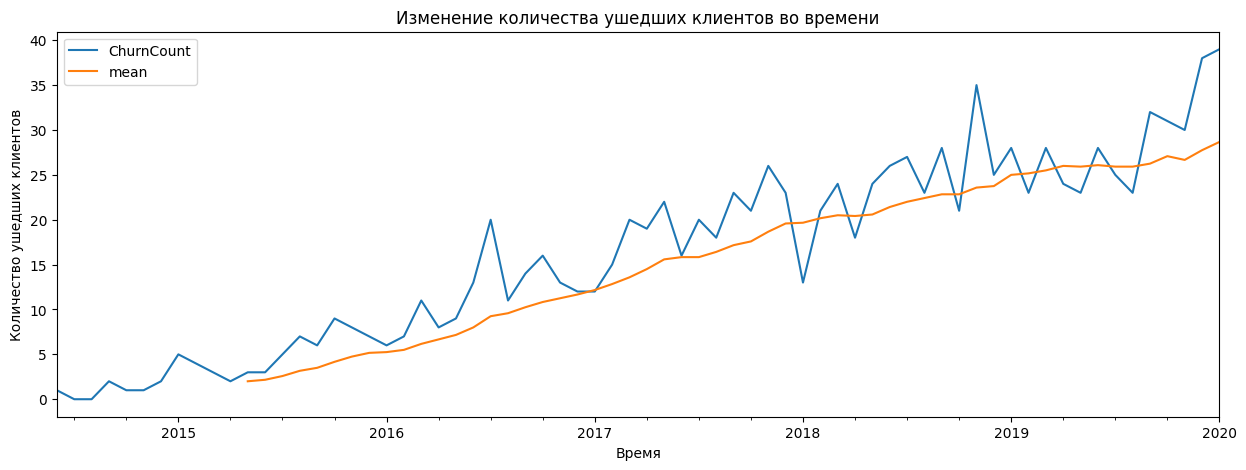

In [21]:
churn_data_cnt= churn_data_cnt.set_index('EndDate')
churn_data_cnt = churn_data_cnt.resample('1M').sum()
fig, ax = plt.subplots(figsize=(15,5))
churn_data_cnt['mean']= churn_data_cnt['ChurnCount'].rolling(12).mean()
churn_data_cnt.plot(
    ax= ax,
    title='Изменение количества ушедших клиентов во времени',
    xlabel='Время',
    ylabel='Количество ушедших клиентов'
)
plt.show()

**Промежуточный вывод: количество ушедших клиентов по времени растет, усилия компании по предсказанию уйдет ли клиент (с последующей попыткой удержать за счет спец.предложений), оправданы**

Добавим в данные о договорах столбец "Duration" - время, которое прошло с момента заключения договора

In [22]:
contract_data['Duration']= (contract_data['EndDate']-contract_data['BeginDate']).dt.days
display(contract_data.info())
contract_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   bool          
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   NoEndDate         7032 non-null   bool          
 9   Duration          7032 non-null   int64         
dtypes: bool(2), datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 508.2+ KB


None

customerID  BeginDate    EndDate            Type  PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              True   
1  5575-GNVDE 2017-04-01 2020-02-01        One year             False   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              True   
3  7795-CFOCW 2016-05-01 2020-02-01        One year             False   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              True   

               PaymentMethod  MonthlyCharges  TotalCharges  NoEndDate  \
0           Electronic check           29.85         31.04       True   
1               Mailed check           56.95       2071.84       True   
2               Mailed check           53.85        226.17       True   
3  Bank transfer (automatic)           42.30       1960.60       True   
4           Electronic check           70.70        353.50       True   

   Duration  
0        31  
1      1036  
2       123  
3      1371  
4       153

Визуализируем булевые и категориальные признаки

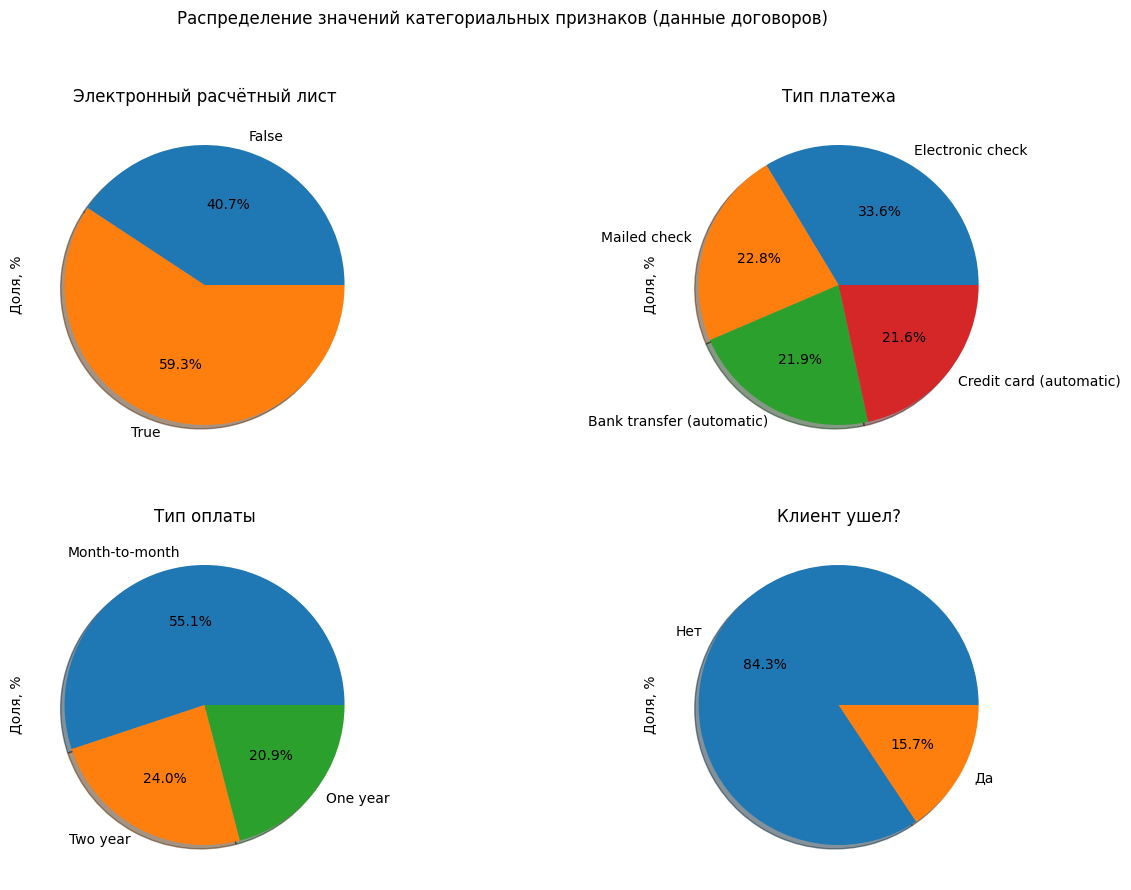

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Распределение значений категориальных признаков (данные договоров)')
contract_data.groupby('PaperlessBilling')['PaperlessBilling'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Электронный расчётный лист')
contract_data['PaymentMethod'].value_counts().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%',
shadow=True,
ylabel='Доля, %',
title='Тип платежа')
contract_data['Type'].value_counts().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%',
shadow=True,
ylabel='Доля, %',
title='Тип оплаты')
contract_data['NoEndDate'].value_counts().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%',
shadow=True,
ylabel='Доля, %',
labels= ['Нет', 'Да'],
title='Клиент ушел?')
plt.show()

Проанализируем численные признаки, связанные с оплатой

Text(0, 0.5, 'Расходы, у.е.')

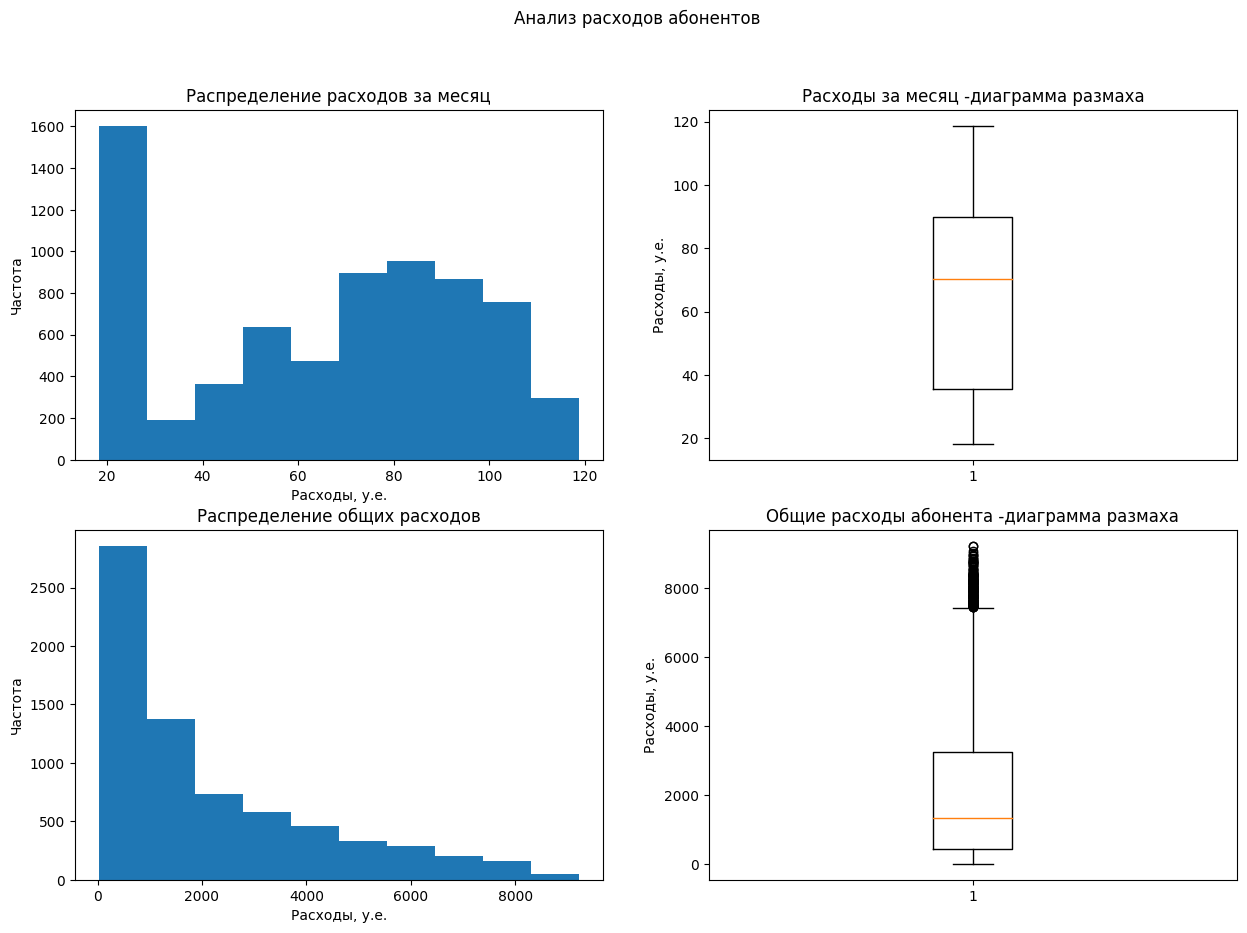

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Анализ расходов абонентов')
contract_data['MonthlyCharges'].plot(
    ax=ax1,
    kind='hist',
    title='Распределение расходов за месяц')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Расходы, у.е.')
ax2.boxplot(contract_data['MonthlyCharges'])
ax2.set_title('Расходы за месяц -диаграмма размаха')
ax2.set_ylabel('Расходы, у.е.')
contract_data['TotalCharges'].plot(
    ax=ax3,
    kind='hist',
    title='Распределение общих расходов')
ax3.set_ylabel('Частота')
ax3.set_xlabel('Расходы, у.е.')
ax4.boxplot(contract_data['TotalCharges'])
ax4.set_title('Общие расходы абонента -диаграмма размаха')
ax4.set_ylabel('Расходы, у.е.')

In [25]:
def get_upper_mustache(df, char_name):
    quartiles = df[char_name].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    return quartiles[0.75] + 1.5*iqr
def get_upper_values_cnt(df, char_name):
    upper_level= get_upper_mustache(df, char_name)
    return df[df[char_name]>upper_level][char_name].count()
anomal_values_cnt=get_upper_values_cnt(contract_data, 'TotalCharges')
print(f'Число аномально высоких значений суммарных расходов: {anomal_values_cnt}')
print(f'то есть {round(100*anomal_values_cnt/len(contract_data),1)} % от общего объема выборки')

Число аномально высоких значений суммарных расходов: 195
то есть 2.8 % от общего объема выборки


"Аномально-высокие" значения общих расходов не слишком выбиваются из общего распределения значений, не станем удалять их 

Визиализируем даннные о длительности договоров

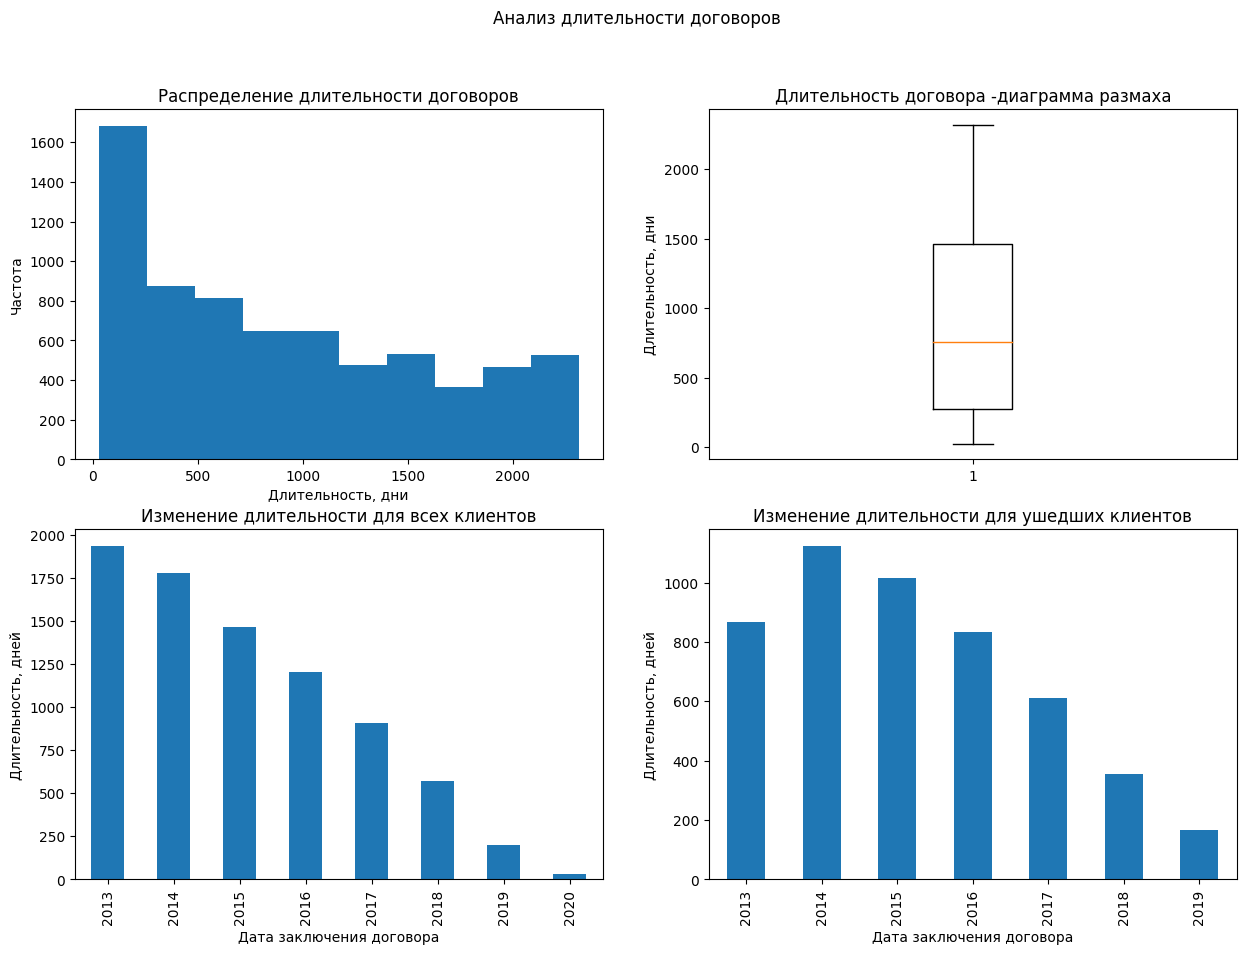

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Анализ длительности договоров')
contract_data['Duration'].plot(
    ax=ax1,
    kind='hist',
    title='Распределение длительности договоров')
ax1.set_ylabel('Частота')
ax1.set_xlabel('Длительность, дни')
ax2.boxplot(contract_data['Duration'])
ax2.set_title('Длительность договора -диаграмма размаха')
ax2.set_ylabel('Длительность, дни')
contract_data.groupby(
    [contract_data["BeginDate"].dt.year])["Duration"].mean().plot(
    ax= ax3,
    kind='bar',
    xlabel='Дата заключения договора',
    ylabel='Длительность, дней',
    title='Изменение длительности для всех клиентов'
)
churn_data['Duration']= (churn_data['EndDate']-churn_data['BeginDate']).dt.days
churn_data.groupby(
    [churn_data["BeginDate"].dt.year])["Duration"].mean().plot(
    ax= ax4,
    kind='bar',
    xlabel='Дата заключения договора',
    ylabel='Длительность, дней',
    title='Изменение длительности для ушедших клиентов'
)
plt.show()

**Персональные данные о клиентах**

In [27]:
print('Значения в строках-перечислениях (персональные данные клиентов):')
for column in personal_data.drop('customerID', axis=1).select_dtypes(include='object').columns.tolist():
    print(f'{column}:{sorted(personal_data[column].unique())}')

Значения в строках-перечислениях (персональные данные клиентов):
gender:['Female', 'Male']
Partner:['No', 'Yes']
Dependents:['No', 'Yes']


Дубликатов не найдено, заменим значения для "Partner" и "Dependents" на булевые из строковых

In [28]:
personal_data['Partner'] = personal_data['Partner'].apply(lambda x: True if x=='Yes' else False)
personal_data['Dependents'] = personal_data['Dependents'].apply(lambda x: True if x=='Yes' else False)
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   bool  
 4   Dependents     7043 non-null   bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 179.0+ KB


Значения поля 'является ли абонент пенсионером' (SeniorCitizen) [0 1]


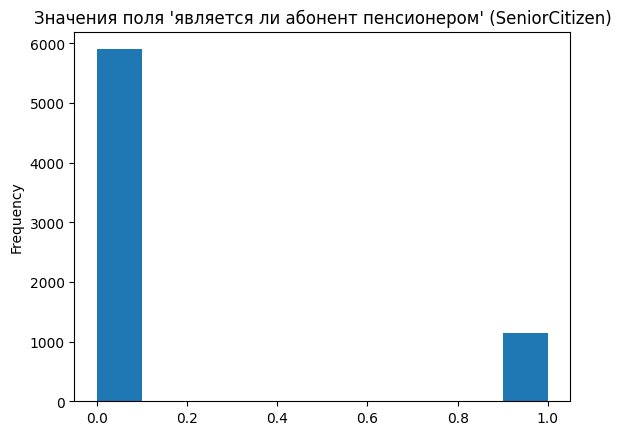

In [29]:
print('Значения поля \'является ли абонент пенсионером\' (SeniorCitizen)', personal_data['SeniorCitizen'].unique())
personal_data['SeniorCitizen'].plot(
    kind='hist',
    title='Значения поля \'является ли абонент пенсионером\' (SeniorCitizen)')
plt.show()

Заменим значения поля "SeniorCitizen" на булевые и построим графики

In [30]:
personal_data['SeniorCitizen'] = personal_data['SeniorCitizen'].apply(lambda x: True if x==1 else False)
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   bool  
 3   Partner        7043 non-null   bool  
 4   Dependents     7043 non-null   bool  
dtypes: bool(3), object(2)
memory usage: 130.8+ KB


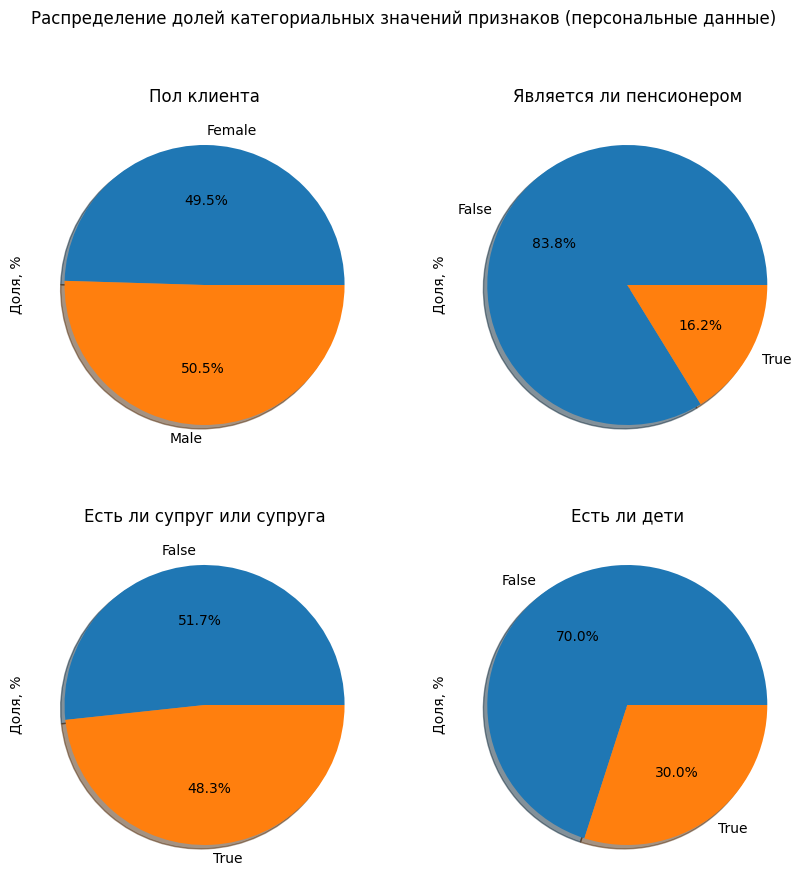

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Распределение долей категориальных значений признаков (персональные данные)')
personal_data.groupby('gender')['gender'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Пол клиента')
personal_data.groupby('SeniorCitizen')['SeniorCitizen'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Является ли пенсионером')
personal_data.groupby('Partner')['Partner'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Есть ли супруг или супруга')
personal_data.groupby('Dependents')['Dependents'].count().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='Есть ли дети')
plt.show()

**Информация об интернет-услугах**

Заменим строковые типы на булевые

In [32]:
internet_data['OnlineSecurity'] = internet_data['OnlineSecurity'].apply(lambda x: True if x=='Yes' else False)
internet_data['OnlineBackup'] = internet_data['OnlineBackup'].apply(lambda x: True if x=='Yes' else False)
internet_data['DeviceProtection'] = internet_data['DeviceProtection'].apply(lambda x: True if x=='Yes' else False)
internet_data['TechSupport'] = internet_data['TechSupport'].apply(lambda x: True if x=='Yes' else False)
internet_data['StreamingTV'] = internet_data['StreamingTV'].apply(lambda x: True if x=='Yes' else False)
internet_data['StreamingMovies'] = internet_data['StreamingMovies'].apply(lambda x: True if x=='Yes' else False)
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   bool  
 3   OnlineBackup      5517 non-null   bool  
 4   DeviceProtection  5517 non-null   bool  
 5   TechSupport       5517 non-null   bool  
 6   StreamingTV       5517 non-null   bool  
 7   StreamingMovies   5517 non-null   bool  
dtypes: bool(6), object(2)
memory usage: 118.7+ KB


Выведем значения поля-перечисления

In [33]:
sorted(internet_data['InternetService'].unique())

['DSL', 'Fiber optic']

**Вывод: неявные дубликаты в строке-перечислении не найдены**

Выведем графики

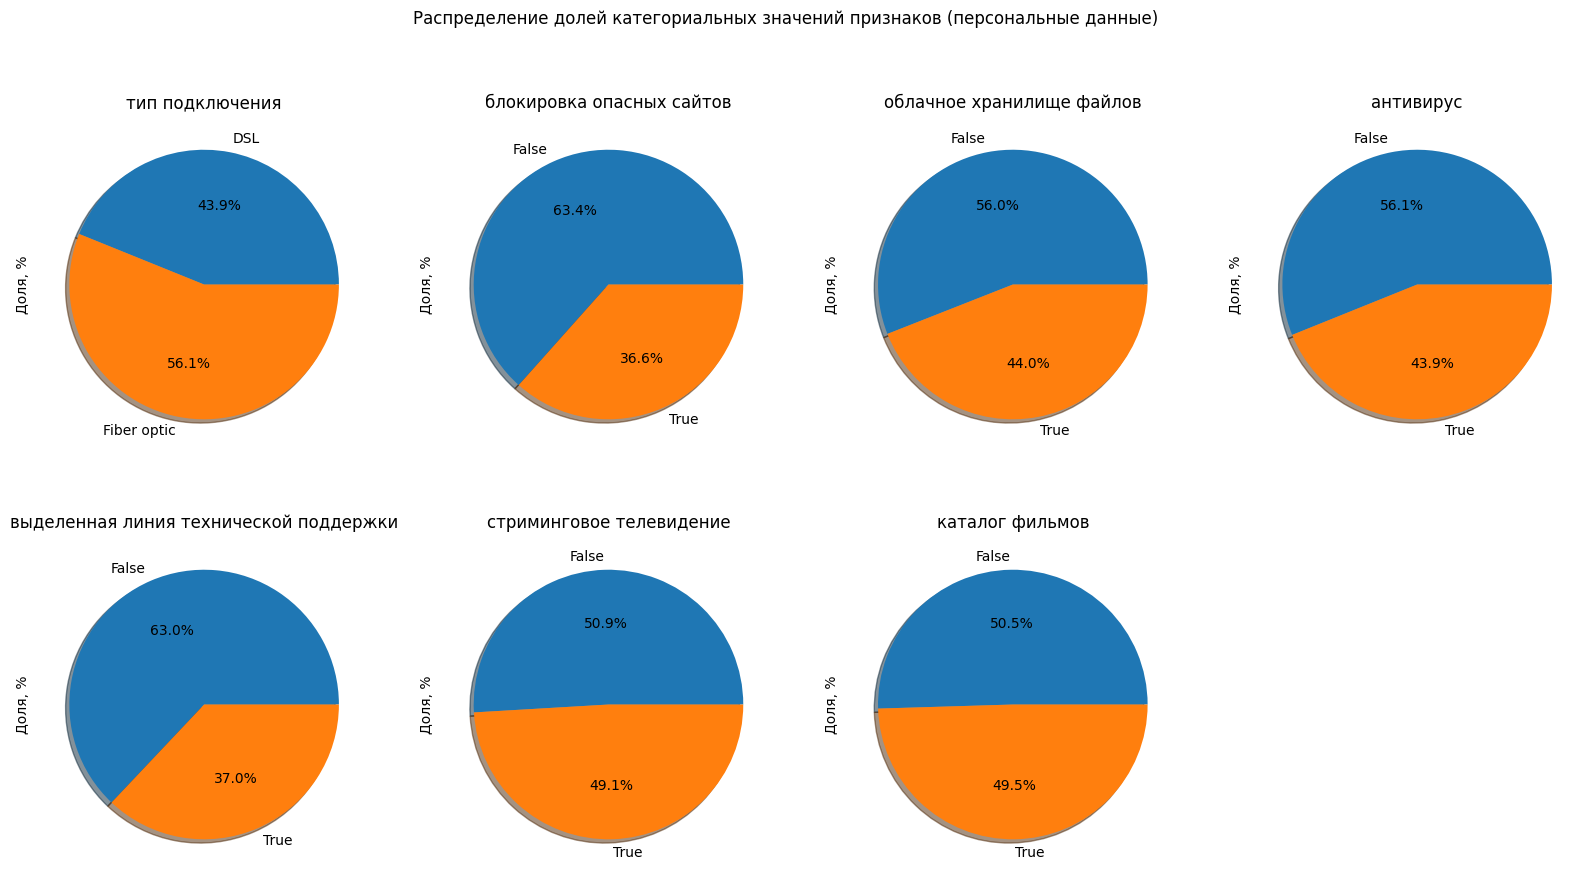

In [34]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle('Распределение долей категориальных значений признаков (персональные данные)')
internet_data.groupby('InternetService')['InternetService'].count().plot(
ax=ax1,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='тип подключения')
internet_data.groupby('OnlineSecurity')['OnlineSecurity'].count().plot(
ax=ax2,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='блокировка опасных сайтов')
internet_data.groupby('OnlineBackup')['OnlineBackup'].count().plot(
ax=ax3,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='облачное хранилище файлов')
internet_data.groupby('DeviceProtection')['DeviceProtection'].count().plot(
ax=ax4,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='антивирус')
internet_data.groupby('TechSupport')['TechSupport'].count().plot(
ax=ax5,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='выделенная линия технической поддержки')
internet_data.groupby('StreamingTV')['StreamingTV'].count().plot(
ax=ax6,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='стриминговое телевидение')
internet_data.groupby('StreamingMovies')['StreamingMovies'].count().plot(
ax=ax7,
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='каталог фильмов')
ax8.set_visible(False)
plt.show()

**Информация об услугах телефонии**

Заменим значения для "MultipleLines" на булевые из строковых

In [35]:
phone_data['MultipleLines'] = phone_data['MultipleLines'].apply(lambda x: True if x=='Yes' else False)
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 56.0+ KB


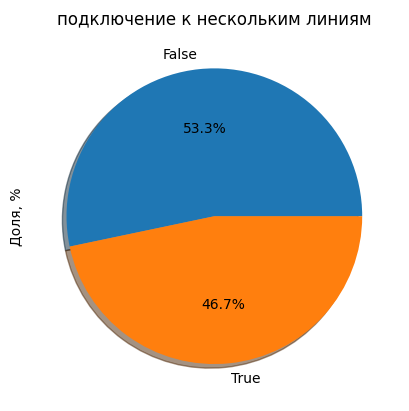

In [36]:
phone_data.groupby('MultipleLines')['MultipleLines'].count().plot(
kind='pie',
autopct='%1.1f%%', 
shadow=True,
ylabel='Доля, %',
title='подключение к нескольким линиям')
plt.show()

**Вывод по результатам исследовательского анализа данных: 1) В категориальных признаках есть сбалансированные (пол, наличие супруга, подключение к нескольким линиям, стриминговое телевидение, каталог фильмов) и несбалансированные (все остальные). Целевой признак (ушел клиент или нет) несбалансирован. В задании рекомендуется использовать метрику Roc-auc, она не чувствительна к дисбалансу классов, поэтому балансировать выборки для обучения не требуется. 2) Численные признаки (ежемесячные и общие расходы, длительность договора) имеют вид распределения, отличный от нормального, да и наличие множетсва категориальных признаков говорит о том, что для анализа корреляции требуется инструмент типа матрицы Phik.**

## 3 Объединение данных

In [37]:
df= contract_data.copy()
df= df.set_index('customerID').join(personal_data.set_index('customerID'))
df= df.join(internet_data.set_index('customerID'))
df= df.join(phone_data.set_index('customerID'))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   bool          
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   NoEndDate         7032 non-null   bool          
 8   Duration          7032 non-null   int64         
 9   gender            7032 non-null   object        
 10  SeniorCitizen     7032 non-null   bool          
 11  Partner           7032 non-null   bool          
 12  Dependents        7032 non-null   bool          
 13  InternetService   5512 non-null   object        
 14  OnlineSecurity

In [38]:
df.head()

BeginDate    EndDate            Type  PaperlessBilling  \
customerID                                                           
7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              True   
5575-GNVDE 2017-04-01 2020-02-01        One year             False   
3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              True   
7795-CFOCW 2016-05-01 2020-02-01        One year             False   
9237-HQITU 2019-09-01 2020-02-01  Month-to-month              True   

                        PaymentMethod  MonthlyCharges  TotalCharges  \
customerID                                                            
7590-VHVEG           Electronic check           29.85         31.04   
5575-GNVDE               Mailed check           56.95       2071.84   
3668-QPYBK               Mailed check           53.85        226.17   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60   
9237-HQITU           Electronic check           70.70        353.50   

            NoEndDate  Duration  gender  ...  Partner  Dependents  \
customerID                               ...                        
7590-VHVEG       True        31  Female  ...     True       False   
5575-GNVDE       True      1036    Male  ...    False       False   
3668-QPYBK       True       123    Male  ...    False       False   
7795-CFOCW       True      1371    Male  ...    False       False   
9237-HQITU       True       153  Female  ...    False       False   

            InternetService OnlineSecurity OnlineBackup DeviceProtection  \
customerID                                                                 
7590-VHVEG              DSL          False         True            False   
5575-GNVDE              DSL           True        False             True   
3668-QPYBK              DSL           True         True            False   
7795-CFOCW              DSL           True        False             True   
9237-HQITU      Fiber optic          False        False            False   

           TechSupport StreamingTV StreamingMovies MultipleLines  
customerID                                                        
7590-VHVEG       False       False           False           NaN  
5575-GNVDE       False       False           False         False  
3668-QPYBK       False       False           False         False  
7795-CFOCW        True       False           False           NaN  
9237-HQITU       False       False           False         False  

[5 rows x 21 columns]

## 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Построим матрицу корреляций для анализа взаимовлияния признаков и исключения возможной мультиколлинеарности

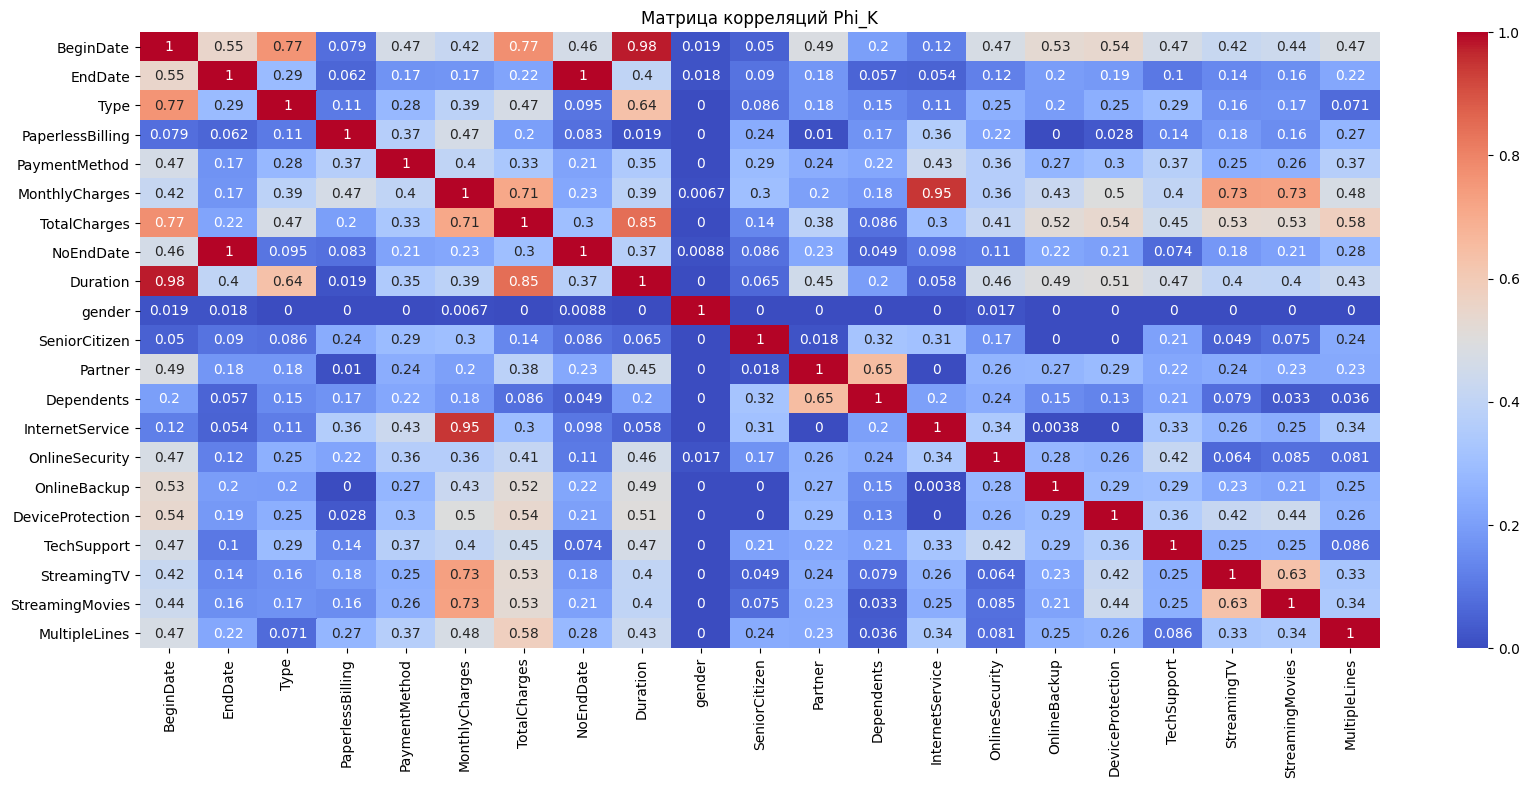

In [39]:
interval_columns=  ['MonthlyCharges','TotalCharges','Duration']
corr_matrix = df.phik_matrix(interval_cols=interval_columns)

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций Phi_K')
plt.show()

**Вывод: судя по матрице, для признаков "EndDate" и "Duration", а также "InternetService" и "MonthlyCharges" наблюдается мультиколлинеарность, поэтому удалим "EndDate" и "InternetService" чтобы не допустить утечки целевого признака. Логически понятно, что длительность договора связана с датами начала и окончания (утечка целевого признака налицо), а наличие у клиента интернет-сервиса - видимо единственная причина наличия у него же ежемесячных платежей (судя по высокой корреляции). Признак "BeginDate" (дата договора) также ничем не поможет "в чистом виде" обучению, если бы мы использовали элементы анализа временных рядов (то есть выделили день недели, месяц или другие элементы сезонности - то да, но этого не наблюдается). Поэтому удалим и дату начала ('BeginDate') тоже. Также удалим признаки, которые практически не влияют на целевой признак "NoEndDate" (имеют корреляцию ниже заданного порогового значения), чтобы облегчить модель**

Удалим признаки с низкой корреляцией

In [40]:
#пороговое значение корреляции, ниже которой удаляем признак
threshold= 0.1
corr_target= corr_matrix['NoEndDate']
for index, val in corr_target.iteritems():
    if val<threshold:
        df= df.drop(index, axis= 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   PaymentMethod     7032 non-null   object        
 3   MonthlyCharges    7032 non-null   float64       
 4   TotalCharges      7032 non-null   float64       
 5   NoEndDate         7032 non-null   bool          
 6   Duration          7032 non-null   int64         
 7   Partner           7032 non-null   bool          
 8   OnlineSecurity    5512 non-null   object        
 9   OnlineBackup      5512 non-null   object        
 10  DeviceProtection  5512 non-null   object        
 11  StreamingTV       5512 non-null   object        
 12  StreamingMovies   5512 non-null   object        
 13  MultipleLines     6352 non-null   object        
dtypes: bool(2), da

Удалим признаки для избежания мультиколлинеарности/уточки целевого признака

In [41]:
df= df.drop(['EndDate', 'BeginDate'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PaymentMethod     7032 non-null   object 
 1   MonthlyCharges    7032 non-null   float64
 2   TotalCharges      7032 non-null   float64
 3   NoEndDate         7032 non-null   bool   
 4   Duration          7032 non-null   int64  
 5   Partner           7032 non-null   bool   
 6   OnlineSecurity    5512 non-null   object 
 7   OnlineBackup      5512 non-null   object 
 8   DeviceProtection  5512 non-null   object 
 9   StreamingTV       5512 non-null   object 
 10  StreamingMovies   5512 non-null   object 
 11  MultipleLines     6352 non-null   object 
dtypes: bool(2), float64(2), int64(1), object(7)
memory usage: 876.1+ KB


Проверим наличие полных дубликатов

In [42]:
df.duplicated().sum()

41

Избавимся от полных дубликатов

In [43]:
df= df.drop_duplicates()
df.duplicated().sum()

0

Проанализируем пропуски в данных в %

In [44]:
pd.DataFrame(round(df.isna().mean()*100, 1)).style.background_gradient('coolwarm')

**При кодировании категориальных (object) признаков(OnlineSecurity, OnlineBackup и других с ненулевым числом пропусков) нужно будет предусмотреть в pipeline заполнение пропусков на заглушку**

## 5. Подготовка данных

Задаем тестовые и тренировочные выборки, RANDOM_STATE

In [45]:
RANDOM_STATE = 60524
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['NoEndDate'], axis=1),
    df['NoEndDate'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['NoEndDate'])

X_train.shape, X_test.shape

((5243, 11), (1748, 11))

Проверим тренировочную таблицу для обучения на наличие полных дубликатов 

In [46]:
X_train.duplicated().sum()

0

Проверим наборы данных для моделирования

In [47]:
X_train.head(5)

PaymentMethod  MonthlyCharges  TotalCharges  Duration  \
customerID                                                                      
3563-SVYLG    Credit card (automatic)           62.65       4260.20      2071   
7964-ZRKKG  Bank transfer (automatic)           88.40       6455.85      2041   
3166-PNEOF    Credit card (automatic)           86.45       5273.45      1857   
7850-THJMU    Credit card (automatic)           19.65        541.55       792   
2619-WFQWU               Mailed check           70.15        140.30        62   

            Partner OnlineSecurity OnlineBackup DeviceProtection StreamingTV  \
customerID                                                                     
3563-SVYLG     True           True         True             True       False   
7964-ZRKKG     True          False         True            False        True   
3166-PNEOF    False           True        False             True        True   
7850-THJMU     True            NaN          NaN              NaN         NaN   
2619-WFQWU    False          False        False            False       False   

           StreamingMovies MultipleLines  
customerID                                
3563-SVYLG           False         False  
7964-ZRKKG           False          True  
3166-PNEOF            True          True  
7850-THJMU             NaN         False  
2619-WFQWU           False         False

In [48]:
X_test.head(5)

PaymentMethod  MonthlyCharges  TotalCharges  Duration  \
customerID                                                                    
7706-DZNKK  Credit card (automatic)           20.45        224.95       337   
1818-ESQMW         Electronic check           89.20       2408.40       822   
4547-FZJWE  Credit card (automatic)           59.45       3269.75      1676   
7266-GSSJX         Electronic check           20.45        238.45       337   
3254-YRILK         Electronic check           88.20       2028.60       702   

            Partner OnlineSecurity OnlineBackup DeviceProtection StreamingTV  \
customerID                                                                     
7706-DZNKK    False            NaN          NaN              NaN         NaN   
1818-ESQMW    False          False        False             True       False   
4547-FZJWE     True           True        False            False       False   
7266-GSSJX     True            NaN          NaN              NaN         NaN   
3254-YRILK    False          False         True            False        True   

           StreamingMovies MultipleLines  
customerID                                
7706-DZNKK             NaN         False  
1818-ESQMW            True         False  
4547-FZJWE            True         False  
7266-GSSJX             NaN         False  
3254-YRILK           False          True

In [49]:
y_train.head()

customerID
3563-SVYLG    True
7964-ZRKKG    True
3166-PNEOF    True
7850-THJMU    True
2619-WFQWU    True
Name: NoEndDate, dtype: bool

In [50]:
y_test.head()

customerID
7706-DZNKK    True
1818-ESQMW    True
4547-FZJWE    True
7266-GSSJX    True
3254-YRILK    True
Name: NoEndDate, dtype: bool

Создаём список категориальных признаков, используем OrdinalEncoder для кодирования. Добавим обработку пропущенных значений в pipeline

In [51]:
cat_columns =  X_train.select_dtypes(include=['object', 'bool']).columns
cat_columns

Index(['PaymentMethod', 'Partner', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

Cоздаём список численных признаков, для них предусмотрим масштабирование

In [52]:
num_columns= X_train.select_dtypes(include=['float64', 'int64']).columns
num_columns

Index(['MonthlyCharges', 'TotalCharges', 'Duration'], dtype='object')

создаём пайплайн для подготовки признаков из списка категориальных признаков cat_columns: заполнение пропусков и OneHotEncoder-кодирование

In [53]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',  OneHotEncoder(handle_unknown='ignore', drop= 'first')
        )
    ]
)

## 6. Обучение моделей

In [54]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_columns),
     ('num', [StandardScaler(), 'passthrough'], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

In [55]:
param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,10),
        'models__max_features': range(1,10),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 10),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    #словарь для модели CatBoostClassifier
    {
       'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
       'models__max_depth': range(2,10),
       'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]


Используем LabelEncoder для кодирования целевого признака

In [56]:
print('y_train до кодирования:', y_train.tolist()[:5])
# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучим модель и трансформируем тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

print('y_train после кодирования:', y_train.tolist()[:5])

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

print('y_test после кодирования:', y_test[:5])

y_train до кодирования: [True, True, True, True, True]
y_train после кодирования: [1, 1, 1, 1, 1]
y_test после кодирования: [1 1 1 1 1]


Настроим инструменты перебора гиперпараметров моделей

In [57]:
t0_total = time.time()

In [58]:
cv_search = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)
cv_search.fit(X_train, y_train)

print('Лучшая модель:\n\n', cv_search.best_estimator_)
print ('Параметры лучшей модели:', cv_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', round(cv_search.best_score_, 2))

Learning rate set to 0.020902
0:	learn: 0.6751368	total: 140ms	remaining: 2m 19s
1:	learn: 0.6588676	total: 145ms	remaining: 1m 12s
2:	learn: 0.6435325	total: 152ms	remaining: 50.5s
3:	learn: 0.6287016	total: 158ms	remaining: 39.3s
4:	learn: 0.6168290	total: 164ms	remaining: 32.6s
5:	learn: 0.6040923	total: 170ms	remaining: 28.1s
6:	learn: 0.5931190	total: 175ms	remaining: 24.9s
7:	learn: 0.5816470	total: 181ms	remaining: 22.5s
8:	learn: 0.5713736	total: 187ms	remaining: 20.6s
9:	learn: 0.5607754	total: 193ms	remaining: 19.1s
10:	learn: 0.5513767	total: 201ms	remaining: 18.1s
11:	learn: 0.5421013	total: 207ms	remaining: 17.1s
12:	learn: 0.5323417	total: 214ms	remaining: 16.2s
13:	learn: 0.5244808	total: 220ms	remaining: 15.5s
14:	learn: 0.5161846	total: 226ms	remaining: 14.8s
15:	learn: 0.5089119	total: 232ms	remaining: 14.3s
16:	learn: 0.5020279	total: 238ms	remaining: 13.7s
17:	learn: 0.4954581	total: 244ms	remaining: 13.3s
18:	learn: 0.4897812	total: 249ms	remaining: 12.9s
19:	learn

Learning rate set to 0.019002
0:	learn: 0.6789269	total: 964us	remaining: 963ms
1:	learn: 0.6680291	total: 1.98ms	remaining: 990ms
2:	learn: 0.6570746	total: 2.86ms	remaining: 952ms
3:	learn: 0.6450149	total: 3.57ms	remaining: 889ms
4:	learn: 0.6350995	total: 4.36ms	remaining: 867ms
5:	learn: 0.6248890	total: 5.11ms	remaining: 847ms
6:	learn: 0.6141488	total: 5.88ms	remaining: 834ms
7:	learn: 0.6052568	total: 6.67ms	remaining: 828ms
8:	learn: 0.5964367	total: 7.58ms	remaining: 835ms
9:	learn: 0.5882640	total: 8.43ms	remaining: 834ms
10:	learn: 0.5806007	total: 9.3ms	remaining: 836ms
11:	learn: 0.5730454	total: 10.2ms	remaining: 837ms
12:	learn: 0.5660469	total: 11ms	remaining: 839ms
13:	learn: 0.5582630	total: 11.9ms	remaining: 836ms
14:	learn: 0.5517682	total: 12.7ms	remaining: 836ms
15:	learn: 0.5454068	total: 13.6ms	remaining: 836ms
16:	learn: 0.5382334	total: 14.5ms	remaining: 836ms
17:	learn: 0.5326091	total: 15.3ms	remaining: 835ms
18:	learn: 0.5271711	total: 16.2ms	remaining: 83

300:	learn: 0.3447495	total: 284ms	remaining: 660ms
301:	learn: 0.3447086	total: 285ms	remaining: 659ms
302:	learn: 0.3446170	total: 286ms	remaining: 658ms
303:	learn: 0.3445833	total: 287ms	remaining: 657ms
304:	learn: 0.3445424	total: 288ms	remaining: 656ms
305:	learn: 0.3443455	total: 289ms	remaining: 655ms
306:	learn: 0.3443155	total: 290ms	remaining: 654ms
307:	learn: 0.3442265	total: 290ms	remaining: 652ms
308:	learn: 0.3441270	total: 291ms	remaining: 651ms
309:	learn: 0.3440867	total: 292ms	remaining: 650ms
310:	learn: 0.3440413	total: 293ms	remaining: 649ms
311:	learn: 0.3438382	total: 294ms	remaining: 648ms
312:	learn: 0.3437736	total: 295ms	remaining: 647ms
313:	learn: 0.3437123	total: 296ms	remaining: 646ms
314:	learn: 0.3436691	total: 296ms	remaining: 645ms
315:	learn: 0.3435549	total: 297ms	remaining: 644ms
316:	learn: 0.3435054	total: 298ms	remaining: 642ms
317:	learn: 0.3434297	total: 299ms	remaining: 641ms
318:	learn: 0.3433734	total: 300ms	remaining: 640ms
319:	learn: 

467:	learn: 0.3353141	total: 434ms	remaining: 493ms
468:	learn: 0.3352277	total: 435ms	remaining: 492ms
469:	learn: 0.3351909	total: 436ms	remaining: 492ms
470:	learn: 0.3351503	total: 438ms	remaining: 491ms
471:	learn: 0.3351228	total: 439ms	remaining: 491ms
472:	learn: 0.3350902	total: 440ms	remaining: 490ms
473:	learn: 0.3350502	total: 441ms	remaining: 490ms
474:	learn: 0.3350052	total: 443ms	remaining: 489ms
475:	learn: 0.3349723	total: 444ms	remaining: 489ms
476:	learn: 0.3349355	total: 445ms	remaining: 488ms
477:	learn: 0.3348986	total: 446ms	remaining: 487ms
478:	learn: 0.3348603	total: 448ms	remaining: 487ms
479:	learn: 0.3348327	total: 449ms	remaining: 486ms
480:	learn: 0.3348066	total: 450ms	remaining: 485ms
481:	learn: 0.3347472	total: 451ms	remaining: 484ms
482:	learn: 0.3347077	total: 451ms	remaining: 483ms
483:	learn: 0.3345970	total: 452ms	remaining: 482ms
484:	learn: 0.3345800	total: 453ms	remaining: 481ms
485:	learn: 0.3345168	total: 454ms	remaining: 480ms
486:	learn: 

731:	learn: 0.3238657	total: 700ms	remaining: 256ms
732:	learn: 0.3238405	total: 701ms	remaining: 256ms
733:	learn: 0.3238181	total: 702ms	remaining: 255ms
734:	learn: 0.3237917	total: 703ms	remaining: 254ms
735:	learn: 0.3237562	total: 704ms	remaining: 253ms
736:	learn: 0.3237363	total: 705ms	remaining: 252ms
737:	learn: 0.3236571	total: 706ms	remaining: 251ms
738:	learn: 0.3236360	total: 707ms	remaining: 250ms
739:	learn: 0.3236024	total: 708ms	remaining: 249ms
740:	learn: 0.3235834	total: 709ms	remaining: 248ms
741:	learn: 0.3235750	total: 710ms	remaining: 247ms
742:	learn: 0.3235384	total: 711ms	remaining: 246ms
743:	learn: 0.3235198	total: 712ms	remaining: 245ms
744:	learn: 0.3234848	total: 713ms	remaining: 244ms
745:	learn: 0.3234660	total: 713ms	remaining: 243ms
746:	learn: 0.3234416	total: 714ms	remaining: 242ms
747:	learn: 0.3234187	total: 715ms	remaining: 241ms
748:	learn: 0.3233889	total: 716ms	remaining: 240ms
749:	learn: 0.3233715	total: 717ms	remaining: 239ms
750:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6791457	total: 897us	remaining: 897ms
1:	learn: 0.6679309	total: 1.79ms	remaining: 896ms
2:	learn: 0.6572037	total: 2.69ms	remaining: 895ms
3:	learn: 0.6461328	total: 3.51ms	remaining: 874ms
4:	learn: 0.6358605	total: 4.25ms	remaining: 846ms
5:	learn: 0.6257061	total: 5.03ms	remaining: 833ms
6:	learn: 0.6153822	total: 5.89ms	remaining: 835ms
7:	learn: 0.6062911	total: 6.69ms	remaining: 829ms
8:	learn: 0.5982345	total: 7.49ms	remaining: 825ms
9:	learn: 0.5899969	total: 8.23ms	remaining: 815ms
10:	learn: 0.5826980	total: 9.11ms	remaining: 819ms
11:	learn: 0.5750445	total: 9.87ms	remaining: 813ms
12:	learn: 0.5681082	total: 10.7ms	remaining: 810ms
13:	learn: 0.5596537	total: 11.6ms	remaining: 815ms
14:	learn: 0.5529516	total: 12.5ms	remaining: 821ms
15:	learn: 0.5468500	total: 13.3ms	remaining: 819ms
16:	learn: 0.5411736	total: 14.2ms	remaining: 822ms
17:	learn: 0.5338894	total: 15.1ms	remaining: 821ms
18:	learn: 0.5280901	total: 15.9ms	remaining:

287:	learn: 0.3507504	total: 272ms	remaining: 673ms
288:	learn: 0.3506229	total: 273ms	remaining: 672ms
289:	learn: 0.3505746	total: 274ms	remaining: 672ms
290:	learn: 0.3504938	total: 276ms	remaining: 671ms
291:	learn: 0.3504275	total: 277ms	remaining: 671ms
292:	learn: 0.3503593	total: 278ms	remaining: 670ms
293:	learn: 0.3503049	total: 279ms	remaining: 669ms
294:	learn: 0.3502491	total: 280ms	remaining: 668ms
295:	learn: 0.3501108	total: 281ms	remaining: 667ms
296:	learn: 0.3499163	total: 281ms	remaining: 666ms
297:	learn: 0.3498642	total: 282ms	remaining: 665ms
298:	learn: 0.3498173	total: 283ms	remaining: 664ms
299:	learn: 0.3497732	total: 284ms	remaining: 663ms
300:	learn: 0.3497233	total: 285ms	remaining: 662ms
301:	learn: 0.3496374	total: 286ms	remaining: 661ms
302:	learn: 0.3495853	total: 287ms	remaining: 660ms
303:	learn: 0.3495374	total: 288ms	remaining: 659ms
304:	learn: 0.3494651	total: 289ms	remaining: 658ms
305:	learn: 0.3493945	total: 290ms	remaining: 657ms
306:	learn: 

588:	learn: 0.3356388	total: 542ms	remaining: 378ms
589:	learn: 0.3355379	total: 543ms	remaining: 378ms
590:	learn: 0.3355098	total: 544ms	remaining: 377ms
591:	learn: 0.3354791	total: 545ms	remaining: 376ms
592:	learn: 0.3354474	total: 546ms	remaining: 375ms
593:	learn: 0.3354110	total: 547ms	remaining: 374ms
594:	learn: 0.3353857	total: 548ms	remaining: 373ms
595:	learn: 0.3353569	total: 548ms	remaining: 372ms
596:	learn: 0.3353355	total: 549ms	remaining: 371ms
597:	learn: 0.3353079	total: 550ms	remaining: 370ms
598:	learn: 0.3352837	total: 551ms	remaining: 369ms
599:	learn: 0.3352540	total: 552ms	remaining: 368ms
600:	learn: 0.3352166	total: 552ms	remaining: 367ms
601:	learn: 0.3351876	total: 553ms	remaining: 366ms
602:	learn: 0.3351409	total: 554ms	remaining: 365ms
603:	learn: 0.3351175	total: 555ms	remaining: 364ms
604:	learn: 0.3350833	total: 556ms	remaining: 363ms
605:	learn: 0.3350596	total: 556ms	remaining: 362ms
606:	learn: 0.3350393	total: 557ms	remaining: 361ms
607:	learn: 

899:	learn: 0.3245678	total: 812ms	remaining: 90.2ms
900:	learn: 0.3245542	total: 813ms	remaining: 89.3ms
901:	learn: 0.3245374	total: 814ms	remaining: 88.4ms
902:	learn: 0.3245205	total: 814ms	remaining: 87.5ms
903:	learn: 0.3245007	total: 815ms	remaining: 86.6ms
904:	learn: 0.3244803	total: 816ms	remaining: 85.7ms
905:	learn: 0.3244163	total: 817ms	remaining: 84.8ms
906:	learn: 0.3244032	total: 818ms	remaining: 83.9ms
907:	learn: 0.3243855	total: 819ms	remaining: 83ms
908:	learn: 0.3241944	total: 820ms	remaining: 82.1ms
909:	learn: 0.3241804	total: 820ms	remaining: 81.1ms
910:	learn: 0.3240658	total: 821ms	remaining: 80.2ms
911:	learn: 0.3240481	total: 822ms	remaining: 79.3ms
912:	learn: 0.3240260	total: 823ms	remaining: 78.4ms
913:	learn: 0.3240122	total: 824ms	remaining: 77.5ms
914:	learn: 0.3238340	total: 825ms	remaining: 76.6ms
915:	learn: 0.3238166	total: 826ms	remaining: 75.7ms
916:	learn: 0.3238060	total: 827ms	remaining: 74.8ms
917:	learn: 0.3236358	total: 828ms	remaining: 73

154:	learn: 0.3650447	total: 153ms	remaining: 835ms
155:	learn: 0.3646515	total: 154ms	remaining: 834ms
156:	learn: 0.3644662	total: 155ms	remaining: 833ms
157:	learn: 0.3643303	total: 156ms	remaining: 831ms
158:	learn: 0.3642187	total: 157ms	remaining: 829ms
159:	learn: 0.3639966	total: 158ms	remaining: 828ms
160:	learn: 0.3638478	total: 159ms	remaining: 827ms
161:	learn: 0.3637441	total: 159ms	remaining: 825ms
162:	learn: 0.3636232	total: 160ms	remaining: 823ms
163:	learn: 0.3634590	total: 161ms	remaining: 821ms
164:	learn: 0.3633144	total: 162ms	remaining: 819ms
165:	learn: 0.3632072	total: 163ms	remaining: 817ms
166:	learn: 0.3628949	total: 163ms	remaining: 815ms
167:	learn: 0.3627655	total: 164ms	remaining: 813ms
168:	learn: 0.3626713	total: 165ms	remaining: 812ms
169:	learn: 0.3624135	total: 166ms	remaining: 811ms
170:	learn: 0.3622715	total: 167ms	remaining: 809ms
171:	learn: 0.3621082	total: 168ms	remaining: 807ms
172:	learn: 0.3620160	total: 168ms	remaining: 805ms
173:	learn: 

455:	learn: 0.3410130	total: 444ms	remaining: 530ms
456:	learn: 0.3408999	total: 445ms	remaining: 529ms
457:	learn: 0.3408537	total: 446ms	remaining: 528ms
458:	learn: 0.3407360	total: 447ms	remaining: 527ms
459:	learn: 0.3406916	total: 448ms	remaining: 525ms
460:	learn: 0.3406624	total: 448ms	remaining: 524ms
461:	learn: 0.3406359	total: 449ms	remaining: 523ms
462:	learn: 0.3405275	total: 450ms	remaining: 522ms
463:	learn: 0.3403544	total: 451ms	remaining: 521ms
464:	learn: 0.3402618	total: 452ms	remaining: 520ms
465:	learn: 0.3402021	total: 453ms	remaining: 519ms
466:	learn: 0.3401834	total: 454ms	remaining: 518ms
467:	learn: 0.3401612	total: 455ms	remaining: 517ms
468:	learn: 0.3401110	total: 456ms	remaining: 516ms
469:	learn: 0.3400851	total: 457ms	remaining: 515ms
470:	learn: 0.3400602	total: 457ms	remaining: 514ms
471:	learn: 0.3400232	total: 458ms	remaining: 513ms
472:	learn: 0.3399937	total: 459ms	remaining: 511ms
473:	learn: 0.3399754	total: 460ms	remaining: 510ms
474:	learn: 

616:	learn: 0.3344488	total: 586ms	remaining: 364ms
617:	learn: 0.3344100	total: 588ms	remaining: 363ms
618:	learn: 0.3343811	total: 589ms	remaining: 362ms
619:	learn: 0.3343634	total: 590ms	remaining: 362ms
620:	learn: 0.3343359	total: 591ms	remaining: 361ms
621:	learn: 0.3343148	total: 592ms	remaining: 360ms
622:	learn: 0.3342930	total: 593ms	remaining: 359ms
623:	learn: 0.3342772	total: 595ms	remaining: 358ms
624:	learn: 0.3342398	total: 596ms	remaining: 358ms
625:	learn: 0.3342046	total: 597ms	remaining: 357ms
626:	learn: 0.3341781	total: 598ms	remaining: 356ms
627:	learn: 0.3341659	total: 599ms	remaining: 355ms
628:	learn: 0.3341373	total: 601ms	remaining: 354ms
629:	learn: 0.3341098	total: 602ms	remaining: 353ms
630:	learn: 0.3340735	total: 603ms	remaining: 353ms
631:	learn: 0.3340060	total: 604ms	remaining: 352ms
632:	learn: 0.3339796	total: 606ms	remaining: 351ms
633:	learn: 0.3339335	total: 607ms	remaining: 350ms
634:	learn: 0.3339033	total: 608ms	remaining: 349ms
635:	learn: 

846:	learn: 0.3256478	total: 808ms	remaining: 146ms
847:	learn: 0.3256333	total: 809ms	remaining: 145ms
848:	learn: 0.3256182	total: 810ms	remaining: 144ms
849:	learn: 0.3256119	total: 811ms	remaining: 143ms
850:	learn: 0.3254271	total: 812ms	remaining: 142ms
851:	learn: 0.3254111	total: 813ms	remaining: 141ms
852:	learn: 0.3254062	total: 813ms	remaining: 140ms
853:	learn: 0.3253907	total: 814ms	remaining: 139ms
854:	learn: 0.3253762	total: 815ms	remaining: 138ms
855:	learn: 0.3251998	total: 816ms	remaining: 137ms
856:	learn: 0.3251857	total: 816ms	remaining: 136ms
857:	learn: 0.3251625	total: 817ms	remaining: 135ms
858:	learn: 0.3251579	total: 818ms	remaining: 134ms
859:	learn: 0.3251307	total: 819ms	remaining: 133ms
860:	learn: 0.3251153	total: 820ms	remaining: 132ms
861:	learn: 0.3251105	total: 821ms	remaining: 131ms
862:	learn: 0.3250902	total: 822ms	remaining: 131ms
863:	learn: 0.3250681	total: 823ms	remaining: 130ms
864:	learn: 0.3250234	total: 824ms	remaining: 129ms
865:	learn: 

13:	learn: 0.5581369	total: 11.5ms	remaining: 808ms
14:	learn: 0.5520435	total: 12.3ms	remaining: 810ms
15:	learn: 0.5459848	total: 13.3ms	remaining: 818ms
16:	learn: 0.5396972	total: 14.2ms	remaining: 821ms
17:	learn: 0.5337355	total: 15.1ms	remaining: 824ms
18:	learn: 0.5283395	total: 15.9ms	remaining: 820ms
19:	learn: 0.5231252	total: 16.8ms	remaining: 822ms
20:	learn: 0.5169777	total: 17.6ms	remaining: 821ms
21:	learn: 0.5123062	total: 18.4ms	remaining: 817ms
22:	learn: 0.5070744	total: 19.3ms	remaining: 819ms
23:	learn: 0.5019326	total: 20.1ms	remaining: 818ms
24:	learn: 0.4968633	total: 21ms	remaining: 818ms
25:	learn: 0.4919545	total: 21.7ms	remaining: 815ms
26:	learn: 0.4868843	total: 22.7ms	remaining: 819ms
27:	learn: 0.4822110	total: 23.6ms	remaining: 819ms
28:	learn: 0.4788465	total: 24.5ms	remaining: 820ms
29:	learn: 0.4753373	total: 25.5ms	remaining: 824ms
30:	learn: 0.4720827	total: 26.5ms	remaining: 827ms
31:	learn: 0.4692338	total: 27.3ms	remaining: 826ms
32:	learn: 0.4

173:	learn: 0.3622519	total: 161ms	remaining: 763ms
174:	learn: 0.3621320	total: 162ms	remaining: 762ms
175:	learn: 0.3619480	total: 162ms	remaining: 760ms
176:	learn: 0.3616073	total: 163ms	remaining: 760ms
177:	learn: 0.3614792	total: 164ms	remaining: 759ms
178:	learn: 0.3613351	total: 165ms	remaining: 758ms
179:	learn: 0.3612024	total: 166ms	remaining: 757ms
180:	learn: 0.3611046	total: 167ms	remaining: 756ms
181:	learn: 0.3610386	total: 168ms	remaining: 755ms
182:	learn: 0.3609553	total: 169ms	remaining: 753ms
183:	learn: 0.3608496	total: 170ms	remaining: 752ms
184:	learn: 0.3607106	total: 170ms	remaining: 750ms
185:	learn: 0.3605788	total: 171ms	remaining: 749ms
186:	learn: 0.3604017	total: 172ms	remaining: 748ms
187:	learn: 0.3603005	total: 173ms	remaining: 747ms
188:	learn: 0.3601703	total: 174ms	remaining: 746ms
189:	learn: 0.3600382	total: 175ms	remaining: 745ms
190:	learn: 0.3599138	total: 176ms	remaining: 745ms
191:	learn: 0.3597456	total: 177ms	remaining: 746ms
192:	learn: 

478:	learn: 0.3399240	total: 443ms	remaining: 482ms
479:	learn: 0.3398321	total: 445ms	remaining: 482ms
480:	learn: 0.3397919	total: 446ms	remaining: 481ms
481:	learn: 0.3397736	total: 447ms	remaining: 481ms
482:	learn: 0.3397236	total: 448ms	remaining: 480ms
483:	learn: 0.3396756	total: 450ms	remaining: 479ms
484:	learn: 0.3396389	total: 451ms	remaining: 479ms
485:	learn: 0.3396063	total: 452ms	remaining: 478ms
486:	learn: 0.3395870	total: 453ms	remaining: 477ms
487:	learn: 0.3395372	total: 455ms	remaining: 477ms
488:	learn: 0.3395015	total: 456ms	remaining: 476ms
489:	learn: 0.3394680	total: 457ms	remaining: 476ms
490:	learn: 0.3394343	total: 458ms	remaining: 475ms
491:	learn: 0.3393977	total: 459ms	remaining: 474ms
492:	learn: 0.3393802	total: 460ms	remaining: 473ms
493:	learn: 0.3393667	total: 461ms	remaining: 472ms
494:	learn: 0.3393168	total: 462ms	remaining: 471ms
495:	learn: 0.3392635	total: 463ms	remaining: 470ms
496:	learn: 0.3392472	total: 464ms	remaining: 469ms
497:	learn: 

810:	learn: 0.3254791	total: 737ms	remaining: 172ms
811:	learn: 0.3254584	total: 738ms	remaining: 171ms
812:	learn: 0.3254258	total: 739ms	remaining: 170ms
813:	learn: 0.3254037	total: 740ms	remaining: 169ms
814:	learn: 0.3253767	total: 741ms	remaining: 168ms
815:	learn: 0.3253556	total: 741ms	remaining: 167ms
816:	learn: 0.3253330	total: 742ms	remaining: 166ms
817:	learn: 0.3253225	total: 743ms	remaining: 165ms
818:	learn: 0.3253045	total: 744ms	remaining: 164ms
819:	learn: 0.3252821	total: 745ms	remaining: 163ms
820:	learn: 0.3252689	total: 746ms	remaining: 163ms
821:	learn: 0.3252401	total: 747ms	remaining: 162ms
822:	learn: 0.3252189	total: 748ms	remaining: 161ms
823:	learn: 0.3252065	total: 748ms	remaining: 160ms
824:	learn: 0.3251854	total: 749ms	remaining: 159ms
825:	learn: 0.3251595	total: 750ms	remaining: 158ms
826:	learn: 0.3251341	total: 751ms	remaining: 157ms
827:	learn: 0.3250423	total: 752ms	remaining: 156ms
828:	learn: 0.3250186	total: 753ms	remaining: 155ms
829:	learn: 

974:	learn: 0.3201444	total: 880ms	remaining: 22.6ms
975:	learn: 0.3201295	total: 881ms	remaining: 21.7ms
976:	learn: 0.3201128	total: 882ms	remaining: 20.8ms
977:	learn: 0.3200925	total: 882ms	remaining: 19.9ms
978:	learn: 0.3200798	total: 883ms	remaining: 18.9ms
979:	learn: 0.3199166	total: 884ms	remaining: 18ms
980:	learn: 0.3198437	total: 885ms	remaining: 17.1ms
981:	learn: 0.3198260	total: 886ms	remaining: 16.2ms
982:	learn: 0.3198097	total: 887ms	remaining: 15.3ms
983:	learn: 0.3197897	total: 888ms	remaining: 14.4ms
984:	learn: 0.3197748	total: 889ms	remaining: 13.5ms
985:	learn: 0.3197620	total: 889ms	remaining: 12.6ms
986:	learn: 0.3197496	total: 890ms	remaining: 11.7ms
987:	learn: 0.3197288	total: 891ms	remaining: 10.8ms
988:	learn: 0.3197142	total: 892ms	remaining: 9.92ms
989:	learn: 0.3196955	total: 893ms	remaining: 9.02ms
990:	learn: 0.3196792	total: 894ms	remaining: 8.12ms
991:	learn: 0.3196646	total: 895ms	remaining: 7.21ms
992:	learn: 0.3196516	total: 895ms	remaining: 6.

191:	learn: 0.3556472	total: 167ms	remaining: 701ms
192:	learn: 0.3553913	total: 168ms	remaining: 701ms
193:	learn: 0.3552951	total: 169ms	remaining: 700ms
194:	learn: 0.3551875	total: 169ms	remaining: 699ms
195:	learn: 0.3550970	total: 170ms	remaining: 698ms
196:	learn: 0.3549543	total: 171ms	remaining: 697ms
197:	learn: 0.3548343	total: 172ms	remaining: 695ms
198:	learn: 0.3546633	total: 172ms	remaining: 694ms
199:	learn: 0.3545029	total: 173ms	remaining: 693ms
200:	learn: 0.3543869	total: 174ms	remaining: 692ms
201:	learn: 0.3542925	total: 175ms	remaining: 690ms
202:	learn: 0.3541525	total: 176ms	remaining: 690ms
203:	learn: 0.3540118	total: 176ms	remaining: 688ms
204:	learn: 0.3539360	total: 177ms	remaining: 687ms
205:	learn: 0.3538407	total: 178ms	remaining: 687ms
206:	learn: 0.3537430	total: 179ms	remaining: 686ms
207:	learn: 0.3536278	total: 180ms	remaining: 685ms
208:	learn: 0.3535151	total: 181ms	remaining: 684ms
209:	learn: 0.3532839	total: 182ms	remaining: 684ms
210:	learn: 

368:	learn: 0.3410389	total: 319ms	remaining: 545ms
369:	learn: 0.3410007	total: 320ms	remaining: 545ms
370:	learn: 0.3409629	total: 321ms	remaining: 544ms
371:	learn: 0.3408875	total: 322ms	remaining: 543ms
372:	learn: 0.3408515	total: 323ms	remaining: 542ms
373:	learn: 0.3408058	total: 323ms	remaining: 541ms
374:	learn: 0.3407737	total: 324ms	remaining: 540ms
375:	learn: 0.3407325	total: 325ms	remaining: 539ms
376:	learn: 0.3406923	total: 326ms	remaining: 538ms
377:	learn: 0.3406644	total: 327ms	remaining: 537ms
378:	learn: 0.3406198	total: 327ms	remaining: 536ms
379:	learn: 0.3404425	total: 328ms	remaining: 536ms
380:	learn: 0.3404162	total: 329ms	remaining: 535ms
381:	learn: 0.3403905	total: 330ms	remaining: 534ms
382:	learn: 0.3403497	total: 331ms	remaining: 533ms
383:	learn: 0.3403034	total: 332ms	remaining: 533ms
384:	learn: 0.3402639	total: 333ms	remaining: 532ms
385:	learn: 0.3401330	total: 334ms	remaining: 531ms
386:	learn: 0.3401088	total: 334ms	remaining: 530ms
387:	learn: 

658:	learn: 0.3257806	total: 587ms	remaining: 304ms
659:	learn: 0.3257600	total: 588ms	remaining: 303ms
660:	learn: 0.3257352	total: 589ms	remaining: 302ms
661:	learn: 0.3257187	total: 590ms	remaining: 301ms
662:	learn: 0.3256783	total: 591ms	remaining: 300ms
663:	learn: 0.3256444	total: 592ms	remaining: 299ms
664:	learn: 0.3256081	total: 593ms	remaining: 298ms
665:	learn: 0.3255894	total: 593ms	remaining: 298ms
666:	learn: 0.3254646	total: 594ms	remaining: 297ms
667:	learn: 0.3254445	total: 595ms	remaining: 296ms
668:	learn: 0.3254188	total: 596ms	remaining: 295ms
669:	learn: 0.3253909	total: 597ms	remaining: 294ms
670:	learn: 0.3253714	total: 598ms	remaining: 293ms
671:	learn: 0.3253534	total: 599ms	remaining: 292ms
672:	learn: 0.3253210	total: 601ms	remaining: 292ms
673:	learn: 0.3253120	total: 602ms	remaining: 291ms
674:	learn: 0.3252934	total: 603ms	remaining: 290ms
675:	learn: 0.3252713	total: 604ms	remaining: 290ms
676:	learn: 0.3252610	total: 606ms	remaining: 289ms
677:	learn: 

816:	learn: 0.3204099	total: 727ms	remaining: 163ms
817:	learn: 0.3203963	total: 728ms	remaining: 162ms
818:	learn: 0.3203738	total: 729ms	remaining: 161ms
819:	learn: 0.3203419	total: 730ms	remaining: 160ms
820:	learn: 0.3203313	total: 731ms	remaining: 159ms
821:	learn: 0.3202606	total: 732ms	remaining: 159ms
822:	learn: 0.3202419	total: 733ms	remaining: 158ms
823:	learn: 0.3202213	total: 734ms	remaining: 157ms
824:	learn: 0.3201837	total: 735ms	remaining: 156ms
825:	learn: 0.3201622	total: 736ms	remaining: 155ms
826:	learn: 0.3201426	total: 737ms	remaining: 154ms
827:	learn: 0.3201327	total: 738ms	remaining: 153ms
828:	learn: 0.3201203	total: 739ms	remaining: 152ms
829:	learn: 0.3200219	total: 740ms	remaining: 151ms
830:	learn: 0.3200043	total: 741ms	remaining: 151ms
831:	learn: 0.3199937	total: 741ms	remaining: 150ms
832:	learn: 0.3199578	total: 743ms	remaining: 149ms
833:	learn: 0.3199384	total: 743ms	remaining: 148ms
834:	learn: 0.3199261	total: 744ms	remaining: 147ms
835:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6776112	total: 1.11ms	remaining: 1.11s
1:	learn: 0.6632053	total: 2.13ms	remaining: 1.06s
2:	learn: 0.6520182	total: 3.19ms	remaining: 1.06s
3:	learn: 0.6401226	total: 4.06ms	remaining: 1.01s
4:	learn: 0.6298866	total: 4.97ms	remaining: 990ms
5:	learn: 0.6182331	total: 5.9ms	remaining: 978ms
6:	learn: 0.6076659	total: 6.73ms	remaining: 955ms
7:	learn: 0.5988185	total: 7.59ms	remaining: 941ms
8:	learn: 0.5898492	total: 8.5ms	remaining: 936ms
9:	learn: 0.5804549	total: 9.39ms	remaining: 930ms
10:	learn: 0.5713134	total: 10.3ms	remaining: 927ms
11:	learn: 0.5639304	total: 11.2ms	remaining: 922ms
12:	learn: 0.5567666	total: 12.1ms	remaining: 920ms
13:	learn: 0.5502084	total: 13ms	remaining: 919ms
14:	learn: 0.5421250	total: 14ms	remaining: 917ms
15:	learn: 0.5344344	total: 14.9ms	remaining: 919ms
16:	learn: 0.5270374	total: 15.9ms	remaining: 917ms
17:	learn: 0.5210130	total: 16.7ms	remaining: 914ms
18:	learn: 0.5155365	total: 17.7ms	remaining: 912m

288:	learn: 0.3353331	total: 297ms	remaining: 732ms
289:	learn: 0.3352297	total: 299ms	remaining: 732ms
290:	learn: 0.3351780	total: 301ms	remaining: 732ms
291:	learn: 0.3351128	total: 302ms	remaining: 732ms
292:	learn: 0.3349801	total: 303ms	remaining: 732ms
293:	learn: 0.3349559	total: 304ms	remaining: 731ms
294:	learn: 0.3348693	total: 306ms	remaining: 731ms
295:	learn: 0.3348062	total: 307ms	remaining: 730ms
296:	learn: 0.3347511	total: 308ms	remaining: 728ms
297:	learn: 0.3346824	total: 309ms	remaining: 727ms
298:	learn: 0.3346198	total: 310ms	remaining: 726ms
299:	learn: 0.3345530	total: 311ms	remaining: 726ms
300:	learn: 0.3345234	total: 312ms	remaining: 724ms
301:	learn: 0.3344440	total: 313ms	remaining: 723ms
302:	learn: 0.3343597	total: 314ms	remaining: 722ms
303:	learn: 0.3343093	total: 315ms	remaining: 721ms
304:	learn: 0.3341765	total: 316ms	remaining: 720ms
305:	learn: 0.3341044	total: 317ms	remaining: 719ms
306:	learn: 0.3340789	total: 318ms	remaining: 718ms
307:	learn: 

562:	learn: 0.3160355	total: 590ms	remaining: 458ms
563:	learn: 0.3160191	total: 591ms	remaining: 457ms
564:	learn: 0.3159366	total: 592ms	remaining: 456ms
565:	learn: 0.3158907	total: 593ms	remaining: 455ms
566:	learn: 0.3158506	total: 594ms	remaining: 454ms
567:	learn: 0.3157865	total: 595ms	remaining: 453ms
568:	learn: 0.3157374	total: 596ms	remaining: 452ms
569:	learn: 0.3156365	total: 597ms	remaining: 451ms
570:	learn: 0.3155959	total: 598ms	remaining: 450ms
571:	learn: 0.3152448	total: 600ms	remaining: 449ms
572:	learn: 0.3150107	total: 601ms	remaining: 448ms
573:	learn: 0.3148806	total: 603ms	remaining: 448ms
574:	learn: 0.3147840	total: 605ms	remaining: 447ms
575:	learn: 0.3147399	total: 605ms	remaining: 446ms
576:	learn: 0.3146844	total: 606ms	remaining: 445ms
577:	learn: 0.3145616	total: 607ms	remaining: 443ms
578:	learn: 0.3144366	total: 608ms	remaining: 442ms
579:	learn: 0.3143347	total: 610ms	remaining: 441ms
580:	learn: 0.3141964	total: 611ms	remaining: 440ms
581:	learn: 

810:	learn: 0.2970306	total: 864ms	remaining: 201ms
811:	learn: 0.2969756	total: 865ms	remaining: 200ms
812:	learn: 0.2968703	total: 866ms	remaining: 199ms
813:	learn: 0.2967962	total: 867ms	remaining: 198ms
814:	learn: 0.2967736	total: 868ms	remaining: 197ms
815:	learn: 0.2967367	total: 869ms	remaining: 196ms
816:	learn: 0.2965598	total: 870ms	remaining: 195ms
817:	learn: 0.2963914	total: 871ms	remaining: 194ms
818:	learn: 0.2963025	total: 872ms	remaining: 193ms
819:	learn: 0.2962628	total: 873ms	remaining: 192ms
820:	learn: 0.2962095	total: 874ms	remaining: 191ms
821:	learn: 0.2961582	total: 875ms	remaining: 189ms
822:	learn: 0.2961229	total: 876ms	remaining: 188ms
823:	learn: 0.2959403	total: 877ms	remaining: 187ms
824:	learn: 0.2959081	total: 878ms	remaining: 186ms
825:	learn: 0.2958900	total: 879ms	remaining: 185ms
826:	learn: 0.2957503	total: 880ms	remaining: 184ms
827:	learn: 0.2955433	total: 881ms	remaining: 183ms
828:	learn: 0.2953704	total: 882ms	remaining: 182ms
829:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6780841	total: 1.1ms	remaining: 1.1s
1:	learn: 0.6645866	total: 2.53ms	remaining: 1.26s
2:	learn: 0.6531368	total: 3.5ms	remaining: 1.16s
3:	learn: 0.6411100	total: 4.54ms	remaining: 1.13s
4:	learn: 0.6289852	total: 5.57ms	remaining: 1.11s
5:	learn: 0.6188472	total: 6.52ms	remaining: 1.08s
6:	learn: 0.6082439	total: 7.54ms	remaining: 1.07s
7:	learn: 0.5995214	total: 8.54ms	remaining: 1.06s
8:	learn: 0.5908275	total: 9.45ms	remaining: 1.04s
9:	learn: 0.5813458	total: 10.5ms	remaining: 1.04s
10:	learn: 0.5717305	total: 11.5ms	remaining: 1.03s
11:	learn: 0.5644180	total: 12.4ms	remaining: 1.02s
12:	learn: 0.5576930	total: 13.4ms	remaining: 1.01s
13:	learn: 0.5511421	total: 14.3ms	remaining: 1.01s
14:	learn: 0.5439693	total: 15.4ms	remaining: 1.01s
15:	learn: 0.5365693	total: 16.4ms	remaining: 1.01s
16:	learn: 0.5302027	total: 17.4ms	remaining: 1s
17:	learn: 0.5227291	total: 18.3ms	remaining: 998ms
18:	learn: 0.5160692	total: 19.3ms	remaining: 995m

161:	learn: 0.3520055	total: 172ms	remaining: 890ms
162:	learn: 0.3518830	total: 173ms	remaining: 890ms
163:	learn: 0.3517288	total: 174ms	remaining: 889ms
164:	learn: 0.3516059	total: 175ms	remaining: 887ms
165:	learn: 0.3513887	total: 176ms	remaining: 886ms
166:	learn: 0.3512374	total: 177ms	remaining: 885ms
167:	learn: 0.3510195	total: 178ms	remaining: 884ms
168:	learn: 0.3509021	total: 179ms	remaining: 882ms
169:	learn: 0.3506296	total: 180ms	remaining: 881ms
170:	learn: 0.3505042	total: 181ms	remaining: 879ms
171:	learn: 0.3503878	total: 182ms	remaining: 877ms
172:	learn: 0.3501909	total: 183ms	remaining: 876ms
173:	learn: 0.3500727	total: 184ms	remaining: 875ms
174:	learn: 0.3499143	total: 185ms	remaining: 874ms
175:	learn: 0.3497926	total: 186ms	remaining: 873ms
176:	learn: 0.3497394	total: 187ms	remaining: 871ms
177:	learn: 0.3495821	total: 188ms	remaining: 870ms
178:	learn: 0.3494447	total: 189ms	remaining: 869ms
179:	learn: 0.3493655	total: 190ms	remaining: 868ms
180:	learn: 

463:	learn: 0.3269164	total: 481ms	remaining: 556ms
464:	learn: 0.3268709	total: 482ms	remaining: 555ms
465:	learn: 0.3268288	total: 483ms	remaining: 553ms
466:	learn: 0.3267789	total: 484ms	remaining: 552ms
467:	learn: 0.3266396	total: 485ms	remaining: 551ms
468:	learn: 0.3265986	total: 486ms	remaining: 550ms
469:	learn: 0.3265779	total: 487ms	remaining: 549ms
470:	learn: 0.3265502	total: 488ms	remaining: 548ms
471:	learn: 0.3264310	total: 489ms	remaining: 547ms
472:	learn: 0.3263468	total: 490ms	remaining: 546ms
473:	learn: 0.3263252	total: 491ms	remaining: 545ms
474:	learn: 0.3262322	total: 492ms	remaining: 543ms
475:	learn: 0.3261341	total: 493ms	remaining: 542ms
476:	learn: 0.3260274	total: 494ms	remaining: 541ms
477:	learn: 0.3260068	total: 494ms	remaining: 540ms
478:	learn: 0.3259361	total: 495ms	remaining: 539ms
479:	learn: 0.3258331	total: 496ms	remaining: 538ms
480:	learn: 0.3257354	total: 497ms	remaining: 537ms
481:	learn: 0.3256531	total: 498ms	remaining: 536ms
482:	learn: 

743:	learn: 0.3086188	total: 791ms	remaining: 272ms
744:	learn: 0.3084388	total: 792ms	remaining: 271ms
745:	learn: 0.3084076	total: 794ms	remaining: 270ms
746:	learn: 0.3083680	total: 795ms	remaining: 269ms
747:	learn: 0.3082919	total: 796ms	remaining: 268ms
748:	learn: 0.3081532	total: 798ms	remaining: 267ms
749:	learn: 0.3081092	total: 799ms	remaining: 266ms
750:	learn: 0.3080681	total: 800ms	remaining: 265ms
751:	learn: 0.3079487	total: 802ms	remaining: 264ms
752:	learn: 0.3079100	total: 803ms	remaining: 264ms
753:	learn: 0.3078786	total: 804ms	remaining: 262ms
754:	learn: 0.3078485	total: 805ms	remaining: 261ms
755:	learn: 0.3078396	total: 806ms	remaining: 260ms
756:	learn: 0.3078202	total: 807ms	remaining: 259ms
757:	learn: 0.3076793	total: 808ms	remaining: 258ms
758:	learn: 0.3076642	total: 809ms	remaining: 257ms
759:	learn: 0.3076252	total: 810ms	remaining: 256ms
760:	learn: 0.3075514	total: 811ms	remaining: 255ms
761:	learn: 0.3075136	total: 812ms	remaining: 254ms
762:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6790825	total: 1.23ms	remaining: 1.23s
1:	learn: 0.6645008	total: 2.26ms	remaining: 1.13s
2:	learn: 0.6531829	total: 3.28ms	remaining: 1.09s
3:	learn: 0.6422547	total: 4.24ms	remaining: 1.05s
4:	learn: 0.6314677	total: 5.21ms	remaining: 1.04s
5:	learn: 0.6188217	total: 6.29ms	remaining: 1.04s
6:	learn: 0.6093824	total: 7.5ms	remaining: 1.06s
7:	learn: 0.6006617	total: 8.55ms	remaining: 1.06s
8:	learn: 0.5901745	total: 9.58ms	remaining: 1.05s
9:	learn: 0.5817241	total: 10.6ms	remaining: 1.05s
10:	learn: 0.5735912	total: 11.6ms	remaining: 1.04s
11:	learn: 0.5649276	total: 12.6ms	remaining: 1.04s
12:	learn: 0.5577139	total: 13.6ms	remaining: 1.03s
13:	learn: 0.5509328	total: 14.6ms	remaining: 1.03s
14:	learn: 0.5441485	total: 15.7ms	remaining: 1.03s
15:	learn: 0.5366234	total: 16.7ms	remaining: 1.03s
16:	learn: 0.5303224	total: 17.7ms	remaining: 1.02s
17:	learn: 0.5229263	total: 18.8ms	remaining: 1.03s
18:	learn: 0.5173449	total: 19.8ms	remaining:

247:	learn: 0.3424792	total: 280ms	remaining: 848ms
248:	learn: 0.3424377	total: 281ms	remaining: 846ms
249:	learn: 0.3423146	total: 282ms	remaining: 845ms
250:	learn: 0.3421848	total: 283ms	remaining: 844ms
251:	learn: 0.3420985	total: 284ms	remaining: 843ms
252:	learn: 0.3420243	total: 285ms	remaining: 842ms
253:	learn: 0.3419367	total: 286ms	remaining: 841ms
254:	learn: 0.3418519	total: 287ms	remaining: 839ms
255:	learn: 0.3417776	total: 288ms	remaining: 838ms
256:	learn: 0.3416674	total: 289ms	remaining: 837ms
257:	learn: 0.3415626	total: 291ms	remaining: 836ms
258:	learn: 0.3415249	total: 292ms	remaining: 835ms
259:	learn: 0.3414361	total: 293ms	remaining: 834ms
260:	learn: 0.3413905	total: 294ms	remaining: 833ms
261:	learn: 0.3413352	total: 295ms	remaining: 831ms
262:	learn: 0.3412906	total: 297ms	remaining: 834ms
263:	learn: 0.3412233	total: 299ms	remaining: 832ms
264:	learn: 0.3411200	total: 300ms	remaining: 831ms
265:	learn: 0.3410259	total: 301ms	remaining: 829ms
266:	learn: 

511:	learn: 0.3239648	total: 570ms	remaining: 543ms
512:	learn: 0.3239118	total: 571ms	remaining: 542ms
513:	learn: 0.3238421	total: 572ms	remaining: 541ms
514:	learn: 0.3238082	total: 574ms	remaining: 540ms
515:	learn: 0.3237590	total: 575ms	remaining: 539ms
516:	learn: 0.3237088	total: 576ms	remaining: 538ms
517:	learn: 0.3236703	total: 577ms	remaining: 537ms
518:	learn: 0.3236448	total: 578ms	remaining: 535ms
519:	learn: 0.3235979	total: 579ms	remaining: 534ms
520:	learn: 0.3235045	total: 580ms	remaining: 533ms
521:	learn: 0.3234307	total: 581ms	remaining: 532ms
522:	learn: 0.3233713	total: 582ms	remaining: 531ms
523:	learn: 0.3233578	total: 583ms	remaining: 530ms
524:	learn: 0.3233379	total: 585ms	remaining: 529ms
525:	learn: 0.3232911	total: 586ms	remaining: 528ms
526:	learn: 0.3232371	total: 588ms	remaining: 527ms
527:	learn: 0.3232118	total: 589ms	remaining: 526ms
528:	learn: 0.3231617	total: 590ms	remaining: 526ms
529:	learn: 0.3231287	total: 592ms	remaining: 525ms
530:	learn: 

747:	learn: 0.3098497	total: 833ms	remaining: 281ms
748:	learn: 0.3097922	total: 834ms	remaining: 280ms
749:	learn: 0.3097473	total: 835ms	remaining: 278ms
750:	learn: 0.3096238	total: 836ms	remaining: 277ms
751:	learn: 0.3095922	total: 837ms	remaining: 276ms
752:	learn: 0.3095379	total: 838ms	remaining: 275ms
753:	learn: 0.3094692	total: 839ms	remaining: 274ms
754:	learn: 0.3093455	total: 840ms	remaining: 273ms
755:	learn: 0.3093169	total: 842ms	remaining: 272ms
756:	learn: 0.3092900	total: 842ms	remaining: 270ms
757:	learn: 0.3092655	total: 843ms	remaining: 269ms
758:	learn: 0.3092318	total: 844ms	remaining: 268ms
759:	learn: 0.3092051	total: 845ms	remaining: 267ms
760:	learn: 0.3091038	total: 846ms	remaining: 266ms
761:	learn: 0.3090768	total: 848ms	remaining: 265ms
762:	learn: 0.3090103	total: 849ms	remaining: 264ms
763:	learn: 0.3088330	total: 850ms	remaining: 262ms
764:	learn: 0.3088069	total: 851ms	remaining: 261ms
765:	learn: 0.3087476	total: 852ms	remaining: 260ms
766:	learn: 

933:	learn: 0.2958330	total: 1.02s	remaining: 72.5ms
934:	learn: 0.2956550	total: 1.03s	remaining: 71.4ms
935:	learn: 0.2956270	total: 1.03s	remaining: 70.3ms
936:	learn: 0.2955093	total: 1.03s	remaining: 69.2ms
937:	learn: 0.2953991	total: 1.03s	remaining: 68.1ms
938:	learn: 0.2953882	total: 1.03s	remaining: 66.9ms
939:	learn: 0.2953659	total: 1.03s	remaining: 65.8ms
940:	learn: 0.2953420	total: 1.03s	remaining: 64.7ms
941:	learn: 0.2952572	total: 1.03s	remaining: 63.6ms
942:	learn: 0.2952238	total: 1.03s	remaining: 62.6ms
943:	learn: 0.2951094	total: 1.03s	remaining: 61.5ms
944:	learn: 0.2949102	total: 1.04s	remaining: 60.4ms
945:	learn: 0.2948660	total: 1.04s	remaining: 59.2ms
946:	learn: 0.2946950	total: 1.04s	remaining: 58.1ms
947:	learn: 0.2945905	total: 1.04s	remaining: 57ms
948:	learn: 0.2945480	total: 1.04s	remaining: 56ms
949:	learn: 0.2944493	total: 1.04s	remaining: 54.9ms
950:	learn: 0.2944207	total: 1.04s	remaining: 53.8ms
951:	learn: 0.2944040	total: 1.04s	remaining: 52.7

123:	learn: 0.3619943	total: 125ms	remaining: 884ms
124:	learn: 0.3618482	total: 127ms	remaining: 886ms
125:	learn: 0.3614264	total: 128ms	remaining: 888ms
126:	learn: 0.3612328	total: 129ms	remaining: 889ms
127:	learn: 0.3609506	total: 131ms	remaining: 891ms
128:	learn: 0.3607444	total: 132ms	remaining: 891ms
129:	learn: 0.3605249	total: 133ms	remaining: 893ms
130:	learn: 0.3601805	total: 135ms	remaining: 894ms
131:	learn: 0.3599946	total: 136ms	remaining: 894ms
132:	learn: 0.3597594	total: 137ms	remaining: 894ms
133:	learn: 0.3595273	total: 138ms	remaining: 892ms
134:	learn: 0.3593279	total: 139ms	remaining: 891ms
135:	learn: 0.3591169	total: 140ms	remaining: 889ms
136:	learn: 0.3587961	total: 141ms	remaining: 888ms
137:	learn: 0.3586657	total: 142ms	remaining: 887ms
138:	learn: 0.3584531	total: 143ms	remaining: 887ms
139:	learn: 0.3583045	total: 144ms	remaining: 887ms
140:	learn: 0.3581103	total: 146ms	remaining: 887ms
141:	learn: 0.3579742	total: 147ms	remaining: 886ms
142:	learn: 

384:	learn: 0.3311853	total: 421ms	remaining: 672ms
385:	learn: 0.3311747	total: 422ms	remaining: 671ms
386:	learn: 0.3311209	total: 423ms	remaining: 670ms
387:	learn: 0.3310874	total: 424ms	remaining: 669ms
388:	learn: 0.3310325	total: 425ms	remaining: 667ms
389:	learn: 0.3309989	total: 426ms	remaining: 666ms
390:	learn: 0.3309626	total: 427ms	remaining: 665ms
391:	learn: 0.3308717	total: 428ms	remaining: 664ms
392:	learn: 0.3308114	total: 429ms	remaining: 663ms
393:	learn: 0.3307491	total: 430ms	remaining: 661ms
394:	learn: 0.3307001	total: 431ms	remaining: 660ms
395:	learn: 0.3306254	total: 432ms	remaining: 659ms
396:	learn: 0.3305523	total: 433ms	remaining: 658ms
397:	learn: 0.3305087	total: 434ms	remaining: 657ms
398:	learn: 0.3303526	total: 435ms	remaining: 655ms
399:	learn: 0.3302654	total: 436ms	remaining: 654ms
400:	learn: 0.3302278	total: 437ms	remaining: 653ms
401:	learn: 0.3300526	total: 438ms	remaining: 652ms
402:	learn: 0.3300201	total: 439ms	remaining: 650ms
403:	learn: 

668:	learn: 0.3135028	total: 705ms	remaining: 349ms
669:	learn: 0.3134506	total: 706ms	remaining: 348ms
670:	learn: 0.3134229	total: 707ms	remaining: 347ms
671:	learn: 0.3132393	total: 708ms	remaining: 346ms
672:	learn: 0.3130827	total: 710ms	remaining: 345ms
673:	learn: 0.3130439	total: 711ms	remaining: 344ms
674:	learn: 0.3130176	total: 712ms	remaining: 343ms
675:	learn: 0.3129644	total: 713ms	remaining: 342ms
676:	learn: 0.3129352	total: 714ms	remaining: 341ms
677:	learn: 0.3129075	total: 715ms	remaining: 339ms
678:	learn: 0.3128833	total: 716ms	remaining: 338ms
679:	learn: 0.3128543	total: 717ms	remaining: 337ms
680:	learn: 0.3128057	total: 718ms	remaining: 336ms
681:	learn: 0.3127597	total: 719ms	remaining: 335ms
682:	learn: 0.3127126	total: 720ms	remaining: 334ms
683:	learn: 0.3126615	total: 721ms	remaining: 333ms
684:	learn: 0.3126235	total: 722ms	remaining: 332ms
685:	learn: 0.3125711	total: 723ms	remaining: 331ms
686:	learn: 0.3125324	total: 724ms	remaining: 330ms
687:	learn: 

942:	learn: 0.2957466	total: 998ms	remaining: 60.4ms
943:	learn: 0.2957206	total: 1000ms	remaining: 59.3ms
944:	learn: 0.2957005	total: 1s	remaining: 58.2ms
945:	learn: 0.2956518	total: 1s	remaining: 57.2ms
946:	learn: 0.2956421	total: 1s	remaining: 56.1ms
947:	learn: 0.2955887	total: 1s	remaining: 55.1ms
948:	learn: 0.2953249	total: 1s	remaining: 54ms
949:	learn: 0.2951875	total: 1s	remaining: 52.9ms
950:	learn: 0.2951571	total: 1.01s	remaining: 51.9ms
951:	learn: 0.2951255	total: 1.01s	remaining: 50.8ms
952:	learn: 0.2950862	total: 1.01s	remaining: 49.8ms
953:	learn: 0.2950768	total: 1.01s	remaining: 48.7ms
954:	learn: 0.2950392	total: 1.01s	remaining: 47.6ms
955:	learn: 0.2949698	total: 1.01s	remaining: 46.6ms
956:	learn: 0.2949613	total: 1.01s	remaining: 45.5ms
957:	learn: 0.2946813	total: 1.01s	remaining: 44.5ms
958:	learn: 0.2944729	total: 1.01s	remaining: 43.4ms
959:	learn: 0.2944228	total: 1.02s	remaining: 42.3ms
960:	learn: 0.2943866	total: 1.02s	remaining: 41.3ms
961:	learn: 

148:	learn: 0.3524353	total: 152ms	remaining: 868ms
149:	learn: 0.3522890	total: 153ms	remaining: 867ms
150:	learn: 0.3519419	total: 154ms	remaining: 866ms
151:	learn: 0.3517974	total: 155ms	remaining: 865ms
152:	learn: 0.3516456	total: 156ms	remaining: 864ms
153:	learn: 0.3515061	total: 157ms	remaining: 863ms
154:	learn: 0.3513060	total: 158ms	remaining: 861ms
155:	learn: 0.3511676	total: 159ms	remaining: 861ms
156:	learn: 0.3509451	total: 160ms	remaining: 859ms
157:	learn: 0.3507081	total: 161ms	remaining: 858ms
158:	learn: 0.3505959	total: 162ms	remaining: 857ms
159:	learn: 0.3504195	total: 163ms	remaining: 855ms
160:	learn: 0.3502687	total: 164ms	remaining: 854ms
161:	learn: 0.3501021	total: 165ms	remaining: 853ms
162:	learn: 0.3499488	total: 166ms	remaining: 851ms
163:	learn: 0.3496681	total: 167ms	remaining: 851ms
164:	learn: 0.3495259	total: 168ms	remaining: 849ms
165:	learn: 0.3493900	total: 169ms	remaining: 848ms
166:	learn: 0.3492796	total: 170ms	remaining: 848ms
167:	learn: 

399:	learn: 0.3270454	total: 406ms	remaining: 609ms
400:	learn: 0.3270163	total: 407ms	remaining: 608ms
401:	learn: 0.3269875	total: 408ms	remaining: 607ms
402:	learn: 0.3268827	total: 409ms	remaining: 606ms
403:	learn: 0.3268101	total: 410ms	remaining: 605ms
404:	learn: 0.3266534	total: 411ms	remaining: 604ms
405:	learn: 0.3266069	total: 412ms	remaining: 603ms
406:	learn: 0.3265442	total: 413ms	remaining: 602ms
407:	learn: 0.3264743	total: 414ms	remaining: 601ms
408:	learn: 0.3264330	total: 416ms	remaining: 600ms
409:	learn: 0.3264084	total: 416ms	remaining: 599ms
410:	learn: 0.3263765	total: 418ms	remaining: 598ms
411:	learn: 0.3263359	total: 419ms	remaining: 597ms
412:	learn: 0.3262690	total: 420ms	remaining: 596ms
413:	learn: 0.3262299	total: 421ms	remaining: 595ms
414:	learn: 0.3261593	total: 422ms	remaining: 594ms
415:	learn: 0.3261019	total: 423ms	remaining: 593ms
416:	learn: 0.3260750	total: 424ms	remaining: 593ms
417:	learn: 0.3260132	total: 425ms	remaining: 592ms
418:	learn: 

666:	learn: 0.3073259	total: 709ms	remaining: 354ms
667:	learn: 0.3072813	total: 710ms	remaining: 353ms
668:	learn: 0.3072017	total: 711ms	remaining: 352ms
669:	learn: 0.3071789	total: 712ms	remaining: 351ms
670:	learn: 0.3071250	total: 713ms	remaining: 350ms
671:	learn: 0.3070864	total: 714ms	remaining: 349ms
672:	learn: 0.3070584	total: 715ms	remaining: 347ms
673:	learn: 0.3070106	total: 716ms	remaining: 346ms
674:	learn: 0.3068571	total: 717ms	remaining: 345ms
675:	learn: 0.3068227	total: 718ms	remaining: 344ms
676:	learn: 0.3067330	total: 719ms	remaining: 343ms
677:	learn: 0.3065984	total: 720ms	remaining: 342ms
678:	learn: 0.3065550	total: 721ms	remaining: 341ms
679:	learn: 0.3065195	total: 722ms	remaining: 340ms
680:	learn: 0.3064953	total: 724ms	remaining: 339ms
681:	learn: 0.3063670	total: 725ms	remaining: 338ms
682:	learn: 0.3061225	total: 726ms	remaining: 337ms
683:	learn: 0.3060627	total: 727ms	remaining: 336ms
684:	learn: 0.3059168	total: 728ms	remaining: 335ms
685:	learn: 

929:	learn: 0.2860400	total: 990ms	remaining: 74.5ms
930:	learn: 0.2860138	total: 991ms	remaining: 73.4ms
931:	learn: 0.2858973	total: 992ms	remaining: 72.4ms
932:	learn: 0.2857187	total: 993ms	remaining: 71.3ms
933:	learn: 0.2856799	total: 994ms	remaining: 70.2ms
934:	learn: 0.2856419	total: 995ms	remaining: 69.1ms
935:	learn: 0.2853661	total: 996ms	remaining: 68.1ms
936:	learn: 0.2853341	total: 997ms	remaining: 67ms
937:	learn: 0.2852363	total: 998ms	remaining: 66ms
938:	learn: 0.2851268	total: 999ms	remaining: 64.9ms
939:	learn: 0.2850937	total: 1000ms	remaining: 63.8ms
940:	learn: 0.2850682	total: 1s	remaining: 62.8ms
941:	learn: 0.2850253	total: 1s	remaining: 61.7ms
942:	learn: 0.2848914	total: 1s	remaining: 60.6ms
943:	learn: 0.2848066	total: 1s	remaining: 59.6ms
944:	learn: 0.2847764	total: 1s	remaining: 58.5ms
945:	learn: 0.2847207	total: 1.01s	remaining: 57.4ms
946:	learn: 0.2845793	total: 1.01s	remaining: 56.4ms
947:	learn: 0.2845436	total: 1.01s	remaining: 55.3ms
948:	learn:

159:	learn: 0.3511416	total: 164ms	remaining: 859ms
160:	learn: 0.3509858	total: 164ms	remaining: 857ms
161:	learn: 0.3507604	total: 165ms	remaining: 856ms
162:	learn: 0.3506328	total: 166ms	remaining: 855ms
163:	learn: 0.3505150	total: 167ms	remaining: 853ms
164:	learn: 0.3503638	total: 168ms	remaining: 852ms
165:	learn: 0.3502090	total: 169ms	remaining: 850ms
166:	learn: 0.3501100	total: 170ms	remaining: 849ms
167:	learn: 0.3499841	total: 171ms	remaining: 848ms
168:	learn: 0.3498397	total: 172ms	remaining: 847ms
169:	learn: 0.3496955	total: 173ms	remaining: 845ms
170:	learn: 0.3495377	total: 174ms	remaining: 844ms
171:	learn: 0.3493468	total: 175ms	remaining: 842ms
172:	learn: 0.3492119	total: 176ms	remaining: 841ms
173:	learn: 0.3491183	total: 177ms	remaining: 839ms
174:	learn: 0.3489403	total: 178ms	remaining: 839ms
175:	learn: 0.3488454	total: 179ms	remaining: 840ms
176:	learn: 0.3486969	total: 181ms	remaining: 840ms
177:	learn: 0.3484496	total: 182ms	remaining: 841ms
178:	learn: 

444:	learn: 0.3240630	total: 470ms	remaining: 587ms
445:	learn: 0.3239981	total: 471ms	remaining: 585ms
446:	learn: 0.3239750	total: 472ms	remaining: 584ms
447:	learn: 0.3239234	total: 473ms	remaining: 583ms
448:	learn: 0.3238073	total: 474ms	remaining: 582ms
449:	learn: 0.3237381	total: 475ms	remaining: 581ms
450:	learn: 0.3237205	total: 476ms	remaining: 580ms
451:	learn: 0.3236443	total: 477ms	remaining: 579ms
452:	learn: 0.3235901	total: 478ms	remaining: 578ms
453:	learn: 0.3235605	total: 479ms	remaining: 577ms
454:	learn: 0.3234548	total: 480ms	remaining: 575ms
455:	learn: 0.3234212	total: 481ms	remaining: 574ms
456:	learn: 0.3233844	total: 482ms	remaining: 573ms
457:	learn: 0.3232527	total: 483ms	remaining: 572ms
458:	learn: 0.3231278	total: 484ms	remaining: 571ms
459:	learn: 0.3230956	total: 485ms	remaining: 570ms
460:	learn: 0.3230353	total: 486ms	remaining: 569ms
461:	learn: 0.3230077	total: 487ms	remaining: 568ms
462:	learn: 0.3228974	total: 488ms	remaining: 567ms
463:	learn: 

707:	learn: 0.3044292	total: 742ms	remaining: 306ms
708:	learn: 0.3044094	total: 744ms	remaining: 305ms
709:	learn: 0.3042116	total: 745ms	remaining: 304ms
710:	learn: 0.3041823	total: 746ms	remaining: 303ms
711:	learn: 0.3041501	total: 747ms	remaining: 302ms
712:	learn: 0.3041076	total: 748ms	remaining: 301ms
713:	learn: 0.3040440	total: 749ms	remaining: 300ms
714:	learn: 0.3039924	total: 750ms	remaining: 299ms
715:	learn: 0.3039098	total: 751ms	remaining: 298ms
716:	learn: 0.3038315	total: 752ms	remaining: 297ms
717:	learn: 0.3035651	total: 753ms	remaining: 296ms
718:	learn: 0.3035254	total: 754ms	remaining: 295ms
719:	learn: 0.3034464	total: 755ms	remaining: 294ms
720:	learn: 0.3034046	total: 756ms	remaining: 293ms
721:	learn: 0.3033578	total: 757ms	remaining: 292ms
722:	learn: 0.3033385	total: 758ms	remaining: 291ms
723:	learn: 0.3033098	total: 759ms	remaining: 289ms
724:	learn: 0.3032844	total: 760ms	remaining: 288ms
725:	learn: 0.3031232	total: 762ms	remaining: 287ms
726:	learn: 

959:	learn: 0.2867945	total: 1.04s	remaining: 43.2ms
960:	learn: 0.2867374	total: 1.04s	remaining: 42.1ms
961:	learn: 0.2867104	total: 1.04s	remaining: 41ms
962:	learn: 0.2865877	total: 1.04s	remaining: 39.9ms
963:	learn: 0.2865619	total: 1.04s	remaining: 38.9ms
964:	learn: 0.2863381	total: 1.04s	remaining: 37.8ms
965:	learn: 0.2862092	total: 1.04s	remaining: 36.7ms
966:	learn: 0.2861609	total: 1.04s	remaining: 35.6ms
967:	learn: 0.2860388	total: 1.04s	remaining: 34.5ms
968:	learn: 0.2860004	total: 1.05s	remaining: 33.5ms
969:	learn: 0.2858600	total: 1.05s	remaining: 32.4ms
970:	learn: 0.2857563	total: 1.05s	remaining: 31.3ms
971:	learn: 0.2857155	total: 1.05s	remaining: 30.2ms
972:	learn: 0.2856614	total: 1.05s	remaining: 29.1ms
973:	learn: 0.2855225	total: 1.05s	remaining: 28.1ms
974:	learn: 0.2854732	total: 1.05s	remaining: 27ms
975:	learn: 0.2854343	total: 1.05s	remaining: 25.9ms
976:	learn: 0.2854154	total: 1.05s	remaining: 24.8ms
977:	learn: 0.2852190	total: 1.05s	remaining: 23.7

148:	learn: 0.3544425	total: 159ms	remaining: 906ms
149:	learn: 0.3542227	total: 160ms	remaining: 905ms
150:	learn: 0.3539865	total: 161ms	remaining: 904ms
151:	learn: 0.3538594	total: 162ms	remaining: 903ms
152:	learn: 0.3536562	total: 163ms	remaining: 902ms
153:	learn: 0.3533989	total: 164ms	remaining: 901ms
154:	learn: 0.3532729	total: 165ms	remaining: 899ms
155:	learn: 0.3531340	total: 166ms	remaining: 898ms
156:	learn: 0.3530238	total: 167ms	remaining: 896ms
157:	learn: 0.3528643	total: 168ms	remaining: 894ms
158:	learn: 0.3525014	total: 169ms	remaining: 893ms
159:	learn: 0.3523598	total: 170ms	remaining: 891ms
160:	learn: 0.3521733	total: 171ms	remaining: 892ms
161:	learn: 0.3520055	total: 173ms	remaining: 893ms
162:	learn: 0.3518830	total: 174ms	remaining: 894ms
163:	learn: 0.3517288	total: 176ms	remaining: 895ms
164:	learn: 0.3516059	total: 177ms	remaining: 896ms
165:	learn: 0.3513887	total: 178ms	remaining: 896ms
166:	learn: 0.3512374	total: 179ms	remaining: 895ms
167:	learn: 

392:	learn: 0.3314042	total: 421ms	remaining: 650ms
393:	learn: 0.3313714	total: 422ms	remaining: 649ms
394:	learn: 0.3313237	total: 423ms	remaining: 648ms
395:	learn: 0.3312263	total: 424ms	remaining: 647ms
396:	learn: 0.3311534	total: 425ms	remaining: 646ms
397:	learn: 0.3310948	total: 426ms	remaining: 645ms
398:	learn: 0.3310121	total: 427ms	remaining: 643ms
399:	learn: 0.3309287	total: 428ms	remaining: 642ms
400:	learn: 0.3308638	total: 429ms	remaining: 641ms
401:	learn: 0.3308170	total: 430ms	remaining: 640ms
402:	learn: 0.3307594	total: 431ms	remaining: 639ms
403:	learn: 0.3307027	total: 432ms	remaining: 637ms
404:	learn: 0.3306551	total: 433ms	remaining: 636ms
405:	learn: 0.3304854	total: 434ms	remaining: 635ms
406:	learn: 0.3304250	total: 435ms	remaining: 634ms
407:	learn: 0.3303420	total: 436ms	remaining: 633ms
408:	learn: 0.3303105	total: 437ms	remaining: 631ms
409:	learn: 0.3302785	total: 438ms	remaining: 630ms
410:	learn: 0.3302336	total: 439ms	remaining: 629ms
411:	learn: 

669:	learn: 0.3142934	total: 708ms	remaining: 349ms
670:	learn: 0.3142557	total: 709ms	remaining: 348ms
671:	learn: 0.3141426	total: 711ms	remaining: 347ms
672:	learn: 0.3141026	total: 712ms	remaining: 346ms
673:	learn: 0.3140643	total: 712ms	remaining: 345ms
674:	learn: 0.3140274	total: 714ms	remaining: 344ms
675:	learn: 0.3137809	total: 715ms	remaining: 342ms
676:	learn: 0.3137512	total: 716ms	remaining: 341ms
677:	learn: 0.3135159	total: 717ms	remaining: 340ms
678:	learn: 0.3134803	total: 717ms	remaining: 339ms
679:	learn: 0.3134630	total: 718ms	remaining: 338ms
680:	learn: 0.3134458	total: 719ms	remaining: 337ms
681:	learn: 0.3134315	total: 720ms	remaining: 336ms
682:	learn: 0.3133825	total: 721ms	remaining: 335ms
683:	learn: 0.3133508	total: 722ms	remaining: 334ms
684:	learn: 0.3132913	total: 723ms	remaining: 333ms
685:	learn: 0.3132665	total: 725ms	remaining: 332ms
686:	learn: 0.3131800	total: 725ms	remaining: 331ms
687:	learn: 0.3131371	total: 726ms	remaining: 329ms
688:	learn: 

944:	learn: 0.2950919	total: 982ms	remaining: 57.1ms
945:	learn: 0.2950565	total: 983ms	remaining: 56.1ms
946:	learn: 0.2950092	total: 984ms	remaining: 55.1ms
947:	learn: 0.2949806	total: 985ms	remaining: 54ms
948:	learn: 0.2949320	total: 986ms	remaining: 53ms
949:	learn: 0.2948976	total: 987ms	remaining: 51.9ms
950:	learn: 0.2948646	total: 988ms	remaining: 50.9ms
951:	learn: 0.2948261	total: 989ms	remaining: 49.9ms
952:	learn: 0.2947492	total: 990ms	remaining: 48.8ms
953:	learn: 0.2945507	total: 991ms	remaining: 47.8ms
954:	learn: 0.2944617	total: 992ms	remaining: 46.7ms
955:	learn: 0.2944343	total: 993ms	remaining: 45.7ms
956:	learn: 0.2943889	total: 994ms	remaining: 44.7ms
957:	learn: 0.2943423	total: 995ms	remaining: 43.6ms
958:	learn: 0.2943127	total: 996ms	remaining: 42.6ms
959:	learn: 0.2942777	total: 997ms	remaining: 41.5ms
960:	learn: 0.2942515	total: 998ms	remaining: 40.5ms
961:	learn: 0.2941968	total: 999ms	remaining: 39.5ms
962:	learn: 0.2940872	total: 1s	remaining: 38.4ms


161:	learn: 0.3536613	total: 159ms	remaining: 822ms
162:	learn: 0.3535100	total: 160ms	remaining: 822ms
163:	learn: 0.3533597	total: 161ms	remaining: 821ms
164:	learn: 0.3532230	total: 162ms	remaining: 819ms
165:	learn: 0.3530901	total: 163ms	remaining: 818ms
166:	learn: 0.3528546	total: 164ms	remaining: 818ms
167:	learn: 0.3526409	total: 165ms	remaining: 817ms
168:	learn: 0.3524858	total: 166ms	remaining: 817ms
169:	learn: 0.3523041	total: 167ms	remaining: 815ms
170:	learn: 0.3520495	total: 168ms	remaining: 815ms
171:	learn: 0.3518907	total: 169ms	remaining: 813ms
172:	learn: 0.3517897	total: 170ms	remaining: 812ms
173:	learn: 0.3516164	total: 171ms	remaining: 811ms
174:	learn: 0.3513911	total: 172ms	remaining: 810ms
175:	learn: 0.3512599	total: 173ms	remaining: 808ms
176:	learn: 0.3510793	total: 174ms	remaining: 807ms
177:	learn: 0.3509632	total: 175ms	remaining: 806ms
178:	learn: 0.3508537	total: 176ms	remaining: 805ms
179:	learn: 0.3506400	total: 176ms	remaining: 804ms
180:	learn: 

441:	learn: 0.3283803	total: 454ms	remaining: 573ms
442:	learn: 0.3283379	total: 454ms	remaining: 571ms
443:	learn: 0.3282195	total: 456ms	remaining: 571ms
444:	learn: 0.3281803	total: 457ms	remaining: 570ms
445:	learn: 0.3281241	total: 458ms	remaining: 568ms
446:	learn: 0.3280716	total: 459ms	remaining: 568ms
447:	learn: 0.3279749	total: 460ms	remaining: 566ms
448:	learn: 0.3278211	total: 461ms	remaining: 565ms
449:	learn: 0.3277504	total: 462ms	remaining: 564ms
450:	learn: 0.3276970	total: 463ms	remaining: 563ms
451:	learn: 0.3276323	total: 464ms	remaining: 562ms
452:	learn: 0.3276069	total: 465ms	remaining: 561ms
453:	learn: 0.3275821	total: 466ms	remaining: 560ms
454:	learn: 0.3275532	total: 467ms	remaining: 559ms
455:	learn: 0.3274915	total: 468ms	remaining: 558ms
456:	learn: 0.3273520	total: 469ms	remaining: 558ms
457:	learn: 0.3272081	total: 470ms	remaining: 557ms
458:	learn: 0.3271302	total: 471ms	remaining: 556ms
459:	learn: 0.3270852	total: 472ms	remaining: 555ms
460:	learn: 

680:	learn: 0.3135348	total: 716ms	remaining: 335ms
681:	learn: 0.3135010	total: 717ms	remaining: 334ms
682:	learn: 0.3134447	total: 718ms	remaining: 333ms
683:	learn: 0.3134105	total: 719ms	remaining: 332ms
684:	learn: 0.3133846	total: 720ms	remaining: 331ms
685:	learn: 0.3132417	total: 721ms	remaining: 330ms
686:	learn: 0.3132083	total: 723ms	remaining: 329ms
687:	learn: 0.3131602	total: 724ms	remaining: 328ms
688:	learn: 0.3129556	total: 725ms	remaining: 327ms
689:	learn: 0.3128211	total: 726ms	remaining: 326ms
690:	learn: 0.3127524	total: 727ms	remaining: 325ms
691:	learn: 0.3127242	total: 728ms	remaining: 324ms
692:	learn: 0.3126969	total: 729ms	remaining: 323ms
693:	learn: 0.3126510	total: 730ms	remaining: 322ms
694:	learn: 0.3126118	total: 731ms	remaining: 321ms
695:	learn: 0.3125929	total: 732ms	remaining: 320ms
696:	learn: 0.3125659	total: 734ms	remaining: 319ms
697:	learn: 0.3125334	total: 734ms	remaining: 318ms
698:	learn: 0.3125038	total: 735ms	remaining: 317ms
699:	learn: 

972:	learn: 0.2929789	total: 1.01s	remaining: 28.1ms
973:	learn: 0.2927798	total: 1.01s	remaining: 27ms
974:	learn: 0.2925905	total: 1.01s	remaining: 26ms
975:	learn: 0.2925605	total: 1.01s	remaining: 24.9ms
976:	learn: 0.2924613	total: 1.01s	remaining: 23.9ms
977:	learn: 0.2924434	total: 1.02s	remaining: 22.9ms
978:	learn: 0.2924220	total: 1.02s	remaining: 21.8ms
979:	learn: 0.2923911	total: 1.02s	remaining: 20.8ms
980:	learn: 0.2923609	total: 1.02s	remaining: 19.7ms
981:	learn: 0.2923337	total: 1.02s	remaining: 18.7ms
982:	learn: 0.2923019	total: 1.02s	remaining: 17.7ms
983:	learn: 0.2922710	total: 1.02s	remaining: 16.6ms
984:	learn: 0.2922464	total: 1.02s	remaining: 15.6ms
985:	learn: 0.2922262	total: 1.02s	remaining: 14.5ms
986:	learn: 0.2920460	total: 1.02s	remaining: 13.5ms
987:	learn: 0.2920063	total: 1.03s	remaining: 12.5ms
988:	learn: 0.2919890	total: 1.03s	remaining: 11.4ms
989:	learn: 0.2919384	total: 1.03s	remaining: 10.4ms
990:	learn: 0.2919097	total: 1.03s	remaining: 9.35

134:	learn: 0.3593279	total: 158ms	remaining: 1.01s
135:	learn: 0.3591169	total: 159ms	remaining: 1.01s
136:	learn: 0.3587961	total: 161ms	remaining: 1.01s
137:	learn: 0.3586657	total: 163ms	remaining: 1.01s
138:	learn: 0.3584531	total: 164ms	remaining: 1.02s
139:	learn: 0.3583045	total: 166ms	remaining: 1.02s
140:	learn: 0.3581103	total: 167ms	remaining: 1.02s
141:	learn: 0.3579742	total: 169ms	remaining: 1.02s
142:	learn: 0.3576962	total: 170ms	remaining: 1.02s
143:	learn: 0.3573863	total: 172ms	remaining: 1.02s
144:	learn: 0.3571121	total: 173ms	remaining: 1.02s
145:	learn: 0.3567815	total: 175ms	remaining: 1.02s
146:	learn: 0.3564937	total: 176ms	remaining: 1.02s
147:	learn: 0.3562179	total: 178ms	remaining: 1.02s
148:	learn: 0.3558544	total: 179ms	remaining: 1.02s
149:	learn: 0.3555662	total: 180ms	remaining: 1.02s
150:	learn: 0.3552243	total: 181ms	remaining: 1.02s
151:	learn: 0.3551755	total: 182ms	remaining: 1.01s
152:	learn: 0.3550336	total: 183ms	remaining: 1.01s
153:	learn: 

386:	learn: 0.3311209	total: 420ms	remaining: 665ms
387:	learn: 0.3310874	total: 421ms	remaining: 664ms
388:	learn: 0.3310325	total: 422ms	remaining: 663ms
389:	learn: 0.3309989	total: 423ms	remaining: 662ms
390:	learn: 0.3309626	total: 424ms	remaining: 660ms
391:	learn: 0.3308717	total: 425ms	remaining: 659ms
392:	learn: 0.3308114	total: 426ms	remaining: 658ms
393:	learn: 0.3307491	total: 427ms	remaining: 657ms
394:	learn: 0.3307001	total: 428ms	remaining: 656ms
395:	learn: 0.3306254	total: 429ms	remaining: 655ms
396:	learn: 0.3305523	total: 430ms	remaining: 653ms
397:	learn: 0.3305087	total: 431ms	remaining: 652ms
398:	learn: 0.3303526	total: 432ms	remaining: 651ms
399:	learn: 0.3302654	total: 433ms	remaining: 650ms
400:	learn: 0.3302278	total: 434ms	remaining: 648ms
401:	learn: 0.3300526	total: 435ms	remaining: 647ms
402:	learn: 0.3300201	total: 436ms	remaining: 646ms
403:	learn: 0.3299382	total: 437ms	remaining: 645ms
404:	learn: 0.3298614	total: 438ms	remaining: 644ms
405:	learn: 

671:	learn: 0.3132393	total: 716ms	remaining: 350ms
672:	learn: 0.3130827	total: 718ms	remaining: 349ms
673:	learn: 0.3130439	total: 719ms	remaining: 348ms
674:	learn: 0.3130176	total: 720ms	remaining: 347ms
675:	learn: 0.3129644	total: 721ms	remaining: 345ms
676:	learn: 0.3129352	total: 722ms	remaining: 344ms
677:	learn: 0.3129075	total: 723ms	remaining: 343ms
678:	learn: 0.3128833	total: 724ms	remaining: 342ms
679:	learn: 0.3128543	total: 725ms	remaining: 341ms
680:	learn: 0.3128057	total: 726ms	remaining: 340ms
681:	learn: 0.3127597	total: 727ms	remaining: 339ms
682:	learn: 0.3127126	total: 728ms	remaining: 338ms
683:	learn: 0.3126615	total: 729ms	remaining: 337ms
684:	learn: 0.3126235	total: 730ms	remaining: 336ms
685:	learn: 0.3125711	total: 731ms	remaining: 335ms
686:	learn: 0.3125324	total: 732ms	remaining: 333ms
687:	learn: 0.3124968	total: 733ms	remaining: 332ms
688:	learn: 0.3123042	total: 734ms	remaining: 331ms
689:	learn: 0.3122630	total: 735ms	remaining: 330ms
690:	learn: 

927:	learn: 0.2969204	total: 993ms	remaining: 77ms
928:	learn: 0.2966865	total: 994ms	remaining: 76ms
929:	learn: 0.2965057	total: 995ms	remaining: 74.9ms
930:	learn: 0.2964020	total: 996ms	remaining: 73.8ms
931:	learn: 0.2963823	total: 997ms	remaining: 72.8ms
932:	learn: 0.2963530	total: 999ms	remaining: 71.7ms
933:	learn: 0.2963292	total: 1000ms	remaining: 70.6ms
934:	learn: 0.2961791	total: 1s	remaining: 69.6ms
935:	learn: 0.2961692	total: 1s	remaining: 68.5ms
936:	learn: 0.2961361	total: 1s	remaining: 67.4ms
937:	learn: 0.2961117	total: 1s	remaining: 66.4ms
938:	learn: 0.2958922	total: 1s	remaining: 65.3ms
939:	learn: 0.2958534	total: 1s	remaining: 64.2ms
940:	learn: 0.2958191	total: 1.01s	remaining: 63.1ms
941:	learn: 0.2957999	total: 1.01s	remaining: 62.1ms
942:	learn: 0.2957466	total: 1.01s	remaining: 61ms
943:	learn: 0.2957206	total: 1.01s	remaining: 59.9ms
944:	learn: 0.2957005	total: 1.01s	remaining: 58.9ms
945:	learn: 0.2956518	total: 1.01s	remaining: 57.8ms
946:	learn: 0.29

120:	learn: 0.3594234	total: 124ms	remaining: 901ms
121:	learn: 0.3590238	total: 126ms	remaining: 904ms
122:	learn: 0.3585642	total: 127ms	remaining: 904ms
123:	learn: 0.3580979	total: 128ms	remaining: 903ms
124:	learn: 0.3577910	total: 129ms	remaining: 902ms
125:	learn: 0.3576085	total: 130ms	remaining: 900ms
126:	learn: 0.3573173	total: 131ms	remaining: 899ms
127:	learn: 0.3571355	total: 132ms	remaining: 898ms
128:	learn: 0.3567787	total: 133ms	remaining: 897ms
129:	learn: 0.3565520	total: 134ms	remaining: 896ms
130:	learn: 0.3562665	total: 135ms	remaining: 895ms
131:	learn: 0.3560496	total: 136ms	remaining: 894ms
132:	learn: 0.3558483	total: 137ms	remaining: 892ms
133:	learn: 0.3555000	total: 138ms	remaining: 891ms
134:	learn: 0.3552030	total: 139ms	remaining: 891ms
135:	learn: 0.3550082	total: 140ms	remaining: 890ms
136:	learn: 0.3548358	total: 141ms	remaining: 888ms
137:	learn: 0.3546724	total: 142ms	remaining: 888ms
138:	learn: 0.3544871	total: 143ms	remaining: 887ms
139:	learn: 

383:	learn: 0.3281134	total: 411ms	remaining: 659ms
384:	learn: 0.3280508	total: 412ms	remaining: 658ms
385:	learn: 0.3279858	total: 413ms	remaining: 657ms
386:	learn: 0.3279283	total: 414ms	remaining: 656ms
387:	learn: 0.3278648	total: 415ms	remaining: 655ms
388:	learn: 0.3278266	total: 416ms	remaining: 654ms
389:	learn: 0.3277402	total: 417ms	remaining: 653ms
390:	learn: 0.3277241	total: 418ms	remaining: 652ms
391:	learn: 0.3275803	total: 419ms	remaining: 650ms
392:	learn: 0.3275627	total: 420ms	remaining: 649ms
393:	learn: 0.3274471	total: 421ms	remaining: 648ms
394:	learn: 0.3273502	total: 422ms	remaining: 647ms
395:	learn: 0.3273241	total: 423ms	remaining: 646ms
396:	learn: 0.3271675	total: 424ms	remaining: 645ms
397:	learn: 0.3271418	total: 425ms	remaining: 644ms
398:	learn: 0.3271145	total: 427ms	remaining: 642ms
399:	learn: 0.3270454	total: 427ms	remaining: 641ms
400:	learn: 0.3270163	total: 429ms	remaining: 641ms
401:	learn: 0.3269875	total: 430ms	remaining: 640ms
402:	learn: 

622:	learn: 0.3113842	total: 674ms	remaining: 408ms
623:	learn: 0.3112979	total: 676ms	remaining: 407ms
624:	learn: 0.3111437	total: 677ms	remaining: 406ms
625:	learn: 0.3111021	total: 678ms	remaining: 405ms
626:	learn: 0.3109987	total: 679ms	remaining: 404ms
627:	learn: 0.3109537	total: 680ms	remaining: 403ms
628:	learn: 0.3108583	total: 681ms	remaining: 401ms
629:	learn: 0.3108162	total: 682ms	remaining: 400ms
630:	learn: 0.3107594	total: 683ms	remaining: 399ms
631:	learn: 0.3105631	total: 684ms	remaining: 398ms
632:	learn: 0.3105369	total: 685ms	remaining: 397ms
633:	learn: 0.3105012	total: 686ms	remaining: 396ms
634:	learn: 0.3104596	total: 687ms	remaining: 395ms
635:	learn: 0.3103607	total: 688ms	remaining: 393ms
636:	learn: 0.3103155	total: 689ms	remaining: 392ms
637:	learn: 0.3102719	total: 690ms	remaining: 391ms
638:	learn: 0.3101262	total: 691ms	remaining: 390ms
639:	learn: 0.3100711	total: 692ms	remaining: 389ms
640:	learn: 0.3099633	total: 693ms	remaining: 388ms
641:	learn: 

895:	learn: 0.2887413	total: 965ms	remaining: 112ms
896:	learn: 0.2886877	total: 966ms	remaining: 111ms
897:	learn: 0.2886398	total: 967ms	remaining: 110ms
898:	learn: 0.2886228	total: 968ms	remaining: 109ms
899:	learn: 0.2885989	total: 969ms	remaining: 108ms
900:	learn: 0.2884440	total: 970ms	remaining: 107ms
901:	learn: 0.2882946	total: 971ms	remaining: 105ms
902:	learn: 0.2882559	total: 972ms	remaining: 104ms
903:	learn: 0.2879679	total: 973ms	remaining: 103ms
904:	learn: 0.2879212	total: 974ms	remaining: 102ms
905:	learn: 0.2877999	total: 975ms	remaining: 101ms
906:	learn: 0.2877742	total: 976ms	remaining: 100ms
907:	learn: 0.2877424	total: 977ms	remaining: 99ms
908:	learn: 0.2875876	total: 978ms	remaining: 97.9ms
909:	learn: 0.2875602	total: 979ms	remaining: 96.8ms
910:	learn: 0.2874078	total: 980ms	remaining: 95.8ms
911:	learn: 0.2873578	total: 981ms	remaining: 94.7ms
912:	learn: 0.2873276	total: 982ms	remaining: 93.6ms
913:	learn: 0.2872908	total: 983ms	remaining: 92.5ms
914:	le

121:	learn: 0.3516477	total: 146ms	remaining: 1.05s
122:	learn: 0.3513014	total: 147ms	remaining: 1.05s
123:	learn: 0.3510623	total: 149ms	remaining: 1.05s
124:	learn: 0.3507635	total: 150ms	remaining: 1.05s
125:	learn: 0.3505256	total: 151ms	remaining: 1.05s
126:	learn: 0.3503354	total: 152ms	remaining: 1.05s
127:	learn: 0.3499802	total: 153ms	remaining: 1.04s
128:	learn: 0.3497524	total: 155ms	remaining: 1.04s
129:	learn: 0.3495151	total: 156ms	remaining: 1.04s
130:	learn: 0.3492990	total: 157ms	remaining: 1.04s
131:	learn: 0.3490802	total: 158ms	remaining: 1.04s
132:	learn: 0.3488313	total: 160ms	remaining: 1.04s
133:	learn: 0.3485986	total: 161ms	remaining: 1.04s
134:	learn: 0.3483708	total: 162ms	remaining: 1.04s
135:	learn: 0.3481623	total: 164ms	remaining: 1.04s
136:	learn: 0.3478611	total: 165ms	remaining: 1.04s
137:	learn: 0.3474878	total: 167ms	remaining: 1.04s
138:	learn: 0.3472333	total: 169ms	remaining: 1.04s
139:	learn: 0.3470620	total: 170ms	remaining: 1.05s
140:	learn: 

344:	learn: 0.3204369	total: 425ms	remaining: 807ms
345:	learn: 0.3203993	total: 426ms	remaining: 806ms
346:	learn: 0.3203225	total: 427ms	remaining: 804ms
347:	learn: 0.3202469	total: 429ms	remaining: 803ms
348:	learn: 0.3201933	total: 431ms	remaining: 803ms
349:	learn: 0.3201215	total: 432ms	remaining: 803ms
350:	learn: 0.3200946	total: 434ms	remaining: 803ms
351:	learn: 0.3200222	total: 436ms	remaining: 803ms
352:	learn: 0.3198054	total: 438ms	remaining: 803ms
353:	learn: 0.3197446	total: 440ms	remaining: 803ms
354:	learn: 0.3197211	total: 441ms	remaining: 802ms
355:	learn: 0.3196224	total: 443ms	remaining: 802ms
356:	learn: 0.3194530	total: 445ms	remaining: 802ms
357:	learn: 0.3192859	total: 447ms	remaining: 802ms
358:	learn: 0.3191590	total: 449ms	remaining: 802ms
359:	learn: 0.3190539	total: 451ms	remaining: 801ms
360:	learn: 0.3190267	total: 453ms	remaining: 801ms
361:	learn: 0.3189408	total: 454ms	remaining: 801ms
362:	learn: 0.3188948	total: 456ms	remaining: 801ms
363:	learn: 

541:	learn: 0.3005566	total: 699ms	remaining: 591ms
542:	learn: 0.3001831	total: 700ms	remaining: 589ms
543:	learn: 0.3001484	total: 702ms	remaining: 588ms
544:	learn: 0.3000767	total: 703ms	remaining: 587ms
545:	learn: 0.3000116	total: 704ms	remaining: 585ms
546:	learn: 0.2999590	total: 705ms	remaining: 584ms
547:	learn: 0.2998336	total: 707ms	remaining: 583ms
548:	learn: 0.2997931	total: 708ms	remaining: 581ms
549:	learn: 0.2994207	total: 709ms	remaining: 580ms
550:	learn: 0.2992908	total: 710ms	remaining: 579ms
551:	learn: 0.2992333	total: 712ms	remaining: 577ms
552:	learn: 0.2991322	total: 713ms	remaining: 576ms
553:	learn: 0.2988915	total: 714ms	remaining: 575ms
554:	learn: 0.2988214	total: 715ms	remaining: 574ms
555:	learn: 0.2987487	total: 717ms	remaining: 572ms
556:	learn: 0.2985935	total: 718ms	remaining: 571ms
557:	learn: 0.2982396	total: 719ms	remaining: 570ms
558:	learn: 0.2981646	total: 720ms	remaining: 568ms
559:	learn: 0.2978030	total: 722ms	remaining: 567ms
560:	learn: 

748:	learn: 0.2742080	total: 984ms	remaining: 330ms
749:	learn: 0.2741720	total: 985ms	remaining: 328ms
750:	learn: 0.2740720	total: 987ms	remaining: 327ms
751:	learn: 0.2739695	total: 988ms	remaining: 326ms
752:	learn: 0.2738296	total: 989ms	remaining: 324ms
753:	learn: 0.2736188	total: 990ms	remaining: 323ms
754:	learn: 0.2735509	total: 992ms	remaining: 322ms
755:	learn: 0.2734949	total: 993ms	remaining: 321ms
756:	learn: 0.2734319	total: 995ms	remaining: 319ms
757:	learn: 0.2733458	total: 996ms	remaining: 318ms
758:	learn: 0.2732918	total: 998ms	remaining: 317ms
759:	learn: 0.2732258	total: 1000ms	remaining: 316ms
760:	learn: 0.2731785	total: 1s	remaining: 314ms
761:	learn: 0.2729835	total: 1s	remaining: 313ms
762:	learn: 0.2725849	total: 1s	remaining: 312ms
763:	learn: 0.2724921	total: 1s	remaining: 311ms
764:	learn: 0.2724322	total: 1.01s	remaining: 309ms
765:	learn: 0.2723977	total: 1.01s	remaining: 308ms
766:	learn: 0.2723343	total: 1.01s	remaining: 307ms
767:	learn: 0.2720860	t

986:	learn: 0.2507557	total: 1.29s	remaining: 17ms
987:	learn: 0.2505573	total: 1.29s	remaining: 15.7ms
988:	learn: 0.2504852	total: 1.29s	remaining: 14.4ms
989:	learn: 0.2503349	total: 1.29s	remaining: 13.1ms
990:	learn: 0.2502049	total: 1.3s	remaining: 11.8ms
991:	learn: 0.2501393	total: 1.3s	remaining: 10.5ms
992:	learn: 0.2501161	total: 1.3s	remaining: 9.15ms
993:	learn: 0.2500199	total: 1.3s	remaining: 7.84ms
994:	learn: 0.2499837	total: 1.3s	remaining: 6.54ms
995:	learn: 0.2499269	total: 1.3s	remaining: 5.23ms
996:	learn: 0.2498452	total: 1.3s	remaining: 3.92ms
997:	learn: 0.2497475	total: 1.3s	remaining: 2.61ms
998:	learn: 0.2495594	total: 1.3s	remaining: 1.31ms
999:	learn: 0.2495243	total: 1.31s	remaining: 0us
Learning rate set to 0.019002
0:	learn: 0.6775594	total: 1.68ms	remaining: 1.68s
1:	learn: 0.6629070	total: 3.22ms	remaining: 1.61s
2:	learn: 0.6506449	total: 5.34ms	remaining: 1.77s
3:	learn: 0.6383563	total: 7.11ms	remaining: 1.77s
4:	learn: 0.6272525	total: 8.41ms	rema

242:	learn: 0.3333510	total: 306ms	remaining: 953ms
243:	learn: 0.3332956	total: 307ms	remaining: 952ms
244:	learn: 0.3332375	total: 308ms	remaining: 951ms
245:	learn: 0.3330941	total: 310ms	remaining: 950ms
246:	learn: 0.3330069	total: 311ms	remaining: 948ms
247:	learn: 0.3329134	total: 312ms	remaining: 946ms
248:	learn: 0.3328355	total: 313ms	remaining: 945ms
249:	learn: 0.3327578	total: 314ms	remaining: 943ms
250:	learn: 0.3326599	total: 316ms	remaining: 942ms
251:	learn: 0.3325546	total: 317ms	remaining: 940ms
252:	learn: 0.3324222	total: 318ms	remaining: 939ms
253:	learn: 0.3323001	total: 319ms	remaining: 938ms
254:	learn: 0.3322591	total: 320ms	remaining: 936ms
255:	learn: 0.3321633	total: 322ms	remaining: 935ms
256:	learn: 0.3320085	total: 323ms	remaining: 934ms
257:	learn: 0.3318568	total: 324ms	remaining: 932ms
258:	learn: 0.3317780	total: 325ms	remaining: 931ms
259:	learn: 0.3316959	total: 327ms	remaining: 929ms
260:	learn: 0.3316246	total: 328ms	remaining: 928ms
261:	learn: 

463:	learn: 0.3132484	total: 584ms	remaining: 675ms
464:	learn: 0.3131636	total: 586ms	remaining: 674ms
465:	learn: 0.3131238	total: 587ms	remaining: 673ms
466:	learn: 0.3130281	total: 588ms	remaining: 671ms
467:	learn: 0.3129979	total: 589ms	remaining: 670ms
468:	learn: 0.3128957	total: 591ms	remaining: 669ms
469:	learn: 0.3128099	total: 592ms	remaining: 667ms
470:	learn: 0.3127238	total: 593ms	remaining: 666ms
471:	learn: 0.3126476	total: 594ms	remaining: 665ms
472:	learn: 0.3125961	total: 596ms	remaining: 664ms
473:	learn: 0.3125407	total: 597ms	remaining: 662ms
474:	learn: 0.3124854	total: 598ms	remaining: 661ms
475:	learn: 0.3124478	total: 599ms	remaining: 660ms
476:	learn: 0.3124203	total: 601ms	remaining: 659ms
477:	learn: 0.3119700	total: 602ms	remaining: 657ms
478:	learn: 0.3119030	total: 603ms	remaining: 656ms
479:	learn: 0.3118588	total: 605ms	remaining: 655ms
480:	learn: 0.3117661	total: 606ms	remaining: 654ms
481:	learn: 0.3116957	total: 607ms	remaining: 652ms
482:	learn: 

687:	learn: 0.2924506	total: 881ms	remaining: 400ms
688:	learn: 0.2922403	total: 882ms	remaining: 398ms
689:	learn: 0.2921922	total: 883ms	remaining: 397ms
690:	learn: 0.2920992	total: 885ms	remaining: 396ms
691:	learn: 0.2918634	total: 886ms	remaining: 394ms
692:	learn: 0.2918179	total: 887ms	remaining: 393ms
693:	learn: 0.2917596	total: 888ms	remaining: 392ms
694:	learn: 0.2916914	total: 889ms	remaining: 390ms
695:	learn: 0.2915285	total: 890ms	remaining: 389ms
696:	learn: 0.2913299	total: 892ms	remaining: 388ms
697:	learn: 0.2912589	total: 893ms	remaining: 386ms
698:	learn: 0.2911949	total: 894ms	remaining: 385ms
699:	learn: 0.2911485	total: 895ms	remaining: 384ms
700:	learn: 0.2910611	total: 896ms	remaining: 382ms
701:	learn: 0.2910015	total: 898ms	remaining: 381ms
702:	learn: 0.2908526	total: 899ms	remaining: 380ms
703:	learn: 0.2907979	total: 900ms	remaining: 379ms
704:	learn: 0.2907445	total: 902ms	remaining: 377ms
705:	learn: 0.2906939	total: 903ms	remaining: 376ms
706:	learn: 

929:	learn: 0.2678704	total: 1.18s	remaining: 88.8ms
930:	learn: 0.2678233	total: 1.18s	remaining: 87.5ms
931:	learn: 0.2677547	total: 1.18s	remaining: 86.2ms
932:	learn: 0.2676429	total: 1.18s	remaining: 85ms
933:	learn: 0.2675850	total: 1.18s	remaining: 83.7ms
934:	learn: 0.2675507	total: 1.19s	remaining: 82.4ms
935:	learn: 0.2674511	total: 1.19s	remaining: 81.1ms
936:	learn: 0.2674025	total: 1.19s	remaining: 79.9ms
937:	learn: 0.2673768	total: 1.19s	remaining: 78.6ms
938:	learn: 0.2673470	total: 1.19s	remaining: 77.3ms
939:	learn: 0.2672825	total: 1.19s	remaining: 76.1ms
940:	learn: 0.2672269	total: 1.19s	remaining: 74.8ms
941:	learn: 0.2671850	total: 1.19s	remaining: 73.5ms
942:	learn: 0.2668966	total: 1.2s	remaining: 72.3ms
943:	learn: 0.2667146	total: 1.2s	remaining: 71ms
944:	learn: 0.2666646	total: 1.2s	remaining: 69.7ms
945:	learn: 0.2664641	total: 1.2s	remaining: 68.5ms
946:	learn: 0.2664265	total: 1.2s	remaining: 67.2ms
947:	learn: 0.2663861	total: 1.2s	remaining: 65.9ms
948

113:	learn: 0.3567745	total: 164ms	remaining: 1.28s
114:	learn: 0.3563087	total: 166ms	remaining: 1.27s
115:	learn: 0.3560157	total: 167ms	remaining: 1.27s
116:	learn: 0.3557046	total: 168ms	remaining: 1.27s
117:	learn: 0.3554704	total: 169ms	remaining: 1.26s
118:	learn: 0.3551128	total: 171ms	remaining: 1.26s
119:	learn: 0.3547644	total: 172ms	remaining: 1.26s
120:	learn: 0.3545408	total: 173ms	remaining: 1.26s
121:	learn: 0.3543047	total: 174ms	remaining: 1.25s
122:	learn: 0.3540312	total: 175ms	remaining: 1.25s
123:	learn: 0.3538019	total: 177ms	remaining: 1.25s
124:	learn: 0.3534643	total: 178ms	remaining: 1.25s
125:	learn: 0.3532299	total: 180ms	remaining: 1.25s
126:	learn: 0.3529084	total: 182ms	remaining: 1.25s
127:	learn: 0.3526377	total: 184ms	remaining: 1.25s
128:	learn: 0.3524888	total: 185ms	remaining: 1.25s
129:	learn: 0.3522157	total: 187ms	remaining: 1.25s
130:	learn: 0.3520963	total: 189ms	remaining: 1.25s
131:	learn: 0.3518494	total: 191ms	remaining: 1.25s
132:	learn: 

314:	learn: 0.3272193	total: 428ms	remaining: 932ms
315:	learn: 0.3271733	total: 429ms	remaining: 930ms
316:	learn: 0.3271038	total: 431ms	remaining: 928ms
317:	learn: 0.3270184	total: 432ms	remaining: 926ms
318:	learn: 0.3269464	total: 433ms	remaining: 925ms
319:	learn: 0.3268551	total: 434ms	remaining: 923ms
320:	learn: 0.3268088	total: 435ms	remaining: 921ms
321:	learn: 0.3267114	total: 437ms	remaining: 919ms
322:	learn: 0.3265970	total: 438ms	remaining: 917ms
323:	learn: 0.3264796	total: 439ms	remaining: 915ms
324:	learn: 0.3264183	total: 440ms	remaining: 914ms
325:	learn: 0.3263442	total: 441ms	remaining: 913ms
326:	learn: 0.3263047	total: 443ms	remaining: 911ms
327:	learn: 0.3260186	total: 444ms	remaining: 909ms
328:	learn: 0.3259946	total: 445ms	remaining: 907ms
329:	learn: 0.3257828	total: 446ms	remaining: 906ms
330:	learn: 0.3256215	total: 447ms	remaining: 904ms
331:	learn: 0.3255375	total: 449ms	remaining: 903ms
332:	learn: 0.3254448	total: 450ms	remaining: 901ms
333:	learn: 

501:	learn: 0.3108094	total: 674ms	remaining: 669ms
502:	learn: 0.3107520	total: 675ms	remaining: 667ms
503:	learn: 0.3106776	total: 677ms	remaining: 666ms
504:	learn: 0.3105832	total: 678ms	remaining: 665ms
505:	learn: 0.3103545	total: 680ms	remaining: 663ms
506:	learn: 0.3102991	total: 681ms	remaining: 662ms
507:	learn: 0.3102380	total: 682ms	remaining: 660ms
508:	learn: 0.3101227	total: 683ms	remaining: 659ms
509:	learn: 0.3100201	total: 684ms	remaining: 658ms
510:	learn: 0.3099554	total: 686ms	remaining: 656ms
511:	learn: 0.3098950	total: 687ms	remaining: 655ms
512:	learn: 0.3098593	total: 689ms	remaining: 654ms
513:	learn: 0.3097960	total: 691ms	remaining: 654ms
514:	learn: 0.3097059	total: 693ms	remaining: 653ms
515:	learn: 0.3096685	total: 695ms	remaining: 652ms
516:	learn: 0.3096027	total: 697ms	remaining: 651ms
517:	learn: 0.3095534	total: 699ms	remaining: 650ms
518:	learn: 0.3094683	total: 700ms	remaining: 649ms
519:	learn: 0.3093712	total: 702ms	remaining: 648ms
520:	learn: 

766:	learn: 0.2873476	total: 1.03s	remaining: 313ms
767:	learn: 0.2872258	total: 1.03s	remaining: 311ms
768:	learn: 0.2871739	total: 1.03s	remaining: 310ms
769:	learn: 0.2871240	total: 1.03s	remaining: 309ms
770:	learn: 0.2871076	total: 1.03s	remaining: 308ms
771:	learn: 0.2869342	total: 1.04s	remaining: 306ms
772:	learn: 0.2869069	total: 1.04s	remaining: 305ms
773:	learn: 0.2868567	total: 1.04s	remaining: 304ms
774:	learn: 0.2868151	total: 1.04s	remaining: 303ms
775:	learn: 0.2867653	total: 1.04s	remaining: 301ms
776:	learn: 0.2866717	total: 1.04s	remaining: 300ms
777:	learn: 0.2866568	total: 1.05s	remaining: 299ms
778:	learn: 0.2865997	total: 1.05s	remaining: 298ms
779:	learn: 0.2865636	total: 1.05s	remaining: 296ms
780:	learn: 0.2865283	total: 1.05s	remaining: 295ms
781:	learn: 0.2865020	total: 1.05s	remaining: 294ms
782:	learn: 0.2864865	total: 1.05s	remaining: 292ms
783:	learn: 0.2863332	total: 1.05s	remaining: 291ms
784:	learn: 0.2862779	total: 1.06s	remaining: 289ms
785:	learn: 

Learning rate set to 0.019004
0:	learn: 0.6772741	total: 1.35ms	remaining: 1.35s
1:	learn: 0.6626482	total: 2.59ms	remaining: 1.29s
2:	learn: 0.6506809	total: 3.83ms	remaining: 1.27s
3:	learn: 0.6384416	total: 5.01ms	remaining: 1.25s
4:	learn: 0.6273514	total: 5.95ms	remaining: 1.18s
5:	learn: 0.6150864	total: 7.06ms	remaining: 1.17s
6:	learn: 0.6055126	total: 8.17ms	remaining: 1.16s
7:	learn: 0.5961924	total: 9.34ms	remaining: 1.16s
8:	learn: 0.5873501	total: 10.5ms	remaining: 1.16s
9:	learn: 0.5790945	total: 12.1ms	remaining: 1.2s
10:	learn: 0.5715488	total: 13.7ms	remaining: 1.23s
11:	learn: 0.5628301	total: 15.3ms	remaining: 1.26s
12:	learn: 0.5528935	total: 17.2ms	remaining: 1.31s
13:	learn: 0.5446454	total: 18.8ms	remaining: 1.32s
14:	learn: 0.5370479	total: 20.5ms	remaining: 1.35s
15:	learn: 0.5303849	total: 21.8ms	remaining: 1.34s
16:	learn: 0.5230817	total: 23.1ms	remaining: 1.34s
17:	learn: 0.5174680	total: 24.5ms	remaining: 1.33s
18:	learn: 0.5121436	total: 25.7ms	remaining:

234:	learn: 0.3359439	total: 315ms	remaining: 1.02s
235:	learn: 0.3358015	total: 316ms	remaining: 1.02s
236:	learn: 0.3357261	total: 317ms	remaining: 1.02s
237:	learn: 0.3356344	total: 318ms	remaining: 1.02s
238:	learn: 0.3355139	total: 320ms	remaining: 1.02s
239:	learn: 0.3354557	total: 321ms	remaining: 1.01s
240:	learn: 0.3353633	total: 322ms	remaining: 1.01s
241:	learn: 0.3352627	total: 323ms	remaining: 1.01s
242:	learn: 0.3350517	total: 324ms	remaining: 1.01s
243:	learn: 0.3349866	total: 326ms	remaining: 1.01s
244:	learn: 0.3349077	total: 327ms	remaining: 1.01s
245:	learn: 0.3347732	total: 328ms	remaining: 1s
246:	learn: 0.3346218	total: 329ms	remaining: 1s
247:	learn: 0.3345012	total: 330ms	remaining: 1s
248:	learn: 0.3343358	total: 331ms	remaining: 999ms
249:	learn: 0.3342501	total: 332ms	remaining: 997ms
250:	learn: 0.3341365	total: 334ms	remaining: 995ms
251:	learn: 0.3341061	total: 335ms	remaining: 994ms
252:	learn: 0.3340210	total: 336ms	remaining: 992ms
253:	learn: 0.3339638

496:	learn: 0.3103737	total: 617ms	remaining: 624ms
497:	learn: 0.3102612	total: 618ms	remaining: 623ms
498:	learn: 0.3101898	total: 619ms	remaining: 622ms
499:	learn: 0.3101297	total: 620ms	remaining: 620ms
500:	learn: 0.3100660	total: 622ms	remaining: 619ms
501:	learn: 0.3099995	total: 623ms	remaining: 618ms
502:	learn: 0.3098663	total: 624ms	remaining: 616ms
503:	learn: 0.3097661	total: 625ms	remaining: 615ms
504:	learn: 0.3097036	total: 626ms	remaining: 614ms
505:	learn: 0.3095826	total: 627ms	remaining: 612ms
506:	learn: 0.3095356	total: 628ms	remaining: 611ms
507:	learn: 0.3094772	total: 630ms	remaining: 610ms
508:	learn: 0.3093946	total: 631ms	remaining: 608ms
509:	learn: 0.3093163	total: 632ms	remaining: 607ms
510:	learn: 0.3092147	total: 633ms	remaining: 606ms
511:	learn: 0.3091730	total: 634ms	remaining: 605ms
512:	learn: 0.3091076	total: 635ms	remaining: 603ms
513:	learn: 0.3090435	total: 636ms	remaining: 602ms
514:	learn: 0.3090056	total: 638ms	remaining: 600ms
515:	learn: 

690:	learn: 0.2907922	total: 894ms	remaining: 400ms
691:	learn: 0.2907418	total: 895ms	remaining: 398ms
692:	learn: 0.2906827	total: 896ms	remaining: 397ms
693:	learn: 0.2905313	total: 897ms	remaining: 395ms
694:	learn: 0.2904925	total: 898ms	remaining: 394ms
695:	learn: 0.2904476	total: 899ms	remaining: 393ms
696:	learn: 0.2903948	total: 901ms	remaining: 391ms
697:	learn: 0.2901273	total: 902ms	remaining: 390ms
698:	learn: 0.2899832	total: 903ms	remaining: 389ms
699:	learn: 0.2898456	total: 904ms	remaining: 388ms
700:	learn: 0.2896367	total: 906ms	remaining: 386ms
701:	learn: 0.2895677	total: 907ms	remaining: 385ms
702:	learn: 0.2893842	total: 908ms	remaining: 384ms
703:	learn: 0.2891302	total: 909ms	remaining: 382ms
704:	learn: 0.2890747	total: 910ms	remaining: 381ms
705:	learn: 0.2890341	total: 912ms	remaining: 380ms
706:	learn: 0.2888346	total: 913ms	remaining: 378ms
707:	learn: 0.2887300	total: 914ms	remaining: 377ms
708:	learn: 0.2886758	total: 915ms	remaining: 376ms
709:	learn: 

909:	learn: 0.2674779	total: 1.17s	remaining: 116ms
910:	learn: 0.2674016	total: 1.17s	remaining: 114ms
911:	learn: 0.2673468	total: 1.17s	remaining: 113ms
912:	learn: 0.2672975	total: 1.17s	remaining: 112ms
913:	learn: 0.2671106	total: 1.17s	remaining: 111ms
914:	learn: 0.2670555	total: 1.18s	remaining: 109ms
915:	learn: 0.2670381	total: 1.18s	remaining: 108ms
916:	learn: 0.2666517	total: 1.18s	remaining: 107ms
917:	learn: 0.2663765	total: 1.18s	remaining: 105ms
918:	learn: 0.2663213	total: 1.18s	remaining: 104ms
919:	learn: 0.2662161	total: 1.18s	remaining: 103ms
920:	learn: 0.2660799	total: 1.18s	remaining: 102ms
921:	learn: 0.2659917	total: 1.19s	remaining: 100ms
922:	learn: 0.2658908	total: 1.19s	remaining: 99ms
923:	learn: 0.2658573	total: 1.19s	remaining: 97.8ms
924:	learn: 0.2658381	total: 1.19s	remaining: 96.5ms
925:	learn: 0.2655266	total: 1.19s	remaining: 95.2ms
926:	learn: 0.2654849	total: 1.19s	remaining: 94ms
927:	learn: 0.2654229	total: 1.19s	remaining: 92.7ms
928:	learn

116:	learn: 0.3533193	total: 141ms	remaining: 1.07s
117:	learn: 0.3529175	total: 143ms	remaining: 1.06s
118:	learn: 0.3526187	total: 144ms	remaining: 1.06s
119:	learn: 0.3524117	total: 145ms	remaining: 1.06s
120:	learn: 0.3520280	total: 146ms	remaining: 1.06s
121:	learn: 0.3516864	total: 147ms	remaining: 1.06s
122:	learn: 0.3514716	total: 149ms	remaining: 1.06s
123:	learn: 0.3512125	total: 150ms	remaining: 1.06s
124:	learn: 0.3509822	total: 151ms	remaining: 1.05s
125:	learn: 0.3507125	total: 152ms	remaining: 1.05s
126:	learn: 0.3503694	total: 153ms	remaining: 1.05s
127:	learn: 0.3500686	total: 154ms	remaining: 1.05s
128:	learn: 0.3497731	total: 156ms	remaining: 1.05s
129:	learn: 0.3495692	total: 157ms	remaining: 1.05s
130:	learn: 0.3492259	total: 158ms	remaining: 1.05s
131:	learn: 0.3489636	total: 160ms	remaining: 1.05s
132:	learn: 0.3487062	total: 161ms	remaining: 1.05s
133:	learn: 0.3485336	total: 162ms	remaining: 1.05s
134:	learn: 0.3483147	total: 163ms	remaining: 1.05s
135:	learn: 

340:	learn: 0.3221890	total: 458ms	remaining: 885ms
341:	learn: 0.3221079	total: 459ms	remaining: 884ms
342:	learn: 0.3220139	total: 460ms	remaining: 882ms
343:	learn: 0.3219634	total: 462ms	remaining: 880ms
344:	learn: 0.3218584	total: 463ms	remaining: 879ms
345:	learn: 0.3217611	total: 464ms	remaining: 877ms
346:	learn: 0.3216832	total: 465ms	remaining: 875ms
347:	learn: 0.3216626	total: 466ms	remaining: 874ms
348:	learn: 0.3216074	total: 468ms	remaining: 872ms
349:	learn: 0.3215211	total: 469ms	remaining: 871ms
350:	learn: 0.3214652	total: 470ms	remaining: 869ms
351:	learn: 0.3213536	total: 471ms	remaining: 867ms
352:	learn: 0.3213077	total: 472ms	remaining: 866ms
353:	learn: 0.3212276	total: 474ms	remaining: 864ms
354:	learn: 0.3211494	total: 475ms	remaining: 863ms
355:	learn: 0.3210832	total: 476ms	remaining: 861ms
356:	learn: 0.3209752	total: 477ms	remaining: 860ms
357:	learn: 0.3208544	total: 479ms	remaining: 858ms
358:	learn: 0.3208148	total: 480ms	remaining: 857ms
359:	learn: 

567:	learn: 0.2991104	total: 743ms	remaining: 565ms
568:	learn: 0.2990009	total: 745ms	remaining: 564ms
569:	learn: 0.2989479	total: 746ms	remaining: 563ms
570:	learn: 0.2986980	total: 747ms	remaining: 561ms
571:	learn: 0.2986364	total: 748ms	remaining: 560ms
572:	learn: 0.2983989	total: 749ms	remaining: 558ms
573:	learn: 0.2981735	total: 751ms	remaining: 557ms
574:	learn: 0.2981016	total: 752ms	remaining: 556ms
575:	learn: 0.2980534	total: 753ms	remaining: 554ms
576:	learn: 0.2979903	total: 754ms	remaining: 553ms
577:	learn: 0.2979122	total: 755ms	remaining: 551ms
578:	learn: 0.2978498	total: 756ms	remaining: 550ms
579:	learn: 0.2977062	total: 758ms	remaining: 549ms
580:	learn: 0.2974817	total: 759ms	remaining: 547ms
581:	learn: 0.2971769	total: 760ms	remaining: 546ms
582:	learn: 0.2970837	total: 761ms	remaining: 545ms
583:	learn: 0.2969490	total: 763ms	remaining: 543ms
584:	learn: 0.2968791	total: 764ms	remaining: 542ms
585:	learn: 0.2968450	total: 765ms	remaining: 541ms
586:	learn: 

810:	learn: 0.2718525	total: 1.05s	remaining: 245ms
811:	learn: 0.2718112	total: 1.05s	remaining: 244ms
812:	learn: 0.2717737	total: 1.05s	remaining: 242ms
813:	learn: 0.2717133	total: 1.05s	remaining: 241ms
814:	learn: 0.2716549	total: 1.05s	remaining: 240ms
815:	learn: 0.2714684	total: 1.06s	remaining: 238ms
816:	learn: 0.2714262	total: 1.06s	remaining: 237ms
817:	learn: 0.2712462	total: 1.06s	remaining: 236ms
818:	learn: 0.2711004	total: 1.06s	remaining: 234ms
819:	learn: 0.2709443	total: 1.06s	remaining: 233ms
820:	learn: 0.2707015	total: 1.06s	remaining: 232ms
821:	learn: 0.2705086	total: 1.06s	remaining: 230ms
822:	learn: 0.2704722	total: 1.06s	remaining: 229ms
823:	learn: 0.2704342	total: 1.07s	remaining: 228ms
824:	learn: 0.2703993	total: 1.07s	remaining: 226ms
825:	learn: 0.2701249	total: 1.07s	remaining: 225ms
826:	learn: 0.2700584	total: 1.07s	remaining: 224ms
827:	learn: 0.2700024	total: 1.07s	remaining: 223ms
828:	learn: 0.2698308	total: 1.07s	remaining: 221ms
829:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6769487	total: 1.32ms	remaining: 1.32s
1:	learn: 0.6623836	total: 2.5ms	remaining: 1.25s
2:	learn: 0.6501518	total: 3.73ms	remaining: 1.24s
3:	learn: 0.6359029	total: 5.12ms	remaining: 1.27s
4:	learn: 0.6240976	total: 6.15ms	remaining: 1.22s
5:	learn: 0.6111860	total: 7.28ms	remaining: 1.21s
6:	learn: 0.6019492	total: 8.31ms	remaining: 1.18s
7:	learn: 0.5930169	total: 9.37ms	remaining: 1.16s
8:	learn: 0.5833773	total: 10.5ms	remaining: 1.16s
9:	learn: 0.5756079	total: 11.4ms	remaining: 1.13s
10:	learn: 0.5678718	total: 12.4ms	remaining: 1.12s
11:	learn: 0.5590938	total: 13.6ms	remaining: 1.12s
12:	learn: 0.5496533	total: 15.1ms	remaining: 1.15s
13:	learn: 0.5424362	total: 16.2ms	remaining: 1.14s
14:	learn: 0.5341800	total: 17.4ms	remaining: 1.14s
15:	learn: 0.5271582	total: 18.6ms	remaining: 1.15s
16:	learn: 0.5207623	total: 19.8ms	remaining: 1.15s
17:	learn: 0.5146816	total: 20.9ms	remaining: 1.14s
18:	learn: 0.5089877	total: 22ms	remaining: 1

251:	learn: 0.3297010	total: 308ms	remaining: 914ms
252:	learn: 0.3296739	total: 309ms	remaining: 913ms
253:	learn: 0.3295873	total: 311ms	remaining: 912ms
254:	learn: 0.3295468	total: 312ms	remaining: 911ms
255:	learn: 0.3294116	total: 313ms	remaining: 910ms
256:	learn: 0.3293376	total: 314ms	remaining: 909ms
257:	learn: 0.3292462	total: 315ms	remaining: 907ms
258:	learn: 0.3291562	total: 317ms	remaining: 906ms
259:	learn: 0.3290610	total: 318ms	remaining: 904ms
260:	learn: 0.3289767	total: 319ms	remaining: 903ms
261:	learn: 0.3289054	total: 320ms	remaining: 902ms
262:	learn: 0.3288783	total: 321ms	remaining: 901ms
263:	learn: 0.3285906	total: 323ms	remaining: 899ms
264:	learn: 0.3285553	total: 324ms	remaining: 898ms
265:	learn: 0.3284470	total: 325ms	remaining: 897ms
266:	learn: 0.3283268	total: 326ms	remaining: 895ms
267:	learn: 0.3282460	total: 327ms	remaining: 894ms
268:	learn: 0.3281394	total: 329ms	remaining: 893ms
269:	learn: 0.3280349	total: 330ms	remaining: 892ms
270:	learn: 

483:	learn: 0.3064749	total: 614ms	remaining: 654ms
484:	learn: 0.3064114	total: 615ms	remaining: 654ms
485:	learn: 0.3063080	total: 617ms	remaining: 652ms
486:	learn: 0.3061919	total: 618ms	remaining: 651ms
487:	learn: 0.3061137	total: 619ms	remaining: 650ms
488:	learn: 0.3059634	total: 621ms	remaining: 649ms
489:	learn: 0.3059045	total: 622ms	remaining: 647ms
490:	learn: 0.3057001	total: 623ms	remaining: 646ms
491:	learn: 0.3055303	total: 625ms	remaining: 645ms
492:	learn: 0.3053903	total: 626ms	remaining: 644ms
493:	learn: 0.3053075	total: 627ms	remaining: 643ms
494:	learn: 0.3052036	total: 628ms	remaining: 641ms
495:	learn: 0.3051213	total: 630ms	remaining: 640ms
496:	learn: 0.3050571	total: 631ms	remaining: 639ms
497:	learn: 0.3050195	total: 632ms	remaining: 637ms
498:	learn: 0.3049729	total: 634ms	remaining: 636ms
499:	learn: 0.3049282	total: 635ms	remaining: 635ms
500:	learn: 0.3048304	total: 636ms	remaining: 634ms
501:	learn: 0.3048035	total: 638ms	remaining: 633ms
502:	learn: 

667:	learn: 0.2835607	total: 843ms	remaining: 419ms
668:	learn: 0.2835208	total: 845ms	remaining: 418ms
669:	learn: 0.2833951	total: 846ms	remaining: 417ms
670:	learn: 0.2831499	total: 848ms	remaining: 416ms
671:	learn: 0.2830957	total: 850ms	remaining: 415ms
672:	learn: 0.2830165	total: 851ms	remaining: 413ms
673:	learn: 0.2829574	total: 852ms	remaining: 412ms
674:	learn: 0.2829001	total: 853ms	remaining: 411ms
675:	learn: 0.2827223	total: 855ms	remaining: 410ms
676:	learn: 0.2826330	total: 856ms	remaining: 408ms
677:	learn: 0.2825905	total: 857ms	remaining: 407ms
678:	learn: 0.2825277	total: 858ms	remaining: 406ms
679:	learn: 0.2824209	total: 860ms	remaining: 405ms
680:	learn: 0.2823800	total: 861ms	remaining: 404ms
681:	learn: 0.2823291	total: 863ms	remaining: 402ms
682:	learn: 0.2822550	total: 864ms	remaining: 401ms
683:	learn: 0.2820277	total: 865ms	remaining: 400ms
684:	learn: 0.2819612	total: 866ms	remaining: 398ms
685:	learn: 0.2818551	total: 868ms	remaining: 397ms
686:	learn: 

839:	learn: 0.2645391	total: 1.06s	remaining: 203ms
840:	learn: 0.2644851	total: 1.07s	remaining: 202ms
841:	learn: 0.2643864	total: 1.07s	remaining: 200ms
842:	learn: 0.2642144	total: 1.07s	remaining: 199ms
843:	learn: 0.2641533	total: 1.07s	remaining: 198ms
844:	learn: 0.2639638	total: 1.07s	remaining: 197ms
845:	learn: 0.2638829	total: 1.07s	remaining: 195ms
846:	learn: 0.2638342	total: 1.07s	remaining: 194ms
847:	learn: 0.2637806	total: 1.07s	remaining: 193ms
848:	learn: 0.2637234	total: 1.08s	remaining: 192ms
849:	learn: 0.2636888	total: 1.08s	remaining: 190ms
850:	learn: 0.2635460	total: 1.08s	remaining: 189ms
851:	learn: 0.2633533	total: 1.08s	remaining: 188ms
852:	learn: 0.2631896	total: 1.08s	remaining: 187ms
853:	learn: 0.2631118	total: 1.08s	remaining: 185ms
854:	learn: 0.2630773	total: 1.08s	remaining: 184ms
855:	learn: 0.2630310	total: 1.09s	remaining: 183ms
856:	learn: 0.2629697	total: 1.09s	remaining: 181ms
857:	learn: 0.2628492	total: 1.09s	remaining: 180ms
858:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6775594	total: 1.3ms	remaining: 1.3s
1:	learn: 0.6629070	total: 3.17ms	remaining: 1.58s
2:	learn: 0.6506449	total: 4.87ms	remaining: 1.62s
3:	learn: 0.6383563	total: 6.74ms	remaining: 1.68s
4:	learn: 0.6272525	total: 8.18ms	remaining: 1.63s
5:	learn: 0.6149798	total: 9.96ms	remaining: 1.65s
6:	learn: 0.6052614	total: 11.6ms	remaining: 1.65s
7:	learn: 0.5958060	total: 13.3ms	remaining: 1.65s
8:	learn: 0.5873591	total: 15.1ms	remaining: 1.66s
9:	learn: 0.5789892	total: 16.8ms	remaining: 1.67s
10:	learn: 0.5714569	total: 18.6ms	remaining: 1.67s
11:	learn: 0.5626882	total: 20.4ms	remaining: 1.68s
12:	learn: 0.5547428	total: 22.1ms	remaining: 1.68s
13:	learn: 0.5460192	total: 23.3ms	remaining: 1.64s
14:	learn: 0.5377712	total: 25ms	remaining: 1.64s
15:	learn: 0.5306456	total: 26.7ms	remaining: 1.64s
16:	learn: 0.5247066	total: 28.5ms	remaining: 1.65s
17:	learn: 0.5181893	total: 30.2ms	remaining: 1.65s
18:	learn: 0.5119091	total: 32ms	remaining: 1.65

194:	learn: 0.3387104	total: 263ms	remaining: 1.08s
195:	learn: 0.3385970	total: 264ms	remaining: 1.08s
196:	learn: 0.3385158	total: 266ms	remaining: 1.08s
197:	learn: 0.3383852	total: 267ms	remaining: 1.08s
198:	learn: 0.3382732	total: 268ms	remaining: 1.08s
199:	learn: 0.3381484	total: 269ms	remaining: 1.08s
200:	learn: 0.3380268	total: 270ms	remaining: 1.07s
201:	learn: 0.3379262	total: 272ms	remaining: 1.07s
202:	learn: 0.3378003	total: 273ms	remaining: 1.07s
203:	learn: 0.3376363	total: 274ms	remaining: 1.07s
204:	learn: 0.3375520	total: 275ms	remaining: 1.07s
205:	learn: 0.3374327	total: 277ms	remaining: 1.07s
206:	learn: 0.3373411	total: 278ms	remaining: 1.06s
207:	learn: 0.3371315	total: 279ms	remaining: 1.06s
208:	learn: 0.3370000	total: 280ms	remaining: 1.06s
209:	learn: 0.3368382	total: 282ms	remaining: 1.06s
210:	learn: 0.3367189	total: 283ms	remaining: 1.06s
211:	learn: 0.3366060	total: 284ms	remaining: 1.05s
212:	learn: 0.3364900	total: 285ms	remaining: 1.05s
213:	learn: 

403:	learn: 0.3188075	total: 530ms	remaining: 782ms
404:	learn: 0.3186997	total: 531ms	remaining: 781ms
405:	learn: 0.3186668	total: 533ms	remaining: 779ms
406:	learn: 0.3185423	total: 534ms	remaining: 778ms
407:	learn: 0.3183948	total: 535ms	remaining: 777ms
408:	learn: 0.3181879	total: 536ms	remaining: 775ms
409:	learn: 0.3181272	total: 538ms	remaining: 774ms
410:	learn: 0.3179610	total: 539ms	remaining: 772ms
411:	learn: 0.3179013	total: 540ms	remaining: 771ms
412:	learn: 0.3178465	total: 541ms	remaining: 769ms
413:	learn: 0.3177618	total: 542ms	remaining: 768ms
414:	learn: 0.3176430	total: 544ms	remaining: 766ms
415:	learn: 0.3175485	total: 545ms	remaining: 765ms
416:	learn: 0.3174880	total: 546ms	remaining: 763ms
417:	learn: 0.3173597	total: 547ms	remaining: 762ms
418:	learn: 0.3172515	total: 549ms	remaining: 761ms
419:	learn: 0.3171624	total: 551ms	remaining: 761ms
420:	learn: 0.3171084	total: 553ms	remaining: 760ms
421:	learn: 0.3168164	total: 554ms	remaining: 759ms
422:	learn: 

638:	learn: 0.2968880	total: 831ms	remaining: 469ms
639:	learn: 0.2968356	total: 832ms	remaining: 468ms
640:	learn: 0.2967523	total: 833ms	remaining: 467ms
641:	learn: 0.2967040	total: 834ms	remaining: 465ms
642:	learn: 0.2966497	total: 836ms	remaining: 464ms
643:	learn: 0.2965712	total: 837ms	remaining: 462ms
644:	learn: 0.2965185	total: 838ms	remaining: 461ms
645:	learn: 0.2963305	total: 839ms	remaining: 460ms
646:	learn: 0.2961041	total: 840ms	remaining: 458ms
647:	learn: 0.2960515	total: 841ms	remaining: 457ms
648:	learn: 0.2959600	total: 842ms	remaining: 456ms
649:	learn: 0.2957288	total: 844ms	remaining: 454ms
650:	learn: 0.2956671	total: 845ms	remaining: 453ms
651:	learn: 0.2955157	total: 846ms	remaining: 452ms
652:	learn: 0.2953123	total: 847ms	remaining: 450ms
653:	learn: 0.2952488	total: 848ms	remaining: 449ms
654:	learn: 0.2951950	total: 849ms	remaining: 447ms
655:	learn: 0.2951441	total: 851ms	remaining: 446ms
656:	learn: 0.2950616	total: 852ms	remaining: 445ms
657:	learn: 

859:	learn: 0.2745818	total: 1.11s	remaining: 181ms
860:	learn: 0.2744774	total: 1.11s	remaining: 179ms
861:	learn: 0.2742121	total: 1.11s	remaining: 178ms
862:	learn: 0.2740075	total: 1.11s	remaining: 177ms
863:	learn: 0.2739523	total: 1.11s	remaining: 175ms
864:	learn: 0.2738764	total: 1.11s	remaining: 174ms
865:	learn: 0.2738315	total: 1.12s	remaining: 173ms
866:	learn: 0.2737288	total: 1.12s	remaining: 172ms
867:	learn: 0.2737037	total: 1.12s	remaining: 170ms
868:	learn: 0.2736409	total: 1.12s	remaining: 169ms
869:	learn: 0.2733001	total: 1.12s	remaining: 168ms
870:	learn: 0.2732799	total: 1.13s	remaining: 167ms
871:	learn: 0.2731278	total: 1.13s	remaining: 165ms
872:	learn: 0.2729914	total: 1.13s	remaining: 164ms
873:	learn: 0.2727447	total: 1.13s	remaining: 163ms
874:	learn: 0.2726567	total: 1.13s	remaining: 161ms
875:	learn: 0.2723379	total: 1.13s	remaining: 160ms
876:	learn: 0.2722653	total: 1.13s	remaining: 159ms
877:	learn: 0.2721315	total: 1.13s	remaining: 158ms
878:	learn: 

142:	learn: 0.3493103	total: 178ms	remaining: 1.06s
143:	learn: 0.3491270	total: 179ms	remaining: 1.06s
144:	learn: 0.3489563	total: 180ms	remaining: 1.06s
145:	learn: 0.3486595	total: 182ms	remaining: 1.06s
146:	learn: 0.3484186	total: 183ms	remaining: 1.06s
147:	learn: 0.3483275	total: 184ms	remaining: 1.06s
148:	learn: 0.3479821	total: 185ms	remaining: 1.06s
149:	learn: 0.3477633	total: 187ms	remaining: 1.06s
150:	learn: 0.3475667	total: 188ms	remaining: 1.06s
151:	learn: 0.3474324	total: 189ms	remaining: 1.05s
152:	learn: 0.3472164	total: 190ms	remaining: 1.05s
153:	learn: 0.3470923	total: 192ms	remaining: 1.05s
154:	learn: 0.3470042	total: 193ms	remaining: 1.05s
155:	learn: 0.3468737	total: 194ms	remaining: 1.05s
156:	learn: 0.3467277	total: 195ms	remaining: 1.05s
157:	learn: 0.3465800	total: 196ms	remaining: 1.05s
158:	learn: 0.3462982	total: 198ms	remaining: 1.04s
159:	learn: 0.3460778	total: 199ms	remaining: 1.05s
160:	learn: 0.3458891	total: 201ms	remaining: 1.05s
161:	learn: 

379:	learn: 0.3211350	total: 478ms	remaining: 779ms
380:	learn: 0.3209849	total: 479ms	remaining: 778ms
381:	learn: 0.3208212	total: 480ms	remaining: 777ms
382:	learn: 0.3207349	total: 481ms	remaining: 775ms
383:	learn: 0.3206807	total: 483ms	remaining: 774ms
384:	learn: 0.3206313	total: 484ms	remaining: 773ms
385:	learn: 0.3204886	total: 485ms	remaining: 771ms
386:	learn: 0.3204088	total: 486ms	remaining: 770ms
387:	learn: 0.3203639	total: 487ms	remaining: 769ms
388:	learn: 0.3202834	total: 489ms	remaining: 768ms
389:	learn: 0.3201957	total: 490ms	remaining: 767ms
390:	learn: 0.3200981	total: 491ms	remaining: 765ms
391:	learn: 0.3200005	total: 493ms	remaining: 764ms
392:	learn: 0.3199498	total: 494ms	remaining: 763ms
393:	learn: 0.3198956	total: 495ms	remaining: 761ms
394:	learn: 0.3198668	total: 496ms	remaining: 760ms
395:	learn: 0.3197093	total: 498ms	remaining: 759ms
396:	learn: 0.3196525	total: 499ms	remaining: 758ms
397:	learn: 0.3195786	total: 500ms	remaining: 756ms
398:	learn: 

593:	learn: 0.3037483	total: 749ms	remaining: 512ms
594:	learn: 0.3036781	total: 751ms	remaining: 511ms
595:	learn: 0.3036108	total: 752ms	remaining: 510ms
596:	learn: 0.3035445	total: 753ms	remaining: 508ms
597:	learn: 0.3034939	total: 754ms	remaining: 507ms
598:	learn: 0.3034181	total: 756ms	remaining: 506ms
599:	learn: 0.3033822	total: 757ms	remaining: 505ms
600:	learn: 0.3033258	total: 758ms	remaining: 503ms
601:	learn: 0.3032796	total: 759ms	remaining: 502ms
602:	learn: 0.3032227	total: 760ms	remaining: 501ms
603:	learn: 0.3031388	total: 761ms	remaining: 499ms
604:	learn: 0.3030656	total: 763ms	remaining: 498ms
605:	learn: 0.3030376	total: 764ms	remaining: 497ms
606:	learn: 0.3029671	total: 765ms	remaining: 495ms
607:	learn: 0.3029148	total: 766ms	remaining: 494ms
608:	learn: 0.3028112	total: 768ms	remaining: 493ms
609:	learn: 0.3026930	total: 769ms	remaining: 492ms
610:	learn: 0.3026333	total: 770ms	remaining: 490ms
611:	learn: 0.3025864	total: 771ms	remaining: 489ms
612:	learn: 

839:	learn: 0.2820342	total: 1.05s	remaining: 200ms
840:	learn: 0.2819504	total: 1.05s	remaining: 198ms
841:	learn: 0.2819037	total: 1.05s	remaining: 197ms
842:	learn: 0.2818491	total: 1.05s	remaining: 196ms
843:	learn: 0.2818063	total: 1.05s	remaining: 195ms
844:	learn: 0.2817265	total: 1.05s	remaining: 193ms
845:	learn: 0.2816755	total: 1.05s	remaining: 192ms
846:	learn: 0.2816234	total: 1.06s	remaining: 191ms
847:	learn: 0.2815839	total: 1.06s	remaining: 190ms
848:	learn: 0.2814909	total: 1.06s	remaining: 188ms
849:	learn: 0.2814506	total: 1.06s	remaining: 187ms
850:	learn: 0.2814317	total: 1.06s	remaining: 186ms
851:	learn: 0.2813497	total: 1.06s	remaining: 185ms
852:	learn: 0.2813001	total: 1.06s	remaining: 183ms
853:	learn: 0.2812133	total: 1.06s	remaining: 182ms
854:	learn: 0.2811334	total: 1.06s	remaining: 181ms
855:	learn: 0.2810817	total: 1.07s	remaining: 179ms
856:	learn: 0.2810516	total: 1.07s	remaining: 178ms
857:	learn: 0.2810113	total: 1.07s	remaining: 177ms
858:	learn: 

Learning rate set to 0.019004
0:	learn: 0.6772741	total: 1.19ms	remaining: 1.19s
1:	learn: 0.6626482	total: 2.35ms	remaining: 1.17s
2:	learn: 0.6506809	total: 3.55ms	remaining: 1.18s
3:	learn: 0.6384416	total: 4.62ms	remaining: 1.15s
4:	learn: 0.6273514	total: 5.56ms	remaining: 1.11s
5:	learn: 0.6150864	total: 6.74ms	remaining: 1.11s
6:	learn: 0.6055126	total: 7.75ms	remaining: 1.1s
7:	learn: 0.5961924	total: 8.82ms	remaining: 1.09s
8:	learn: 0.5873501	total: 9.89ms	remaining: 1.09s
9:	learn: 0.5790945	total: 11ms	remaining: 1.09s
10:	learn: 0.5715488	total: 12.2ms	remaining: 1.1s
11:	learn: 0.5628301	total: 13.4ms	remaining: 1.1s
12:	learn: 0.5528935	total: 14.5ms	remaining: 1.1s
13:	learn: 0.5446454	total: 15.8ms	remaining: 1.12s
14:	learn: 0.5370479	total: 17ms	remaining: 1.12s
15:	learn: 0.5303849	total: 18.2ms	remaining: 1.12s
16:	learn: 0.5230817	total: 19.5ms	remaining: 1.13s
17:	learn: 0.5174680	total: 20.5ms	remaining: 1.12s
18:	learn: 0.5121436	total: 21.7ms	remaining: 1.12s


248:	learn: 0.3343358	total: 302ms	remaining: 912ms
249:	learn: 0.3342501	total: 304ms	remaining: 912ms
250:	learn: 0.3341365	total: 305ms	remaining: 911ms
251:	learn: 0.3341061	total: 306ms	remaining: 909ms
252:	learn: 0.3340210	total: 307ms	remaining: 908ms
253:	learn: 0.3339638	total: 309ms	remaining: 906ms
254:	learn: 0.3339083	total: 310ms	remaining: 905ms
255:	learn: 0.3337128	total: 311ms	remaining: 903ms
256:	learn: 0.3335749	total: 312ms	remaining: 902ms
257:	learn: 0.3333956	total: 313ms	remaining: 900ms
258:	learn: 0.3331861	total: 314ms	remaining: 899ms
259:	learn: 0.3330898	total: 315ms	remaining: 898ms
260:	learn: 0.3329790	total: 317ms	remaining: 896ms
261:	learn: 0.3329180	total: 318ms	remaining: 895ms
262:	learn: 0.3328530	total: 319ms	remaining: 894ms
263:	learn: 0.3327647	total: 320ms	remaining: 892ms
264:	learn: 0.3326835	total: 321ms	remaining: 891ms
265:	learn: 0.3325737	total: 322ms	remaining: 890ms
266:	learn: 0.3325068	total: 323ms	remaining: 888ms
267:	learn: 

478:	learn: 0.3119933	total: 594ms	remaining: 646ms
479:	learn: 0.3118766	total: 595ms	remaining: 645ms
480:	learn: 0.3118018	total: 596ms	remaining: 644ms
481:	learn: 0.3117717	total: 598ms	remaining: 642ms
482:	learn: 0.3116902	total: 599ms	remaining: 641ms
483:	learn: 0.3116232	total: 600ms	remaining: 640ms
484:	learn: 0.3114327	total: 601ms	remaining: 639ms
485:	learn: 0.3113854	total: 603ms	remaining: 637ms
486:	learn: 0.3113162	total: 604ms	remaining: 636ms
487:	learn: 0.3112420	total: 605ms	remaining: 635ms
488:	learn: 0.3110988	total: 607ms	remaining: 634ms
489:	learn: 0.3110087	total: 608ms	remaining: 633ms
490:	learn: 0.3108700	total: 609ms	remaining: 631ms
491:	learn: 0.3108072	total: 610ms	remaining: 630ms
492:	learn: 0.3106704	total: 611ms	remaining: 629ms
493:	learn: 0.3105980	total: 613ms	remaining: 627ms
494:	learn: 0.3104879	total: 614ms	remaining: 626ms
495:	learn: 0.3104368	total: 615ms	remaining: 625ms
496:	learn: 0.3103737	total: 616ms	remaining: 624ms
497:	learn: 

715:	learn: 0.2879681	total: 889ms	remaining: 353ms
716:	learn: 0.2879182	total: 890ms	remaining: 351ms
717:	learn: 0.2878724	total: 891ms	remaining: 350ms
718:	learn: 0.2878061	total: 893ms	remaining: 349ms
719:	learn: 0.2877631	total: 894ms	remaining: 348ms
720:	learn: 0.2877082	total: 895ms	remaining: 346ms
721:	learn: 0.2876834	total: 896ms	remaining: 345ms
722:	learn: 0.2874546	total: 897ms	remaining: 344ms
723:	learn: 0.2874129	total: 899ms	remaining: 343ms
724:	learn: 0.2871281	total: 900ms	remaining: 341ms
725:	learn: 0.2870663	total: 901ms	remaining: 340ms
726:	learn: 0.2870183	total: 902ms	remaining: 339ms
727:	learn: 0.2869590	total: 903ms	remaining: 338ms
728:	learn: 0.2869019	total: 904ms	remaining: 336ms
729:	learn: 0.2868448	total: 906ms	remaining: 335ms
730:	learn: 0.2868136	total: 907ms	remaining: 334ms
731:	learn: 0.2867511	total: 908ms	remaining: 333ms
732:	learn: 0.2866963	total: 909ms	remaining: 331ms
733:	learn: 0.2864833	total: 910ms	remaining: 330ms
734:	learn: 

946:	learn: 0.2637071	total: 1.19s	remaining: 66.5ms
947:	learn: 0.2635396	total: 1.19s	remaining: 65.3ms
948:	learn: 0.2634936	total: 1.19s	remaining: 64ms
949:	learn: 0.2634464	total: 1.19s	remaining: 62.8ms
950:	learn: 0.2634042	total: 1.2s	remaining: 61.6ms
951:	learn: 0.2630420	total: 1.2s	remaining: 60.4ms
952:	learn: 0.2627504	total: 1.2s	remaining: 59.1ms
953:	learn: 0.2626602	total: 1.2s	remaining: 57.9ms
954:	learn: 0.2626282	total: 1.2s	remaining: 56.7ms
955:	learn: 0.2624881	total: 1.2s	remaining: 55.4ms
956:	learn: 0.2622354	total: 1.2s	remaining: 54.1ms
957:	learn: 0.2622051	total: 1.21s	remaining: 52.9ms
958:	learn: 0.2621594	total: 1.21s	remaining: 51.6ms
959:	learn: 0.2621110	total: 1.21s	remaining: 50.4ms
960:	learn: 0.2620263	total: 1.21s	remaining: 49.1ms
961:	learn: 0.2619260	total: 1.21s	remaining: 47.8ms
962:	learn: 0.2618446	total: 1.21s	remaining: 46.6ms
963:	learn: 0.2618131	total: 1.21s	remaining: 45.3ms
964:	learn: 0.2617656	total: 1.21s	remaining: 44.1ms
96

135:	learn: 0.3481029	total: 162ms	remaining: 1.03s
136:	learn: 0.3478859	total: 164ms	remaining: 1.03s
137:	learn: 0.3476709	total: 165ms	remaining: 1.03s
138:	learn: 0.3474013	total: 166ms	remaining: 1.03s
139:	learn: 0.3471495	total: 167ms	remaining: 1.03s
140:	learn: 0.3469252	total: 168ms	remaining: 1.02s
141:	learn: 0.3467200	total: 170ms	remaining: 1.02s
142:	learn: 0.3464696	total: 171ms	remaining: 1.02s
143:	learn: 0.3462644	total: 172ms	remaining: 1.02s
144:	learn: 0.3460801	total: 173ms	remaining: 1.02s
145:	learn: 0.3458730	total: 175ms	remaining: 1.02s
146:	learn: 0.3455455	total: 176ms	remaining: 1.02s
147:	learn: 0.3453099	total: 177ms	remaining: 1.02s
148:	learn: 0.3451013	total: 178ms	remaining: 1.02s
149:	learn: 0.3447262	total: 179ms	remaining: 1.02s
150:	learn: 0.3444152	total: 181ms	remaining: 1.01s
151:	learn: 0.3442617	total: 182ms	remaining: 1.01s
152:	learn: 0.3439538	total: 183ms	remaining: 1.01s
153:	learn: 0.3436903	total: 184ms	remaining: 1.01s
154:	learn: 

379:	learn: 0.3183647	total: 450ms	remaining: 734ms
380:	learn: 0.3183579	total: 451ms	remaining: 733ms
381:	learn: 0.3182930	total: 452ms	remaining: 732ms
382:	learn: 0.3182232	total: 454ms	remaining: 731ms
383:	learn: 0.3181390	total: 455ms	remaining: 730ms
384:	learn: 0.3180945	total: 456ms	remaining: 729ms
385:	learn: 0.3179756	total: 457ms	remaining: 727ms
386:	learn: 0.3179086	total: 459ms	remaining: 726ms
387:	learn: 0.3178162	total: 460ms	remaining: 725ms
388:	learn: 0.3177510	total: 461ms	remaining: 724ms
389:	learn: 0.3177206	total: 462ms	remaining: 722ms
390:	learn: 0.3176347	total: 463ms	remaining: 721ms
391:	learn: 0.3175469	total: 464ms	remaining: 720ms
392:	learn: 0.3173952	total: 466ms	remaining: 719ms
393:	learn: 0.3173157	total: 467ms	remaining: 718ms
394:	learn: 0.3172328	total: 468ms	remaining: 717ms
395:	learn: 0.3171379	total: 469ms	remaining: 715ms
396:	learn: 0.3170238	total: 470ms	remaining: 714ms
397:	learn: 0.3169262	total: 472ms	remaining: 713ms
398:	learn: 

584:	learn: 0.2968791	total: 699ms	remaining: 496ms
585:	learn: 0.2968450	total: 701ms	remaining: 495ms
586:	learn: 0.2968152	total: 703ms	remaining: 494ms
587:	learn: 0.2966132	total: 705ms	remaining: 494ms
588:	learn: 0.2965892	total: 706ms	remaining: 493ms
589:	learn: 0.2965094	total: 708ms	remaining: 492ms
590:	learn: 0.2964467	total: 709ms	remaining: 491ms
591:	learn: 0.2963576	total: 710ms	remaining: 489ms
592:	learn: 0.2962578	total: 711ms	remaining: 488ms
593:	learn: 0.2961486	total: 713ms	remaining: 487ms
594:	learn: 0.2958595	total: 714ms	remaining: 486ms
595:	learn: 0.2958234	total: 715ms	remaining: 485ms
596:	learn: 0.2957477	total: 716ms	remaining: 483ms
597:	learn: 0.2956444	total: 717ms	remaining: 482ms
598:	learn: 0.2953284	total: 719ms	remaining: 481ms
599:	learn: 0.2952724	total: 721ms	remaining: 480ms
600:	learn: 0.2950173	total: 722ms	remaining: 479ms
601:	learn: 0.2949285	total: 723ms	remaining: 478ms
602:	learn: 0.2947784	total: 725ms	remaining: 477ms
603:	learn: 

816:	learn: 0.2714262	total: 1s	remaining: 225ms
817:	learn: 0.2712462	total: 1s	remaining: 224ms
818:	learn: 0.2711004	total: 1.01s	remaining: 223ms
819:	learn: 0.2709443	total: 1.01s	remaining: 221ms
820:	learn: 0.2707015	total: 1.01s	remaining: 220ms
821:	learn: 0.2705086	total: 1.01s	remaining: 219ms
822:	learn: 0.2704722	total: 1.01s	remaining: 218ms
823:	learn: 0.2704342	total: 1.01s	remaining: 216ms
824:	learn: 0.2703993	total: 1.01s	remaining: 215ms
825:	learn: 0.2701249	total: 1.01s	remaining: 214ms
826:	learn: 0.2700584	total: 1.02s	remaining: 213ms
827:	learn: 0.2700024	total: 1.02s	remaining: 211ms
828:	learn: 0.2698308	total: 1.02s	remaining: 210ms
829:	learn: 0.2698041	total: 1.02s	remaining: 209ms
830:	learn: 0.2696706	total: 1.02s	remaining: 208ms
831:	learn: 0.2695322	total: 1.02s	remaining: 206ms
832:	learn: 0.2693727	total: 1.02s	remaining: 205ms
833:	learn: 0.2693289	total: 1.02s	remaining: 204ms
834:	learn: 0.2691996	total: 1.02s	remaining: 203ms
835:	learn: 0.2690

Learning rate set to 0.019002
0:	learn: 0.6769661	total: 1.65ms	remaining: 1.64s
1:	learn: 0.6629062	total: 3.29ms	remaining: 1.64s
2:	learn: 0.6482046	total: 4.95ms	remaining: 1.65s
3:	learn: 0.6357477	total: 6.33ms	remaining: 1.57s
4:	learn: 0.6234775	total: 7.82ms	remaining: 1.55s
5:	learn: 0.6121598	total: 9.22ms	remaining: 1.53s
6:	learn: 0.5997370	total: 10.8ms	remaining: 1.53s
7:	learn: 0.5906763	total: 12.2ms	remaining: 1.51s
8:	learn: 0.5821930	total: 13.6ms	remaining: 1.5s
9:	learn: 0.5717734	total: 15.1ms	remaining: 1.49s
10:	learn: 0.5624179	total: 16.5ms	remaining: 1.48s
11:	learn: 0.5549781	total: 18ms	remaining: 1.48s
12:	learn: 0.5468281	total: 19.3ms	remaining: 1.47s
13:	learn: 0.5404231	total: 20.8ms	remaining: 1.47s
14:	learn: 0.5327633	total: 22.5ms	remaining: 1.47s
15:	learn: 0.5245820	total: 24ms	remaining: 1.48s
16:	learn: 0.5174908	total: 25.5ms	remaining: 1.47s
17:	learn: 0.5107453	total: 27ms	remaining: 1.47s
18:	learn: 0.5034759	total: 28.4ms	remaining: 1.47s

208:	learn: 0.3261554	total: 340ms	remaining: 1.29s
209:	learn: 0.3259985	total: 341ms	remaining: 1.28s
210:	learn: 0.3258419	total: 343ms	remaining: 1.28s
211:	learn: 0.3257530	total: 344ms	remaining: 1.28s
212:	learn: 0.3255606	total: 346ms	remaining: 1.28s
213:	learn: 0.3254260	total: 347ms	remaining: 1.28s
214:	learn: 0.3253343	total: 349ms	remaining: 1.27s
215:	learn: 0.3251088	total: 350ms	remaining: 1.27s
216:	learn: 0.3249570	total: 352ms	remaining: 1.27s
217:	learn: 0.3248587	total: 353ms	remaining: 1.27s
218:	learn: 0.3247655	total: 354ms	remaining: 1.26s
219:	learn: 0.3246057	total: 356ms	remaining: 1.26s
220:	learn: 0.3244207	total: 357ms	remaining: 1.26s
221:	learn: 0.3243049	total: 359ms	remaining: 1.26s
222:	learn: 0.3242850	total: 360ms	remaining: 1.25s
223:	learn: 0.3241832	total: 361ms	remaining: 1.25s
224:	learn: 0.3240772	total: 363ms	remaining: 1.25s
225:	learn: 0.3239389	total: 364ms	remaining: 1.25s
226:	learn: 0.3237697	total: 365ms	remaining: 1.24s
227:	learn: 

420:	learn: 0.2993589	total: 651ms	remaining: 895ms
421:	learn: 0.2992409	total: 652ms	remaining: 893ms
422:	learn: 0.2991231	total: 654ms	remaining: 892ms
423:	learn: 0.2990420	total: 655ms	remaining: 890ms
424:	learn: 0.2989673	total: 657ms	remaining: 888ms
425:	learn: 0.2988784	total: 658ms	remaining: 887ms
426:	learn: 0.2987999	total: 659ms	remaining: 885ms
427:	learn: 0.2986388	total: 661ms	remaining: 883ms
428:	learn: 0.2984837	total: 662ms	remaining: 882ms
429:	learn: 0.2984030	total: 664ms	remaining: 880ms
430:	learn: 0.2983150	total: 665ms	remaining: 878ms
431:	learn: 0.2981192	total: 667ms	remaining: 877ms
432:	learn: 0.2978569	total: 668ms	remaining: 875ms
433:	learn: 0.2977260	total: 670ms	remaining: 873ms
434:	learn: 0.2976506	total: 671ms	remaining: 872ms
435:	learn: 0.2975789	total: 673ms	remaining: 870ms
436:	learn: 0.2974171	total: 674ms	remaining: 868ms
437:	learn: 0.2973236	total: 676ms	remaining: 867ms
438:	learn: 0.2972115	total: 677ms	remaining: 865ms
439:	learn: 

627:	learn: 0.2696818	total: 972ms	remaining: 576ms
628:	learn: 0.2695811	total: 973ms	remaining: 574ms
629:	learn: 0.2695390	total: 975ms	remaining: 572ms
630:	learn: 0.2694783	total: 976ms	remaining: 571ms
631:	learn: 0.2691470	total: 978ms	remaining: 569ms
632:	learn: 0.2689810	total: 979ms	remaining: 568ms
633:	learn: 0.2689146	total: 981ms	remaining: 566ms
634:	learn: 0.2688719	total: 982ms	remaining: 565ms
635:	learn: 0.2688078	total: 984ms	remaining: 563ms
636:	learn: 0.2686523	total: 985ms	remaining: 561ms
637:	learn: 0.2684016	total: 987ms	remaining: 560ms
638:	learn: 0.2682807	total: 988ms	remaining: 558ms
639:	learn: 0.2680348	total: 995ms	remaining: 560ms
640:	learn: 0.2679360	total: 997ms	remaining: 559ms
641:	learn: 0.2677196	total: 999ms	remaining: 557ms
642:	learn: 0.2676216	total: 1s	remaining: 556ms
643:	learn: 0.2674130	total: 1s	remaining: 555ms
644:	learn: 0.2673486	total: 1.01s	remaining: 554ms
645:	learn: 0.2672775	total: 1.01s	remaining: 552ms
646:	learn: 0.2671

816:	learn: 0.2429964	total: 1.28s	remaining: 286ms
817:	learn: 0.2429071	total: 1.28s	remaining: 285ms
818:	learn: 0.2428240	total: 1.28s	remaining: 283ms
819:	learn: 0.2427785	total: 1.28s	remaining: 281ms
820:	learn: 0.2425193	total: 1.28s	remaining: 280ms
821:	learn: 0.2423357	total: 1.28s	remaining: 278ms
822:	learn: 0.2422394	total: 1.29s	remaining: 277ms
823:	learn: 0.2420339	total: 1.29s	remaining: 275ms
824:	learn: 0.2418724	total: 1.29s	remaining: 274ms
825:	learn: 0.2418366	total: 1.29s	remaining: 272ms
826:	learn: 0.2416057	total: 1.29s	remaining: 270ms
827:	learn: 0.2415617	total: 1.29s	remaining: 269ms
828:	learn: 0.2413708	total: 1.29s	remaining: 267ms
829:	learn: 0.2413138	total: 1.3s	remaining: 266ms
830:	learn: 0.2411621	total: 1.3s	remaining: 264ms
831:	learn: 0.2410020	total: 1.3s	remaining: 262ms
832:	learn: 0.2409259	total: 1.3s	remaining: 261ms
833:	learn: 0.2408933	total: 1.3s	remaining: 259ms
834:	learn: 0.2406468	total: 1.3s	remaining: 258ms
835:	learn: 0.2404

Learning rate set to 0.019002
0:	learn: 0.6775672	total: 1.68ms	remaining: 1.68s
1:	learn: 0.6626365	total: 3.3ms	remaining: 1.65s
2:	learn: 0.6477090	total: 5.04ms	remaining: 1.68s
3:	learn: 0.6356283	total: 6.46ms	remaining: 1.61s
4:	learn: 0.6229246	total: 7.97ms	remaining: 1.59s
5:	learn: 0.6129428	total: 9.36ms	remaining: 1.55s
6:	learn: 0.6030313	total: 10.6ms	remaining: 1.5s
7:	learn: 0.5915321	total: 12.1ms	remaining: 1.5s
8:	learn: 0.5826818	total: 14.1ms	remaining: 1.55s
9:	learn: 0.5736743	total: 15.9ms	remaining: 1.57s
10:	learn: 0.5647550	total: 17.3ms	remaining: 1.56s
11:	learn: 0.5555444	total: 18.8ms	remaining: 1.55s
12:	learn: 0.5467059	total: 20.2ms	remaining: 1.54s
13:	learn: 0.5383146	total: 21.9ms	remaining: 1.54s
14:	learn: 0.5302270	total: 24ms	remaining: 1.57s
15:	learn: 0.5232776	total: 26.3ms	remaining: 1.62s
16:	learn: 0.5157505	total: 28.5ms	remaining: 1.65s
17:	learn: 0.5091918	total: 30.7ms	remaining: 1.67s
18:	learn: 0.5022775	total: 32.8ms	remaining: 1.6

199:	learn: 0.3312026	total: 336ms	remaining: 1.34s
200:	learn: 0.3310143	total: 337ms	remaining: 1.34s
201:	learn: 0.3308705	total: 339ms	remaining: 1.34s
202:	learn: 0.3307667	total: 340ms	remaining: 1.33s
203:	learn: 0.3305447	total: 341ms	remaining: 1.33s
204:	learn: 0.3304638	total: 343ms	remaining: 1.33s
205:	learn: 0.3302673	total: 344ms	remaining: 1.33s
206:	learn: 0.3300462	total: 346ms	remaining: 1.32s
207:	learn: 0.3299088	total: 347ms	remaining: 1.32s
208:	learn: 0.3297315	total: 349ms	remaining: 1.32s
209:	learn: 0.3295679	total: 350ms	remaining: 1.32s
210:	learn: 0.3294213	total: 352ms	remaining: 1.31s
211:	learn: 0.3292342	total: 353ms	remaining: 1.31s
212:	learn: 0.3290984	total: 354ms	remaining: 1.31s
213:	learn: 0.3289243	total: 356ms	remaining: 1.31s
214:	learn: 0.3288602	total: 357ms	remaining: 1.3s
215:	learn: 0.3287335	total: 359ms	remaining: 1.3s
216:	learn: 0.3285823	total: 360ms	remaining: 1.3s
217:	learn: 0.3283986	total: 362ms	remaining: 1.3s
218:	learn: 0.32

400:	learn: 0.3057126	total: 632ms	remaining: 944ms
401:	learn: 0.3055949	total: 634ms	remaining: 943ms
402:	learn: 0.3054717	total: 636ms	remaining: 942ms
403:	learn: 0.3053236	total: 638ms	remaining: 942ms
404:	learn: 0.3052174	total: 641ms	remaining: 941ms
405:	learn: 0.3051413	total: 643ms	remaining: 940ms
406:	learn: 0.3050321	total: 645ms	remaining: 940ms
407:	learn: 0.3049554	total: 647ms	remaining: 939ms
408:	learn: 0.3047497	total: 649ms	remaining: 938ms
409:	learn: 0.3046411	total: 652ms	remaining: 938ms
410:	learn: 0.3045178	total: 654ms	remaining: 937ms
411:	learn: 0.3044267	total: 655ms	remaining: 936ms
412:	learn: 0.3043363	total: 657ms	remaining: 934ms
413:	learn: 0.3043119	total: 658ms	remaining: 932ms
414:	learn: 0.3041356	total: 660ms	remaining: 930ms
415:	learn: 0.3040294	total: 661ms	remaining: 928ms
416:	learn: 0.3038704	total: 662ms	remaining: 926ms
417:	learn: 0.3037656	total: 664ms	remaining: 924ms
418:	learn: 0.3036450	total: 665ms	remaining: 922ms
419:	learn: 

610:	learn: 0.2795116	total: 944ms	remaining: 601ms
611:	learn: 0.2794156	total: 946ms	remaining: 600ms
612:	learn: 0.2793557	total: 947ms	remaining: 598ms
613:	learn: 0.2792526	total: 949ms	remaining: 596ms
614:	learn: 0.2790669	total: 950ms	remaining: 595ms
615:	learn: 0.2789906	total: 952ms	remaining: 593ms
616:	learn: 0.2788907	total: 953ms	remaining: 592ms
617:	learn: 0.2787688	total: 954ms	remaining: 590ms
618:	learn: 0.2787082	total: 956ms	remaining: 588ms
619:	learn: 0.2786609	total: 957ms	remaining: 587ms
620:	learn: 0.2785998	total: 959ms	remaining: 585ms
621:	learn: 0.2781882	total: 960ms	remaining: 583ms
622:	learn: 0.2781229	total: 961ms	remaining: 582ms
623:	learn: 0.2780426	total: 963ms	remaining: 580ms
624:	learn: 0.2779291	total: 964ms	remaining: 579ms
625:	learn: 0.2778477	total: 966ms	remaining: 577ms
626:	learn: 0.2776052	total: 967ms	remaining: 575ms
627:	learn: 0.2774522	total: 969ms	remaining: 574ms
628:	learn: 0.2773466	total: 970ms	remaining: 572ms
629:	learn: 

804:	learn: 0.2542651	total: 1.24s	remaining: 301ms
805:	learn: 0.2542149	total: 1.24s	remaining: 300ms
806:	learn: 0.2541528	total: 1.25s	remaining: 298ms
807:	learn: 0.2539713	total: 1.25s	remaining: 297ms
808:	learn: 0.2538016	total: 1.25s	remaining: 295ms
809:	learn: 0.2537473	total: 1.25s	remaining: 293ms
810:	learn: 0.2536951	total: 1.25s	remaining: 292ms
811:	learn: 0.2536521	total: 1.25s	remaining: 290ms
812:	learn: 0.2536357	total: 1.25s	remaining: 289ms
813:	learn: 0.2534642	total: 1.26s	remaining: 287ms
814:	learn: 0.2533828	total: 1.26s	remaining: 286ms
815:	learn: 0.2533248	total: 1.26s	remaining: 284ms
816:	learn: 0.2532333	total: 1.26s	remaining: 283ms
817:	learn: 0.2531436	total: 1.26s	remaining: 281ms
818:	learn: 0.2530632	total: 1.26s	remaining: 279ms
819:	learn: 0.2530162	total: 1.27s	remaining: 278ms
820:	learn: 0.2529606	total: 1.27s	remaining: 276ms
821:	learn: 0.2528780	total: 1.27s	remaining: 275ms
822:	learn: 0.2528474	total: 1.27s	remaining: 273ms
823:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6784569	total: 2.48ms	remaining: 2.47s
1:	learn: 0.6644968	total: 5.2ms	remaining: 2.6s
2:	learn: 0.6497229	total: 7.6ms	remaining: 2.52s
3:	learn: 0.6380996	total: 9.68ms	remaining: 2.41s
4:	learn: 0.6274390	total: 11.9ms	remaining: 2.36s
5:	learn: 0.6161551	total: 14ms	remaining: 2.32s
6:	learn: 0.6053155	total: 16.2ms	remaining: 2.3s
7:	learn: 0.5968780	total: 18.4ms	remaining: 2.28s
8:	learn: 0.5865548	total: 20.4ms	remaining: 2.25s
9:	learn: 0.5769476	total: 22.7ms	remaining: 2.25s
10:	learn: 0.5672020	total: 24.7ms	remaining: 2.22s
11:	learn: 0.5596685	total: 26.8ms	remaining: 2.21s
12:	learn: 0.5511042	total: 29.1ms	remaining: 2.21s
13:	learn: 0.5446833	total: 31.2ms	remaining: 2.2s
14:	learn: 0.5376392	total: 33ms	remaining: 2.17s
15:	learn: 0.5296424	total: 35.2ms	remaining: 2.16s
16:	learn: 0.5233744	total: 37.4ms	remaining: 2.16s
17:	learn: 0.5158083	total: 39.6ms	remaining: 2.16s
18:	learn: 0.5095696	total: 41.9ms	remaining: 2.17s
1

166:	learn: 0.3365142	total: 263ms	remaining: 1.31s
167:	learn: 0.3362982	total: 264ms	remaining: 1.31s
168:	learn: 0.3360945	total: 266ms	remaining: 1.31s
169:	learn: 0.3359168	total: 267ms	remaining: 1.3s
170:	learn: 0.3357633	total: 269ms	remaining: 1.3s
171:	learn: 0.3355878	total: 270ms	remaining: 1.3s
172:	learn: 0.3354168	total: 272ms	remaining: 1.3s
173:	learn: 0.3352401	total: 273ms	remaining: 1.3s
174:	learn: 0.3350799	total: 275ms	remaining: 1.29s
175:	learn: 0.3349598	total: 276ms	remaining: 1.29s
176:	learn: 0.3348420	total: 278ms	remaining: 1.29s
177:	learn: 0.3346938	total: 279ms	remaining: 1.29s
178:	learn: 0.3344797	total: 281ms	remaining: 1.29s
179:	learn: 0.3343165	total: 282ms	remaining: 1.28s
180:	learn: 0.3341529	total: 284ms	remaining: 1.28s
181:	learn: 0.3339785	total: 285ms	remaining: 1.28s
182:	learn: 0.3338841	total: 287ms	remaining: 1.28s
183:	learn: 0.3337938	total: 288ms	remaining: 1.28s
184:	learn: 0.3336522	total: 290ms	remaining: 1.28s
185:	learn: 0.333

371:	learn: 0.3100640	total: 564ms	remaining: 952ms
372:	learn: 0.3099853	total: 566ms	remaining: 951ms
373:	learn: 0.3099135	total: 567ms	remaining: 949ms
374:	learn: 0.3098398	total: 569ms	remaining: 948ms
375:	learn: 0.3096516	total: 570ms	remaining: 946ms
376:	learn: 0.3095274	total: 572ms	remaining: 944ms
377:	learn: 0.3094152	total: 573ms	remaining: 943ms
378:	learn: 0.3093240	total: 575ms	remaining: 941ms
379:	learn: 0.3091863	total: 576ms	remaining: 940ms
380:	learn: 0.3089639	total: 578ms	remaining: 938ms
381:	learn: 0.3088673	total: 579ms	remaining: 937ms
382:	learn: 0.3087790	total: 580ms	remaining: 935ms
383:	learn: 0.3086528	total: 582ms	remaining: 934ms
384:	learn: 0.3085715	total: 584ms	remaining: 932ms
385:	learn: 0.3084137	total: 585ms	remaining: 931ms
386:	learn: 0.3083414	total: 586ms	remaining: 929ms
387:	learn: 0.3081746	total: 588ms	remaining: 928ms
388:	learn: 0.3080460	total: 590ms	remaining: 926ms
389:	learn: 0.3076778	total: 591ms	remaining: 924ms
390:	learn: 

555:	learn: 0.2877921	total: 853ms	remaining: 681ms
556:	learn: 0.2877544	total: 855ms	remaining: 680ms
557:	learn: 0.2876836	total: 857ms	remaining: 679ms
558:	learn: 0.2876090	total: 859ms	remaining: 678ms
559:	learn: 0.2875475	total: 861ms	remaining: 677ms
560:	learn: 0.2872820	total: 863ms	remaining: 675ms
561:	learn: 0.2870709	total: 865ms	remaining: 674ms
562:	learn: 0.2869766	total: 867ms	remaining: 673ms
563:	learn: 0.2868647	total: 869ms	remaining: 672ms
564:	learn: 0.2868101	total: 871ms	remaining: 671ms
565:	learn: 0.2867084	total: 873ms	remaining: 670ms
566:	learn: 0.2866326	total: 875ms	remaining: 668ms
567:	learn: 0.2864304	total: 878ms	remaining: 667ms
568:	learn: 0.2863419	total: 880ms	remaining: 666ms
569:	learn: 0.2861646	total: 882ms	remaining: 665ms
570:	learn: 0.2860903	total: 884ms	remaining: 664ms
571:	learn: 0.2858045	total: 886ms	remaining: 663ms
572:	learn: 0.2855322	total: 888ms	remaining: 662ms
573:	learn: 0.2853588	total: 890ms	remaining: 660ms
574:	learn: 

732:	learn: 0.2659763	total: 1.16s	remaining: 422ms
733:	learn: 0.2659346	total: 1.16s	remaining: 421ms
734:	learn: 0.2658956	total: 1.16s	remaining: 420ms
735:	learn: 0.2658256	total: 1.17s	remaining: 418ms
736:	learn: 0.2656323	total: 1.17s	remaining: 416ms
737:	learn: 0.2655723	total: 1.17s	remaining: 415ms
738:	learn: 0.2655204	total: 1.17s	remaining: 413ms
739:	learn: 0.2653872	total: 1.17s	remaining: 412ms
740:	learn: 0.2652680	total: 1.17s	remaining: 410ms
741:	learn: 0.2650822	total: 1.17s	remaining: 408ms
742:	learn: 0.2649053	total: 1.18s	remaining: 407ms
743:	learn: 0.2648510	total: 1.18s	remaining: 405ms
744:	learn: 0.2648046	total: 1.18s	remaining: 404ms
745:	learn: 0.2647284	total: 1.18s	remaining: 402ms
746:	learn: 0.2646752	total: 1.18s	remaining: 400ms
747:	learn: 0.2646012	total: 1.18s	remaining: 399ms
748:	learn: 0.2645082	total: 1.18s	remaining: 397ms
749:	learn: 0.2642616	total: 1.19s	remaining: 395ms
750:	learn: 0.2641347	total: 1.19s	remaining: 394ms
751:	learn: 

942:	learn: 0.2428079	total: 1.48s	remaining: 89.4ms
943:	learn: 0.2427108	total: 1.48s	remaining: 87.8ms
944:	learn: 0.2426844	total: 1.48s	remaining: 86.3ms
945:	learn: 0.2426600	total: 1.48s	remaining: 84.7ms
946:	learn: 0.2426225	total: 1.49s	remaining: 83.1ms
947:	learn: 0.2425682	total: 1.49s	remaining: 81.5ms
948:	learn: 0.2424919	total: 1.49s	remaining: 80ms
949:	learn: 0.2422686	total: 1.49s	remaining: 78.4ms
950:	learn: 0.2420567	total: 1.49s	remaining: 76.8ms
951:	learn: 0.2418987	total: 1.49s	remaining: 75.3ms
952:	learn: 0.2418612	total: 1.49s	remaining: 73.7ms
953:	learn: 0.2417139	total: 1.5s	remaining: 72.1ms
954:	learn: 0.2416527	total: 1.5s	remaining: 70.5ms
955:	learn: 0.2415601	total: 1.5s	remaining: 69ms
956:	learn: 0.2415076	total: 1.5s	remaining: 67.4ms
957:	learn: 0.2413650	total: 1.5s	remaining: 65.8ms
958:	learn: 0.2412809	total: 1.5s	remaining: 64.2ms
959:	learn: 0.2412070	total: 1.5s	remaining: 62.7ms
960:	learn: 0.2410267	total: 1.5s	remaining: 61.1ms
961:	

106:	learn: 0.3519535	total: 158ms	remaining: 1.32s
107:	learn: 0.3516493	total: 159ms	remaining: 1.32s
108:	learn: 0.3513390	total: 161ms	remaining: 1.31s
109:	learn: 0.3510230	total: 163ms	remaining: 1.31s
110:	learn: 0.3507203	total: 164ms	remaining: 1.31s
111:	learn: 0.3503292	total: 166ms	remaining: 1.31s
112:	learn: 0.3498916	total: 167ms	remaining: 1.31s
113:	learn: 0.3495836	total: 168ms	remaining: 1.31s
114:	learn: 0.3491954	total: 170ms	remaining: 1.3s
115:	learn: 0.3489970	total: 171ms	remaining: 1.3s
116:	learn: 0.3486939	total: 172ms	remaining: 1.3s
117:	learn: 0.3483325	total: 174ms	remaining: 1.3s
118:	learn: 0.3479734	total: 175ms	remaining: 1.3s
119:	learn: 0.3477154	total: 177ms	remaining: 1.29s
120:	learn: 0.3472695	total: 178ms	remaining: 1.29s
121:	learn: 0.3468578	total: 180ms	remaining: 1.29s
122:	learn: 0.3466987	total: 181ms	remaining: 1.29s
123:	learn: 0.3464493	total: 182ms	remaining: 1.29s
124:	learn: 0.3462429	total: 184ms	remaining: 1.29s
125:	learn: 0.345

314:	learn: 0.3141855	total: 466ms	remaining: 1.01s
315:	learn: 0.3141039	total: 467ms	remaining: 1.01s
316:	learn: 0.3140067	total: 469ms	remaining: 1.01s
317:	learn: 0.3138968	total: 470ms	remaining: 1.01s
318:	learn: 0.3136287	total: 472ms	remaining: 1.01s
319:	learn: 0.3135552	total: 473ms	remaining: 1s
320:	learn: 0.3134193	total: 474ms	remaining: 1s
321:	learn: 0.3132585	total: 476ms	remaining: 1s
322:	learn: 0.3131628	total: 477ms	remaining: 1s
323:	learn: 0.3130912	total: 479ms	remaining: 999ms
324:	learn: 0.3130021	total: 480ms	remaining: 997ms
325:	learn: 0.3129063	total: 482ms	remaining: 996ms
326:	learn: 0.3127774	total: 483ms	remaining: 994ms
327:	learn: 0.3126723	total: 485ms	remaining: 993ms
328:	learn: 0.3125664	total: 486ms	remaining: 991ms
329:	learn: 0.3124341	total: 487ms	remaining: 989ms
330:	learn: 0.3123408	total: 489ms	remaining: 988ms
331:	learn: 0.3122808	total: 490ms	remaining: 986ms
332:	learn: 0.3121868	total: 492ms	remaining: 985ms
333:	learn: 0.3121347	to

524:	learn: 0.2902069	total: 793ms	remaining: 718ms
525:	learn: 0.2901734	total: 795ms	remaining: 716ms
526:	learn: 0.2898849	total: 797ms	remaining: 715ms
527:	learn: 0.2898263	total: 798ms	remaining: 714ms
528:	learn: 0.2897322	total: 800ms	remaining: 712ms
529:	learn: 0.2896978	total: 801ms	remaining: 710ms
530:	learn: 0.2895093	total: 802ms	remaining: 709ms
531:	learn: 0.2894226	total: 804ms	remaining: 707ms
532:	learn: 0.2893416	total: 805ms	remaining: 706ms
533:	learn: 0.2891854	total: 807ms	remaining: 704ms
534:	learn: 0.2890880	total: 808ms	remaining: 702ms
535:	learn: 0.2889737	total: 810ms	remaining: 701ms
536:	learn: 0.2885813	total: 811ms	remaining: 700ms
537:	learn: 0.2885135	total: 813ms	remaining: 698ms
538:	learn: 0.2884549	total: 815ms	remaining: 697ms
539:	learn: 0.2883545	total: 817ms	remaining: 696ms
540:	learn: 0.2881121	total: 819ms	remaining: 695ms
541:	learn: 0.2879907	total: 821ms	remaining: 694ms
542:	learn: 0.2879218	total: 822ms	remaining: 692ms
543:	learn: 

730:	learn: 0.2661845	total: 1.1s	remaining: 405ms
731:	learn: 0.2661268	total: 1.1s	remaining: 403ms
732:	learn: 0.2660623	total: 1.1s	remaining: 402ms
733:	learn: 0.2660231	total: 1.1s	remaining: 401ms
734:	learn: 0.2659489	total: 1.11s	remaining: 399ms
735:	learn: 0.2659021	total: 1.11s	remaining: 398ms
736:	learn: 0.2658024	total: 1.11s	remaining: 396ms
737:	learn: 0.2657097	total: 1.11s	remaining: 395ms
738:	learn: 0.2655848	total: 1.11s	remaining: 394ms
739:	learn: 0.2653536	total: 1.12s	remaining: 392ms
740:	learn: 0.2649901	total: 1.12s	remaining: 391ms
741:	learn: 0.2649405	total: 1.12s	remaining: 390ms
742:	learn: 0.2647176	total: 1.12s	remaining: 389ms
743:	learn: 0.2645949	total: 1.13s	remaining: 387ms
744:	learn: 0.2644325	total: 1.13s	remaining: 386ms
745:	learn: 0.2643873	total: 1.13s	remaining: 385ms
746:	learn: 0.2640799	total: 1.13s	remaining: 383ms
747:	learn: 0.2639620	total: 1.13s	remaining: 382ms
748:	learn: 0.2636138	total: 1.14s	remaining: 381ms
749:	learn: 0.26

946:	learn: 0.2400040	total: 1.43s	remaining: 80.1ms
947:	learn: 0.2399642	total: 1.43s	remaining: 78.6ms
948:	learn: 0.2397887	total: 1.43s	remaining: 77.1ms
949:	learn: 0.2397065	total: 1.44s	remaining: 75.6ms
950:	learn: 0.2396487	total: 1.44s	remaining: 74.1ms
951:	learn: 0.2396053	total: 1.44s	remaining: 72.6ms
952:	learn: 0.2395455	total: 1.44s	remaining: 71ms
953:	learn: 0.2394997	total: 1.44s	remaining: 69.5ms
954:	learn: 0.2394245	total: 1.44s	remaining: 68ms
955:	learn: 0.2393394	total: 1.45s	remaining: 66.5ms
956:	learn: 0.2392925	total: 1.45s	remaining: 65ms
957:	learn: 0.2392006	total: 1.45s	remaining: 63.5ms
958:	learn: 0.2389846	total: 1.45s	remaining: 62ms
959:	learn: 0.2388029	total: 1.45s	remaining: 60.5ms
960:	learn: 0.2385984	total: 1.45s	remaining: 58.9ms
961:	learn: 0.2385013	total: 1.45s	remaining: 57.4ms
962:	learn: 0.2384493	total: 1.46s	remaining: 55.9ms
963:	learn: 0.2384182	total: 1.46s	remaining: 54.4ms
964:	learn: 0.2382730	total: 1.46s	remaining: 52.9ms
9

187:	learn: 0.3305101	total: 299ms	remaining: 1.29s
188:	learn: 0.3303453	total: 301ms	remaining: 1.29s
189:	learn: 0.3302112	total: 302ms	remaining: 1.29s
190:	learn: 0.3301198	total: 303ms	remaining: 1.28s
191:	learn: 0.3299428	total: 305ms	remaining: 1.28s
192:	learn: 0.3299109	total: 306ms	remaining: 1.28s
193:	learn: 0.3297580	total: 307ms	remaining: 1.28s
194:	learn: 0.3295959	total: 309ms	remaining: 1.27s
195:	learn: 0.3293672	total: 310ms	remaining: 1.27s
196:	learn: 0.3291601	total: 312ms	remaining: 1.27s
197:	learn: 0.3290201	total: 314ms	remaining: 1.27s
198:	learn: 0.3288925	total: 315ms	remaining: 1.27s
199:	learn: 0.3287702	total: 317ms	remaining: 1.27s
200:	learn: 0.3286492	total: 319ms	remaining: 1.27s
201:	learn: 0.3285419	total: 321ms	remaining: 1.27s
202:	learn: 0.3284043	total: 323ms	remaining: 1.27s
203:	learn: 0.3282660	total: 324ms	remaining: 1.26s
204:	learn: 0.3281232	total: 326ms	remaining: 1.26s
205:	learn: 0.3279105	total: 328ms	remaining: 1.26s
206:	learn: 

384:	learn: 0.3053475	total: 599ms	remaining: 957ms
385:	learn: 0.3052775	total: 601ms	remaining: 957ms
386:	learn: 0.3051446	total: 603ms	remaining: 955ms
387:	learn: 0.3050194	total: 604ms	remaining: 953ms
388:	learn: 0.3047934	total: 606ms	remaining: 951ms
389:	learn: 0.3047211	total: 607ms	remaining: 950ms
390:	learn: 0.3046498	total: 609ms	remaining: 948ms
391:	learn: 0.3045690	total: 610ms	remaining: 947ms
392:	learn: 0.3043878	total: 612ms	remaining: 945ms
393:	learn: 0.3042867	total: 613ms	remaining: 944ms
394:	learn: 0.3042120	total: 615ms	remaining: 942ms
395:	learn: 0.3041323	total: 616ms	remaining: 940ms
396:	learn: 0.3040296	total: 618ms	remaining: 938ms
397:	learn: 0.3039237	total: 619ms	remaining: 937ms
398:	learn: 0.3038337	total: 621ms	remaining: 935ms
399:	learn: 0.3037465	total: 622ms	remaining: 933ms
400:	learn: 0.3036631	total: 624ms	remaining: 932ms
401:	learn: 0.3036020	total: 625ms	remaining: 930ms
402:	learn: 0.3035070	total: 627ms	remaining: 929ms
403:	learn: 

563:	learn: 0.2822561	total: 887ms	remaining: 686ms
564:	learn: 0.2820770	total: 889ms	remaining: 684ms
565:	learn: 0.2819037	total: 890ms	remaining: 683ms
566:	learn: 0.2817850	total: 892ms	remaining: 681ms
567:	learn: 0.2816696	total: 893ms	remaining: 679ms
568:	learn: 0.2815879	total: 895ms	remaining: 678ms
569:	learn: 0.2815471	total: 896ms	remaining: 676ms
570:	learn: 0.2812668	total: 897ms	remaining: 674ms
571:	learn: 0.2811776	total: 899ms	remaining: 673ms
572:	learn: 0.2810713	total: 900ms	remaining: 671ms
573:	learn: 0.2810302	total: 902ms	remaining: 669ms
574:	learn: 0.2809300	total: 903ms	remaining: 668ms
575:	learn: 0.2808480	total: 905ms	remaining: 666ms
576:	learn: 0.2807997	total: 906ms	remaining: 664ms
577:	learn: 0.2806698	total: 908ms	remaining: 663ms
578:	learn: 0.2805870	total: 909ms	remaining: 661ms
579:	learn: 0.2804413	total: 911ms	remaining: 659ms
580:	learn: 0.2803092	total: 912ms	remaining: 658ms
581:	learn: 0.2802439	total: 914ms	remaining: 656ms
582:	learn: 

757:	learn: 0.2557891	total: 1.21s	remaining: 387ms
758:	learn: 0.2555652	total: 1.21s	remaining: 385ms
759:	learn: 0.2554397	total: 1.21s	remaining: 383ms
760:	learn: 0.2552459	total: 1.22s	remaining: 382ms
761:	learn: 0.2551982	total: 1.22s	remaining: 380ms
762:	learn: 0.2550544	total: 1.22s	remaining: 378ms
763:	learn: 0.2549632	total: 1.22s	remaining: 377ms
764:	learn: 0.2546281	total: 1.22s	remaining: 375ms
765:	learn: 0.2544147	total: 1.22s	remaining: 374ms
766:	learn: 0.2543929	total: 1.22s	remaining: 372ms
767:	learn: 0.2542781	total: 1.23s	remaining: 370ms
768:	learn: 0.2542197	total: 1.23s	remaining: 369ms
769:	learn: 0.2541570	total: 1.23s	remaining: 367ms
770:	learn: 0.2541065	total: 1.23s	remaining: 365ms
771:	learn: 0.2540557	total: 1.23s	remaining: 364ms
772:	learn: 0.2539302	total: 1.23s	remaining: 362ms
773:	learn: 0.2538450	total: 1.23s	remaining: 360ms
774:	learn: 0.2537657	total: 1.24s	remaining: 359ms
775:	learn: 0.2537127	total: 1.24s	remaining: 357ms
776:	learn: 

966:	learn: 0.2343849	total: 1.52s	remaining: 52ms
967:	learn: 0.2343003	total: 1.52s	remaining: 50.4ms
968:	learn: 0.2342402	total: 1.53s	remaining: 48.8ms
969:	learn: 0.2341253	total: 1.53s	remaining: 47.2ms
970:	learn: 0.2340257	total: 1.53s	remaining: 45.7ms
971:	learn: 0.2339483	total: 1.53s	remaining: 44.1ms
972:	learn: 0.2338511	total: 1.53s	remaining: 42.5ms
973:	learn: 0.2337921	total: 1.53s	remaining: 40.9ms
974:	learn: 0.2337340	total: 1.53s	remaining: 39.4ms
975:	learn: 0.2335938	total: 1.54s	remaining: 37.8ms
976:	learn: 0.2334979	total: 1.54s	remaining: 36.2ms
977:	learn: 0.2334170	total: 1.54s	remaining: 34.7ms
978:	learn: 0.2332764	total: 1.54s	remaining: 33.1ms
979:	learn: 0.2332286	total: 1.54s	remaining: 31.6ms
980:	learn: 0.2331876	total: 1.55s	remaining: 30ms
981:	learn: 0.2331106	total: 1.55s	remaining: 28.4ms
982:	learn: 0.2330585	total: 1.55s	remaining: 26.8ms
983:	learn: 0.2330026	total: 1.55s	remaining: 25.3ms
984:	learn: 0.2327848	total: 1.56s	remaining: 23.7

183:	learn: 0.3301231	total: 294ms	remaining: 1.3s
184:	learn: 0.3299622	total: 295ms	remaining: 1.3s
185:	learn: 0.3297833	total: 297ms	remaining: 1.3s
186:	learn: 0.3296597	total: 298ms	remaining: 1.3s
187:	learn: 0.3294385	total: 300ms	remaining: 1.29s
188:	learn: 0.3292377	total: 302ms	remaining: 1.29s
189:	learn: 0.3290118	total: 303ms	remaining: 1.29s
190:	learn: 0.3288675	total: 305ms	remaining: 1.29s
191:	learn: 0.3287533	total: 307ms	remaining: 1.29s
192:	learn: 0.3285897	total: 308ms	remaining: 1.29s
193:	learn: 0.3285603	total: 309ms	remaining: 1.28s
194:	learn: 0.3284045	total: 311ms	remaining: 1.28s
195:	learn: 0.3282577	total: 312ms	remaining: 1.28s
196:	learn: 0.3280911	total: 314ms	remaining: 1.28s
197:	learn: 0.3280361	total: 315ms	remaining: 1.28s
198:	learn: 0.3278107	total: 317ms	remaining: 1.28s
199:	learn: 0.3276671	total: 319ms	remaining: 1.28s
200:	learn: 0.3275106	total: 321ms	remaining: 1.27s
201:	learn: 0.3274448	total: 322ms	remaining: 1.27s
202:	learn: 0.32

372:	learn: 0.3048267	total: 579ms	remaining: 973ms
373:	learn: 0.3047479	total: 580ms	remaining: 971ms
374:	learn: 0.3046903	total: 581ms	remaining: 969ms
375:	learn: 0.3045897	total: 583ms	remaining: 967ms
376:	learn: 0.3044508	total: 584ms	remaining: 965ms
377:	learn: 0.3043693	total: 586ms	remaining: 964ms
378:	learn: 0.3040655	total: 587ms	remaining: 962ms
379:	learn: 0.3039575	total: 588ms	remaining: 960ms
380:	learn: 0.3037840	total: 590ms	remaining: 958ms
381:	learn: 0.3035395	total: 591ms	remaining: 956ms
382:	learn: 0.3033783	total: 592ms	remaining: 954ms
383:	learn: 0.3033253	total: 594ms	remaining: 953ms
384:	learn: 0.3031886	total: 595ms	remaining: 951ms
385:	learn: 0.3030686	total: 597ms	remaining: 949ms
386:	learn: 0.3029714	total: 598ms	remaining: 947ms
387:	learn: 0.3028483	total: 599ms	remaining: 945ms
388:	learn: 0.3026227	total: 601ms	remaining: 944ms
389:	learn: 0.3024547	total: 602ms	remaining: 942ms
390:	learn: 0.3022024	total: 604ms	remaining: 940ms
391:	learn: 

568:	learn: 0.2780917	total: 866ms	remaining: 656ms
569:	learn: 0.2780238	total: 868ms	remaining: 655ms
570:	learn: 0.2778806	total: 869ms	remaining: 653ms
571:	learn: 0.2775705	total: 871ms	remaining: 651ms
572:	learn: 0.2774968	total: 872ms	remaining: 650ms
573:	learn: 0.2772224	total: 873ms	remaining: 648ms
574:	learn: 0.2771152	total: 875ms	remaining: 647ms
575:	learn: 0.2770494	total: 876ms	remaining: 645ms
576:	learn: 0.2769896	total: 878ms	remaining: 643ms
577:	learn: 0.2765859	total: 880ms	remaining: 642ms
578:	learn: 0.2764855	total: 882ms	remaining: 641ms
579:	learn: 0.2761912	total: 884ms	remaining: 640ms
580:	learn: 0.2761196	total: 886ms	remaining: 639ms
581:	learn: 0.2760467	total: 888ms	remaining: 638ms
582:	learn: 0.2760084	total: 890ms	remaining: 636ms
583:	learn: 0.2759440	total: 892ms	remaining: 635ms
584:	learn: 0.2757153	total: 894ms	remaining: 634ms
585:	learn: 0.2756469	total: 896ms	remaining: 633ms
586:	learn: 0.2752923	total: 897ms	remaining: 631ms
587:	learn: 

751:	learn: 0.2524272	total: 1.17s	remaining: 385ms
752:	learn: 0.2523419	total: 1.17s	remaining: 383ms
753:	learn: 0.2520548	total: 1.17s	remaining: 382ms
754:	learn: 0.2520026	total: 1.17s	remaining: 380ms
755:	learn: 0.2518296	total: 1.17s	remaining: 378ms
756:	learn: 0.2517794	total: 1.17s	remaining: 377ms
757:	learn: 0.2514400	total: 1.18s	remaining: 375ms
758:	learn: 0.2513580	total: 1.18s	remaining: 374ms
759:	learn: 0.2513167	total: 1.18s	remaining: 372ms
760:	learn: 0.2512637	total: 1.18s	remaining: 371ms
761:	learn: 0.2511370	total: 1.18s	remaining: 369ms
762:	learn: 0.2510747	total: 1.18s	remaining: 367ms
763:	learn: 0.2507542	total: 1.18s	remaining: 366ms
764:	learn: 0.2506928	total: 1.19s	remaining: 364ms
765:	learn: 0.2505282	total: 1.19s	remaining: 363ms
766:	learn: 0.2504449	total: 1.19s	remaining: 361ms
767:	learn: 0.2502643	total: 1.19s	remaining: 360ms
768:	learn: 0.2499401	total: 1.19s	remaining: 358ms
769:	learn: 0.2498835	total: 1.19s	remaining: 356ms
770:	learn: 

959:	learn: 0.2266429	total: 1.48s	remaining: 61.9ms
960:	learn: 0.2265557	total: 1.49s	remaining: 60.3ms
961:	learn: 0.2264030	total: 1.49s	remaining: 58.8ms
962:	learn: 0.2263035	total: 1.49s	remaining: 57.3ms
963:	learn: 0.2260807	total: 1.49s	remaining: 55.8ms
964:	learn: 0.2259262	total: 1.5s	remaining: 54.2ms
965:	learn: 0.2257972	total: 1.5s	remaining: 52.7ms
966:	learn: 0.2256000	total: 1.5s	remaining: 51.2ms
967:	learn: 0.2254134	total: 1.5s	remaining: 49.6ms
968:	learn: 0.2252450	total: 1.5s	remaining: 48.1ms
969:	learn: 0.2250512	total: 1.5s	remaining: 46.6ms
970:	learn: 0.2249860	total: 1.51s	remaining: 45ms
971:	learn: 0.2248711	total: 1.51s	remaining: 43.5ms
972:	learn: 0.2247368	total: 1.51s	remaining: 41.9ms
973:	learn: 0.2246891	total: 1.51s	remaining: 40.4ms
974:	learn: 0.2245849	total: 1.51s	remaining: 38.9ms
975:	learn: 0.2244318	total: 1.52s	remaining: 37.3ms
976:	learn: 0.2243447	total: 1.52s	remaining: 35.7ms
977:	learn: 0.2242217	total: 1.52s	remaining: 34.2ms
9

183:	learn: 0.3338955	total: 283ms	remaining: 1.25s
184:	learn: 0.3337713	total: 284ms	remaining: 1.25s
185:	learn: 0.3336094	total: 286ms	remaining: 1.25s
186:	learn: 0.3334308	total: 288ms	remaining: 1.25s
187:	learn: 0.3332448	total: 289ms	remaining: 1.25s
188:	learn: 0.3330762	total: 291ms	remaining: 1.25s
189:	learn: 0.3329699	total: 292ms	remaining: 1.25s
190:	learn: 0.3329133	total: 294ms	remaining: 1.24s
191:	learn: 0.3327073	total: 295ms	remaining: 1.24s
192:	learn: 0.3323152	total: 296ms	remaining: 1.24s
193:	learn: 0.3321129	total: 298ms	remaining: 1.24s
194:	learn: 0.3319316	total: 299ms	remaining: 1.23s
195:	learn: 0.3318556	total: 300ms	remaining: 1.23s
196:	learn: 0.3316749	total: 302ms	remaining: 1.23s
197:	learn: 0.3315227	total: 303ms	remaining: 1.23s
198:	learn: 0.3313349	total: 305ms	remaining: 1.23s
199:	learn: 0.3312026	total: 306ms	remaining: 1.22s
200:	learn: 0.3310143	total: 307ms	remaining: 1.22s
201:	learn: 0.3308705	total: 309ms	remaining: 1.22s
202:	learn: 

381:	learn: 0.3077162	total: 569ms	remaining: 920ms
382:	learn: 0.3075805	total: 571ms	remaining: 919ms
383:	learn: 0.3074658	total: 572ms	remaining: 918ms
384:	learn: 0.3073169	total: 574ms	remaining: 917ms
385:	learn: 0.3072206	total: 576ms	remaining: 916ms
386:	learn: 0.3071775	total: 578ms	remaining: 915ms
387:	learn: 0.3070367	total: 579ms	remaining: 913ms
388:	learn: 0.3069656	total: 581ms	remaining: 913ms
389:	learn: 0.3068491	total: 583ms	remaining: 912ms
390:	learn: 0.3067109	total: 585ms	remaining: 912ms
391:	learn: 0.3066437	total: 588ms	remaining: 911ms
392:	learn: 0.3065933	total: 590ms	remaining: 911ms
393:	learn: 0.3065609	total: 592ms	remaining: 910ms
394:	learn: 0.3064853	total: 594ms	remaining: 910ms
395:	learn: 0.3063274	total: 596ms	remaining: 909ms
396:	learn: 0.3062009	total: 598ms	remaining: 909ms
397:	learn: 0.3060346	total: 600ms	remaining: 908ms
398:	learn: 0.3059347	total: 603ms	remaining: 908ms
399:	learn: 0.3057961	total: 605ms	remaining: 907ms
400:	learn: 

589:	learn: 0.2822641	total: 902ms	remaining: 627ms
590:	learn: 0.2821339	total: 904ms	remaining: 626ms
591:	learn: 0.2820709	total: 905ms	remaining: 624ms
592:	learn: 0.2818255	total: 907ms	remaining: 623ms
593:	learn: 0.2817524	total: 909ms	remaining: 621ms
594:	learn: 0.2817000	total: 910ms	remaining: 620ms
595:	learn: 0.2814505	total: 912ms	remaining: 618ms
596:	learn: 0.2813690	total: 913ms	remaining: 616ms
597:	learn: 0.2811992	total: 915ms	remaining: 615ms
598:	learn: 0.2811545	total: 916ms	remaining: 613ms
599:	learn: 0.2809828	total: 917ms	remaining: 612ms
600:	learn: 0.2808725	total: 919ms	remaining: 610ms
601:	learn: 0.2807674	total: 920ms	remaining: 608ms
602:	learn: 0.2807050	total: 922ms	remaining: 607ms
603:	learn: 0.2804557	total: 923ms	remaining: 605ms
604:	learn: 0.2803634	total: 924ms	remaining: 604ms
605:	learn: 0.2801741	total: 926ms	remaining: 602ms
606:	learn: 0.2800107	total: 927ms	remaining: 600ms
607:	learn: 0.2799146	total: 929ms	remaining: 599ms
608:	learn: 

776:	learn: 0.2572631	total: 1.17s	remaining: 337ms
777:	learn: 0.2570411	total: 1.18s	remaining: 335ms
778:	learn: 0.2568473	total: 1.18s	remaining: 334ms
779:	learn: 0.2567655	total: 1.18s	remaining: 332ms
780:	learn: 0.2566100	total: 1.18s	remaining: 331ms
781:	learn: 0.2564897	total: 1.18s	remaining: 329ms
782:	learn: 0.2563074	total: 1.18s	remaining: 328ms
783:	learn: 0.2562147	total: 1.18s	remaining: 326ms
784:	learn: 0.2561475	total: 1.19s	remaining: 325ms
785:	learn: 0.2560944	total: 1.19s	remaining: 323ms
786:	learn: 0.2559491	total: 1.19s	remaining: 322ms
787:	learn: 0.2559079	total: 1.19s	remaining: 320ms
788:	learn: 0.2558190	total: 1.19s	remaining: 318ms
789:	learn: 0.2557662	total: 1.19s	remaining: 317ms
790:	learn: 0.2556013	total: 1.19s	remaining: 315ms
791:	learn: 0.2555056	total: 1.2s	remaining: 314ms
792:	learn: 0.2554383	total: 1.2s	remaining: 312ms
793:	learn: 0.2552783	total: 1.2s	remaining: 311ms
794:	learn: 0.2552461	total: 1.2s	remaining: 309ms
795:	learn: 0.25

986:	learn: 0.2367443	total: 1.48s	remaining: 19.5ms
987:	learn: 0.2366994	total: 1.48s	remaining: 18ms
988:	learn: 0.2366769	total: 1.48s	remaining: 16.5ms
989:	learn: 0.2365450	total: 1.48s	remaining: 15ms
990:	learn: 0.2365394	total: 1.48s	remaining: 13.5ms
991:	learn: 0.2364646	total: 1.48s	remaining: 12ms
992:	learn: 0.2362578	total: 1.49s	remaining: 10.5ms
993:	learn: 0.2362441	total: 1.49s	remaining: 8.98ms
994:	learn: 0.2360616	total: 1.49s	remaining: 7.48ms
995:	learn: 0.2359408	total: 1.49s	remaining: 5.98ms
996:	learn: 0.2358111	total: 1.49s	remaining: 4.49ms
997:	learn: 0.2357499	total: 1.49s	remaining: 2.99ms
998:	learn: 0.2356933	total: 1.49s	remaining: 1.5ms
999:	learn: 0.2356535	total: 1.5s	remaining: 0us
Learning rate set to 0.019002
0:	learn: 0.6784569	total: 2.29ms	remaining: 2.29s
1:	learn: 0.6644968	total: 3.94ms	remaining: 1.97s
2:	learn: 0.6497229	total: 5.49ms	remaining: 1.82s
3:	learn: 0.6380996	total: 7.41ms	remaining: 1.84s
4:	learn: 0.6274390	total: 9.65ms	r

158:	learn: 0.3380937	total: 255ms	remaining: 1.35s
159:	learn: 0.3379453	total: 257ms	remaining: 1.35s
160:	learn: 0.3377855	total: 258ms	remaining: 1.34s
161:	learn: 0.3374784	total: 260ms	remaining: 1.34s
162:	learn: 0.3373833	total: 261ms	remaining: 1.34s
163:	learn: 0.3371048	total: 262ms	remaining: 1.34s
164:	learn: 0.3368786	total: 264ms	remaining: 1.33s
165:	learn: 0.3367448	total: 265ms	remaining: 1.33s
166:	learn: 0.3365142	total: 266ms	remaining: 1.33s
167:	learn: 0.3362982	total: 268ms	remaining: 1.33s
168:	learn: 0.3360945	total: 269ms	remaining: 1.32s
169:	learn: 0.3359168	total: 271ms	remaining: 1.32s
170:	learn: 0.3357633	total: 272ms	remaining: 1.32s
171:	learn: 0.3355878	total: 274ms	remaining: 1.32s
172:	learn: 0.3354168	total: 275ms	remaining: 1.31s
173:	learn: 0.3352401	total: 276ms	remaining: 1.31s
174:	learn: 0.3350799	total: 278ms	remaining: 1.31s
175:	learn: 0.3349598	total: 279ms	remaining: 1.31s
176:	learn: 0.3348420	total: 281ms	remaining: 1.3s
177:	learn: 0

316:	learn: 0.3166323	total: 481ms	remaining: 1.04s
317:	learn: 0.3165916	total: 483ms	remaining: 1.03s
318:	learn: 0.3164948	total: 484ms	remaining: 1.03s
319:	learn: 0.3163463	total: 485ms	remaining: 1.03s
320:	learn: 0.3161585	total: 487ms	remaining: 1.03s
321:	learn: 0.3160882	total: 488ms	remaining: 1.03s
322:	learn: 0.3159335	total: 490ms	remaining: 1.03s
323:	learn: 0.3159321	total: 491ms	remaining: 1.02s
324:	learn: 0.3157782	total: 492ms	remaining: 1.02s
325:	learn: 0.3156747	total: 494ms	remaining: 1.02s
326:	learn: 0.3155587	total: 495ms	remaining: 1.02s
327:	learn: 0.3154492	total: 496ms	remaining: 1.02s
328:	learn: 0.3153361	total: 498ms	remaining: 1.01s
329:	learn: 0.3151990	total: 499ms	remaining: 1.01s
330:	learn: 0.3150883	total: 501ms	remaining: 1.01s
331:	learn: 0.3149944	total: 502ms	remaining: 1.01s
332:	learn: 0.3148633	total: 503ms	remaining: 1.01s
333:	learn: 0.3145913	total: 505ms	remaining: 1.01s
334:	learn: 0.3145381	total: 506ms	remaining: 1s
335:	learn: 0.3

496:	learn: 0.2951019	total: 751ms	remaining: 760ms
497:	learn: 0.2949687	total: 752ms	remaining: 758ms
498:	learn: 0.2949049	total: 754ms	remaining: 757ms
499:	learn: 0.2947950	total: 755ms	remaining: 755ms
500:	learn: 0.2947302	total: 757ms	remaining: 754ms
501:	learn: 0.2946610	total: 758ms	remaining: 752ms
502:	learn: 0.2945694	total: 759ms	remaining: 750ms
503:	learn: 0.2945094	total: 761ms	remaining: 749ms
504:	learn: 0.2944576	total: 762ms	remaining: 747ms
505:	learn: 0.2943952	total: 764ms	remaining: 746ms
506:	learn: 0.2942390	total: 765ms	remaining: 744ms
507:	learn: 0.2941766	total: 767ms	remaining: 742ms
508:	learn: 0.2941119	total: 768ms	remaining: 741ms
509:	learn: 0.2939515	total: 769ms	remaining: 739ms
510:	learn: 0.2938122	total: 771ms	remaining: 738ms
511:	learn: 0.2937077	total: 772ms	remaining: 736ms
512:	learn: 0.2935902	total: 774ms	remaining: 734ms
513:	learn: 0.2934927	total: 775ms	remaining: 733ms
514:	learn: 0.2933726	total: 776ms	remaining: 731ms
515:	learn: 

686:	learn: 0.2714463	total: 1.02s	remaining: 465ms
687:	learn: 0.2713140	total: 1.02s	remaining: 464ms
688:	learn: 0.2712552	total: 1.02s	remaining: 462ms
689:	learn: 0.2711853	total: 1.02s	remaining: 461ms
690:	learn: 0.2711075	total: 1.03s	remaining: 459ms
691:	learn: 0.2710421	total: 1.03s	remaining: 458ms
692:	learn: 0.2709144	total: 1.03s	remaining: 456ms
693:	learn: 0.2708509	total: 1.03s	remaining: 455ms
694:	learn: 0.2707740	total: 1.03s	remaining: 453ms
695:	learn: 0.2706960	total: 1.03s	remaining: 452ms
696:	learn: 0.2704702	total: 1.03s	remaining: 450ms
697:	learn: 0.2703914	total: 1.04s	remaining: 449ms
698:	learn: 0.2703652	total: 1.04s	remaining: 447ms
699:	learn: 0.2702774	total: 1.04s	remaining: 446ms
700:	learn: 0.2700424	total: 1.04s	remaining: 444ms
701:	learn: 0.2697148	total: 1.04s	remaining: 443ms
702:	learn: 0.2695960	total: 1.04s	remaining: 441ms
703:	learn: 0.2694573	total: 1.04s	remaining: 440ms
704:	learn: 0.2692398	total: 1.05s	remaining: 438ms
705:	learn: 

844:	learn: 0.2548463	total: 1.27s	remaining: 233ms
845:	learn: 0.2548067	total: 1.27s	remaining: 231ms
846:	learn: 0.2545495	total: 1.27s	remaining: 230ms
847:	learn: 0.2543716	total: 1.27s	remaining: 228ms
848:	learn: 0.2543056	total: 1.27s	remaining: 227ms
849:	learn: 0.2541791	total: 1.28s	remaining: 225ms
850:	learn: 0.2541121	total: 1.28s	remaining: 224ms
851:	learn: 0.2540702	total: 1.28s	remaining: 222ms
852:	learn: 0.2539260	total: 1.28s	remaining: 221ms
853:	learn: 0.2538264	total: 1.28s	remaining: 219ms
854:	learn: 0.2537662	total: 1.28s	remaining: 218ms
855:	learn: 0.2536512	total: 1.28s	remaining: 216ms
856:	learn: 0.2535448	total: 1.29s	remaining: 215ms
857:	learn: 0.2533893	total: 1.29s	remaining: 213ms
858:	learn: 0.2532432	total: 1.29s	remaining: 212ms
859:	learn: 0.2531015	total: 1.29s	remaining: 210ms
860:	learn: 0.2529127	total: 1.29s	remaining: 209ms
861:	learn: 0.2528271	total: 1.29s	remaining: 207ms
862:	learn: 0.2526481	total: 1.29s	remaining: 206ms
863:	learn: 

2:	learn: 0.6480505	total: 4.61ms	remaining: 1.53s
3:	learn: 0.6359323	total: 6.07ms	remaining: 1.51s
4:	learn: 0.6254709	total: 7.49ms	remaining: 1.49s
5:	learn: 0.6147968	total: 9.03ms	remaining: 1.5s
6:	learn: 0.6036434	total: 10.3ms	remaining: 1.47s
7:	learn: 0.5940775	total: 11.7ms	remaining: 1.46s
8:	learn: 0.5853254	total: 13.1ms	remaining: 1.44s
9:	learn: 0.5755776	total: 14.5ms	remaining: 1.44s
10:	learn: 0.5662223	total: 15.9ms	remaining: 1.43s
11:	learn: 0.5571940	total: 17.3ms	remaining: 1.42s
12:	learn: 0.5492860	total: 18.8ms	remaining: 1.43s
13:	learn: 0.5428926	total: 20.2ms	remaining: 1.42s
14:	learn: 0.5353120	total: 21.6ms	remaining: 1.42s
15:	learn: 0.5273424	total: 23ms	remaining: 1.42s
16:	learn: 0.5202770	total: 24.4ms	remaining: 1.41s
17:	learn: 0.5141852	total: 25.8ms	remaining: 1.41s
18:	learn: 0.5070356	total: 27.1ms	remaining: 1.4s
19:	learn: 0.5011480	total: 28.6ms	remaining: 1.4s
20:	learn: 0.4949806	total: 30ms	remaining: 1.4s
21:	learn: 0.4896103	total: 

223:	learn: 0.3261899	total: 321ms	remaining: 1.11s
224:	learn: 0.3260033	total: 323ms	remaining: 1.11s
225:	learn: 0.3258953	total: 324ms	remaining: 1.11s
226:	learn: 0.3257470	total: 325ms	remaining: 1.11s
227:	learn: 0.3256133	total: 327ms	remaining: 1.11s
228:	learn: 0.3254655	total: 328ms	remaining: 1.1s
229:	learn: 0.3253245	total: 330ms	remaining: 1.1s
230:	learn: 0.3252214	total: 331ms	remaining: 1.1s
231:	learn: 0.3251139	total: 333ms	remaining: 1.1s
232:	learn: 0.3249660	total: 334ms	remaining: 1.1s
233:	learn: 0.3247579	total: 336ms	remaining: 1.1s
234:	learn: 0.3245611	total: 337ms	remaining: 1.1s
235:	learn: 0.3244462	total: 338ms	remaining: 1.09s
236:	learn: 0.3243235	total: 340ms	remaining: 1.09s
237:	learn: 0.3242037	total: 341ms	remaining: 1.09s
238:	learn: 0.3241148	total: 343ms	remaining: 1.09s
239:	learn: 0.3239833	total: 344ms	remaining: 1.09s
240:	learn: 0.3239023	total: 345ms	remaining: 1.09s
241:	learn: 0.3236729	total: 347ms	remaining: 1.09s
242:	learn: 0.32354

420:	learn: 0.3027415	total: 636ms	remaining: 874ms
421:	learn: 0.3026401	total: 637ms	remaining: 873ms
422:	learn: 0.3025301	total: 639ms	remaining: 871ms
423:	learn: 0.3024821	total: 640ms	remaining: 870ms
424:	learn: 0.3023689	total: 642ms	remaining: 868ms
425:	learn: 0.3021584	total: 643ms	remaining: 867ms
426:	learn: 0.3020341	total: 645ms	remaining: 865ms
427:	learn: 0.3018688	total: 646ms	remaining: 863ms
428:	learn: 0.3017287	total: 647ms	remaining: 862ms
429:	learn: 0.3016190	total: 649ms	remaining: 860ms
430:	learn: 0.3015499	total: 650ms	remaining: 858ms
431:	learn: 0.3015008	total: 652ms	remaining: 857ms
432:	learn: 0.3014275	total: 653ms	remaining: 855ms
433:	learn: 0.3013736	total: 655ms	remaining: 854ms
434:	learn: 0.3010959	total: 656ms	remaining: 852ms
435:	learn: 0.3009428	total: 658ms	remaining: 851ms
436:	learn: 0.3008626	total: 659ms	remaining: 849ms
437:	learn: 0.3008046	total: 660ms	remaining: 847ms
438:	learn: 0.3007240	total: 662ms	remaining: 846ms
439:	learn: 

620:	learn: 0.2790190	total: 931ms	remaining: 568ms
621:	learn: 0.2789366	total: 932ms	remaining: 567ms
622:	learn: 0.2789068	total: 934ms	remaining: 565ms
623:	learn: 0.2787012	total: 935ms	remaining: 564ms
624:	learn: 0.2786078	total: 937ms	remaining: 562ms
625:	learn: 0.2783374	total: 938ms	remaining: 561ms
626:	learn: 0.2782901	total: 940ms	remaining: 559ms
627:	learn: 0.2780173	total: 941ms	remaining: 557ms
628:	learn: 0.2779301	total: 942ms	remaining: 556ms
629:	learn: 0.2779013	total: 944ms	remaining: 554ms
630:	learn: 0.2778637	total: 945ms	remaining: 553ms
631:	learn: 0.2777186	total: 947ms	remaining: 551ms
632:	learn: 0.2776423	total: 948ms	remaining: 550ms
633:	learn: 0.2775740	total: 949ms	remaining: 548ms
634:	learn: 0.2774949	total: 951ms	remaining: 547ms
635:	learn: 0.2774354	total: 952ms	remaining: 545ms
636:	learn: 0.2773024	total: 953ms	remaining: 543ms
637:	learn: 0.2771315	total: 955ms	remaining: 542ms
638:	learn: 0.2769365	total: 956ms	remaining: 540ms
639:	learn: 

808:	learn: 0.2561278	total: 1.21s	remaining: 287ms
809:	learn: 0.2560956	total: 1.22s	remaining: 285ms
810:	learn: 0.2559107	total: 1.22s	remaining: 284ms
811:	learn: 0.2558583	total: 1.22s	remaining: 282ms
812:	learn: 0.2557790	total: 1.22s	remaining: 281ms
813:	learn: 0.2557162	total: 1.22s	remaining: 279ms
814:	learn: 0.2555856	total: 1.22s	remaining: 278ms
815:	learn: 0.2555561	total: 1.23s	remaining: 276ms
816:	learn: 0.2554416	total: 1.23s	remaining: 275ms
817:	learn: 0.2553156	total: 1.23s	remaining: 273ms
818:	learn: 0.2553081	total: 1.23s	remaining: 272ms
819:	learn: 0.2552223	total: 1.23s	remaining: 270ms
820:	learn: 0.2551431	total: 1.23s	remaining: 269ms
821:	learn: 0.2549292	total: 1.23s	remaining: 267ms
822:	learn: 0.2547736	total: 1.24s	remaining: 266ms
823:	learn: 0.2546797	total: 1.24s	remaining: 264ms
824:	learn: 0.2545923	total: 1.24s	remaining: 263ms
825:	learn: 0.2542408	total: 1.24s	remaining: 261ms
826:	learn: 0.2541783	total: 1.24s	remaining: 260ms
827:	learn: 

Learning rate set to 0.019004
0:	learn: 0.6771284	total: 1.49ms	remaining: 1.49s
1:	learn: 0.6629953	total: 2.93ms	remaining: 1.46s
2:	learn: 0.6482991	total: 4.38ms	remaining: 1.46s
3:	learn: 0.6367357	total: 5.81ms	remaining: 1.45s
4:	learn: 0.6249545	total: 7.29ms	remaining: 1.45s
5:	learn: 0.6137403	total: 9.04ms	remaining: 1.5s
6:	learn: 0.6027563	total: 10.6ms	remaining: 1.5s
7:	learn: 0.5943159	total: 11.8ms	remaining: 1.46s
8:	learn: 0.5850478	total: 13.4ms	remaining: 1.47s
9:	learn: 0.5763167	total: 14.6ms	remaining: 1.44s
10:	learn: 0.5665627	total: 16.1ms	remaining: 1.44s
11:	learn: 0.5572619	total: 17.6ms	remaining: 1.45s
12:	learn: 0.5489102	total: 19.2ms	remaining: 1.46s
13:	learn: 0.5425496	total: 20.6ms	remaining: 1.45s
14:	learn: 0.5360339	total: 21.8ms	remaining: 1.43s
15:	learn: 0.5285300	total: 23.2ms	remaining: 1.43s
16:	learn: 0.5216003	total: 24.7ms	remaining: 1.43s
17:	learn: 0.5154071	total: 26.1ms	remaining: 1.43s
18:	learn: 0.5083888	total: 27.6ms	remaining: 

222:	learn: 0.3257205	total: 318ms	remaining: 1.11s
223:	learn: 0.3255810	total: 319ms	remaining: 1.1s
224:	learn: 0.3253829	total: 321ms	remaining: 1.1s
225:	learn: 0.3251997	total: 322ms	remaining: 1.1s
226:	learn: 0.3251028	total: 324ms	remaining: 1.1s
227:	learn: 0.3249752	total: 325ms	remaining: 1.1s
228:	learn: 0.3246557	total: 327ms	remaining: 1.1s
229:	learn: 0.3245039	total: 328ms	remaining: 1.1s
230:	learn: 0.3243571	total: 330ms	remaining: 1.1s
231:	learn: 0.3242513	total: 331ms	remaining: 1.1s
232:	learn: 0.3240305	total: 333ms	remaining: 1.09s
233:	learn: 0.3238856	total: 335ms	remaining: 1.09s
234:	learn: 0.3237063	total: 336ms	remaining: 1.09s
235:	learn: 0.3236790	total: 338ms	remaining: 1.09s
236:	learn: 0.3235463	total: 339ms	remaining: 1.09s
237:	learn: 0.3233129	total: 341ms	remaining: 1.09s
238:	learn: 0.3231887	total: 342ms	remaining: 1.09s
239:	learn: 0.3230874	total: 344ms	remaining: 1.09s
240:	learn: 0.3230071	total: 345ms	remaining: 1.09s
241:	learn: 0.3229187

411:	learn: 0.3026521	total: 611ms	remaining: 872ms
412:	learn: 0.3023296	total: 613ms	remaining: 871ms
413:	learn: 0.3022639	total: 614ms	remaining: 869ms
414:	learn: 0.3021842	total: 615ms	remaining: 867ms
415:	learn: 0.3020451	total: 617ms	remaining: 866ms
416:	learn: 0.3019221	total: 618ms	remaining: 865ms
417:	learn: 0.3018515	total: 620ms	remaining: 863ms
418:	learn: 0.3017777	total: 621ms	remaining: 861ms
419:	learn: 0.3017159	total: 623ms	remaining: 860ms
420:	learn: 0.3016181	total: 624ms	remaining: 858ms
421:	learn: 0.3014607	total: 626ms	remaining: 857ms
422:	learn: 0.3013433	total: 627ms	remaining: 855ms
423:	learn: 0.3012104	total: 628ms	remaining: 854ms
424:	learn: 0.3011093	total: 630ms	remaining: 852ms
425:	learn: 0.3010391	total: 631ms	remaining: 850ms
426:	learn: 0.3007911	total: 633ms	remaining: 849ms
427:	learn: 0.3006111	total: 634ms	remaining: 847ms
428:	learn: 0.3005609	total: 635ms	remaining: 846ms
429:	learn: 0.3004085	total: 637ms	remaining: 844ms
430:	learn: 

619:	learn: 0.2742502	total: 911ms	remaining: 558ms
620:	learn: 0.2739848	total: 912ms	remaining: 557ms
621:	learn: 0.2738958	total: 914ms	remaining: 555ms
622:	learn: 0.2738235	total: 915ms	remaining: 554ms
623:	learn: 0.2736850	total: 916ms	remaining: 552ms
624:	learn: 0.2733497	total: 918ms	remaining: 551ms
625:	learn: 0.2731894	total: 919ms	remaining: 549ms
626:	learn: 0.2731339	total: 920ms	remaining: 548ms
627:	learn: 0.2728680	total: 922ms	remaining: 546ms
628:	learn: 0.2728064	total: 923ms	remaining: 544ms
629:	learn: 0.2727348	total: 924ms	remaining: 543ms
630:	learn: 0.2726735	total: 926ms	remaining: 541ms
631:	learn: 0.2723545	total: 927ms	remaining: 540ms
632:	learn: 0.2722907	total: 928ms	remaining: 538ms
633:	learn: 0.2722510	total: 930ms	remaining: 537ms
634:	learn: 0.2721632	total: 931ms	remaining: 535ms
635:	learn: 0.2721233	total: 932ms	remaining: 534ms
636:	learn: 0.2720544	total: 934ms	remaining: 532ms
637:	learn: 0.2719872	total: 935ms	remaining: 531ms
638:	learn: 

823:	learn: 0.2479986	total: 1.21s	remaining: 258ms
824:	learn: 0.2479579	total: 1.21s	remaining: 257ms
825:	learn: 0.2479365	total: 1.21s	remaining: 255ms
826:	learn: 0.2477272	total: 1.21s	remaining: 254ms
827:	learn: 0.2476313	total: 1.22s	remaining: 253ms
828:	learn: 0.2475150	total: 1.22s	remaining: 251ms
829:	learn: 0.2474256	total: 1.22s	remaining: 250ms
830:	learn: 0.2473841	total: 1.22s	remaining: 249ms
831:	learn: 0.2472914	total: 1.22s	remaining: 247ms
832:	learn: 0.2472241	total: 1.23s	remaining: 246ms
833:	learn: 0.2470967	total: 1.23s	remaining: 245ms
834:	learn: 0.2470540	total: 1.23s	remaining: 243ms
835:	learn: 0.2469629	total: 1.23s	remaining: 242ms
836:	learn: 0.2468756	total: 1.23s	remaining: 240ms
837:	learn: 0.2468222	total: 1.23s	remaining: 239ms
838:	learn: 0.2467225	total: 1.24s	remaining: 237ms
839:	learn: 0.2466577	total: 1.24s	remaining: 236ms
840:	learn: 0.2464642	total: 1.24s	remaining: 234ms
841:	learn: 0.2463493	total: 1.24s	remaining: 233ms
842:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6763365	total: 2.18ms	remaining: 2.18s
1:	learn: 0.6608099	total: 3.94ms	remaining: 1.97s
2:	learn: 0.6486608	total: 5.66ms	remaining: 1.88s
3:	learn: 0.6343965	total: 7.3ms	remaining: 1.82s
4:	learn: 0.6250029	total: 8.1ms	remaining: 1.61s
5:	learn: 0.6132919	total: 9.8ms	remaining: 1.62s
6:	learn: 0.6006591	total: 11.7ms	remaining: 1.65s
7:	learn: 0.5921540	total: 12.6ms	remaining: 1.56s
8:	learn: 0.5830746	total: 14.3ms	remaining: 1.58s
9:	learn: 0.5725719	total: 15.9ms	remaining: 1.58s
10:	learn: 0.5627761	total: 17.9ms	remaining: 1.6s
11:	learn: 0.5534619	total: 19.7ms	remaining: 1.62s
12:	learn: 0.5448076	total: 21.6ms	remaining: 1.64s
13:	learn: 0.5373974	total: 23.8ms	remaining: 1.67s
14:	learn: 0.5294673	total: 25.5ms	remaining: 1.67s
15:	learn: 0.5230451	total: 27.2ms	remaining: 1.67s
16:	learn: 0.5177512	total: 28.2ms	remaining: 1.63s
17:	learn: 0.5092126	total: 30ms	remaining: 1.64s
18:	learn: 0.5037197	total: 31.4ms	remaining: 1.62

169:	learn: 0.3223080	total: 308ms	remaining: 1.5s
170:	learn: 0.3221546	total: 310ms	remaining: 1.5s
171:	learn: 0.3219588	total: 311ms	remaining: 1.5s
172:	learn: 0.3217901	total: 313ms	remaining: 1.5s
173:	learn: 0.3215225	total: 315ms	remaining: 1.5s
174:	learn: 0.3213227	total: 317ms	remaining: 1.5s
175:	learn: 0.3211249	total: 319ms	remaining: 1.49s
176:	learn: 0.3208630	total: 321ms	remaining: 1.49s
177:	learn: 0.3205719	total: 323ms	remaining: 1.49s
178:	learn: 0.3203948	total: 325ms	remaining: 1.49s
179:	learn: 0.3202477	total: 327ms	remaining: 1.49s
180:	learn: 0.3199332	total: 329ms	remaining: 1.49s
181:	learn: 0.3197439	total: 331ms	remaining: 1.49s
182:	learn: 0.3194956	total: 333ms	remaining: 1.49s
183:	learn: 0.3192810	total: 335ms	remaining: 1.48s
184:	learn: 0.3190565	total: 337ms	remaining: 1.48s
185:	learn: 0.3188309	total: 338ms	remaining: 1.48s
186:	learn: 0.3185865	total: 341ms	remaining: 1.48s
187:	learn: 0.3182838	total: 342ms	remaining: 1.48s
188:	learn: 0.3179

394:	learn: 0.2863271	total: 757ms	remaining: 1.16s
395:	learn: 0.2861769	total: 759ms	remaining: 1.16s
396:	learn: 0.2860027	total: 761ms	remaining: 1.16s
397:	learn: 0.2858491	total: 762ms	remaining: 1.15s
398:	learn: 0.2856805	total: 764ms	remaining: 1.15s
399:	learn: 0.2856318	total: 766ms	remaining: 1.15s
400:	learn: 0.2855223	total: 768ms	remaining: 1.15s
401:	learn: 0.2853255	total: 770ms	remaining: 1.14s
402:	learn: 0.2851759	total: 772ms	remaining: 1.14s
403:	learn: 0.2848155	total: 773ms	remaining: 1.14s
404:	learn: 0.2846597	total: 775ms	remaining: 1.14s
405:	learn: 0.2844499	total: 777ms	remaining: 1.14s
406:	learn: 0.2843290	total: 779ms	remaining: 1.13s
407:	learn: 0.2842213	total: 781ms	remaining: 1.13s
408:	learn: 0.2841479	total: 783ms	remaining: 1.13s
409:	learn: 0.2840469	total: 784ms	remaining: 1.13s
410:	learn: 0.2838951	total: 786ms	remaining: 1.13s
411:	learn: 0.2837467	total: 788ms	remaining: 1.12s
412:	learn: 0.2836845	total: 790ms	remaining: 1.12s
413:	learn: 

629:	learn: 0.2501995	total: 1.21s	remaining: 711ms
630:	learn: 0.2499260	total: 1.21s	remaining: 710ms
631:	learn: 0.2498537	total: 1.22s	remaining: 708ms
632:	learn: 0.2495828	total: 1.22s	remaining: 706ms
633:	learn: 0.2493888	total: 1.22s	remaining: 704ms
634:	learn: 0.2493062	total: 1.22s	remaining: 703ms
635:	learn: 0.2492788	total: 1.23s	remaining: 702ms
636:	learn: 0.2489873	total: 1.23s	remaining: 701ms
637:	learn: 0.2487114	total: 1.23s	remaining: 699ms
638:	learn: 0.2484795	total: 1.24s	remaining: 698ms
639:	learn: 0.2483891	total: 1.24s	remaining: 696ms
640:	learn: 0.2482549	total: 1.24s	remaining: 694ms
641:	learn: 0.2480560	total: 1.24s	remaining: 692ms
642:	learn: 0.2478179	total: 1.24s	remaining: 690ms
643:	learn: 0.2476365	total: 1.25s	remaining: 688ms
644:	learn: 0.2475013	total: 1.25s	remaining: 686ms
645:	learn: 0.2474115	total: 1.25s	remaining: 684ms
646:	learn: 0.2473236	total: 1.25s	remaining: 682ms
647:	learn: 0.2470389	total: 1.25s	remaining: 681ms
648:	learn: 

843:	learn: 0.2195390	total: 1.65s	remaining: 305ms
844:	learn: 0.2194186	total: 1.65s	remaining: 303ms
845:	learn: 0.2192466	total: 1.65s	remaining: 301ms
846:	learn: 0.2191765	total: 1.66s	remaining: 299ms
847:	learn: 0.2191031	total: 1.66s	remaining: 297ms
848:	learn: 0.2190400	total: 1.66s	remaining: 295ms
849:	learn: 0.2188516	total: 1.66s	remaining: 293ms
850:	learn: 0.2186865	total: 1.66s	remaining: 292ms
851:	learn: 0.2185968	total: 1.67s	remaining: 290ms
852:	learn: 0.2185647	total: 1.67s	remaining: 288ms
853:	learn: 0.2184474	total: 1.67s	remaining: 286ms
854:	learn: 0.2182591	total: 1.67s	remaining: 284ms
855:	learn: 0.2181002	total: 1.67s	remaining: 282ms
856:	learn: 0.2179923	total: 1.68s	remaining: 280ms
857:	learn: 0.2178084	total: 1.68s	remaining: 278ms
858:	learn: 0.2177301	total: 1.68s	remaining: 276ms
859:	learn: 0.2175656	total: 1.68s	remaining: 274ms
860:	learn: 0.2175408	total: 1.68s	remaining: 272ms
861:	learn: 0.2174920	total: 1.69s	remaining: 270ms
862:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6767367	total: 3.02ms	remaining: 3.02s
1:	learn: 0.6621068	total: 5.95ms	remaining: 2.97s
2:	learn: 0.6500698	total: 8.81ms	remaining: 2.93s
3:	learn: 0.6362528	total: 11.6ms	remaining: 2.88s
4:	learn: 0.6269224	total: 12.9ms	remaining: 2.57s
5:	learn: 0.6136925	total: 15.9ms	remaining: 2.64s
6:	learn: 0.6032826	total: 18.8ms	remaining: 2.66s
7:	learn: 0.5932903	total: 21.5ms	remaining: 2.67s
8:	learn: 0.5821287	total: 24.4ms	remaining: 2.68s
9:	learn: 0.5706040	total: 27.1ms	remaining: 2.68s
10:	learn: 0.5612060	total: 28.8ms	remaining: 2.59s
11:	learn: 0.5518734	total: 30.6ms	remaining: 2.52s
12:	learn: 0.5459617	total: 31.4ms	remaining: 2.38s
13:	learn: 0.5375397	total: 33.2ms	remaining: 2.34s
14:	learn: 0.5313455	total: 34.1ms	remaining: 2.24s
15:	learn: 0.5242666	total: 35.4ms	remaining: 2.18s
16:	learn: 0.5173239	total: 37.3ms	remaining: 2.15s
17:	learn: 0.5106999	total: 38.9ms	remaining: 2.12s
18:	learn: 0.5038571	total: 40.8ms	remaining

241:	learn: 0.3121424	total: 486ms	remaining: 1.52s
242:	learn: 0.3120196	total: 488ms	remaining: 1.52s
243:	learn: 0.3118507	total: 490ms	remaining: 1.52s
244:	learn: 0.3117002	total: 491ms	remaining: 1.51s
245:	learn: 0.3116005	total: 493ms	remaining: 1.51s
246:	learn: 0.3114392	total: 495ms	remaining: 1.51s
247:	learn: 0.3113523	total: 497ms	remaining: 1.51s
248:	learn: 0.3112769	total: 499ms	remaining: 1.5s
249:	learn: 0.3111515	total: 501ms	remaining: 1.5s
250:	learn: 0.3110634	total: 503ms	remaining: 1.5s
251:	learn: 0.3109207	total: 504ms	remaining: 1.5s
252:	learn: 0.3107013	total: 506ms	remaining: 1.5s
253:	learn: 0.3105610	total: 508ms	remaining: 1.49s
254:	learn: 0.3103401	total: 510ms	remaining: 1.49s
255:	learn: 0.3102158	total: 512ms	remaining: 1.49s
256:	learn: 0.3100655	total: 514ms	remaining: 1.49s
257:	learn: 0.3099425	total: 516ms	remaining: 1.48s
258:	learn: 0.3098598	total: 518ms	remaining: 1.48s
259:	learn: 0.3096222	total: 519ms	remaining: 1.48s
260:	learn: 0.309

407:	learn: 0.2884434	total: 803ms	remaining: 1.16s
408:	learn: 0.2883005	total: 805ms	remaining: 1.16s
409:	learn: 0.2882058	total: 806ms	remaining: 1.16s
410:	learn: 0.2880023	total: 808ms	remaining: 1.16s
411:	learn: 0.2878251	total: 810ms	remaining: 1.16s
412:	learn: 0.2877621	total: 812ms	remaining: 1.15s
413:	learn: 0.2876352	total: 814ms	remaining: 1.15s
414:	learn: 0.2875436	total: 816ms	remaining: 1.15s
415:	learn: 0.2874949	total: 817ms	remaining: 1.15s
416:	learn: 0.2874039	total: 819ms	remaining: 1.15s
417:	learn: 0.2873480	total: 821ms	remaining: 1.14s
418:	learn: 0.2871624	total: 823ms	remaining: 1.14s
419:	learn: 0.2870329	total: 825ms	remaining: 1.14s
420:	learn: 0.2867798	total: 827ms	remaining: 1.14s
421:	learn: 0.2866589	total: 828ms	remaining: 1.13s
422:	learn: 0.2864684	total: 830ms	remaining: 1.13s
423:	learn: 0.2863821	total: 832ms	remaining: 1.13s
424:	learn: 0.2862592	total: 834ms	remaining: 1.13s
425:	learn: 0.2859504	total: 836ms	remaining: 1.13s
426:	learn: 

571:	learn: 0.2642574	total: 1.1s	remaining: 826ms
572:	learn: 0.2640114	total: 1.11s	remaining: 824ms
573:	learn: 0.2638388	total: 1.11s	remaining: 822ms
574:	learn: 0.2637566	total: 1.11s	remaining: 820ms
575:	learn: 0.2634243	total: 1.11s	remaining: 818ms
576:	learn: 0.2631456	total: 1.11s	remaining: 817ms
577:	learn: 0.2629344	total: 1.12s	remaining: 816ms
578:	learn: 0.2626428	total: 1.12s	remaining: 815ms
579:	learn: 0.2625618	total: 1.12s	remaining: 813ms
580:	learn: 0.2624487	total: 1.13s	remaining: 812ms
581:	learn: 0.2623278	total: 1.13s	remaining: 811ms
582:	learn: 0.2622844	total: 1.13s	remaining: 809ms
583:	learn: 0.2620832	total: 1.13s	remaining: 807ms
584:	learn: 0.2618282	total: 1.13s	remaining: 805ms
585:	learn: 0.2617761	total: 1.14s	remaining: 803ms
586:	learn: 0.2617459	total: 1.14s	remaining: 800ms
587:	learn: 0.2615901	total: 1.14s	remaining: 798ms
588:	learn: 0.2614224	total: 1.14s	remaining: 796ms
589:	learn: 0.2612680	total: 1.14s	remaining: 795ms
590:	learn: 0

740:	learn: 0.2393807	total: 1.42s	remaining: 498ms
741:	learn: 0.2392600	total: 1.43s	remaining: 496ms
742:	learn: 0.2390460	total: 1.43s	remaining: 494ms
743:	learn: 0.2388389	total: 1.43s	remaining: 492ms
744:	learn: 0.2387204	total: 1.43s	remaining: 490ms
745:	learn: 0.2385873	total: 1.43s	remaining: 488ms
746:	learn: 0.2384505	total: 1.43s	remaining: 486ms
747:	learn: 0.2383583	total: 1.44s	remaining: 484ms
748:	learn: 0.2383065	total: 1.44s	remaining: 482ms
749:	learn: 0.2382051	total: 1.44s	remaining: 480ms
750:	learn: 0.2380578	total: 1.44s	remaining: 478ms
751:	learn: 0.2380185	total: 1.44s	remaining: 476ms
752:	learn: 0.2378856	total: 1.45s	remaining: 474ms
753:	learn: 0.2377383	total: 1.45s	remaining: 472ms
754:	learn: 0.2376795	total: 1.45s	remaining: 470ms
755:	learn: 0.2374049	total: 1.45s	remaining: 468ms
756:	learn: 0.2373775	total: 1.45s	remaining: 466ms
757:	learn: 0.2372127	total: 1.45s	remaining: 464ms
758:	learn: 0.2371314	total: 1.46s	remaining: 462ms
759:	learn: 

912:	learn: 0.2196602	total: 1.74s	remaining: 165ms
913:	learn: 0.2194528	total: 1.74s	remaining: 164ms
914:	learn: 0.2193521	total: 1.74s	remaining: 162ms
915:	learn: 0.2192853	total: 1.74s	remaining: 160ms
916:	learn: 0.2191699	total: 1.74s	remaining: 158ms
917:	learn: 0.2191036	total: 1.75s	remaining: 156ms
918:	learn: 0.2190531	total: 1.75s	remaining: 154ms
919:	learn: 0.2190375	total: 1.75s	remaining: 152ms
920:	learn: 0.2189475	total: 1.75s	remaining: 150ms
921:	learn: 0.2188568	total: 1.75s	remaining: 148ms
922:	learn: 0.2187896	total: 1.75s	remaining: 146ms
923:	learn: 0.2185483	total: 1.76s	remaining: 145ms
924:	learn: 0.2185369	total: 1.76s	remaining: 143ms
925:	learn: 0.2183906	total: 1.76s	remaining: 141ms
926:	learn: 0.2183581	total: 1.76s	remaining: 139ms
927:	learn: 0.2182491	total: 1.76s	remaining: 137ms
928:	learn: 0.2181707	total: 1.77s	remaining: 135ms
929:	learn: 0.2179946	total: 1.77s	remaining: 133ms
930:	learn: 0.2179107	total: 1.77s	remaining: 131ms
931:	learn: 

77:	learn: 0.3594712	total: 142ms	remaining: 1.68s
78:	learn: 0.3587149	total: 144ms	remaining: 1.68s
79:	learn: 0.3580294	total: 146ms	remaining: 1.68s
80:	learn: 0.3577951	total: 147ms	remaining: 1.67s
81:	learn: 0.3575602	total: 148ms	remaining: 1.66s
82:	learn: 0.3570690	total: 150ms	remaining: 1.66s
83:	learn: 0.3563049	total: 152ms	remaining: 1.66s
84:	learn: 0.3557004	total: 154ms	remaining: 1.65s
85:	learn: 0.3550869	total: 156ms	remaining: 1.65s
86:	learn: 0.3544196	total: 158ms	remaining: 1.65s
87:	learn: 0.3537018	total: 160ms	remaining: 1.65s
88:	learn: 0.3530063	total: 161ms	remaining: 1.65s
89:	learn: 0.3524805	total: 164ms	remaining: 1.66s
90:	learn: 0.3517555	total: 166ms	remaining: 1.66s
91:	learn: 0.3512778	total: 168ms	remaining: 1.66s
92:	learn: 0.3507719	total: 170ms	remaining: 1.66s
93:	learn: 0.3502651	total: 173ms	remaining: 1.66s
94:	learn: 0.3497465	total: 176ms	remaining: 1.68s
95:	learn: 0.3493309	total: 179ms	remaining: 1.68s
96:	learn: 0.3488600	total: 182

320:	learn: 0.3010011	total: 605ms	remaining: 1.28s
321:	learn: 0.3009144	total: 607ms	remaining: 1.28s
322:	learn: 0.3007773	total: 609ms	remaining: 1.28s
323:	learn: 0.3005300	total: 611ms	remaining: 1.27s
324:	learn: 0.3004073	total: 613ms	remaining: 1.27s
325:	learn: 0.3002624	total: 614ms	remaining: 1.27s
326:	learn: 0.3000921	total: 616ms	remaining: 1.27s
327:	learn: 0.2998997	total: 618ms	remaining: 1.27s
328:	learn: 0.2998034	total: 620ms	remaining: 1.26s
329:	learn: 0.2995714	total: 622ms	remaining: 1.26s
330:	learn: 0.2994734	total: 624ms	remaining: 1.26s
331:	learn: 0.2994052	total: 626ms	remaining: 1.26s
332:	learn: 0.2993263	total: 627ms	remaining: 1.26s
333:	learn: 0.2991713	total: 630ms	remaining: 1.25s
334:	learn: 0.2989942	total: 632ms	remaining: 1.25s
335:	learn: 0.2988488	total: 634ms	remaining: 1.25s
336:	learn: 0.2986366	total: 636ms	remaining: 1.25s
337:	learn: 0.2984850	total: 637ms	remaining: 1.25s
338:	learn: 0.2982417	total: 639ms	remaining: 1.25s
339:	learn: 

536:	learn: 0.2705812	total: 1.05s	remaining: 907ms
537:	learn: 0.2704545	total: 1.05s	remaining: 905ms
538:	learn: 0.2700339	total: 1.05s	remaining: 902ms
539:	learn: 0.2699617	total: 1.06s	remaining: 900ms
540:	learn: 0.2698784	total: 1.06s	remaining: 898ms
541:	learn: 0.2697944	total: 1.06s	remaining: 896ms
542:	learn: 0.2696863	total: 1.06s	remaining: 894ms
543:	learn: 0.2696229	total: 1.06s	remaining: 892ms
544:	learn: 0.2695529	total: 1.06s	remaining: 890ms
545:	learn: 0.2694374	total: 1.07s	remaining: 888ms
546:	learn: 0.2692827	total: 1.07s	remaining: 886ms
547:	learn: 0.2691706	total: 1.07s	remaining: 884ms
548:	learn: 0.2690597	total: 1.07s	remaining: 882ms
549:	learn: 0.2689461	total: 1.07s	remaining: 880ms
550:	learn: 0.2686939	total: 1.08s	remaining: 878ms
551:	learn: 0.2686389	total: 1.08s	remaining: 876ms
552:	learn: 0.2683219	total: 1.08s	remaining: 874ms
553:	learn: 0.2680126	total: 1.08s	remaining: 871ms
554:	learn: 0.2677655	total: 1.08s	remaining: 869ms
555:	learn: 

698:	learn: 0.2503139	total: 1.35s	remaining: 582ms
699:	learn: 0.2500908	total: 1.35s	remaining: 580ms
700:	learn: 0.2496833	total: 1.35s	remaining: 578ms
701:	learn: 0.2495850	total: 1.36s	remaining: 576ms
702:	learn: 0.2494275	total: 1.36s	remaining: 574ms
703:	learn: 0.2493482	total: 1.36s	remaining: 572ms
704:	learn: 0.2491455	total: 1.36s	remaining: 570ms
705:	learn: 0.2490429	total: 1.36s	remaining: 568ms
706:	learn: 0.2488373	total: 1.37s	remaining: 566ms
707:	learn: 0.2487076	total: 1.37s	remaining: 564ms
708:	learn: 0.2486049	total: 1.37s	remaining: 562ms
709:	learn: 0.2484882	total: 1.37s	remaining: 560ms
710:	learn: 0.2483371	total: 1.37s	remaining: 558ms
711:	learn: 0.2482801	total: 1.38s	remaining: 556ms
712:	learn: 0.2481468	total: 1.38s	remaining: 554ms
713:	learn: 0.2480208	total: 1.38s	remaining: 552ms
714:	learn: 0.2477451	total: 1.38s	remaining: 551ms
715:	learn: 0.2476062	total: 1.38s	remaining: 549ms
716:	learn: 0.2474855	total: 1.38s	remaining: 547ms
717:	learn: 

862:	learn: 0.2299240	total: 1.66s	remaining: 263ms
863:	learn: 0.2298949	total: 1.66s	remaining: 261ms
864:	learn: 0.2296154	total: 1.66s	remaining: 259ms
865:	learn: 0.2293614	total: 1.66s	remaining: 257ms
866:	learn: 0.2291669	total: 1.67s	remaining: 256ms
867:	learn: 0.2290343	total: 1.67s	remaining: 254ms
868:	learn: 0.2289155	total: 1.67s	remaining: 252ms
869:	learn: 0.2288194	total: 1.67s	remaining: 250ms
870:	learn: 0.2286193	total: 1.67s	remaining: 248ms
871:	learn: 0.2285092	total: 1.68s	remaining: 246ms
872:	learn: 0.2283820	total: 1.68s	remaining: 244ms
873:	learn: 0.2281863	total: 1.68s	remaining: 242ms
874:	learn: 0.2280874	total: 1.68s	remaining: 240ms
875:	learn: 0.2280503	total: 1.68s	remaining: 238ms
876:	learn: 0.2277817	total: 1.69s	remaining: 236ms
877:	learn: 0.2277457	total: 1.69s	remaining: 234ms
878:	learn: 0.2277107	total: 1.69s	remaining: 232ms
879:	learn: 0.2276227	total: 1.69s	remaining: 231ms
880:	learn: 0.2275313	total: 1.69s	remaining: 229ms
881:	learn: 

60:	learn: 0.3771499	total: 115ms	remaining: 1.76s
61:	learn: 0.3761099	total: 117ms	remaining: 1.77s
62:	learn: 0.3753941	total: 120ms	remaining: 1.78s
63:	learn: 0.3740132	total: 123ms	remaining: 1.8s
64:	learn: 0.3728086	total: 125ms	remaining: 1.8s
65:	learn: 0.3717766	total: 128ms	remaining: 1.81s
66:	learn: 0.3708510	total: 131ms	remaining: 1.82s
67:	learn: 0.3699253	total: 133ms	remaining: 1.83s
68:	learn: 0.3691608	total: 136ms	remaining: 1.83s
69:	learn: 0.3681005	total: 139ms	remaining: 1.85s
70:	learn: 0.3673458	total: 142ms	remaining: 1.85s
71:	learn: 0.3664610	total: 144ms	remaining: 1.86s
72:	learn: 0.3654302	total: 147ms	remaining: 1.87s
73:	learn: 0.3645255	total: 150ms	remaining: 1.88s
74:	learn: 0.3636525	total: 153ms	remaining: 1.88s
75:	learn: 0.3628767	total: 156ms	remaining: 1.89s
76:	learn: 0.3620941	total: 158ms	remaining: 1.9s
77:	learn: 0.3612085	total: 161ms	remaining: 1.9s
78:	learn: 0.3602375	total: 163ms	remaining: 1.9s
79:	learn: 0.3595955	total: 165ms	re

257:	learn: 0.3083478	total: 537ms	remaining: 1.54s
258:	learn: 0.3082399	total: 539ms	remaining: 1.54s
259:	learn: 0.3080404	total: 541ms	remaining: 1.54s
260:	learn: 0.3079440	total: 544ms	remaining: 1.54s
261:	learn: 0.3077988	total: 547ms	remaining: 1.54s
262:	learn: 0.3075838	total: 548ms	remaining: 1.54s
263:	learn: 0.3074369	total: 550ms	remaining: 1.53s
264:	learn: 0.3073877	total: 552ms	remaining: 1.53s
265:	learn: 0.3073511	total: 554ms	remaining: 1.53s
266:	learn: 0.3071329	total: 556ms	remaining: 1.53s
267:	learn: 0.3070272	total: 558ms	remaining: 1.52s
268:	learn: 0.3069078	total: 560ms	remaining: 1.52s
269:	learn: 0.3068077	total: 562ms	remaining: 1.52s
270:	learn: 0.3066988	total: 564ms	remaining: 1.52s
271:	learn: 0.3064833	total: 566ms	remaining: 1.51s
272:	learn: 0.3063491	total: 567ms	remaining: 1.51s
273:	learn: 0.3061119	total: 569ms	remaining: 1.51s
274:	learn: 0.3060049	total: 571ms	remaining: 1.5s
275:	learn: 0.3058751	total: 573ms	remaining: 1.5s
276:	learn: 0.

426:	learn: 0.2851869	total: 858ms	remaining: 1.15s
427:	learn: 0.2850594	total: 860ms	remaining: 1.15s
428:	learn: 0.2849730	total: 862ms	remaining: 1.15s
429:	learn: 0.2849088	total: 864ms	remaining: 1.14s
430:	learn: 0.2848208	total: 866ms	remaining: 1.14s
431:	learn: 0.2846837	total: 868ms	remaining: 1.14s
432:	learn: 0.2845318	total: 870ms	remaining: 1.14s
433:	learn: 0.2844455	total: 872ms	remaining: 1.14s
434:	learn: 0.2843546	total: 873ms	remaining: 1.13s
435:	learn: 0.2841288	total: 875ms	remaining: 1.13s
436:	learn: 0.2840639	total: 877ms	remaining: 1.13s
437:	learn: 0.2838615	total: 879ms	remaining: 1.13s
438:	learn: 0.2837140	total: 881ms	remaining: 1.13s
439:	learn: 0.2836092	total: 883ms	remaining: 1.12s
440:	learn: 0.2834265	total: 885ms	remaining: 1.12s
441:	learn: 0.2833386	total: 887ms	remaining: 1.12s
442:	learn: 0.2832066	total: 889ms	remaining: 1.12s
443:	learn: 0.2830290	total: 891ms	remaining: 1.11s
444:	learn: 0.2828800	total: 893ms	remaining: 1.11s
445:	learn: 

660:	learn: 0.2524213	total: 1.32s	remaining: 679ms
661:	learn: 0.2522766	total: 1.32s	remaining: 677ms
662:	learn: 0.2521654	total: 1.33s	remaining: 675ms
663:	learn: 0.2520482	total: 1.33s	remaining: 673ms
664:	learn: 0.2519779	total: 1.33s	remaining: 671ms
665:	learn: 0.2516329	total: 1.33s	remaining: 669ms
666:	learn: 0.2515211	total: 1.33s	remaining: 667ms
667:	learn: 0.2513777	total: 1.34s	remaining: 665ms
668:	learn: 0.2511548	total: 1.34s	remaining: 663ms
669:	learn: 0.2510762	total: 1.34s	remaining: 661ms
670:	learn: 0.2509712	total: 1.34s	remaining: 659ms
671:	learn: 0.2508186	total: 1.34s	remaining: 657ms
672:	learn: 0.2505656	total: 1.35s	remaining: 655ms
673:	learn: 0.2505070	total: 1.35s	remaining: 653ms
674:	learn: 0.2503522	total: 1.35s	remaining: 651ms
675:	learn: 0.2502382	total: 1.35s	remaining: 648ms
676:	learn: 0.2501532	total: 1.35s	remaining: 646ms
677:	learn: 0.2500433	total: 1.36s	remaining: 644ms
678:	learn: 0.2499846	total: 1.36s	remaining: 642ms
679:	learn: 

880:	learn: 0.2230980	total: 1.76s	remaining: 238ms
881:	learn: 0.2230338	total: 1.76s	remaining: 236ms
882:	learn: 0.2229758	total: 1.76s	remaining: 234ms
883:	learn: 0.2227315	total: 1.76s	remaining: 232ms
884:	learn: 0.2226342	total: 1.77s	remaining: 230ms
885:	learn: 0.2225741	total: 1.77s	remaining: 228ms
886:	learn: 0.2225149	total: 1.77s	remaining: 226ms
887:	learn: 0.2224261	total: 1.77s	remaining: 223ms
888:	learn: 0.2222642	total: 1.77s	remaining: 222ms
889:	learn: 0.2222188	total: 1.78s	remaining: 220ms
890:	learn: 0.2218948	total: 1.78s	remaining: 218ms
891:	learn: 0.2216744	total: 1.78s	remaining: 216ms
892:	learn: 0.2213680	total: 1.78s	remaining: 213ms
893:	learn: 0.2213121	total: 1.78s	remaining: 212ms
894:	learn: 0.2211920	total: 1.78s	remaining: 209ms
895:	learn: 0.2211569	total: 1.79s	remaining: 207ms
896:	learn: 0.2211248	total: 1.79s	remaining: 205ms
897:	learn: 0.2209994	total: 1.79s	remaining: 204ms
898:	learn: 0.2207073	total: 1.79s	remaining: 202ms
899:	learn: 

77:	learn: 0.3580294	total: 174ms	remaining: 2.06s
78:	learn: 0.3570773	total: 176ms	remaining: 2.05s
79:	learn: 0.3563867	total: 178ms	remaining: 2.05s
80:	learn: 0.3557542	total: 180ms	remaining: 2.04s
81:	learn: 0.3551642	total: 182ms	remaining: 2.03s
82:	learn: 0.3545947	total: 184ms	remaining: 2.03s
83:	learn: 0.3536394	total: 185ms	remaining: 2.02s
84:	learn: 0.3530493	total: 188ms	remaining: 2.02s
85:	learn: 0.3525215	total: 189ms	remaining: 2.01s
86:	learn: 0.3519515	total: 191ms	remaining: 2.01s
87:	learn: 0.3515616	total: 192ms	remaining: 1.99s
88:	learn: 0.3509210	total: 194ms	remaining: 1.99s
89:	learn: 0.3503529	total: 196ms	remaining: 1.98s
90:	learn: 0.3495696	total: 198ms	remaining: 1.98s
91:	learn: 0.3489653	total: 200ms	remaining: 1.97s
92:	learn: 0.3485277	total: 202ms	remaining: 1.97s
93:	learn: 0.3479231	total: 204ms	remaining: 1.96s
94:	learn: 0.3471927	total: 206ms	remaining: 1.96s
95:	learn: 0.3468051	total: 207ms	remaining: 1.95s
96:	learn: 0.3464032	total: 209

295:	learn: 0.3026259	total: 587ms	remaining: 1.4s
296:	learn: 0.3024634	total: 590ms	remaining: 1.4s
297:	learn: 0.3022122	total: 593ms	remaining: 1.4s
298:	learn: 0.3020373	total: 596ms	remaining: 1.4s
299:	learn: 0.3018353	total: 599ms	remaining: 1.4s
300:	learn: 0.3017138	total: 602ms	remaining: 1.4s
301:	learn: 0.3015356	total: 605ms	remaining: 1.4s
302:	learn: 0.3013299	total: 608ms	remaining: 1.4s
303:	learn: 0.3011721	total: 610ms	remaining: 1.4s
304:	learn: 0.3009210	total: 612ms	remaining: 1.39s
305:	learn: 0.3007407	total: 614ms	remaining: 1.39s
306:	learn: 0.3006586	total: 616ms	remaining: 1.39s
307:	learn: 0.3005191	total: 618ms	remaining: 1.39s
308:	learn: 0.3003509	total: 620ms	remaining: 1.39s
309:	learn: 0.3002235	total: 622ms	remaining: 1.38s
310:	learn: 0.3001191	total: 624ms	remaining: 1.38s
311:	learn: 0.2999491	total: 626ms	remaining: 1.38s
312:	learn: 0.2998477	total: 628ms	remaining: 1.38s
313:	learn: 0.2997283	total: 630ms	remaining: 1.38s
314:	learn: 0.2994869

524:	learn: 0.2693809	total: 1.06s	remaining: 955ms
525:	learn: 0.2692822	total: 1.06s	remaining: 953ms
526:	learn: 0.2691601	total: 1.06s	remaining: 951ms
527:	learn: 0.2690344	total: 1.06s	remaining: 949ms
528:	learn: 0.2689356	total: 1.06s	remaining: 947ms
529:	learn: 0.2688037	total: 1.06s	remaining: 945ms
530:	learn: 0.2683854	total: 1.07s	remaining: 943ms
531:	learn: 0.2681975	total: 1.07s	remaining: 941ms
532:	learn: 0.2681022	total: 1.07s	remaining: 938ms
533:	learn: 0.2679773	total: 1.07s	remaining: 936ms
534:	learn: 0.2678199	total: 1.07s	remaining: 934ms
535:	learn: 0.2674221	total: 1.08s	remaining: 932ms
536:	learn: 0.2671595	total: 1.08s	remaining: 930ms
537:	learn: 0.2670823	total: 1.08s	remaining: 928ms
538:	learn: 0.2666907	total: 1.08s	remaining: 926ms
539:	learn: 0.2663274	total: 1.08s	remaining: 924ms
540:	learn: 0.2659670	total: 1.09s	remaining: 922ms
541:	learn: 0.2658750	total: 1.09s	remaining: 920ms
542:	learn: 0.2657806	total: 1.09s	remaining: 918ms
543:	learn: 

750:	learn: 0.2342517	total: 1.5s	remaining: 497ms
751:	learn: 0.2340432	total: 1.5s	remaining: 495ms
752:	learn: 0.2338965	total: 1.5s	remaining: 493ms
753:	learn: 0.2335824	total: 1.5s	remaining: 491ms
754:	learn: 0.2335289	total: 1.5s	remaining: 489ms
755:	learn: 0.2334127	total: 1.51s	remaining: 487ms
756:	learn: 0.2333376	total: 1.51s	remaining: 485ms
757:	learn: 0.2331822	total: 1.51s	remaining: 483ms
758:	learn: 0.2330998	total: 1.51s	remaining: 481ms
759:	learn: 0.2329970	total: 1.51s	remaining: 479ms
760:	learn: 0.2328205	total: 1.52s	remaining: 477ms
761:	learn: 0.2327543	total: 1.52s	remaining: 475ms
762:	learn: 0.2325597	total: 1.52s	remaining: 472ms
763:	learn: 0.2323817	total: 1.52s	remaining: 470ms
764:	learn: 0.2322701	total: 1.52s	remaining: 468ms
765:	learn: 0.2321639	total: 1.53s	remaining: 466ms
766:	learn: 0.2319416	total: 1.53s	remaining: 464ms
767:	learn: 0.2317764	total: 1.53s	remaining: 462ms
768:	learn: 0.2317265	total: 1.53s	remaining: 460ms
769:	learn: 0.231

950:	learn: 0.2128764	total: 1.9s	remaining: 97.7ms
951:	learn: 0.2127852	total: 1.9s	remaining: 95.8ms
952:	learn: 0.2126557	total: 1.9s	remaining: 93.8ms
953:	learn: 0.2125719	total: 1.91s	remaining: 91.9ms
954:	learn: 0.2125120	total: 1.91s	remaining: 89.9ms
955:	learn: 0.2123272	total: 1.91s	remaining: 88ms
956:	learn: 0.2121918	total: 1.91s	remaining: 86ms
957:	learn: 0.2121081	total: 1.92s	remaining: 84.1ms
958:	learn: 0.2119877	total: 1.92s	remaining: 82.1ms
959:	learn: 0.2118692	total: 1.92s	remaining: 80.1ms
960:	learn: 0.2118287	total: 1.93s	remaining: 78.2ms
961:	learn: 0.2117471	total: 1.93s	remaining: 76.2ms
962:	learn: 0.2116895	total: 1.93s	remaining: 74.2ms
963:	learn: 0.2115250	total: 1.93s	remaining: 72.2ms
964:	learn: 0.2114038	total: 1.94s	remaining: 70.2ms
965:	learn: 0.2112823	total: 1.94s	remaining: 68.2ms
966:	learn: 0.2111953	total: 1.94s	remaining: 66.2ms
967:	learn: 0.2111356	total: 1.94s	remaining: 64.2ms
968:	learn: 0.2109607	total: 1.94s	remaining: 62.2ms


153:	learn: 0.3260822	total: 309ms	remaining: 1.7s
154:	learn: 0.3258434	total: 311ms	remaining: 1.69s
155:	learn: 0.3256383	total: 313ms	remaining: 1.69s
156:	learn: 0.3253995	total: 315ms	remaining: 1.69s
157:	learn: 0.3251270	total: 317ms	remaining: 1.69s
158:	learn: 0.3247655	total: 318ms	remaining: 1.68s
159:	learn: 0.3245291	total: 320ms	remaining: 1.68s
160:	learn: 0.3243115	total: 322ms	remaining: 1.68s
161:	learn: 0.3240292	total: 324ms	remaining: 1.68s
162:	learn: 0.3237895	total: 326ms	remaining: 1.67s
163:	learn: 0.3236080	total: 328ms	remaining: 1.67s
164:	learn: 0.3232742	total: 330ms	remaining: 1.67s
165:	learn: 0.3230704	total: 331ms	remaining: 1.67s
166:	learn: 0.3228128	total: 333ms	remaining: 1.66s
167:	learn: 0.3225721	total: 335ms	remaining: 1.66s
168:	learn: 0.3224816	total: 337ms	remaining: 1.66s
169:	learn: 0.3223080	total: 339ms	remaining: 1.66s
170:	learn: 0.3221546	total: 342ms	remaining: 1.66s
171:	learn: 0.3219588	total: 343ms	remaining: 1.65s
172:	learn: 0

373:	learn: 0.2889918	total: 731ms	remaining: 1.22s
374:	learn: 0.2888002	total: 734ms	remaining: 1.22s
375:	learn: 0.2886509	total: 737ms	remaining: 1.22s
376:	learn: 0.2885026	total: 740ms	remaining: 1.22s
377:	learn: 0.2884316	total: 743ms	remaining: 1.22s
378:	learn: 0.2883380	total: 745ms	remaining: 1.22s
379:	learn: 0.2881714	total: 748ms	remaining: 1.22s
380:	learn: 0.2880380	total: 750ms	remaining: 1.22s
381:	learn: 0.2878473	total: 752ms	remaining: 1.22s
382:	learn: 0.2876850	total: 754ms	remaining: 1.21s
383:	learn: 0.2875868	total: 756ms	remaining: 1.21s
384:	learn: 0.2873811	total: 758ms	remaining: 1.21s
385:	learn: 0.2873067	total: 760ms	remaining: 1.21s
386:	learn: 0.2870868	total: 762ms	remaining: 1.21s
387:	learn: 0.2869451	total: 763ms	remaining: 1.2s
388:	learn: 0.2868066	total: 765ms	remaining: 1.2s
389:	learn: 0.2866792	total: 767ms	remaining: 1.2s
390:	learn: 0.2866000	total: 769ms	remaining: 1.2s
391:	learn: 0.2865264	total: 771ms	remaining: 1.2s
392:	learn: 0.286

607:	learn: 0.2534156	total: 1.2s	remaining: 774ms
608:	learn: 0.2533208	total: 1.2s	remaining: 772ms
609:	learn: 0.2531647	total: 1.2s	remaining: 770ms
610:	learn: 0.2529656	total: 1.21s	remaining: 768ms
611:	learn: 0.2528805	total: 1.21s	remaining: 766ms
612:	learn: 0.2527762	total: 1.21s	remaining: 764ms
613:	learn: 0.2526801	total: 1.21s	remaining: 762ms
614:	learn: 0.2525019	total: 1.21s	remaining: 760ms
615:	learn: 0.2523698	total: 1.22s	remaining: 758ms
616:	learn: 0.2520220	total: 1.22s	remaining: 756ms
617:	learn: 0.2519334	total: 1.22s	remaining: 754ms
618:	learn: 0.2517908	total: 1.22s	remaining: 752ms
619:	learn: 0.2514830	total: 1.22s	remaining: 749ms
620:	learn: 0.2513266	total: 1.22s	remaining: 747ms
621:	learn: 0.2511637	total: 1.23s	remaining: 745ms
622:	learn: 0.2509771	total: 1.23s	remaining: 743ms
623:	learn: 0.2509020	total: 1.23s	remaining: 741ms
624:	learn: 0.2508064	total: 1.23s	remaining: 739ms
625:	learn: 0.2506851	total: 1.23s	remaining: 737ms
626:	learn: 0.2

814:	learn: 0.2234759	total: 1.61s	remaining: 366ms
815:	learn: 0.2231873	total: 1.61s	remaining: 364ms
816:	learn: 0.2230970	total: 1.61s	remaining: 362ms
817:	learn: 0.2230115	total: 1.62s	remaining: 360ms
818:	learn: 0.2227281	total: 1.62s	remaining: 358ms
819:	learn: 0.2225515	total: 1.62s	remaining: 356ms
820:	learn: 0.2224617	total: 1.62s	remaining: 354ms
821:	learn: 0.2223233	total: 1.62s	remaining: 352ms
822:	learn: 0.2222574	total: 1.63s	remaining: 350ms
823:	learn: 0.2221656	total: 1.63s	remaining: 348ms
824:	learn: 0.2220793	total: 1.63s	remaining: 346ms
825:	learn: 0.2219944	total: 1.63s	remaining: 344ms
826:	learn: 0.2219060	total: 1.63s	remaining: 342ms
827:	learn: 0.2218129	total: 1.64s	remaining: 340ms
828:	learn: 0.2217582	total: 1.64s	remaining: 338ms
829:	learn: 0.2216946	total: 1.64s	remaining: 336ms
830:	learn: 0.2216180	total: 1.64s	remaining: 334ms
831:	learn: 0.2214085	total: 1.64s	remaining: 332ms
832:	learn: 0.2212733	total: 1.65s	remaining: 330ms
833:	learn: 

Learning rate set to 0.019002
0:	learn: 0.6767367	total: 1.89ms	remaining: 1.89s
1:	learn: 0.6621068	total: 3.93ms	remaining: 1.96s
2:	learn: 0.6500698	total: 5.73ms	remaining: 1.9s
3:	learn: 0.6362528	total: 7.56ms	remaining: 1.88s
4:	learn: 0.6269224	total: 8.33ms	remaining: 1.66s
5:	learn: 0.6136925	total: 10.1ms	remaining: 1.67s
6:	learn: 0.6032826	total: 11.9ms	remaining: 1.69s
7:	learn: 0.5932903	total: 13.7ms	remaining: 1.7s
8:	learn: 0.5821287	total: 15.6ms	remaining: 1.72s
9:	learn: 0.5706040	total: 17.6ms	remaining: 1.74s
10:	learn: 0.5612060	total: 19.5ms	remaining: 1.75s
11:	learn: 0.5518734	total: 21.2ms	remaining: 1.75s
12:	learn: 0.5459617	total: 22.1ms	remaining: 1.68s
13:	learn: 0.5375397	total: 24.2ms	remaining: 1.7s
14:	learn: 0.5313455	total: 25.1ms	remaining: 1.65s
15:	learn: 0.5242666	total: 26.6ms	remaining: 1.64s
16:	learn: 0.5173239	total: 29ms	remaining: 1.68s
17:	learn: 0.5106999	total: 31.9ms	remaining: 1.74s
18:	learn: 0.5038571	total: 34.7ms	remaining: 1.7

223:	learn: 0.3148338	total: 466ms	remaining: 1.61s
224:	learn: 0.3147445	total: 468ms	remaining: 1.61s
225:	learn: 0.3145310	total: 471ms	remaining: 1.61s
226:	learn: 0.3143547	total: 473ms	remaining: 1.61s
227:	learn: 0.3142278	total: 475ms	remaining: 1.61s
228:	learn: 0.3141548	total: 476ms	remaining: 1.6s
229:	learn: 0.3140157	total: 478ms	remaining: 1.6s
230:	learn: 0.3138572	total: 480ms	remaining: 1.6s
231:	learn: 0.3137462	total: 482ms	remaining: 1.59s
232:	learn: 0.3135268	total: 484ms	remaining: 1.59s
233:	learn: 0.3134231	total: 486ms	remaining: 1.59s
234:	learn: 0.3131918	total: 487ms	remaining: 1.59s
235:	learn: 0.3130049	total: 489ms	remaining: 1.58s
236:	learn: 0.3129063	total: 491ms	remaining: 1.58s
237:	learn: 0.3128419	total: 493ms	remaining: 1.58s
238:	learn: 0.3127244	total: 495ms	remaining: 1.57s
239:	learn: 0.3125305	total: 497ms	remaining: 1.57s
240:	learn: 0.3123188	total: 499ms	remaining: 1.57s
241:	learn: 0.3121424	total: 500ms	remaining: 1.57s
242:	learn: 0.3

384:	learn: 0.2918749	total: 776ms	remaining: 1.24s
385:	learn: 0.2916886	total: 777ms	remaining: 1.24s
386:	learn: 0.2916014	total: 779ms	remaining: 1.23s
387:	learn: 0.2914691	total: 781ms	remaining: 1.23s
388:	learn: 0.2913885	total: 783ms	remaining: 1.23s
389:	learn: 0.2911944	total: 785ms	remaining: 1.23s
390:	learn: 0.2910517	total: 786ms	remaining: 1.22s
391:	learn: 0.2909678	total: 788ms	remaining: 1.22s
392:	learn: 0.2908575	total: 790ms	remaining: 1.22s
393:	learn: 0.2907760	total: 792ms	remaining: 1.22s
394:	learn: 0.2906530	total: 794ms	remaining: 1.22s
395:	learn: 0.2904875	total: 796ms	remaining: 1.21s
396:	learn: 0.2903929	total: 798ms	remaining: 1.21s
397:	learn: 0.2902637	total: 799ms	remaining: 1.21s
398:	learn: 0.2899326	total: 801ms	remaining: 1.21s
399:	learn: 0.2896920	total: 803ms	remaining: 1.2s
400:	learn: 0.2895678	total: 805ms	remaining: 1.2s
401:	learn: 0.2893855	total: 806ms	remaining: 1.2s
402:	learn: 0.2892179	total: 808ms	remaining: 1.2s
403:	learn: 0.28

602:	learn: 0.2598514	total: 1.2s	remaining: 792ms
603:	learn: 0.2596186	total: 1.2s	remaining: 790ms
604:	learn: 0.2593721	total: 1.21s	remaining: 788ms
605:	learn: 0.2592090	total: 1.21s	remaining: 786ms
606:	learn: 0.2590672	total: 1.21s	remaining: 784ms
607:	learn: 0.2590076	total: 1.21s	remaining: 782ms
608:	learn: 0.2589505	total: 1.21s	remaining: 780ms
609:	learn: 0.2588846	total: 1.22s	remaining: 778ms
610:	learn: 0.2586611	total: 1.22s	remaining: 776ms
611:	learn: 0.2585445	total: 1.22s	remaining: 774ms
612:	learn: 0.2584529	total: 1.22s	remaining: 772ms
613:	learn: 0.2583497	total: 1.22s	remaining: 770ms
614:	learn: 0.2581510	total: 1.23s	remaining: 768ms
615:	learn: 0.2580476	total: 1.23s	remaining: 766ms
616:	learn: 0.2578774	total: 1.23s	remaining: 764ms
617:	learn: 0.2576793	total: 1.23s	remaining: 762ms
618:	learn: 0.2574962	total: 1.23s	remaining: 760ms
619:	learn: 0.2573575	total: 1.24s	remaining: 758ms
620:	learn: 0.2571833	total: 1.24s	remaining: 756ms
621:	learn: 0.

810:	learn: 0.2302499	total: 1.66s	remaining: 386ms
811:	learn: 0.2301210	total: 1.66s	remaining: 384ms
812:	learn: 0.2300524	total: 1.66s	remaining: 382ms
813:	learn: 0.2299223	total: 1.66s	remaining: 380ms
814:	learn: 0.2298167	total: 1.67s	remaining: 379ms
815:	learn: 0.2298015	total: 1.67s	remaining: 377ms
816:	learn: 0.2297740	total: 1.67s	remaining: 375ms
817:	learn: 0.2296646	total: 1.68s	remaining: 373ms
818:	learn: 0.2295810	total: 1.68s	remaining: 371ms
819:	learn: 0.2294746	total: 1.68s	remaining: 369ms
820:	learn: 0.2293509	total: 1.68s	remaining: 367ms
821:	learn: 0.2292564	total: 1.69s	remaining: 365ms
822:	learn: 0.2290455	total: 1.69s	remaining: 363ms
823:	learn: 0.2289574	total: 1.69s	remaining: 361ms
824:	learn: 0.2288566	total: 1.69s	remaining: 359ms
825:	learn: 0.2287290	total: 1.7s	remaining: 357ms
826:	learn: 0.2286976	total: 1.7s	remaining: 355ms
827:	learn: 0.2286186	total: 1.7s	remaining: 353ms
828:	learn: 0.2285815	total: 1.7s	remaining: 351ms
829:	learn: 0.22

Learning rate set to 0.019002
0:	learn: 0.6774774	total: 2.14ms	remaining: 2.14s
1:	learn: 0.6624390	total: 4.28ms	remaining: 2.13s
2:	learn: 0.6501500	total: 6.36ms	remaining: 2.11s
3:	learn: 0.6366590	total: 8.38ms	remaining: 2.09s
4:	learn: 0.6272915	total: 9.32ms	remaining: 1.85s
5:	learn: 0.6150282	total: 11.4ms	remaining: 1.88s
6:	learn: 0.6028568	total: 13.3ms	remaining: 1.89s
7:	learn: 0.5915747	total: 15.4ms	remaining: 1.91s
8:	learn: 0.5816471	total: 17.4ms	remaining: 1.92s
9:	learn: 0.5709153	total: 19.5ms	remaining: 1.93s
10:	learn: 0.5614821	total: 21.4ms	remaining: 1.92s
11:	learn: 0.5518980	total: 23.3ms	remaining: 1.92s
12:	learn: 0.5423232	total: 25.3ms	remaining: 1.92s
13:	learn: 0.5350102	total: 27.2ms	remaining: 1.91s
14:	learn: 0.5280981	total: 29.2ms	remaining: 1.91s
15:	learn: 0.5205329	total: 31.3ms	remaining: 1.92s
16:	learn: 0.5131416	total: 33.5ms	remaining: 1.94s
17:	learn: 0.5049476	total: 35.5ms	remaining: 1.93s
18:	learn: 0.4987577	total: 37.4ms	remaining

205:	learn: 0.3185011	total: 422ms	remaining: 1.63s
206:	learn: 0.3183883	total: 424ms	remaining: 1.62s
207:	learn: 0.3182086	total: 426ms	remaining: 1.62s
208:	learn: 0.3181274	total: 428ms	remaining: 1.62s
209:	learn: 0.3179535	total: 430ms	remaining: 1.62s
210:	learn: 0.3178543	total: 432ms	remaining: 1.62s
211:	learn: 0.3176720	total: 434ms	remaining: 1.61s
212:	learn: 0.3174904	total: 437ms	remaining: 1.61s
213:	learn: 0.3173131	total: 438ms	remaining: 1.61s
214:	learn: 0.3171605	total: 440ms	remaining: 1.61s
215:	learn: 0.3169290	total: 442ms	remaining: 1.6s
216:	learn: 0.3167849	total: 444ms	remaining: 1.6s
217:	learn: 0.3166710	total: 447ms	remaining: 1.6s
218:	learn: 0.3164484	total: 448ms	remaining: 1.6s
219:	learn: 0.3161705	total: 450ms	remaining: 1.6s
220:	learn: 0.3161000	total: 452ms	remaining: 1.59s
221:	learn: 0.3159725	total: 454ms	remaining: 1.59s
222:	learn: 0.3157975	total: 455ms	remaining: 1.59s
223:	learn: 0.3156894	total: 457ms	remaining: 1.58s
224:	learn: 0.315

406:	learn: 0.2890977	total: 839ms	remaining: 1.22s
407:	learn: 0.2889706	total: 842ms	remaining: 1.22s
408:	learn: 0.2888793	total: 844ms	remaining: 1.22s
409:	learn: 0.2886464	total: 846ms	remaining: 1.22s
410:	learn: 0.2885469	total: 848ms	remaining: 1.22s
411:	learn: 0.2884784	total: 850ms	remaining: 1.21s
412:	learn: 0.2883717	total: 852ms	remaining: 1.21s
413:	learn: 0.2883121	total: 854ms	remaining: 1.21s
414:	learn: 0.2881084	total: 856ms	remaining: 1.21s
415:	learn: 0.2879628	total: 858ms	remaining: 1.2s
416:	learn: 0.2878540	total: 860ms	remaining: 1.2s
417:	learn: 0.2876590	total: 862ms	remaining: 1.2s
418:	learn: 0.2875296	total: 864ms	remaining: 1.2s
419:	learn: 0.2872955	total: 866ms	remaining: 1.2s
420:	learn: 0.2871882	total: 868ms	remaining: 1.19s
421:	learn: 0.2870559	total: 870ms	remaining: 1.19s
422:	learn: 0.2868779	total: 872ms	remaining: 1.19s
423:	learn: 0.2867501	total: 873ms	remaining: 1.19s
424:	learn: 0.2865312	total: 875ms	remaining: 1.18s
425:	learn: 0.286

644:	learn: 0.2567636	total: 1.31s	remaining: 721ms
645:	learn: 0.2566825	total: 1.31s	remaining: 719ms
646:	learn: 0.2565409	total: 1.31s	remaining: 717ms
647:	learn: 0.2564459	total: 1.31s	remaining: 715ms
648:	learn: 0.2563875	total: 1.32s	remaining: 712ms
649:	learn: 0.2562966	total: 1.32s	remaining: 710ms
650:	learn: 0.2562013	total: 1.32s	remaining: 708ms
651:	learn: 0.2561343	total: 1.32s	remaining: 706ms
652:	learn: 0.2560399	total: 1.32s	remaining: 704ms
653:	learn: 0.2559820	total: 1.33s	remaining: 702ms
654:	learn: 0.2558784	total: 1.33s	remaining: 700ms
655:	learn: 0.2557664	total: 1.33s	remaining: 698ms
656:	learn: 0.2553354	total: 1.33s	remaining: 696ms
657:	learn: 0.2552309	total: 1.33s	remaining: 694ms
658:	learn: 0.2550330	total: 1.34s	remaining: 692ms
659:	learn: 0.2549544	total: 1.34s	remaining: 690ms
660:	learn: 0.2548660	total: 1.34s	remaining: 688ms
661:	learn: 0.2546902	total: 1.34s	remaining: 686ms
662:	learn: 0.2544448	total: 1.34s	remaining: 684ms
663:	learn: 

867:	learn: 0.2290343	total: 1.76s	remaining: 267ms
868:	learn: 0.2289155	total: 1.76s	remaining: 265ms
869:	learn: 0.2288194	total: 1.76s	remaining: 263ms
870:	learn: 0.2286193	total: 1.76s	remaining: 261ms
871:	learn: 0.2285092	total: 1.76s	remaining: 259ms
872:	learn: 0.2283820	total: 1.77s	remaining: 257ms
873:	learn: 0.2281863	total: 1.77s	remaining: 255ms
874:	learn: 0.2280874	total: 1.77s	remaining: 253ms
875:	learn: 0.2280503	total: 1.77s	remaining: 251ms
876:	learn: 0.2277817	total: 1.77s	remaining: 249ms
877:	learn: 0.2277457	total: 1.78s	remaining: 247ms
878:	learn: 0.2277107	total: 1.78s	remaining: 245ms
879:	learn: 0.2276227	total: 1.78s	remaining: 243ms
880:	learn: 0.2275313	total: 1.78s	remaining: 241ms
881:	learn: 0.2272733	total: 1.78s	remaining: 239ms
882:	learn: 0.2271143	total: 1.79s	remaining: 237ms
883:	learn: 0.2270116	total: 1.79s	remaining: 235ms
884:	learn: 0.2269071	total: 1.79s	remaining: 233ms
885:	learn: 0.2268599	total: 1.79s	remaining: 231ms
886:	learn: 

81:	learn: 0.3578105	total: 173ms	remaining: 1.94s
82:	learn: 0.3572381	total: 175ms	remaining: 1.93s
83:	learn: 0.3563775	total: 177ms	remaining: 1.93s
84:	learn: 0.3557900	total: 179ms	remaining: 1.93s
85:	learn: 0.3549964	total: 181ms	remaining: 1.92s
86:	learn: 0.3543118	total: 183ms	remaining: 1.92s
87:	learn: 0.3536528	total: 184ms	remaining: 1.91s
88:	learn: 0.3529136	total: 186ms	remaining: 1.91s
89:	learn: 0.3521149	total: 188ms	remaining: 1.9s
90:	learn: 0.3513782	total: 190ms	remaining: 1.9s
91:	learn: 0.3508763	total: 192ms	remaining: 1.89s
92:	learn: 0.3503202	total: 194ms	remaining: 1.89s
93:	learn: 0.3499239	total: 196ms	remaining: 1.89s
94:	learn: 0.3493200	total: 198ms	remaining: 1.88s
95:	learn: 0.3485941	total: 199ms	remaining: 1.88s
96:	learn: 0.3479809	total: 201ms	remaining: 1.87s
97:	learn: 0.3476036	total: 203ms	remaining: 1.87s
98:	learn: 0.3471630	total: 205ms	remaining: 1.86s
99:	learn: 0.3467160	total: 207ms	remaining: 1.86s
100:	learn: 0.3463365	total: 208m

254:	learn: 0.3088569	total: 493ms	remaining: 1.44s
255:	learn: 0.3086499	total: 495ms	remaining: 1.44s
256:	learn: 0.3085068	total: 497ms	remaining: 1.44s
257:	learn: 0.3083478	total: 499ms	remaining: 1.44s
258:	learn: 0.3082399	total: 501ms	remaining: 1.43s
259:	learn: 0.3080404	total: 503ms	remaining: 1.43s
260:	learn: 0.3079440	total: 504ms	remaining: 1.43s
261:	learn: 0.3077988	total: 506ms	remaining: 1.43s
262:	learn: 0.3075838	total: 508ms	remaining: 1.42s
263:	learn: 0.3074369	total: 510ms	remaining: 1.42s
264:	learn: 0.3073877	total: 512ms	remaining: 1.42s
265:	learn: 0.3073511	total: 514ms	remaining: 1.42s
266:	learn: 0.3071329	total: 516ms	remaining: 1.42s
267:	learn: 0.3070272	total: 518ms	remaining: 1.41s
268:	learn: 0.3069078	total: 519ms	remaining: 1.41s
269:	learn: 0.3068077	total: 521ms	remaining: 1.41s
270:	learn: 0.3066988	total: 524ms	remaining: 1.41s
271:	learn: 0.3064833	total: 526ms	remaining: 1.41s
272:	learn: 0.3063491	total: 527ms	remaining: 1.4s
273:	learn: 0

421:	learn: 0.2859879	total: 816ms	remaining: 1.12s
422:	learn: 0.2858178	total: 819ms	remaining: 1.12s
423:	learn: 0.2857384	total: 820ms	remaining: 1.11s
424:	learn: 0.2855508	total: 822ms	remaining: 1.11s
425:	learn: 0.2854204	total: 824ms	remaining: 1.11s
426:	learn: 0.2851869	total: 826ms	remaining: 1.11s
427:	learn: 0.2850594	total: 828ms	remaining: 1.11s
428:	learn: 0.2849730	total: 830ms	remaining: 1.1s
429:	learn: 0.2849088	total: 832ms	remaining: 1.1s
430:	learn: 0.2848208	total: 834ms	remaining: 1.1s
431:	learn: 0.2846837	total: 836ms	remaining: 1.1s
432:	learn: 0.2845318	total: 838ms	remaining: 1.1s
433:	learn: 0.2844455	total: 840ms	remaining: 1.09s
434:	learn: 0.2843546	total: 842ms	remaining: 1.09s
435:	learn: 0.2841288	total: 844ms	remaining: 1.09s
436:	learn: 0.2840639	total: 846ms	remaining: 1.09s
437:	learn: 0.2838615	total: 848ms	remaining: 1.09s
438:	learn: 0.2837140	total: 850ms	remaining: 1.09s
439:	learn: 0.2836092	total: 853ms	remaining: 1.08s
440:	learn: 0.283

642:	learn: 0.2551669	total: 1.26s	remaining: 700ms
643:	learn: 0.2551094	total: 1.26s	remaining: 698ms
644:	learn: 0.2549346	total: 1.26s	remaining: 696ms
645:	learn: 0.2546227	total: 1.27s	remaining: 694ms
646:	learn: 0.2543402	total: 1.27s	remaining: 692ms
647:	learn: 0.2542454	total: 1.27s	remaining: 690ms
648:	learn: 0.2541852	total: 1.27s	remaining: 688ms
649:	learn: 0.2540631	total: 1.27s	remaining: 686ms
650:	learn: 0.2537512	total: 1.28s	remaining: 684ms
651:	learn: 0.2537069	total: 1.28s	remaining: 682ms
652:	learn: 0.2533283	total: 1.28s	remaining: 680ms
653:	learn: 0.2532993	total: 1.28s	remaining: 678ms
654:	learn: 0.2531886	total: 1.28s	remaining: 676ms
655:	learn: 0.2529776	total: 1.29s	remaining: 675ms
656:	learn: 0.2527594	total: 1.29s	remaining: 673ms
657:	learn: 0.2526547	total: 1.29s	remaining: 671ms
658:	learn: 0.2525578	total: 1.29s	remaining: 668ms
659:	learn: 0.2525140	total: 1.29s	remaining: 667ms
660:	learn: 0.2524213	total: 1.29s	remaining: 665ms
661:	learn: 

815:	learn: 0.2299553	total: 1.59s	remaining: 359ms
816:	learn: 0.2298851	total: 1.59s	remaining: 357ms
817:	learn: 0.2297851	total: 1.59s	remaining: 355ms
818:	learn: 0.2296748	total: 1.6s	remaining: 353ms
819:	learn: 0.2295532	total: 1.6s	remaining: 351ms
820:	learn: 0.2294316	total: 1.6s	remaining: 349ms
821:	learn: 0.2293481	total: 1.6s	remaining: 347ms
822:	learn: 0.2291441	total: 1.6s	remaining: 345ms
823:	learn: 0.2290764	total: 1.6s	remaining: 343ms
824:	learn: 0.2289766	total: 1.61s	remaining: 341ms
825:	learn: 0.2289465	total: 1.61s	remaining: 339ms
826:	learn: 0.2288340	total: 1.61s	remaining: 337ms
827:	learn: 0.2287842	total: 1.61s	remaining: 335ms
828:	learn: 0.2287066	total: 1.61s	remaining: 333ms
829:	learn: 0.2286772	total: 1.62s	remaining: 331ms
830:	learn: 0.2286421	total: 1.62s	remaining: 329ms
831:	learn: 0.2285816	total: 1.62s	remaining: 327ms
832:	learn: 0.2285504	total: 1.62s	remaining: 325ms
833:	learn: 0.2285021	total: 1.62s	remaining: 323ms
834:	learn: 0.2283

Learning rate set to 0.019004
0:	learn: 0.6764996	total: 2.02ms	remaining: 2.01s
1:	learn: 0.6613545	total: 3.89ms	remaining: 1.94s
2:	learn: 0.6484553	total: 5.98ms	remaining: 1.99s
3:	learn: 0.6346530	total: 8.66ms	remaining: 2.15s
4:	learn: 0.6252917	total: 9.89ms	remaining: 1.97s
5:	learn: 0.6131325	total: 12.5ms	remaining: 2.07s
6:	learn: 0.6009619	total: 15ms	remaining: 2.13s
7:	learn: 0.5924704	total: 16.4ms	remaining: 2.03s
8:	learn: 0.5842833	total: 17.6ms	remaining: 1.94s
9:	learn: 0.5729293	total: 20.2ms	remaining: 2s
10:	learn: 0.5635531	total: 22.9ms	remaining: 2.06s
11:	learn: 0.5545094	total: 25.7ms	remaining: 2.11s
12:	learn: 0.5455053	total: 28.3ms	remaining: 2.15s
13:	learn: 0.5398548	total: 29.5ms	remaining: 2.08s
14:	learn: 0.5316398	total: 32.3ms	remaining: 2.12s
15:	learn: 0.5248484	total: 34.9ms	remaining: 2.15s
16:	learn: 0.5179062	total: 37.7ms	remaining: 2.18s
17:	learn: 0.5100750	total: 40.4ms	remaining: 2.21s
18:	learn: 0.5034840	total: 43.1ms	remaining: 2.2

243:	learn: 0.3102319	total: 476ms	remaining: 1.48s
244:	learn: 0.3100355	total: 479ms	remaining: 1.47s
245:	learn: 0.3099044	total: 481ms	remaining: 1.47s
246:	learn: 0.3098400	total: 483ms	remaining: 1.47s
247:	learn: 0.3096109	total: 484ms	remaining: 1.47s
248:	learn: 0.3095050	total: 486ms	remaining: 1.47s
249:	learn: 0.3093970	total: 488ms	remaining: 1.46s
250:	learn: 0.3091417	total: 490ms	remaining: 1.46s
251:	learn: 0.3090241	total: 492ms	remaining: 1.46s
252:	learn: 0.3088733	total: 494ms	remaining: 1.46s
253:	learn: 0.3085932	total: 496ms	remaining: 1.46s
254:	learn: 0.3085043	total: 498ms	remaining: 1.46s
255:	learn: 0.3084051	total: 500ms	remaining: 1.45s
256:	learn: 0.3082062	total: 502ms	remaining: 1.45s
257:	learn: 0.3079973	total: 504ms	remaining: 1.45s
258:	learn: 0.3077496	total: 506ms	remaining: 1.45s
259:	learn: 0.3075804	total: 508ms	remaining: 1.45s
260:	learn: 0.3074762	total: 510ms	remaining: 1.44s
261:	learn: 0.3072892	total: 512ms	remaining: 1.44s
262:	learn: 

407:	learn: 0.2863759	total: 796ms	remaining: 1.15s
408:	learn: 0.2861630	total: 797ms	remaining: 1.15s
409:	learn: 0.2860361	total: 799ms	remaining: 1.15s
410:	learn: 0.2859309	total: 801ms	remaining: 1.15s
411:	learn: 0.2858203	total: 803ms	remaining: 1.15s
412:	learn: 0.2856645	total: 805ms	remaining: 1.14s
413:	learn: 0.2855208	total: 807ms	remaining: 1.14s
414:	learn: 0.2854118	total: 809ms	remaining: 1.14s
415:	learn: 0.2852873	total: 811ms	remaining: 1.14s
416:	learn: 0.2851923	total: 813ms	remaining: 1.14s
417:	learn: 0.2851166	total: 815ms	remaining: 1.13s
418:	learn: 0.2849729	total: 816ms	remaining: 1.13s
419:	learn: 0.2848467	total: 819ms	remaining: 1.13s
420:	learn: 0.2847815	total: 820ms	remaining: 1.13s
421:	learn: 0.2846701	total: 822ms	remaining: 1.13s
422:	learn: 0.2846061	total: 824ms	remaining: 1.12s
423:	learn: 0.2844810	total: 826ms	remaining: 1.12s
424:	learn: 0.2843989	total: 828ms	remaining: 1.12s
425:	learn: 0.2843269	total: 830ms	remaining: 1.12s
426:	learn: 

568:	learn: 0.2617664	total: 1.12s	remaining: 847ms
569:	learn: 0.2614739	total: 1.12s	remaining: 846ms
570:	learn: 0.2611621	total: 1.12s	remaining: 844ms
571:	learn: 0.2608611	total: 1.12s	remaining: 842ms
572:	learn: 0.2607424	total: 1.13s	remaining: 839ms
573:	learn: 0.2606808	total: 1.13s	remaining: 837ms
574:	learn: 0.2606001	total: 1.13s	remaining: 835ms
575:	learn: 0.2602738	total: 1.13s	remaining: 833ms
576:	learn: 0.2601496	total: 1.13s	remaining: 831ms
577:	learn: 0.2600697	total: 1.14s	remaining: 829ms
578:	learn: 0.2598543	total: 1.14s	remaining: 827ms
579:	learn: 0.2595285	total: 1.14s	remaining: 825ms
580:	learn: 0.2592559	total: 1.14s	remaining: 823ms
581:	learn: 0.2589830	total: 1.14s	remaining: 820ms
582:	learn: 0.2588919	total: 1.14s	remaining: 818ms
583:	learn: 0.2588297	total: 1.15s	remaining: 816ms
584:	learn: 0.2587848	total: 1.15s	remaining: 814ms
585:	learn: 0.2587117	total: 1.15s	remaining: 812ms
586:	learn: 0.2586214	total: 1.15s	remaining: 810ms
587:	learn: 

734:	learn: 0.2367753	total: 1.45s	remaining: 522ms
735:	learn: 0.2366949	total: 1.45s	remaining: 520ms
736:	learn: 0.2365649	total: 1.45s	remaining: 518ms
737:	learn: 0.2364330	total: 1.45s	remaining: 516ms
738:	learn: 0.2363134	total: 1.46s	remaining: 514ms
739:	learn: 0.2361064	total: 1.46s	remaining: 512ms
740:	learn: 0.2359439	total: 1.46s	remaining: 510ms
741:	learn: 0.2355391	total: 1.46s	remaining: 509ms
742:	learn: 0.2354249	total: 1.46s	remaining: 507ms
743:	learn: 0.2353054	total: 1.47s	remaining: 504ms
744:	learn: 0.2352694	total: 1.47s	remaining: 502ms
745:	learn: 0.2350724	total: 1.47s	remaining: 500ms
746:	learn: 0.2349492	total: 1.47s	remaining: 498ms
747:	learn: 0.2346918	total: 1.47s	remaining: 496ms
748:	learn: 0.2346399	total: 1.47s	remaining: 494ms
749:	learn: 0.2344992	total: 1.48s	remaining: 492ms
750:	learn: 0.2342517	total: 1.48s	remaining: 490ms
751:	learn: 0.2340432	total: 1.48s	remaining: 488ms
752:	learn: 0.2338965	total: 1.48s	remaining: 486ms
753:	learn: 

900:	learn: 0.2173359	total: 1.75s	remaining: 193ms
901:	learn: 0.2173013	total: 1.75s	remaining: 191ms
902:	learn: 0.2172456	total: 1.76s	remaining: 189ms
903:	learn: 0.2171244	total: 1.76s	remaining: 187ms
904:	learn: 0.2170368	total: 1.76s	remaining: 185ms
905:	learn: 0.2169713	total: 1.76s	remaining: 183ms
906:	learn: 0.2168966	total: 1.77s	remaining: 181ms
907:	learn: 0.2168017	total: 1.77s	remaining: 179ms
908:	learn: 0.2167855	total: 1.77s	remaining: 177ms
909:	learn: 0.2167314	total: 1.77s	remaining: 175ms
910:	learn: 0.2166066	total: 1.77s	remaining: 173ms
911:	learn: 0.2165638	total: 1.78s	remaining: 171ms
912:	learn: 0.2164916	total: 1.78s	remaining: 169ms
913:	learn: 0.2164730	total: 1.78s	remaining: 167ms
914:	learn: 0.2163529	total: 1.78s	remaining: 165ms
915:	learn: 0.2162703	total: 1.78s	remaining: 164ms
916:	learn: 0.2161391	total: 1.78s	remaining: 162ms
917:	learn: 0.2160314	total: 1.79s	remaining: 160ms
918:	learn: 0.2158870	total: 1.79s	remaining: 158ms
919:	learn: 

63:	learn: 0.3632743	total: 167ms	remaining: 2.45s
64:	learn: 0.3618528	total: 170ms	remaining: 2.45s
65:	learn: 0.3607232	total: 172ms	remaining: 2.44s
66:	learn: 0.3600548	total: 175ms	remaining: 2.43s
67:	learn: 0.3594124	total: 176ms	remaining: 2.42s
68:	learn: 0.3581508	total: 180ms	remaining: 2.42s
69:	learn: 0.3570336	total: 182ms	remaining: 2.42s
70:	learn: 0.3560296	total: 185ms	remaining: 2.42s
71:	learn: 0.3550037	total: 187ms	remaining: 2.41s
72:	learn: 0.3538800	total: 190ms	remaining: 2.41s
73:	learn: 0.3529732	total: 192ms	remaining: 2.4s
74:	learn: 0.3518982	total: 194ms	remaining: 2.4s
75:	learn: 0.3509381	total: 197ms	remaining: 2.39s
76:	learn: 0.3498385	total: 199ms	remaining: 2.39s
77:	learn: 0.3490528	total: 202ms	remaining: 2.38s
78:	learn: 0.3484087	total: 205ms	remaining: 2.38s
79:	learn: 0.3476037	total: 207ms	remaining: 2.38s
80:	learn: 0.3468521	total: 209ms	remaining: 2.38s
81:	learn: 0.3462011	total: 212ms	remaining: 2.37s
82:	learn: 0.3457168	total: 214ms

264:	learn: 0.2890018	total: 674ms	remaining: 1.87s
265:	learn: 0.2887621	total: 676ms	remaining: 1.87s
266:	learn: 0.2886263	total: 679ms	remaining: 1.86s
267:	learn: 0.2884626	total: 682ms	remaining: 1.86s
268:	learn: 0.2883624	total: 684ms	remaining: 1.86s
269:	learn: 0.2882453	total: 686ms	remaining: 1.85s
270:	learn: 0.2880340	total: 688ms	remaining: 1.85s
271:	learn: 0.2878756	total: 691ms	remaining: 1.85s
272:	learn: 0.2876931	total: 693ms	remaining: 1.85s
273:	learn: 0.2875491	total: 696ms	remaining: 1.84s
274:	learn: 0.2874735	total: 698ms	remaining: 1.84s
275:	learn: 0.2873152	total: 701ms	remaining: 1.84s
276:	learn: 0.2871726	total: 703ms	remaining: 1.84s
277:	learn: 0.2871025	total: 706ms	remaining: 1.83s
278:	learn: 0.2868016	total: 708ms	remaining: 1.83s
279:	learn: 0.2864624	total: 711ms	remaining: 1.83s
280:	learn: 0.2861731	total: 714ms	remaining: 1.82s
281:	learn: 0.2859532	total: 716ms	remaining: 1.82s
282:	learn: 0.2858443	total: 719ms	remaining: 1.82s
283:	learn: 

448:	learn: 0.2570840	total: 1.14s	remaining: 1.4s
449:	learn: 0.2570031	total: 1.15s	remaining: 1.4s
450:	learn: 0.2567846	total: 1.15s	remaining: 1.4s
451:	learn: 0.2566426	total: 1.15s	remaining: 1.4s
452:	learn: 0.2563808	total: 1.16s	remaining: 1.4s
453:	learn: 0.2562089	total: 1.16s	remaining: 1.39s
454:	learn: 0.2560812	total: 1.16s	remaining: 1.39s
455:	learn: 0.2557883	total: 1.16s	remaining: 1.39s
456:	learn: 0.2555882	total: 1.17s	remaining: 1.39s
457:	learn: 0.2554780	total: 1.17s	remaining: 1.38s
458:	learn: 0.2553131	total: 1.17s	remaining: 1.38s
459:	learn: 0.2551899	total: 1.17s	remaining: 1.38s
460:	learn: 0.2549542	total: 1.18s	remaining: 1.38s
461:	learn: 0.2547339	total: 1.18s	remaining: 1.37s
462:	learn: 0.2546748	total: 1.18s	remaining: 1.37s
463:	learn: 0.2545768	total: 1.18s	remaining: 1.37s
464:	learn: 0.2545008	total: 1.19s	remaining: 1.36s
465:	learn: 0.2543856	total: 1.19s	remaining: 1.36s
466:	learn: 0.2542683	total: 1.19s	remaining: 1.36s
467:	learn: 0.254

644:	learn: 0.2228529	total: 1.67s	remaining: 917ms
645:	learn: 0.2227769	total: 1.67s	remaining: 915ms
646:	learn: 0.2226363	total: 1.67s	remaining: 912ms
647:	learn: 0.2225112	total: 1.67s	remaining: 910ms
648:	learn: 0.2224225	total: 1.68s	remaining: 907ms
649:	learn: 0.2222616	total: 1.68s	remaining: 904ms
650:	learn: 0.2221609	total: 1.68s	remaining: 902ms
651:	learn: 0.2220841	total: 1.68s	remaining: 899ms
652:	learn: 0.2217905	total: 1.69s	remaining: 897ms
653:	learn: 0.2215256	total: 1.69s	remaining: 894ms
654:	learn: 0.2214581	total: 1.69s	remaining: 891ms
655:	learn: 0.2213524	total: 1.69s	remaining: 889ms
656:	learn: 0.2212236	total: 1.7s	remaining: 886ms
657:	learn: 0.2210575	total: 1.7s	remaining: 883ms
658:	learn: 0.2208323	total: 1.7s	remaining: 881ms
659:	learn: 0.2205539	total: 1.7s	remaining: 878ms
660:	learn: 0.2204979	total: 1.71s	remaining: 875ms
661:	learn: 0.2202633	total: 1.71s	remaining: 873ms
662:	learn: 0.2201101	total: 1.71s	remaining: 870ms
663:	learn: 0.21

829:	learn: 0.1938537	total: 2.16s	remaining: 443ms
830:	learn: 0.1937314	total: 2.17s	remaining: 441ms
831:	learn: 0.1936304	total: 2.17s	remaining: 438ms
832:	learn: 0.1935415	total: 2.17s	remaining: 436ms
833:	learn: 0.1934713	total: 2.17s	remaining: 433ms
834:	learn: 0.1934046	total: 2.18s	remaining: 430ms
835:	learn: 0.1933567	total: 2.18s	remaining: 428ms
836:	learn: 0.1932992	total: 2.18s	remaining: 425ms
837:	learn: 0.1932012	total: 2.19s	remaining: 423ms
838:	learn: 0.1930838	total: 2.19s	remaining: 420ms
839:	learn: 0.1929158	total: 2.19s	remaining: 417ms
840:	learn: 0.1927678	total: 2.19s	remaining: 415ms
841:	learn: 0.1926422	total: 2.2s	remaining: 412ms
842:	learn: 0.1924526	total: 2.2s	remaining: 410ms
843:	learn: 0.1923638	total: 2.2s	remaining: 407ms
844:	learn: 0.1922011	total: 2.21s	remaining: 404ms
845:	learn: 0.1920931	total: 2.21s	remaining: 402ms
846:	learn: 0.1919934	total: 2.21s	remaining: 399ms
847:	learn: 0.1918653	total: 2.21s	remaining: 397ms
848:	learn: 0.1

992:	learn: 0.1770956	total: 2.59s	remaining: 18.3ms
993:	learn: 0.1770550	total: 2.59s	remaining: 15.7ms
994:	learn: 0.1769518	total: 2.6s	remaining: 13ms
995:	learn: 0.1768593	total: 2.6s	remaining: 10.4ms
996:	learn: 0.1768401	total: 2.6s	remaining: 7.83ms
997:	learn: 0.1767680	total: 2.6s	remaining: 5.22ms
998:	learn: 0.1766272	total: 2.61s	remaining: 2.61ms
999:	learn: 0.1765399	total: 2.61s	remaining: 0us
Learning rate set to 0.019002
0:	learn: 0.6761827	total: 2.86ms	remaining: 2.86s
1:	learn: 0.6602895	total: 5.64ms	remaining: 2.81s
2:	learn: 0.6452346	total: 8.72ms	remaining: 2.9s
3:	learn: 0.6317291	total: 11.5ms	remaining: 2.86s
4:	learn: 0.6226501	total: 12.4ms	remaining: 2.48s
5:	learn: 0.6088636	total: 15.2ms	remaining: 2.52s
6:	learn: 0.5993709	total: 16.4ms	remaining: 2.33s
7:	learn: 0.5898897	total: 19.1ms	remaining: 2.37s
8:	learn: 0.5784904	total: 21.8ms	remaining: 2.4s
9:	learn: 0.5679856	total: 24.3ms	remaining: 2.41s
10:	learn: 0.5591216	total: 26.2ms	remaining: 2

188:	learn: 0.3064433	total: 492ms	remaining: 2.11s
189:	learn: 0.3061252	total: 495ms	remaining: 2.11s
190:	learn: 0.3057590	total: 497ms	remaining: 2.1s
191:	learn: 0.3056174	total: 499ms	remaining: 2.1s
192:	learn: 0.3054551	total: 502ms	remaining: 2.1s
193:	learn: 0.3051375	total: 504ms	remaining: 2.1s
194:	learn: 0.3048951	total: 507ms	remaining: 2.09s
195:	learn: 0.3045798	total: 509ms	remaining: 2.09s
196:	learn: 0.3042982	total: 512ms	remaining: 2.09s
197:	learn: 0.3039661	total: 514ms	remaining: 2.08s
198:	learn: 0.3038254	total: 517ms	remaining: 2.08s
199:	learn: 0.3036636	total: 519ms	remaining: 2.08s
200:	learn: 0.3033445	total: 522ms	remaining: 2.07s
201:	learn: 0.3031915	total: 524ms	remaining: 2.07s
202:	learn: 0.3030158	total: 527ms	remaining: 2.07s
203:	learn: 0.3028407	total: 529ms	remaining: 2.06s
204:	learn: 0.3026343	total: 532ms	remaining: 2.06s
205:	learn: 0.3023369	total: 534ms	remaining: 2.06s
206:	learn: 0.3022146	total: 535ms	remaining: 2.05s
207:	learn: 0.30

370:	learn: 0.2740503	total: 958ms	remaining: 1.62s
371:	learn: 0.2737734	total: 961ms	remaining: 1.62s
372:	learn: 0.2736350	total: 964ms	remaining: 1.62s
373:	learn: 0.2734499	total: 967ms	remaining: 1.62s
374:	learn: 0.2733309	total: 969ms	remaining: 1.61s
375:	learn: 0.2731629	total: 972ms	remaining: 1.61s
376:	learn: 0.2730007	total: 974ms	remaining: 1.61s
377:	learn: 0.2728447	total: 977ms	remaining: 1.61s
378:	learn: 0.2726987	total: 979ms	remaining: 1.6s
379:	learn: 0.2723905	total: 982ms	remaining: 1.6s
380:	learn: 0.2722672	total: 984ms	remaining: 1.6s
381:	learn: 0.2721497	total: 987ms	remaining: 1.6s
382:	learn: 0.2720674	total: 989ms	remaining: 1.59s
383:	learn: 0.2718968	total: 992ms	remaining: 1.59s
384:	learn: 0.2717445	total: 995ms	remaining: 1.59s
385:	learn: 0.2716529	total: 998ms	remaining: 1.59s
386:	learn: 0.2714795	total: 1s	remaining: 1.58s
387:	learn: 0.2712892	total: 1s	remaining: 1.58s
388:	learn: 0.2711564	total: 1s	remaining: 1.58s
389:	learn: 0.2709498	tot

557:	learn: 0.2442169	total: 1.45s	remaining: 1.15s
558:	learn: 0.2440575	total: 1.45s	remaining: 1.15s
559:	learn: 0.2439132	total: 1.45s	remaining: 1.14s
560:	learn: 0.2437912	total: 1.46s	remaining: 1.14s
561:	learn: 0.2437068	total: 1.46s	remaining: 1.14s
562:	learn: 0.2434472	total: 1.46s	remaining: 1.13s
563:	learn: 0.2431854	total: 1.46s	remaining: 1.13s
564:	learn: 0.2428809	total: 1.47s	remaining: 1.13s
565:	learn: 0.2426556	total: 1.47s	remaining: 1.13s
566:	learn: 0.2424767	total: 1.47s	remaining: 1.12s
567:	learn: 0.2423111	total: 1.47s	remaining: 1.12s
568:	learn: 0.2422347	total: 1.48s	remaining: 1.12s
569:	learn: 0.2420866	total: 1.48s	remaining: 1.12s
570:	learn: 0.2420180	total: 1.48s	remaining: 1.11s
571:	learn: 0.2417864	total: 1.49s	remaining: 1.11s
572:	learn: 0.2416253	total: 1.49s	remaining: 1.11s
573:	learn: 0.2415121	total: 1.49s	remaining: 1.11s
574:	learn: 0.2413793	total: 1.49s	remaining: 1.1s
575:	learn: 0.2412444	total: 1.5s	remaining: 1.1s
576:	learn: 0.2

733:	learn: 0.2161740	total: 1.94s	remaining: 701ms
734:	learn: 0.2159692	total: 1.94s	remaining: 699ms
735:	learn: 0.2159512	total: 1.94s	remaining: 696ms
736:	learn: 0.2158754	total: 1.94s	remaining: 694ms
737:	learn: 0.2157160	total: 1.95s	remaining: 691ms
738:	learn: 0.2154470	total: 1.95s	remaining: 688ms
739:	learn: 0.2152772	total: 1.95s	remaining: 686ms
740:	learn: 0.2150533	total: 1.95s	remaining: 683ms
741:	learn: 0.2149462	total: 1.96s	remaining: 680ms
742:	learn: 0.2148144	total: 1.96s	remaining: 678ms
743:	learn: 0.2145357	total: 1.96s	remaining: 675ms
744:	learn: 0.2144259	total: 1.97s	remaining: 673ms
745:	learn: 0.2142886	total: 1.97s	remaining: 670ms
746:	learn: 0.2142100	total: 1.97s	remaining: 667ms
747:	learn: 0.2140902	total: 1.97s	remaining: 665ms
748:	learn: 0.2139870	total: 1.98s	remaining: 662ms
749:	learn: 0.2138932	total: 1.98s	remaining: 660ms
750:	learn: 0.2137247	total: 1.98s	remaining: 657ms
751:	learn: 0.2135378	total: 1.98s	remaining: 654ms
752:	learn: 

925:	learn: 0.1920059	total: 2.46s	remaining: 196ms
926:	learn: 0.1919400	total: 2.46s	remaining: 194ms
927:	learn: 0.1918228	total: 2.46s	remaining: 191ms
928:	learn: 0.1917045	total: 2.46s	remaining: 188ms
929:	learn: 0.1915019	total: 2.46s	remaining: 186ms
930:	learn: 0.1913767	total: 2.47s	remaining: 183ms
931:	learn: 0.1912894	total: 2.47s	remaining: 180ms
932:	learn: 0.1911938	total: 2.47s	remaining: 178ms
933:	learn: 0.1911121	total: 2.48s	remaining: 175ms
934:	learn: 0.1910087	total: 2.48s	remaining: 172ms
935:	learn: 0.1909069	total: 2.48s	remaining: 170ms
936:	learn: 0.1906781	total: 2.48s	remaining: 167ms
937:	learn: 0.1906565	total: 2.48s	remaining: 164ms
938:	learn: 0.1905428	total: 2.49s	remaining: 162ms
939:	learn: 0.1904059	total: 2.49s	remaining: 159ms
940:	learn: 0.1903846	total: 2.49s	remaining: 156ms
941:	learn: 0.1903167	total: 2.5s	remaining: 154ms
942:	learn: 0.1902393	total: 2.5s	remaining: 151ms
943:	learn: 0.1901146	total: 2.5s	remaining: 148ms
944:	learn: 0.1

121:	learn: 0.3303331	total: 332ms	remaining: 2.39s
122:	learn: 0.3299285	total: 335ms	remaining: 2.39s
123:	learn: 0.3298168	total: 337ms	remaining: 2.38s
124:	learn: 0.3294966	total: 339ms	remaining: 2.37s
125:	learn: 0.3291355	total: 342ms	remaining: 2.37s
126:	learn: 0.3287679	total: 344ms	remaining: 2.37s
127:	learn: 0.3286164	total: 347ms	remaining: 2.36s
128:	learn: 0.3282010	total: 350ms	remaining: 2.36s
129:	learn: 0.3275640	total: 352ms	remaining: 2.35s
130:	learn: 0.3272510	total: 355ms	remaining: 2.35s
131:	learn: 0.3269097	total: 357ms	remaining: 2.35s
132:	learn: 0.3264841	total: 360ms	remaining: 2.35s
133:	learn: 0.3259265	total: 362ms	remaining: 2.34s
134:	learn: 0.3255517	total: 365ms	remaining: 2.34s
135:	learn: 0.3252581	total: 368ms	remaining: 2.33s
136:	learn: 0.3249113	total: 370ms	remaining: 2.33s
137:	learn: 0.3246177	total: 373ms	remaining: 2.33s
138:	learn: 0.3243304	total: 375ms	remaining: 2.32s
139:	learn: 0.3238706	total: 378ms	remaining: 2.32s
140:	learn: 

296:	learn: 0.2882600	total: 833ms	remaining: 1.97s
297:	learn: 0.2881043	total: 837ms	remaining: 1.97s
298:	learn: 0.2878517	total: 841ms	remaining: 1.97s
299:	learn: 0.2876736	total: 845ms	remaining: 1.97s
300:	learn: 0.2873687	total: 849ms	remaining: 1.97s
301:	learn: 0.2872063	total: 853ms	remaining: 1.97s
302:	learn: 0.2870519	total: 856ms	remaining: 1.97s
303:	learn: 0.2870412	total: 857ms	remaining: 1.96s
304:	learn: 0.2869227	total: 859ms	remaining: 1.96s
305:	learn: 0.2867860	total: 861ms	remaining: 1.95s
306:	learn: 0.2866030	total: 864ms	remaining: 1.95s
307:	learn: 0.2865516	total: 867ms	remaining: 1.95s
308:	learn: 0.2863707	total: 869ms	remaining: 1.94s
309:	learn: 0.2862506	total: 872ms	remaining: 1.94s
310:	learn: 0.2860388	total: 874ms	remaining: 1.94s
311:	learn: 0.2856492	total: 877ms	remaining: 1.93s
312:	learn: 0.2855432	total: 879ms	remaining: 1.93s
313:	learn: 0.2853099	total: 882ms	remaining: 1.93s
314:	learn: 0.2851362	total: 885ms	remaining: 1.92s
315:	learn: 

479:	learn: 0.2587035	total: 1.34s	remaining: 1.46s
480:	learn: 0.2585519	total: 1.35s	remaining: 1.45s
481:	learn: 0.2584061	total: 1.35s	remaining: 1.45s
482:	learn: 0.2581849	total: 1.35s	remaining: 1.45s
483:	learn: 0.2580023	total: 1.35s	remaining: 1.44s
484:	learn: 0.2579098	total: 1.36s	remaining: 1.44s
485:	learn: 0.2576755	total: 1.36s	remaining: 1.44s
486:	learn: 0.2575979	total: 1.36s	remaining: 1.43s
487:	learn: 0.2575035	total: 1.36s	remaining: 1.43s
488:	learn: 0.2573125	total: 1.37s	remaining: 1.43s
489:	learn: 0.2571670	total: 1.37s	remaining: 1.43s
490:	learn: 0.2570639	total: 1.37s	remaining: 1.42s
491:	learn: 0.2569468	total: 1.38s	remaining: 1.42s
492:	learn: 0.2568521	total: 1.38s	remaining: 1.42s
493:	learn: 0.2567630	total: 1.38s	remaining: 1.41s
494:	learn: 0.2563890	total: 1.38s	remaining: 1.41s
495:	learn: 0.2561346	total: 1.39s	remaining: 1.41s
496:	learn: 0.2560266	total: 1.39s	remaining: 1.41s
497:	learn: 0.2558927	total: 1.39s	remaining: 1.4s
498:	learn: 0

669:	learn: 0.2296658	total: 1.85s	remaining: 910ms
670:	learn: 0.2294470	total: 1.85s	remaining: 907ms
671:	learn: 0.2292493	total: 1.85s	remaining: 904ms
672:	learn: 0.2290232	total: 1.85s	remaining: 902ms
673:	learn: 0.2288054	total: 1.86s	remaining: 899ms
674:	learn: 0.2286882	total: 1.86s	remaining: 896ms
675:	learn: 0.2286352	total: 1.86s	remaining: 893ms
676:	learn: 0.2284882	total: 1.86s	remaining: 890ms
677:	learn: 0.2284104	total: 1.87s	remaining: 887ms
678:	learn: 0.2282268	total: 1.87s	remaining: 885ms
679:	learn: 0.2281591	total: 1.87s	remaining: 882ms
680:	learn: 0.2279830	total: 1.88s	remaining: 879ms
681:	learn: 0.2278701	total: 1.88s	remaining: 876ms
682:	learn: 0.2276872	total: 1.88s	remaining: 873ms
683:	learn: 0.2272887	total: 1.88s	remaining: 871ms
684:	learn: 0.2271645	total: 1.89s	remaining: 868ms
685:	learn: 0.2271067	total: 1.89s	remaining: 865ms
686:	learn: 0.2270736	total: 1.89s	remaining: 862ms
687:	learn: 0.2269951	total: 1.9s	remaining: 860ms
688:	learn: 0

843:	learn: 0.2059356	total: 2.35s	remaining: 434ms
844:	learn: 0.2057992	total: 2.35s	remaining: 432ms
845:	learn: 0.2057088	total: 2.35s	remaining: 429ms
846:	learn: 0.2055063	total: 2.36s	remaining: 426ms
847:	learn: 0.2052976	total: 2.36s	remaining: 423ms
848:	learn: 0.2052057	total: 2.36s	remaining: 420ms
849:	learn: 0.2051461	total: 2.37s	remaining: 417ms
850:	learn: 0.2051091	total: 2.37s	remaining: 415ms
851:	learn: 0.2050306	total: 2.37s	remaining: 412ms
852:	learn: 0.2048798	total: 2.37s	remaining: 409ms
853:	learn: 0.2046971	total: 2.38s	remaining: 406ms
854:	learn: 0.2045154	total: 2.38s	remaining: 403ms
855:	learn: 0.2043651	total: 2.38s	remaining: 400ms
856:	learn: 0.2043073	total: 2.38s	remaining: 398ms
857:	learn: 0.2041942	total: 2.38s	remaining: 395ms
858:	learn: 0.2040770	total: 2.39s	remaining: 392ms
859:	learn: 0.2039681	total: 2.39s	remaining: 389ms
860:	learn: 0.2038836	total: 2.39s	remaining: 386ms
861:	learn: 0.2037800	total: 2.4s	remaining: 384ms
862:	learn: 0

0:	learn: 0.6761848	total: 2.77ms	remaining: 2.77s
1:	learn: 0.6613023	total: 5.42ms	remaining: 2.71s
2:	learn: 0.6472961	total: 8.02ms	remaining: 2.66s
3:	learn: 0.6330231	total: 10.5ms	remaining: 2.62s
4:	learn: 0.6239471	total: 11.3ms	remaining: 2.24s
5:	learn: 0.6121222	total: 13.8ms	remaining: 2.28s
6:	learn: 0.5996551	total: 16.1ms	remaining: 2.29s
7:	learn: 0.5886018	total: 18.7ms	remaining: 2.32s
8:	learn: 0.5771199	total: 21.2ms	remaining: 2.33s
9:	learn: 0.5668515	total: 23.6ms	remaining: 2.34s
10:	learn: 0.5578619	total: 26.2ms	remaining: 2.35s
11:	learn: 0.5497404	total: 28.7ms	remaining: 2.37s
12:	learn: 0.5420983	total: 31.2ms	remaining: 2.37s
13:	learn: 0.5331103	total: 33.8ms	remaining: 2.38s
14:	learn: 0.5245762	total: 36.3ms	remaining: 2.38s
15:	learn: 0.5174760	total: 39ms	remaining: 2.4s
16:	learn: 0.5100385	total: 41.6ms	remaining: 2.4s
17:	learn: 0.5027082	total: 44ms	remaining: 2.4s
18:	learn: 0.4958694	total: 46.6ms	remaining: 2.4s
19:	learn: 0.4896963	total: 49

201:	learn: 0.3069728	total: 506ms	remaining: 2s
202:	learn: 0.3067457	total: 509ms	remaining: 2s
203:	learn: 0.3066086	total: 511ms	remaining: 2s
204:	learn: 0.3063804	total: 514ms	remaining: 1.99s
205:	learn: 0.3060490	total: 517ms	remaining: 1.99s
206:	learn: 0.3057813	total: 519ms	remaining: 1.99s
207:	learn: 0.3056760	total: 522ms	remaining: 1.99s
208:	learn: 0.3055404	total: 524ms	remaining: 1.98s
209:	learn: 0.3053720	total: 527ms	remaining: 1.98s
210:	learn: 0.3051572	total: 529ms	remaining: 1.98s
211:	learn: 0.3050252	total: 532ms	remaining: 1.98s
212:	learn: 0.3047480	total: 535ms	remaining: 1.98s
213:	learn: 0.3044661	total: 537ms	remaining: 1.97s
214:	learn: 0.3043080	total: 540ms	remaining: 1.97s
215:	learn: 0.3041616	total: 542ms	remaining: 1.97s
216:	learn: 0.3040266	total: 545ms	remaining: 1.97s
217:	learn: 0.3037823	total: 547ms	remaining: 1.96s
218:	learn: 0.3035535	total: 550ms	remaining: 1.96s
219:	learn: 0.3033733	total: 552ms	remaining: 1.96s
220:	learn: 0.3031194

397:	learn: 0.2728984	total: 1.02s	remaining: 1.54s
398:	learn: 0.2727936	total: 1.02s	remaining: 1.53s
399:	learn: 0.2725815	total: 1.02s	remaining: 1.53s
400:	learn: 0.2724824	total: 1.02s	remaining: 1.53s
401:	learn: 0.2723040	total: 1.03s	remaining: 1.53s
402:	learn: 0.2721549	total: 1.03s	remaining: 1.52s
403:	learn: 0.2719689	total: 1.03s	remaining: 1.52s
404:	learn: 0.2716762	total: 1.03s	remaining: 1.52s
405:	learn: 0.2715296	total: 1.04s	remaining: 1.52s
406:	learn: 0.2715147	total: 1.04s	remaining: 1.51s
407:	learn: 0.2713235	total: 1.04s	remaining: 1.51s
408:	learn: 0.2711933	total: 1.04s	remaining: 1.51s
409:	learn: 0.2711291	total: 1.05s	remaining: 1.51s
410:	learn: 0.2709354	total: 1.05s	remaining: 1.5s
411:	learn: 0.2707888	total: 1.05s	remaining: 1.5s
412:	learn: 0.2706090	total: 1.05s	remaining: 1.5s
413:	learn: 0.2703951	total: 1.06s	remaining: 1.5s
414:	learn: 0.2702613	total: 1.06s	remaining: 1.49s
415:	learn: 0.2700802	total: 1.06s	remaining: 1.49s
416:	learn: 0.26

590:	learn: 0.2421969	total: 1.52s	remaining: 1.05s
591:	learn: 0.2419578	total: 1.52s	remaining: 1.05s
592:	learn: 0.2418059	total: 1.52s	remaining: 1.05s
593:	learn: 0.2417279	total: 1.53s	remaining: 1.04s
594:	learn: 0.2416300	total: 1.53s	remaining: 1.04s
595:	learn: 0.2415910	total: 1.53s	remaining: 1.04s
596:	learn: 0.2415179	total: 1.53s	remaining: 1.03s
597:	learn: 0.2411451	total: 1.54s	remaining: 1.03s
598:	learn: 0.2409729	total: 1.54s	remaining: 1.03s
599:	learn: 0.2404812	total: 1.54s	remaining: 1.03s
600:	learn: 0.2403025	total: 1.54s	remaining: 1.02s
601:	learn: 0.2400879	total: 1.55s	remaining: 1.02s
602:	learn: 0.2398637	total: 1.55s	remaining: 1.02s
603:	learn: 0.2397450	total: 1.55s	remaining: 1.02s
604:	learn: 0.2395394	total: 1.55s	remaining: 1.01s
605:	learn: 0.2394466	total: 1.56s	remaining: 1.01s
606:	learn: 0.2393447	total: 1.56s	remaining: 1.01s
607:	learn: 0.2392409	total: 1.56s	remaining: 1.01s
608:	learn: 0.2391589	total: 1.56s	remaining: 1s
609:	learn: 0.2

751:	learn: 0.2184829	total: 1.99s	remaining: 657ms
752:	learn: 0.2183770	total: 2s	remaining: 655ms
753:	learn: 0.2182763	total: 2s	remaining: 652ms
754:	learn: 0.2181192	total: 2s	remaining: 649ms
755:	learn: 0.2180243	total: 2s	remaining: 647ms
756:	learn: 0.2178258	total: 2.01s	remaining: 644ms
757:	learn: 0.2176962	total: 2.01s	remaining: 641ms
758:	learn: 0.2176416	total: 2.01s	remaining: 639ms
759:	learn: 0.2175904	total: 2.02s	remaining: 637ms
760:	learn: 0.2171955	total: 2.02s	remaining: 634ms
761:	learn: 0.2170351	total: 2.02s	remaining: 632ms
762:	learn: 0.2167857	total: 2.03s	remaining: 629ms
763:	learn: 0.2167669	total: 2.03s	remaining: 627ms
764:	learn: 0.2166368	total: 2.03s	remaining: 624ms
765:	learn: 0.2165718	total: 2.03s	remaining: 621ms
766:	learn: 0.2165001	total: 2.04s	remaining: 619ms
767:	learn: 0.2163735	total: 2.04s	remaining: 616ms
768:	learn: 0.2161717	total: 2.04s	remaining: 614ms
769:	learn: 0.2158627	total: 2.04s	remaining: 611ms
770:	learn: 0.2157592	to

935:	learn: 0.1959197	total: 2.51s	remaining: 172ms
936:	learn: 0.1958793	total: 2.51s	remaining: 169ms
937:	learn: 0.1957310	total: 2.52s	remaining: 166ms
938:	learn: 0.1956215	total: 2.52s	remaining: 164ms
939:	learn: 0.1955291	total: 2.52s	remaining: 161ms
940:	learn: 0.1954401	total: 2.52s	remaining: 158ms
941:	learn: 0.1952900	total: 2.53s	remaining: 156ms
942:	learn: 0.1952749	total: 2.53s	remaining: 153ms
943:	learn: 0.1951551	total: 2.53s	remaining: 150ms
944:	learn: 0.1950558	total: 2.54s	remaining: 148ms
945:	learn: 0.1950033	total: 2.54s	remaining: 145ms
946:	learn: 0.1949112	total: 2.54s	remaining: 142ms
947:	learn: 0.1947538	total: 2.54s	remaining: 140ms
948:	learn: 0.1947103	total: 2.55s	remaining: 137ms
949:	learn: 0.1946132	total: 2.55s	remaining: 134ms
950:	learn: 0.1945102	total: 2.55s	remaining: 131ms
951:	learn: 0.1944209	total: 2.55s	remaining: 129ms
952:	learn: 0.1943917	total: 2.56s	remaining: 126ms
953:	learn: 0.1943351	total: 2.56s	remaining: 123ms
954:	learn: 

132:	learn: 0.3240202	total: 344ms	remaining: 2.24s
133:	learn: 0.3235864	total: 348ms	remaining: 2.25s
134:	learn: 0.3232972	total: 351ms	remaining: 2.25s
135:	learn: 0.3230255	total: 353ms	remaining: 2.24s
136:	learn: 0.3227020	total: 356ms	remaining: 2.24s
137:	learn: 0.3224233	total: 359ms	remaining: 2.24s
138:	learn: 0.3223767	total: 360ms	remaining: 2.23s
139:	learn: 0.3223330	total: 361ms	remaining: 2.21s
140:	learn: 0.3220029	total: 363ms	remaining: 2.21s
141:	learn: 0.3215186	total: 367ms	remaining: 2.22s
142:	learn: 0.3210997	total: 369ms	remaining: 2.21s
143:	learn: 0.3209202	total: 372ms	remaining: 2.21s
144:	learn: 0.3206881	total: 374ms	remaining: 2.21s
145:	learn: 0.3204410	total: 377ms	remaining: 2.2s
146:	learn: 0.3201832	total: 380ms	remaining: 2.2s
147:	learn: 0.3199127	total: 382ms	remaining: 2.2s
148:	learn: 0.3197676	total: 384ms	remaining: 2.19s
149:	learn: 0.3195768	total: 386ms	remaining: 2.19s
150:	learn: 0.3192597	total: 389ms	remaining: 2.19s
151:	learn: 0.3

329:	learn: 0.2818286	total: 850ms	remaining: 1.73s
330:	learn: 0.2816931	total: 853ms	remaining: 1.72s
331:	learn: 0.2815425	total: 857ms	remaining: 1.72s
332:	learn: 0.2814630	total: 860ms	remaining: 1.72s
333:	learn: 0.2813102	total: 862ms	remaining: 1.72s
334:	learn: 0.2810719	total: 865ms	remaining: 1.72s
335:	learn: 0.2807714	total: 868ms	remaining: 1.71s
336:	learn: 0.2807713	total: 869ms	remaining: 1.71s
337:	learn: 0.2806919	total: 871ms	remaining: 1.71s
338:	learn: 0.2804258	total: 874ms	remaining: 1.7s
339:	learn: 0.2801066	total: 878ms	remaining: 1.7s
340:	learn: 0.2799966	total: 882ms	remaining: 1.7s
341:	learn: 0.2798740	total: 886ms	remaining: 1.7s
342:	learn: 0.2798610	total: 887ms	remaining: 1.7s
343:	learn: 0.2797313	total: 892ms	remaining: 1.7s
344:	learn: 0.2795112	total: 895ms	remaining: 1.7s
345:	learn: 0.2793818	total: 899ms	remaining: 1.7s
346:	learn: 0.2792173	total: 903ms	remaining: 1.7s
347:	learn: 0.2791163	total: 907ms	remaining: 1.7s
348:	learn: 0.2789048	

549:	learn: 0.2445242	total: 1.46s	remaining: 1.2s
550:	learn: 0.2443371	total: 1.47s	remaining: 1.19s
551:	learn: 0.2440853	total: 1.47s	remaining: 1.19s
552:	learn: 0.2439095	total: 1.47s	remaining: 1.19s
553:	learn: 0.2438229	total: 1.47s	remaining: 1.19s
554:	learn: 0.2437593	total: 1.48s	remaining: 1.18s
555:	learn: 0.2436134	total: 1.48s	remaining: 1.18s
556:	learn: 0.2435134	total: 1.48s	remaining: 1.18s
557:	learn: 0.2433705	total: 1.48s	remaining: 1.18s
558:	learn: 0.2432429	total: 1.49s	remaining: 1.17s
559:	learn: 0.2430340	total: 1.49s	remaining: 1.17s
560:	learn: 0.2429650	total: 1.49s	remaining: 1.17s
561:	learn: 0.2425339	total: 1.49s	remaining: 1.16s
562:	learn: 0.2424141	total: 1.5s	remaining: 1.16s
563:	learn: 0.2422748	total: 1.5s	remaining: 1.16s
564:	learn: 0.2422073	total: 1.5s	remaining: 1.16s
565:	learn: 0.2420695	total: 1.5s	remaining: 1.15s
566:	learn: 0.2418435	total: 1.51s	remaining: 1.15s
567:	learn: 0.2417051	total: 1.51s	remaining: 1.15s
568:	learn: 0.241

733:	learn: 0.2165626	total: 1.94s	remaining: 704ms
734:	learn: 0.2164799	total: 1.94s	remaining: 701ms
735:	learn: 0.2163034	total: 1.95s	remaining: 698ms
736:	learn: 0.2161528	total: 1.95s	remaining: 696ms
737:	learn: 0.2159820	total: 1.95s	remaining: 693ms
738:	learn: 0.2158820	total: 1.95s	remaining: 690ms
739:	learn: 0.2157986	total: 1.96s	remaining: 687ms
740:	learn: 0.2156344	total: 1.96s	remaining: 685ms
741:	learn: 0.2155581	total: 1.96s	remaining: 682ms
742:	learn: 0.2154717	total: 1.96s	remaining: 679ms
743:	learn: 0.2153920	total: 1.97s	remaining: 677ms
744:	learn: 0.2152984	total: 1.97s	remaining: 674ms
745:	learn: 0.2150638	total: 1.97s	remaining: 672ms
746:	learn: 0.2149476	total: 1.98s	remaining: 669ms
747:	learn: 0.2148904	total: 1.98s	remaining: 667ms
748:	learn: 0.2147535	total: 1.98s	remaining: 664ms
749:	learn: 0.2146972	total: 1.98s	remaining: 661ms
750:	learn: 0.2146504	total: 1.99s	remaining: 659ms
751:	learn: 0.2145798	total: 1.99s	remaining: 656ms
752:	learn: 

909:	learn: 0.1962226	total: 2.4s	remaining: 237ms
910:	learn: 0.1960130	total: 2.4s	remaining: 235ms
911:	learn: 0.1959577	total: 2.4s	remaining: 232ms
912:	learn: 0.1958743	total: 2.41s	remaining: 229ms
913:	learn: 0.1957406	total: 2.41s	remaining: 227ms
914:	learn: 0.1956504	total: 2.41s	remaining: 224ms
915:	learn: 0.1955796	total: 2.41s	remaining: 221ms
916:	learn: 0.1955317	total: 2.42s	remaining: 219ms
917:	learn: 0.1954854	total: 2.42s	remaining: 216ms
918:	learn: 0.1953473	total: 2.42s	remaining: 214ms
919:	learn: 0.1951881	total: 2.42s	remaining: 211ms
920:	learn: 0.1950794	total: 2.43s	remaining: 208ms
921:	learn: 0.1949431	total: 2.43s	remaining: 206ms
922:	learn: 0.1947594	total: 2.43s	remaining: 203ms
923:	learn: 0.1946473	total: 2.44s	remaining: 200ms
924:	learn: 0.1945257	total: 2.44s	remaining: 198ms
925:	learn: 0.1944157	total: 2.44s	remaining: 195ms
926:	learn: 0.1943397	total: 2.44s	remaining: 192ms
927:	learn: 0.1941952	total: 2.45s	remaining: 190ms
928:	learn: 0.1

73:	learn: 0.3529732	total: 182ms	remaining: 2.28s
74:	learn: 0.3518982	total: 185ms	remaining: 2.28s
75:	learn: 0.3509381	total: 187ms	remaining: 2.28s
76:	learn: 0.3498385	total: 190ms	remaining: 2.27s
77:	learn: 0.3490528	total: 192ms	remaining: 2.27s
78:	learn: 0.3484087	total: 195ms	remaining: 2.27s
79:	learn: 0.3476037	total: 198ms	remaining: 2.27s
80:	learn: 0.3468521	total: 200ms	remaining: 2.27s
81:	learn: 0.3462011	total: 202ms	remaining: 2.27s
82:	learn: 0.3457168	total: 205ms	remaining: 2.26s
83:	learn: 0.3446852	total: 207ms	remaining: 2.26s
84:	learn: 0.3435841	total: 210ms	remaining: 2.26s
85:	learn: 0.3429757	total: 213ms	remaining: 2.27s
86:	learn: 0.3422403	total: 216ms	remaining: 2.27s
87:	learn: 0.3413241	total: 219ms	remaining: 2.27s
88:	learn: 0.3407681	total: 221ms	remaining: 2.26s
89:	learn: 0.3398214	total: 223ms	remaining: 2.26s
90:	learn: 0.3389903	total: 226ms	remaining: 2.26s
91:	learn: 0.3384297	total: 229ms	remaining: 2.26s
92:	learn: 0.3379040	total: 232

274:	learn: 0.2874735	total: 676ms	remaining: 1.78s
275:	learn: 0.2873152	total: 678ms	remaining: 1.78s
276:	learn: 0.2871726	total: 681ms	remaining: 1.78s
277:	learn: 0.2871025	total: 683ms	remaining: 1.77s
278:	learn: 0.2868016	total: 686ms	remaining: 1.77s
279:	learn: 0.2864624	total: 688ms	remaining: 1.77s
280:	learn: 0.2861731	total: 691ms	remaining: 1.77s
281:	learn: 0.2859532	total: 693ms	remaining: 1.76s
282:	learn: 0.2858443	total: 696ms	remaining: 1.76s
283:	learn: 0.2855510	total: 699ms	remaining: 1.76s
284:	learn: 0.2852274	total: 701ms	remaining: 1.76s
285:	learn: 0.2849898	total: 704ms	remaining: 1.76s
286:	learn: 0.2846783	total: 707ms	remaining: 1.75s
287:	learn: 0.2845478	total: 709ms	remaining: 1.75s
288:	learn: 0.2844544	total: 711ms	remaining: 1.75s
289:	learn: 0.2840951	total: 713ms	remaining: 1.75s
290:	learn: 0.2839184	total: 716ms	remaining: 1.74s
291:	learn: 0.2837091	total: 719ms	remaining: 1.74s
292:	learn: 0.2835732	total: 722ms	remaining: 1.74s
293:	learn: 

466:	learn: 0.2542683	total: 1.18s	remaining: 1.35s
467:	learn: 0.2541439	total: 1.18s	remaining: 1.34s
468:	learn: 0.2540078	total: 1.18s	remaining: 1.34s
469:	learn: 0.2539035	total: 1.19s	remaining: 1.34s
470:	learn: 0.2538162	total: 1.19s	remaining: 1.34s
471:	learn: 0.2536557	total: 1.19s	remaining: 1.33s
472:	learn: 0.2535150	total: 1.19s	remaining: 1.33s
473:	learn: 0.2533215	total: 1.2s	remaining: 1.33s
474:	learn: 0.2532666	total: 1.2s	remaining: 1.33s
475:	learn: 0.2532535	total: 1.2s	remaining: 1.32s
476:	learn: 0.2531979	total: 1.2s	remaining: 1.32s
477:	learn: 0.2531170	total: 1.21s	remaining: 1.32s
478:	learn: 0.2530059	total: 1.21s	remaining: 1.31s
479:	learn: 0.2528840	total: 1.21s	remaining: 1.31s
480:	learn: 0.2527601	total: 1.21s	remaining: 1.31s
481:	learn: 0.2526184	total: 1.22s	remaining: 1.31s
482:	learn: 0.2524989	total: 1.22s	remaining: 1.3s
483:	learn: 0.2523413	total: 1.22s	remaining: 1.3s
484:	learn: 0.2522039	total: 1.22s	remaining: 1.3s
485:	learn: 0.25204

653:	learn: 0.2215256	total: 1.67s	remaining: 884ms
654:	learn: 0.2214581	total: 1.67s	remaining: 882ms
655:	learn: 0.2213524	total: 1.68s	remaining: 879ms
656:	learn: 0.2212236	total: 1.68s	remaining: 877ms
657:	learn: 0.2210575	total: 1.68s	remaining: 874ms
658:	learn: 0.2208323	total: 1.68s	remaining: 872ms
659:	learn: 0.2205539	total: 1.69s	remaining: 869ms
660:	learn: 0.2204979	total: 1.69s	remaining: 867ms
661:	learn: 0.2202633	total: 1.69s	remaining: 864ms
662:	learn: 0.2201101	total: 1.7s	remaining: 862ms
663:	learn: 0.2199582	total: 1.7s	remaining: 860ms
664:	learn: 0.2197615	total: 1.7s	remaining: 857ms
665:	learn: 0.2194795	total: 1.7s	remaining: 854ms
666:	learn: 0.2192084	total: 1.71s	remaining: 852ms
667:	learn: 0.2190005	total: 1.71s	remaining: 849ms
668:	learn: 0.2189406	total: 1.71s	remaining: 847ms
669:	learn: 0.2188257	total: 1.71s	remaining: 844ms
670:	learn: 0.2186371	total: 1.72s	remaining: 842ms
671:	learn: 0.2184725	total: 1.72s	remaining: 839ms
672:	learn: 0.21

847:	learn: 0.1918653	total: 2.19s	remaining: 392ms
848:	learn: 0.1917521	total: 2.19s	remaining: 390ms
849:	learn: 0.1915204	total: 2.19s	remaining: 387ms
850:	learn: 0.1914201	total: 2.19s	remaining: 384ms
851:	learn: 0.1913211	total: 2.2s	remaining: 382ms
852:	learn: 0.1912658	total: 2.2s	remaining: 379ms
853:	learn: 0.1911613	total: 2.2s	remaining: 377ms
854:	learn: 0.1911097	total: 2.21s	remaining: 374ms
855:	learn: 0.1910268	total: 2.21s	remaining: 371ms
856:	learn: 0.1909661	total: 2.21s	remaining: 369ms
857:	learn: 0.1908100	total: 2.21s	remaining: 366ms
858:	learn: 0.1906931	total: 2.21s	remaining: 364ms
859:	learn: 0.1906401	total: 2.22s	remaining: 361ms
860:	learn: 0.1905140	total: 2.22s	remaining: 358ms
861:	learn: 0.1904133	total: 2.22s	remaining: 356ms
862:	learn: 0.1903704	total: 2.23s	remaining: 353ms
863:	learn: 0.1902645	total: 2.23s	remaining: 351ms
864:	learn: 0.1900834	total: 2.23s	remaining: 349ms
865:	learn: 0.1899936	total: 2.24s	remaining: 346ms
866:	learn: 0.1

8:	learn: 0.5784904	total: 21.1ms	remaining: 2.33s
9:	learn: 0.5679856	total: 23.9ms	remaining: 2.37s
10:	learn: 0.5591216	total: 25.6ms	remaining: 2.31s
11:	learn: 0.5500471	total: 28.2ms	remaining: 2.33s
12:	learn: 0.5410805	total: 30.8ms	remaining: 2.33s
13:	learn: 0.5340705	total: 33.1ms	remaining: 2.33s
14:	learn: 0.5259615	total: 35.6ms	remaining: 2.33s
15:	learn: 0.5181694	total: 38.1ms	remaining: 2.34s
16:	learn: 0.5115815	total: 40.4ms	remaining: 2.34s
17:	learn: 0.5046226	total: 42.8ms	remaining: 2.33s
18:	learn: 0.4977252	total: 44.7ms	remaining: 2.31s
19:	learn: 0.4917923	total: 47ms	remaining: 2.3s
20:	learn: 0.4857565	total: 49.5ms	remaining: 2.31s
21:	learn: 0.4793206	total: 52ms	remaining: 2.31s
22:	learn: 0.4735203	total: 54.4ms	remaining: 2.31s
23:	learn: 0.4676099	total: 56.9ms	remaining: 2.31s
24:	learn: 0.4620410	total: 59.6ms	remaining: 2.32s
25:	learn: 0.4588195	total: 60.7ms	remaining: 2.27s
26:	learn: 0.4533658	total: 63.2ms	remaining: 2.28s
27:	learn: 0.449167

196:	learn: 0.3042982	total: 515ms	remaining: 2.1s
197:	learn: 0.3039661	total: 518ms	remaining: 2.1s
198:	learn: 0.3038254	total: 520ms	remaining: 2.09s
199:	learn: 0.3036636	total: 523ms	remaining: 2.09s
200:	learn: 0.3033445	total: 528ms	remaining: 2.1s
201:	learn: 0.3031915	total: 532ms	remaining: 2.1s
202:	learn: 0.3030158	total: 535ms	remaining: 2.1s
203:	learn: 0.3028407	total: 537ms	remaining: 2.1s
204:	learn: 0.3026343	total: 540ms	remaining: 2.09s
205:	learn: 0.3023369	total: 542ms	remaining: 2.09s
206:	learn: 0.3022146	total: 544ms	remaining: 2.08s
207:	learn: 0.3019354	total: 546ms	remaining: 2.08s
208:	learn: 0.3015886	total: 548ms	remaining: 2.08s
209:	learn: 0.3013810	total: 551ms	remaining: 2.07s
210:	learn: 0.3011478	total: 553ms	remaining: 2.07s
211:	learn: 0.3010885	total: 554ms	remaining: 2.06s
212:	learn: 0.3008390	total: 557ms	remaining: 2.06s
213:	learn: 0.3007873	total: 559ms	remaining: 2.05s
214:	learn: 0.3006112	total: 562ms	remaining: 2.05s
215:	learn: 0.3003

400:	learn: 0.2690060	total: 1.04s	remaining: 1.55s
401:	learn: 0.2688605	total: 1.04s	remaining: 1.55s
402:	learn: 0.2686985	total: 1.04s	remaining: 1.55s
403:	learn: 0.2685899	total: 1.05s	remaining: 1.54s
404:	learn: 0.2685002	total: 1.05s	remaining: 1.54s
405:	learn: 0.2681897	total: 1.05s	remaining: 1.54s
406:	learn: 0.2680716	total: 1.05s	remaining: 1.54s
407:	learn: 0.2679844	total: 1.06s	remaining: 1.53s
408:	learn: 0.2678051	total: 1.06s	remaining: 1.53s
409:	learn: 0.2677531	total: 1.06s	remaining: 1.53s
410:	learn: 0.2676481	total: 1.06s	remaining: 1.52s
411:	learn: 0.2674559	total: 1.07s	remaining: 1.52s
412:	learn: 0.2673761	total: 1.07s	remaining: 1.52s
413:	learn: 0.2672477	total: 1.07s	remaining: 1.52s
414:	learn: 0.2670480	total: 1.07s	remaining: 1.51s
415:	learn: 0.2667546	total: 1.08s	remaining: 1.51s
416:	learn: 0.2666543	total: 1.08s	remaining: 1.51s
417:	learn: 0.2664895	total: 1.08s	remaining: 1.51s
418:	learn: 0.2663868	total: 1.08s	remaining: 1.5s
419:	learn: 0

602:	learn: 0.2370963	total: 1.56s	remaining: 1.03s
603:	learn: 0.2368512	total: 1.57s	remaining: 1.03s
604:	learn: 0.2366536	total: 1.57s	remaining: 1.02s
605:	learn: 0.2364885	total: 1.57s	remaining: 1.02s
606:	learn: 0.2364271	total: 1.57s	remaining: 1.02s
607:	learn: 0.2361597	total: 1.58s	remaining: 1.02s
608:	learn: 0.2360063	total: 1.58s	remaining: 1.01s
609:	learn: 0.2357581	total: 1.58s	remaining: 1.01s
610:	learn: 0.2356587	total: 1.58s	remaining: 1.01s
611:	learn: 0.2355258	total: 1.59s	remaining: 1s
612:	learn: 0.2353258	total: 1.59s	remaining: 1s
613:	learn: 0.2352377	total: 1.59s	remaining: 1s
614:	learn: 0.2350830	total: 1.59s	remaining: 999ms
615:	learn: 0.2349586	total: 1.6s	remaining: 996ms
616:	learn: 0.2346698	total: 1.6s	remaining: 994ms
617:	learn: 0.2345119	total: 1.6s	remaining: 991ms
618:	learn: 0.2342779	total: 1.6s	remaining: 988ms
619:	learn: 0.2338724	total: 1.61s	remaining: 986ms
620:	learn: 0.2337958	total: 1.61s	remaining: 983ms
621:	learn: 0.2336606	tot

800:	learn: 0.2075966	total: 2.08s	remaining: 517ms
801:	learn: 0.2074695	total: 2.08s	remaining: 515ms
802:	learn: 0.2073106	total: 2.09s	remaining: 512ms
803:	learn: 0.2072757	total: 2.09s	remaining: 510ms
804:	learn: 0.2071468	total: 2.09s	remaining: 507ms
805:	learn: 0.2070942	total: 2.1s	remaining: 505ms
806:	learn: 0.2070657	total: 2.1s	remaining: 502ms
807:	learn: 0.2069667	total: 2.1s	remaining: 499ms
808:	learn: 0.2068092	total: 2.1s	remaining: 497ms
809:	learn: 0.2065627	total: 2.11s	remaining: 494ms
810:	learn: 0.2064383	total: 2.11s	remaining: 492ms
811:	learn: 0.2062484	total: 2.11s	remaining: 489ms
812:	learn: 0.2061384	total: 2.11s	remaining: 486ms
813:	learn: 0.2059317	total: 2.12s	remaining: 484ms
814:	learn: 0.2056673	total: 2.12s	remaining: 481ms
815:	learn: 0.2055256	total: 2.12s	remaining: 479ms
816:	learn: 0.2054110	total: 2.13s	remaining: 476ms
817:	learn: 0.2053049	total: 2.13s	remaining: 474ms
818:	learn: 0.2052603	total: 2.13s	remaining: 471ms
819:	learn: 0.20

980:	learn: 0.1864661	total: 2.58s	remaining: 49.9ms
981:	learn: 0.1863686	total: 2.58s	remaining: 47.2ms
982:	learn: 0.1862256	total: 2.58s	remaining: 44.6ms
983:	learn: 0.1861411	total: 2.58s	remaining: 42ms
984:	learn: 0.1860680	total: 2.59s	remaining: 39.4ms
985:	learn: 0.1859219	total: 2.59s	remaining: 36.8ms
986:	learn: 0.1857853	total: 2.59s	remaining: 34.1ms
987:	learn: 0.1856532	total: 2.59s	remaining: 31.5ms
988:	learn: 0.1855624	total: 2.6s	remaining: 28.9ms
989:	learn: 0.1854893	total: 2.6s	remaining: 26.3ms
990:	learn: 0.1854226	total: 2.6s	remaining: 23.6ms
991:	learn: 0.1853568	total: 2.6s	remaining: 21ms
992:	learn: 0.1852057	total: 2.61s	remaining: 18.4ms
993:	learn: 0.1850808	total: 2.61s	remaining: 15.8ms
994:	learn: 0.1850617	total: 2.61s	remaining: 13.1ms
995:	learn: 0.1850431	total: 2.62s	remaining: 10.5ms
996:	learn: 0.1848910	total: 2.62s	remaining: 7.88ms
997:	learn: 0.1848645	total: 2.62s	remaining: 5.25ms
998:	learn: 0.1847274	total: 2.62s	remaining: 2.63ms
9

140:	learn: 0.3236800	total: 349ms	remaining: 2.13s
141:	learn: 0.3234281	total: 351ms	remaining: 2.12s
142:	learn: 0.3231407	total: 354ms	remaining: 2.12s
143:	learn: 0.3229667	total: 356ms	remaining: 2.12s
144:	learn: 0.3227071	total: 358ms	remaining: 2.11s
145:	learn: 0.3224555	total: 361ms	remaining: 2.11s
146:	learn: 0.3222388	total: 363ms	remaining: 2.11s
147:	learn: 0.3220266	total: 366ms	remaining: 2.11s
148:	learn: 0.3216933	total: 369ms	remaining: 2.1s
149:	learn: 0.3213554	total: 371ms	remaining: 2.1s
150:	learn: 0.3209162	total: 375ms	remaining: 2.11s
151:	learn: 0.3205733	total: 379ms	remaining: 2.12s
152:	learn: 0.3202737	total: 383ms	remaining: 2.12s
153:	learn: 0.3201129	total: 387ms	remaining: 2.13s
154:	learn: 0.3197367	total: 391ms	remaining: 2.13s
155:	learn: 0.3195024	total: 395ms	remaining: 2.14s
156:	learn: 0.3192108	total: 399ms	remaining: 2.14s
157:	learn: 0.3188742	total: 403ms	remaining: 2.15s
158:	learn: 0.3186901	total: 407ms	remaining: 2.15s
159:	learn: 0.

325:	learn: 0.2833276	total: 839ms	remaining: 1.73s
326:	learn: 0.2832043	total: 842ms	remaining: 1.73s
327:	learn: 0.2830782	total: 844ms	remaining: 1.73s
328:	learn: 0.2829000	total: 847ms	remaining: 1.73s
329:	learn: 0.2828060	total: 849ms	remaining: 1.72s
330:	learn: 0.2826585	total: 852ms	remaining: 1.72s
331:	learn: 0.2825227	total: 854ms	remaining: 1.72s
332:	learn: 0.2822753	total: 857ms	remaining: 1.72s
333:	learn: 0.2821100	total: 860ms	remaining: 1.72s
334:	learn: 0.2819578	total: 863ms	remaining: 1.71s
335:	learn: 0.2818605	total: 865ms	remaining: 1.71s
336:	learn: 0.2818078	total: 868ms	remaining: 1.71s
337:	learn: 0.2815469	total: 870ms	remaining: 1.7s
338:	learn: 0.2812844	total: 873ms	remaining: 1.7s
339:	learn: 0.2811961	total: 875ms	remaining: 1.7s
340:	learn: 0.2810753	total: 877ms	remaining: 1.7s
341:	learn: 0.2809608	total: 880ms	remaining: 1.69s
342:	learn: 0.2807941	total: 883ms	remaining: 1.69s
343:	learn: 0.2805935	total: 885ms	remaining: 1.69s
344:	learn: 0.28

513:	learn: 0.2533866	total: 1.34s	remaining: 1.26s
514:	learn: 0.2533117	total: 1.34s	remaining: 1.26s
515:	learn: 0.2530714	total: 1.34s	remaining: 1.26s
516:	learn: 0.2527567	total: 1.35s	remaining: 1.26s
517:	learn: 0.2527210	total: 1.35s	remaining: 1.25s
518:	learn: 0.2524514	total: 1.35s	remaining: 1.25s
519:	learn: 0.2523815	total: 1.35s	remaining: 1.25s
520:	learn: 0.2522557	total: 1.36s	remaining: 1.25s
521:	learn: 0.2521552	total: 1.36s	remaining: 1.24s
522:	learn: 0.2519092	total: 1.36s	remaining: 1.24s
523:	learn: 0.2517280	total: 1.36s	remaining: 1.24s
524:	learn: 0.2516227	total: 1.37s	remaining: 1.24s
525:	learn: 0.2515123	total: 1.37s	remaining: 1.23s
526:	learn: 0.2514334	total: 1.37s	remaining: 1.23s
527:	learn: 0.2512190	total: 1.37s	remaining: 1.23s
528:	learn: 0.2511227	total: 1.38s	remaining: 1.23s
529:	learn: 0.2508812	total: 1.38s	remaining: 1.22s
530:	learn: 0.2507948	total: 1.38s	remaining: 1.22s
531:	learn: 0.2506866	total: 1.39s	remaining: 1.22s
532:	learn: 

708:	learn: 0.2243141	total: 1.85s	remaining: 758ms
709:	learn: 0.2241312	total: 1.85s	remaining: 756ms
710:	learn: 0.2240084	total: 1.85s	remaining: 753ms
711:	learn: 0.2238366	total: 1.85s	remaining: 750ms
712:	learn: 0.2237266	total: 1.86s	remaining: 748ms
713:	learn: 0.2236642	total: 1.86s	remaining: 745ms
714:	learn: 0.2235519	total: 1.86s	remaining: 742ms
715:	learn: 0.2233988	total: 1.86s	remaining: 740ms
716:	learn: 0.2232443	total: 1.87s	remaining: 737ms
717:	learn: 0.2230140	total: 1.87s	remaining: 734ms
718:	learn: 0.2228877	total: 1.87s	remaining: 732ms
719:	learn: 0.2227834	total: 1.87s	remaining: 729ms
720:	learn: 0.2227141	total: 1.88s	remaining: 726ms
721:	learn: 0.2226502	total: 1.88s	remaining: 724ms
722:	learn: 0.2225075	total: 1.88s	remaining: 721ms
723:	learn: 0.2223806	total: 1.88s	remaining: 718ms
724:	learn: 0.2221679	total: 1.89s	remaining: 716ms
725:	learn: 0.2219485	total: 1.89s	remaining: 713ms
726:	learn: 0.2218447	total: 1.89s	remaining: 711ms
727:	learn: 

894:	learn: 0.1991555	total: 2.37s	remaining: 278ms
895:	learn: 0.1989303	total: 2.37s	remaining: 276ms
896:	learn: 0.1987635	total: 2.38s	remaining: 273ms
897:	learn: 0.1986584	total: 2.38s	remaining: 270ms
898:	learn: 0.1985274	total: 2.38s	remaining: 268ms
899:	learn: 0.1984451	total: 2.38s	remaining: 265ms
900:	learn: 0.1983923	total: 2.39s	remaining: 262ms
901:	learn: 0.1982382	total: 2.39s	remaining: 260ms
902:	learn: 0.1981086	total: 2.39s	remaining: 257ms
903:	learn: 0.1979858	total: 2.39s	remaining: 254ms
904:	learn: 0.1979000	total: 2.4s	remaining: 252ms
905:	learn: 0.1978152	total: 2.4s	remaining: 249ms
906:	learn: 0.1976916	total: 2.4s	remaining: 246ms
907:	learn: 0.1975578	total: 2.4s	remaining: 244ms
908:	learn: 0.1974271	total: 2.41s	remaining: 241ms
909:	learn: 0.1972581	total: 2.41s	remaining: 238ms
910:	learn: 0.1970027	total: 2.41s	remaining: 236ms
911:	learn: 0.1969058	total: 2.41s	remaining: 233ms
912:	learn: 0.1967119	total: 2.42s	remaining: 230ms
913:	learn: 0.19

58:	learn: 0.3733612	total: 183ms	remaining: 2.92s
59:	learn: 0.3719585	total: 185ms	remaining: 2.9s
60:	learn: 0.3711265	total: 188ms	remaining: 2.89s
61:	learn: 0.3695306	total: 191ms	remaining: 2.88s
62:	learn: 0.3680396	total: 193ms	remaining: 2.87s
63:	learn: 0.3671773	total: 196ms	remaining: 2.86s
64:	learn: 0.3659042	total: 198ms	remaining: 2.85s
65:	learn: 0.3648407	total: 201ms	remaining: 2.84s
66:	learn: 0.3637405	total: 203ms	remaining: 2.83s
67:	learn: 0.3629609	total: 206ms	remaining: 2.82s
68:	learn: 0.3619911	total: 208ms	remaining: 2.81s
69:	learn: 0.3608728	total: 211ms	remaining: 2.8s
70:	learn: 0.3600826	total: 213ms	remaining: 2.79s
71:	learn: 0.3597511	total: 215ms	remaining: 2.76s
72:	learn: 0.3594216	total: 215ms	remaining: 2.73s
73:	learn: 0.3585708	total: 218ms	remaining: 2.73s
74:	learn: 0.3575765	total: 220ms	remaining: 2.72s
75:	learn: 0.3567234	total: 223ms	remaining: 2.71s
76:	learn: 0.3563460	total: 225ms	remaining: 2.69s
77:	learn: 0.3554966	total: 227ms

246:	learn: 0.2984133	total: 648ms	remaining: 1.97s
247:	learn: 0.2981794	total: 650ms	remaining: 1.97s
248:	learn: 0.2980270	total: 653ms	remaining: 1.97s
249:	learn: 0.2978792	total: 655ms	remaining: 1.97s
250:	learn: 0.2976993	total: 658ms	remaining: 1.96s
251:	learn: 0.2975219	total: 660ms	remaining: 1.96s
252:	learn: 0.2972908	total: 663ms	remaining: 1.96s
253:	learn: 0.2970729	total: 665ms	remaining: 1.95s
254:	learn: 0.2968582	total: 667ms	remaining: 1.95s
255:	learn: 0.2967459	total: 670ms	remaining: 1.95s
256:	learn: 0.2967406	total: 671ms	remaining: 1.94s
257:	learn: 0.2965701	total: 674ms	remaining: 1.94s
258:	learn: 0.2964239	total: 676ms	remaining: 1.94s
259:	learn: 0.2961690	total: 679ms	remaining: 1.93s
260:	learn: 0.2960410	total: 681ms	remaining: 1.93s
261:	learn: 0.2957386	total: 684ms	remaining: 1.93s
262:	learn: 0.2954450	total: 687ms	remaining: 1.92s
263:	learn: 0.2953178	total: 689ms	remaining: 1.92s
264:	learn: 0.2950557	total: 692ms	remaining: 1.92s
265:	learn: 

444:	learn: 0.2655384	total: 1.17s	remaining: 1.46s
445:	learn: 0.2655242	total: 1.17s	remaining: 1.46s
446:	learn: 0.2652880	total: 1.17s	remaining: 1.45s
447:	learn: 0.2652857	total: 1.18s	remaining: 1.45s
448:	learn: 0.2651367	total: 1.18s	remaining: 1.45s
449:	learn: 0.2650045	total: 1.18s	remaining: 1.44s
450:	learn: 0.2648354	total: 1.18s	remaining: 1.44s
451:	learn: 0.2645106	total: 1.19s	remaining: 1.44s
452:	learn: 0.2643551	total: 1.19s	remaining: 1.43s
453:	learn: 0.2642661	total: 1.19s	remaining: 1.43s
454:	learn: 0.2642021	total: 1.19s	remaining: 1.43s
455:	learn: 0.2639896	total: 1.2s	remaining: 1.43s
456:	learn: 0.2638922	total: 1.2s	remaining: 1.42s
457:	learn: 0.2637413	total: 1.2s	remaining: 1.42s
458:	learn: 0.2636211	total: 1.2s	remaining: 1.42s
459:	learn: 0.2635131	total: 1.21s	remaining: 1.41s
460:	learn: 0.2633965	total: 1.21s	remaining: 1.41s
461:	learn: 0.2632805	total: 1.21s	remaining: 1.41s
462:	learn: 0.2631089	total: 1.21s	remaining: 1.41s
463:	learn: 0.26

644:	learn: 0.2338828	total: 1.66s	remaining: 915ms
645:	learn: 0.2338355	total: 1.67s	remaining: 913ms
646:	learn: 0.2337837	total: 1.67s	remaining: 910ms
647:	learn: 0.2336784	total: 1.67s	remaining: 907ms
648:	learn: 0.2333909	total: 1.67s	remaining: 905ms
649:	learn: 0.2332198	total: 1.68s	remaining: 902ms
650:	learn: 0.2330987	total: 1.68s	remaining: 900ms
651:	learn: 0.2329922	total: 1.68s	remaining: 897ms
652:	learn: 0.2328380	total: 1.68s	remaining: 895ms
653:	learn: 0.2324484	total: 1.69s	remaining: 892ms
654:	learn: 0.2323733	total: 1.69s	remaining: 889ms
655:	learn: 0.2322937	total: 1.69s	remaining: 887ms
656:	learn: 0.2319634	total: 1.69s	remaining: 884ms
657:	learn: 0.2314832	total: 1.7s	remaining: 882ms
658:	learn: 0.2314599	total: 1.7s	remaining: 879ms
659:	learn: 0.2314113	total: 1.7s	remaining: 876ms
660:	learn: 0.2312515	total: 1.7s	remaining: 874ms
661:	learn: 0.2311554	total: 1.71s	remaining: 871ms
662:	learn: 0.2310069	total: 1.71s	remaining: 869ms
663:	learn: 0.23

846:	learn: 0.2060603	total: 2.2s	remaining: 397ms
847:	learn: 0.2059724	total: 2.2s	remaining: 394ms
848:	learn: 0.2059171	total: 2.2s	remaining: 392ms
849:	learn: 0.2058827	total: 2.2s	remaining: 389ms
850:	learn: 0.2058173	total: 2.21s	remaining: 386ms
851:	learn: 0.2057371	total: 2.21s	remaining: 384ms
852:	learn: 0.2055709	total: 2.21s	remaining: 381ms
853:	learn: 0.2054504	total: 2.21s	remaining: 379ms
854:	learn: 0.2053916	total: 2.22s	remaining: 376ms
855:	learn: 0.2052890	total: 2.22s	remaining: 373ms
856:	learn: 0.2052407	total: 2.22s	remaining: 371ms
857:	learn: 0.2051109	total: 2.22s	remaining: 368ms
858:	learn: 0.2050091	total: 2.23s	remaining: 365ms
859:	learn: 0.2048400	total: 2.23s	remaining: 363ms
860:	learn: 0.2047698	total: 2.23s	remaining: 360ms
861:	learn: 0.2046306	total: 2.23s	remaining: 358ms
862:	learn: 0.2045197	total: 2.24s	remaining: 355ms
863:	learn: 0.2044278	total: 2.24s	remaining: 353ms
864:	learn: 0.2042970	total: 2.24s	remaining: 350ms
865:	learn: 0.20

73:	learn: 0.3549848	total: 178ms	remaining: 2.23s
74:	learn: 0.3541327	total: 180ms	remaining: 2.22s
75:	learn: 0.3532216	total: 183ms	remaining: 2.22s
76:	learn: 0.3526899	total: 185ms	remaining: 2.22s
77:	learn: 0.3518739	total: 187ms	remaining: 2.21s
78:	learn: 0.3509670	total: 190ms	remaining: 2.21s
79:	learn: 0.3505724	total: 192ms	remaining: 2.21s
80:	learn: 0.3502397	total: 193ms	remaining: 2.19s
81:	learn: 0.3493781	total: 196ms	remaining: 2.19s
82:	learn: 0.3485176	total: 198ms	remaining: 2.19s
83:	learn: 0.3479002	total: 201ms	remaining: 2.19s
84:	learn: 0.3474518	total: 203ms	remaining: 2.19s
85:	learn: 0.3468159	total: 206ms	remaining: 2.19s
86:	learn: 0.3462083	total: 208ms	remaining: 2.18s
87:	learn: 0.3455226	total: 211ms	remaining: 2.18s
88:	learn: 0.3445743	total: 213ms	remaining: 2.18s
89:	learn: 0.3439093	total: 216ms	remaining: 2.19s
90:	learn: 0.3435288	total: 219ms	remaining: 2.19s
91:	learn: 0.3426433	total: 221ms	remaining: 2.18s
92:	learn: 0.3419813	total: 224

280:	learn: 0.2902638	total: 693ms	remaining: 1.77s
281:	learn: 0.2900614	total: 696ms	remaining: 1.77s
282:	learn: 0.2898186	total: 698ms	remaining: 1.77s
283:	learn: 0.2896225	total: 701ms	remaining: 1.77s
284:	learn: 0.2894791	total: 703ms	remaining: 1.76s
285:	learn: 0.2893072	total: 706ms	remaining: 1.76s
286:	learn: 0.2891838	total: 708ms	remaining: 1.76s
287:	learn: 0.2889706	total: 711ms	remaining: 1.76s
288:	learn: 0.2888450	total: 713ms	remaining: 1.75s
289:	learn: 0.2887274	total: 716ms	remaining: 1.75s
290:	learn: 0.2885235	total: 719ms	remaining: 1.75s
291:	learn: 0.2883952	total: 721ms	remaining: 1.75s
292:	learn: 0.2881521	total: 724ms	remaining: 1.75s
293:	learn: 0.2879722	total: 727ms	remaining: 1.74s
294:	learn: 0.2878805	total: 729ms	remaining: 1.74s
295:	learn: 0.2876945	total: 732ms	remaining: 1.74s
296:	learn: 0.2875695	total: 735ms	remaining: 1.74s
297:	learn: 0.2874720	total: 737ms	remaining: 1.74s
298:	learn: 0.2873950	total: 740ms	remaining: 1.73s
299:	learn: 

474:	learn: 0.2573560	total: 1.2s	remaining: 1.32s
475:	learn: 0.2571868	total: 1.2s	remaining: 1.32s
476:	learn: 0.2570333	total: 1.2s	remaining: 1.32s
477:	learn: 0.2568669	total: 1.21s	remaining: 1.32s
478:	learn: 0.2567967	total: 1.21s	remaining: 1.31s
479:	learn: 0.2566918	total: 1.21s	remaining: 1.31s
480:	learn: 0.2564775	total: 1.21s	remaining: 1.31s
481:	learn: 0.2563426	total: 1.21s	remaining: 1.3s
482:	learn: 0.2561887	total: 1.22s	remaining: 1.3s
483:	learn: 0.2560237	total: 1.22s	remaining: 1.3s
484:	learn: 0.2559321	total: 1.22s	remaining: 1.3s
485:	learn: 0.2557449	total: 1.23s	remaining: 1.3s
486:	learn: 0.2556958	total: 1.23s	remaining: 1.3s
487:	learn: 0.2555464	total: 1.23s	remaining: 1.29s
488:	learn: 0.2554026	total: 1.24s	remaining: 1.29s
489:	learn: 0.2553073	total: 1.24s	remaining: 1.29s
490:	learn: 0.2549779	total: 1.24s	remaining: 1.29s
491:	learn: 0.2545610	total: 1.24s	remaining: 1.28s
492:	learn: 0.2544813	total: 1.25s	remaining: 1.28s
493:	learn: 0.2542818

670:	learn: 0.2246461	total: 1.73s	remaining: 847ms
671:	learn: 0.2245953	total: 1.73s	remaining: 845ms
672:	learn: 0.2244893	total: 1.73s	remaining: 842ms
673:	learn: 0.2243441	total: 1.74s	remaining: 840ms
674:	learn: 0.2242046	total: 1.74s	remaining: 837ms
675:	learn: 0.2240739	total: 1.74s	remaining: 835ms
676:	learn: 0.2239626	total: 1.74s	remaining: 832ms
677:	learn: 0.2237853	total: 1.75s	remaining: 830ms
678:	learn: 0.2236663	total: 1.75s	remaining: 827ms
679:	learn: 0.2235565	total: 1.75s	remaining: 824ms
680:	learn: 0.2234642	total: 1.75s	remaining: 822ms
681:	learn: 0.2232383	total: 1.76s	remaining: 819ms
682:	learn: 0.2231039	total: 1.76s	remaining: 817ms
683:	learn: 0.2229481	total: 1.76s	remaining: 814ms
684:	learn: 0.2228220	total: 1.76s	remaining: 812ms
685:	learn: 0.2226996	total: 1.77s	remaining: 809ms
686:	learn: 0.2226481	total: 1.77s	remaining: 807ms
687:	learn: 0.2225615	total: 1.77s	remaining: 804ms
688:	learn: 0.2223908	total: 1.77s	remaining: 801ms
689:	learn: 

858:	learn: 0.2019290	total: 2.22s	remaining: 365ms
859:	learn: 0.2018404	total: 2.22s	remaining: 362ms
860:	learn: 0.2018099	total: 2.23s	remaining: 360ms
861:	learn: 0.2016357	total: 2.23s	remaining: 357ms
862:	learn: 0.2015046	total: 2.23s	remaining: 354ms
863:	learn: 0.2014870	total: 2.23s	remaining: 352ms
864:	learn: 0.2014486	total: 2.24s	remaining: 349ms
865:	learn: 0.2012319	total: 2.24s	remaining: 347ms
866:	learn: 0.2011451	total: 2.24s	remaining: 344ms
867:	learn: 0.2011161	total: 2.24s	remaining: 341ms
868:	learn: 0.2009893	total: 2.25s	remaining: 339ms
869:	learn: 0.2008008	total: 2.25s	remaining: 336ms
870:	learn: 0.2007425	total: 2.25s	remaining: 334ms
871:	learn: 0.2005961	total: 2.25s	remaining: 331ms
872:	learn: 0.2004238	total: 2.26s	remaining: 328ms
873:	learn: 0.2002736	total: 2.26s	remaining: 326ms
874:	learn: 0.2001119	total: 2.26s	remaining: 323ms
875:	learn: 0.2000974	total: 2.26s	remaining: 321ms
876:	learn: 0.1999473	total: 2.27s	remaining: 318ms
877:	learn: 

46:	learn: 0.3827326	total: 190ms	remaining: 3.85s
47:	learn: 0.3804684	total: 197ms	remaining: 3.9s
48:	learn: 0.3783884	total: 203ms	remaining: 3.94s
49:	learn: 0.3760968	total: 210ms	remaining: 3.99s
50:	learn: 0.3742205	total: 216ms	remaining: 4.02s
51:	learn: 0.3725207	total: 223ms	remaining: 4.06s
52:	learn: 0.3710481	total: 229ms	remaining: 4.09s
53:	learn: 0.3693954	total: 235ms	remaining: 4.12s
54:	learn: 0.3686839	total: 237ms	remaining: 4.07s
55:	learn: 0.3668966	total: 243ms	remaining: 4.1s
56:	learn: 0.3651319	total: 250ms	remaining: 4.13s
57:	learn: 0.3636708	total: 254ms	remaining: 4.13s
58:	learn: 0.3624873	total: 255ms	remaining: 4.07s
59:	learn: 0.3605726	total: 260ms	remaining: 4.07s
60:	learn: 0.3591252	total: 266ms	remaining: 4.1s
61:	learn: 0.3575053	total: 273ms	remaining: 4.13s
62:	learn: 0.3562434	total: 280ms	remaining: 4.16s
63:	learn: 0.3556970	total: 282ms	remaining: 4.12s
64:	learn: 0.3545514	total: 288ms	remaining: 4.14s
65:	learn: 0.3532602	total: 295ms	

227:	learn: 0.2823182	total: 916ms	remaining: 3.1s
228:	learn: 0.2821219	total: 921ms	remaining: 3.1s
229:	learn: 0.2819087	total: 925ms	remaining: 3.1s
230:	learn: 0.2816107	total: 929ms	remaining: 3.09s
231:	learn: 0.2813686	total: 932ms	remaining: 3.09s
232:	learn: 0.2811378	total: 936ms	remaining: 3.08s
233:	learn: 0.2809383	total: 940ms	remaining: 3.08s
234:	learn: 0.2807124	total: 944ms	remaining: 3.07s
235:	learn: 0.2804923	total: 949ms	remaining: 3.07s
236:	learn: 0.2803146	total: 953ms	remaining: 3.07s
237:	learn: 0.2800887	total: 957ms	remaining: 3.06s
238:	learn: 0.2799376	total: 961ms	remaining: 3.06s
239:	learn: 0.2797724	total: 965ms	remaining: 3.06s
240:	learn: 0.2794228	total: 969ms	remaining: 3.05s
241:	learn: 0.2793316	total: 973ms	remaining: 3.05s
242:	learn: 0.2791013	total: 978ms	remaining: 3.05s
243:	learn: 0.2786816	total: 982ms	remaining: 3.04s
244:	learn: 0.2784649	total: 986ms	remaining: 3.04s
245:	learn: 0.2781904	total: 990ms	remaining: 3.03s
246:	learn: 0.2

399:	learn: 0.2484164	total: 1.63s	remaining: 2.44s
400:	learn: 0.2482756	total: 1.63s	remaining: 2.43s
401:	learn: 0.2480494	total: 1.63s	remaining: 2.43s
402:	learn: 0.2478917	total: 1.64s	remaining: 2.42s
403:	learn: 0.2476459	total: 1.64s	remaining: 2.42s
404:	learn: 0.2473531	total: 1.64s	remaining: 2.42s
405:	learn: 0.2471821	total: 1.65s	remaining: 2.41s
406:	learn: 0.2470320	total: 1.65s	remaining: 2.41s
407:	learn: 0.2467999	total: 1.66s	remaining: 2.4s
408:	learn: 0.2465549	total: 1.66s	remaining: 2.4s
409:	learn: 0.2464063	total: 1.66s	remaining: 2.39s
410:	learn: 0.2461237	total: 1.67s	remaining: 2.39s
411:	learn: 0.2459696	total: 1.67s	remaining: 2.39s
412:	learn: 0.2457850	total: 1.68s	remaining: 2.38s
413:	learn: 0.2456709	total: 1.68s	remaining: 2.38s
414:	learn: 0.2455017	total: 1.68s	remaining: 2.37s
415:	learn: 0.2452864	total: 1.69s	remaining: 2.37s
416:	learn: 0.2451034	total: 1.69s	remaining: 2.36s
417:	learn: 0.2448877	total: 1.69s	remaining: 2.36s
418:	learn: 0.

580:	learn: 0.2147457	total: 2.49s	remaining: 1.8s
581:	learn: 0.2147180	total: 2.5s	remaining: 1.79s
582:	learn: 0.2145664	total: 2.5s	remaining: 1.79s
583:	learn: 0.2144121	total: 2.51s	remaining: 1.78s
584:	learn: 0.2143315	total: 2.51s	remaining: 1.78s
585:	learn: 0.2141592	total: 2.56s	remaining: 1.81s
586:	learn: 0.2141262	total: 2.56s	remaining: 1.8s
587:	learn: 0.2140459	total: 2.56s	remaining: 1.8s
588:	learn: 0.2137386	total: 2.57s	remaining: 1.79s
589:	learn: 0.2136669	total: 2.58s	remaining: 1.79s
590:	learn: 0.2136071	total: 2.58s	remaining: 1.79s
591:	learn: 0.2135452	total: 2.59s	remaining: 1.78s
592:	learn: 0.2132825	total: 2.59s	remaining: 1.78s
593:	learn: 0.2131892	total: 2.6s	remaining: 1.78s
594:	learn: 0.2128978	total: 2.61s	remaining: 1.77s
595:	learn: 0.2126711	total: 2.61s	remaining: 1.77s
596:	learn: 0.2125970	total: 2.62s	remaining: 1.77s
597:	learn: 0.2124500	total: 2.62s	remaining: 1.76s
598:	learn: 0.2123775	total: 2.63s	remaining: 1.76s
599:	learn: 0.2123

742:	learn: 0.1929621	total: 3.28s	remaining: 1.13s
743:	learn: 0.1928057	total: 3.28s	remaining: 1.13s
744:	learn: 0.1927516	total: 3.28s	remaining: 1.12s
745:	learn: 0.1926892	total: 3.29s	remaining: 1.12s
746:	learn: 0.1925459	total: 3.29s	remaining: 1.11s
747:	learn: 0.1924512	total: 3.3s	remaining: 1.11s
748:	learn: 0.1923307	total: 3.3s	remaining: 1.11s
749:	learn: 0.1921881	total: 3.3s	remaining: 1.1s
750:	learn: 0.1921007	total: 3.31s	remaining: 1.1s
751:	learn: 0.1918696	total: 3.31s	remaining: 1.09s
752:	learn: 0.1917584	total: 3.32s	remaining: 1.09s
753:	learn: 0.1916240	total: 3.32s	remaining: 1.08s
754:	learn: 0.1915379	total: 3.32s	remaining: 1.08s
755:	learn: 0.1913888	total: 3.33s	remaining: 1.07s
756:	learn: 0.1911507	total: 3.33s	remaining: 1.07s
757:	learn: 0.1910254	total: 3.33s	remaining: 1.06s
758:	learn: 0.1907399	total: 3.34s	remaining: 1.06s
759:	learn: 0.1906544	total: 3.34s	remaining: 1.05s
760:	learn: 0.1905186	total: 3.35s	remaining: 1.05s
761:	learn: 0.190

911:	learn: 0.1715266	total: 3.96s	remaining: 382ms
912:	learn: 0.1713908	total: 3.96s	remaining: 378ms
913:	learn: 0.1713071	total: 3.97s	remaining: 373ms
914:	learn: 0.1712602	total: 3.97s	remaining: 369ms
915:	learn: 0.1711544	total: 3.98s	remaining: 365ms
916:	learn: 0.1709482	total: 3.98s	remaining: 360ms
917:	learn: 0.1708323	total: 3.98s	remaining: 356ms
918:	learn: 0.1707912	total: 3.99s	remaining: 351ms
919:	learn: 0.1707455	total: 3.99s	remaining: 347ms
920:	learn: 0.1705485	total: 3.99s	remaining: 343ms
921:	learn: 0.1705199	total: 4s	remaining: 338ms
922:	learn: 0.1704490	total: 4s	remaining: 334ms
923:	learn: 0.1702966	total: 4.01s	remaining: 330ms
924:	learn: 0.1701730	total: 4.01s	remaining: 325ms
925:	learn: 0.1701354	total: 4.02s	remaining: 321ms
926:	learn: 0.1699864	total: 4.02s	remaining: 317ms
927:	learn: 0.1699123	total: 4.02s	remaining: 312ms
928:	learn: 0.1698286	total: 4.03s	remaining: 308ms
929:	learn: 0.1697207	total: 4.03s	remaining: 303ms
930:	learn: 0.1695

102:	learn: 0.3266366	total: 378ms	remaining: 3.29s
103:	learn: 0.3258495	total: 382ms	remaining: 3.29s
104:	learn: 0.3252151	total: 387ms	remaining: 3.3s
105:	learn: 0.3246146	total: 391ms	remaining: 3.29s
106:	learn: 0.3242941	total: 395ms	remaining: 3.29s
107:	learn: 0.3237860	total: 399ms	remaining: 3.29s
108:	learn: 0.3233509	total: 402ms	remaining: 3.29s
109:	learn: 0.3229002	total: 406ms	remaining: 3.29s
110:	learn: 0.3222329	total: 410ms	remaining: 3.29s
111:	learn: 0.3219409	total: 414ms	remaining: 3.28s
112:	learn: 0.3211441	total: 418ms	remaining: 3.28s
113:	learn: 0.3205670	total: 422ms	remaining: 3.28s
114:	learn: 0.3200618	total: 426ms	remaining: 3.28s
115:	learn: 0.3196462	total: 430ms	remaining: 3.28s
116:	learn: 0.3191951	total: 434ms	remaining: 3.28s
117:	learn: 0.3186526	total: 438ms	remaining: 3.27s
118:	learn: 0.3181725	total: 442ms	remaining: 3.27s
119:	learn: 0.3178257	total: 446ms	remaining: 3.27s
120:	learn: 0.3174689	total: 449ms	remaining: 3.26s
121:	learn: 0

291:	learn: 0.2719095	total: 1.08s	remaining: 2.62s
292:	learn: 0.2718409	total: 1.08s	remaining: 2.61s
293:	learn: 0.2717435	total: 1.08s	remaining: 2.61s
294:	learn: 0.2715503	total: 1.09s	remaining: 2.6s
295:	learn: 0.2714017	total: 1.09s	remaining: 2.6s
296:	learn: 0.2711796	total: 1.1s	remaining: 2.6s
297:	learn: 0.2709965	total: 1.1s	remaining: 2.6s
298:	learn: 0.2707352	total: 1.11s	remaining: 2.59s
299:	learn: 0.2706186	total: 1.11s	remaining: 2.59s
300:	learn: 0.2703580	total: 1.11s	remaining: 2.59s
301:	learn: 0.2701847	total: 1.12s	remaining: 2.58s
302:	learn: 0.2699572	total: 1.12s	remaining: 2.58s
303:	learn: 0.2697982	total: 1.13s	remaining: 2.58s
304:	learn: 0.2695331	total: 1.13s	remaining: 2.58s
305:	learn: 0.2693642	total: 1.13s	remaining: 2.57s
306:	learn: 0.2691881	total: 1.14s	remaining: 2.57s
307:	learn: 0.2690457	total: 1.14s	remaining: 2.57s
308:	learn: 0.2688214	total: 1.15s	remaining: 2.56s
309:	learn: 0.2686669	total: 1.15s	remaining: 2.56s
310:	learn: 0.2685

464:	learn: 0.2399802	total: 1.75s	remaining: 2.01s
465:	learn: 0.2398971	total: 1.75s	remaining: 2.01s
466:	learn: 0.2396527	total: 1.76s	remaining: 2s
467:	learn: 0.2394263	total: 1.76s	remaining: 2s
468:	learn: 0.2393021	total: 1.76s	remaining: 2s
469:	learn: 0.2391788	total: 1.77s	remaining: 1.99s
470:	learn: 0.2389680	total: 1.77s	remaining: 1.99s
471:	learn: 0.2388112	total: 1.77s	remaining: 1.99s
472:	learn: 0.2385580	total: 1.78s	remaining: 1.98s
473:	learn: 0.2381254	total: 1.78s	remaining: 1.98s
474:	learn: 0.2379862	total: 1.79s	remaining: 1.98s
475:	learn: 0.2378374	total: 1.79s	remaining: 1.97s
476:	learn: 0.2375516	total: 1.79s	remaining: 1.97s
477:	learn: 0.2374075	total: 1.8s	remaining: 1.96s
478:	learn: 0.2372772	total: 1.8s	remaining: 1.96s
479:	learn: 0.2372246	total: 1.81s	remaining: 1.96s
480:	learn: 0.2370617	total: 1.81s	remaining: 1.95s
481:	learn: 0.2368682	total: 1.81s	remaining: 1.95s
482:	learn: 0.2366675	total: 1.82s	remaining: 1.95s
483:	learn: 0.2364277	t

631:	learn: 0.2122190	total: 2.44s	remaining: 1.42s
632:	learn: 0.2120875	total: 2.45s	remaining: 1.42s
633:	learn: 0.2117903	total: 2.45s	remaining: 1.42s
634:	learn: 0.2116028	total: 2.46s	remaining: 1.41s
635:	learn: 0.2114190	total: 2.46s	remaining: 1.41s
636:	learn: 0.2113157	total: 2.46s	remaining: 1.4s
637:	learn: 0.2111214	total: 2.47s	remaining: 1.4s
638:	learn: 0.2109391	total: 2.47s	remaining: 1.4s
639:	learn: 0.2107627	total: 2.48s	remaining: 1.39s
640:	learn: 0.2106012	total: 2.48s	remaining: 1.39s
641:	learn: 0.2105119	total: 2.48s	remaining: 1.39s
642:	learn: 0.2103871	total: 2.49s	remaining: 1.38s
643:	learn: 0.2102630	total: 2.49s	remaining: 1.38s
644:	learn: 0.2102246	total: 2.5s	remaining: 1.37s
645:	learn: 0.2100127	total: 2.5s	remaining: 1.37s
646:	learn: 0.2097731	total: 2.5s	remaining: 1.37s
647:	learn: 0.2095218	total: 2.51s	remaining: 1.36s
648:	learn: 0.2094356	total: 2.51s	remaining: 1.36s
649:	learn: 0.2091565	total: 2.52s	remaining: 1.35s
650:	learn: 0.2090

797:	learn: 0.1873950	total: 3.17s	remaining: 803ms
798:	learn: 0.1873684	total: 3.18s	remaining: 799ms
799:	learn: 0.1871765	total: 3.18s	remaining: 795ms
800:	learn: 0.1870371	total: 3.18s	remaining: 791ms
801:	learn: 0.1869907	total: 3.19s	remaining: 787ms
802:	learn: 0.1869103	total: 3.19s	remaining: 783ms
803:	learn: 0.1868766	total: 3.2s	remaining: 779ms
804:	learn: 0.1868509	total: 3.2s	remaining: 775ms
805:	learn: 0.1866722	total: 3.21s	remaining: 771ms
806:	learn: 0.1865812	total: 3.21s	remaining: 768ms
807:	learn: 0.1864169	total: 3.21s	remaining: 764ms
808:	learn: 0.1862887	total: 3.22s	remaining: 760ms
809:	learn: 0.1862368	total: 3.22s	remaining: 756ms
810:	learn: 0.1862114	total: 3.23s	remaining: 752ms
811:	learn: 0.1860955	total: 3.23s	remaining: 749ms
812:	learn: 0.1859382	total: 3.24s	remaining: 745ms
813:	learn: 0.1857713	total: 3.25s	remaining: 742ms
814:	learn: 0.1856903	total: 3.25s	remaining: 738ms
815:	learn: 0.1855856	total: 3.25s	remaining: 734ms
816:	learn: 0.

959:	learn: 0.1694185	total: 3.86s	remaining: 161ms
960:	learn: 0.1693297	total: 3.87s	remaining: 157ms
961:	learn: 0.1692453	total: 3.87s	remaining: 153ms
962:	learn: 0.1691908	total: 3.88s	remaining: 149ms
963:	learn: 0.1691580	total: 3.88s	remaining: 145ms
964:	learn: 0.1690904	total: 3.88s	remaining: 141ms
965:	learn: 0.1689448	total: 3.89s	remaining: 137ms
966:	learn: 0.1688817	total: 3.89s	remaining: 133ms
967:	learn: 0.1687112	total: 3.9s	remaining: 129ms
968:	learn: 0.1685817	total: 3.9s	remaining: 125ms
969:	learn: 0.1685012	total: 3.9s	remaining: 121ms
970:	learn: 0.1684703	total: 3.91s	remaining: 117ms
971:	learn: 0.1683684	total: 3.91s	remaining: 113ms
972:	learn: 0.1683044	total: 3.92s	remaining: 109ms
973:	learn: 0.1682388	total: 3.92s	remaining: 105ms
974:	learn: 0.1682068	total: 3.92s	remaining: 101ms
975:	learn: 0.1680512	total: 3.93s	remaining: 96.6ms
976:	learn: 0.1679113	total: 3.93s	remaining: 92.5ms
977:	learn: 0.1678437	total: 3.93s	remaining: 88.5ms
978:	learn: 

142:	learn: 0.3089493	total: 612ms	remaining: 3.67s
143:	learn: 0.3086635	total: 616ms	remaining: 3.66s
144:	learn: 0.3082673	total: 620ms	remaining: 3.66s
145:	learn: 0.3082560	total: 621ms	remaining: 3.63s
146:	learn: 0.3079120	total: 625ms	remaining: 3.63s
147:	learn: 0.3074774	total: 629ms	remaining: 3.62s
148:	learn: 0.3071765	total: 633ms	remaining: 3.62s
149:	learn: 0.3068777	total: 637ms	remaining: 3.61s
150:	learn: 0.3065161	total: 641ms	remaining: 3.6s
151:	learn: 0.3058811	total: 645ms	remaining: 3.6s
152:	learn: 0.3052867	total: 649ms	remaining: 3.59s
153:	learn: 0.3050370	total: 653ms	remaining: 3.59s
154:	learn: 0.3047242	total: 657ms	remaining: 3.58s
155:	learn: 0.3043793	total: 661ms	remaining: 3.57s
156:	learn: 0.3041306	total: 665ms	remaining: 3.57s
157:	learn: 0.3037663	total: 669ms	remaining: 3.56s
158:	learn: 0.3036362	total: 670ms	remaining: 3.54s
159:	learn: 0.3033600	total: 674ms	remaining: 3.54s
160:	learn: 0.3030321	total: 678ms	remaining: 3.53s
161:	learn: 0.

313:	learn: 0.2659482	total: 1.29s	remaining: 2.83s
314:	learn: 0.2656542	total: 1.3s	remaining: 2.83s
315:	learn: 0.2653818	total: 1.3s	remaining: 2.82s
316:	learn: 0.2652096	total: 1.31s	remaining: 2.81s
317:	learn: 0.2649724	total: 1.31s	remaining: 2.81s
318:	learn: 0.2647846	total: 1.31s	remaining: 2.81s
319:	learn: 0.2646843	total: 1.32s	remaining: 2.81s
320:	learn: 0.2643661	total: 1.32s	remaining: 2.8s
321:	learn: 0.2642136	total: 1.33s	remaining: 2.8s
322:	learn: 0.2640057	total: 1.34s	remaining: 2.8s
323:	learn: 0.2638409	total: 1.34s	remaining: 2.81s
324:	learn: 0.2636631	total: 1.35s	remaining: 2.81s
325:	learn: 0.2634623	total: 1.36s	remaining: 2.81s
326:	learn: 0.2633562	total: 1.36s	remaining: 2.81s
327:	learn: 0.2630538	total: 1.37s	remaining: 2.81s
328:	learn: 0.2628380	total: 1.38s	remaining: 2.81s
329:	learn: 0.2627643	total: 1.38s	remaining: 2.81s
330:	learn: 0.2625104	total: 1.39s	remaining: 2.81s
331:	learn: 0.2622285	total: 1.4s	remaining: 2.81s
332:	learn: 0.2620

479:	learn: 0.2369834	total: 2s	remaining: 2.17s
480:	learn: 0.2368061	total: 2.01s	remaining: 2.17s
481:	learn: 0.2366677	total: 2.01s	remaining: 2.16s
482:	learn: 0.2365877	total: 2.02s	remaining: 2.16s
483:	learn: 0.2363495	total: 2.02s	remaining: 2.15s
484:	learn: 0.2362648	total: 2.02s	remaining: 2.15s
485:	learn: 0.2359976	total: 2.03s	remaining: 2.15s
486:	learn: 0.2358078	total: 2.03s	remaining: 2.14s
487:	learn: 0.2357813	total: 2.04s	remaining: 2.13s
488:	learn: 0.2356082	total: 2.04s	remaining: 2.13s
489:	learn: 0.2354111	total: 2.04s	remaining: 2.13s
490:	learn: 0.2352979	total: 2.05s	remaining: 2.12s
491:	learn: 0.2351269	total: 2.05s	remaining: 2.12s
492:	learn: 0.2349810	total: 2.06s	remaining: 2.11s
493:	learn: 0.2349074	total: 2.06s	remaining: 2.11s
494:	learn: 0.2347899	total: 2.06s	remaining: 2.1s
495:	learn: 0.2346480	total: 2.07s	remaining: 2.1s
496:	learn: 0.2345396	total: 2.07s	remaining: 2.1s
497:	learn: 0.2344022	total: 2.08s	remaining: 2.09s
498:	learn: 0.2341

646:	learn: 0.2096097	total: 2.73s	remaining: 1.49s
647:	learn: 0.2093050	total: 2.73s	remaining: 1.48s
648:	learn: 0.2090985	total: 2.74s	remaining: 1.48s
649:	learn: 0.2089336	total: 2.74s	remaining: 1.48s
650:	learn: 0.2087890	total: 2.74s	remaining: 1.47s
651:	learn: 0.2087416	total: 2.75s	remaining: 1.47s
652:	learn: 0.2085561	total: 2.75s	remaining: 1.46s
653:	learn: 0.2084082	total: 2.76s	remaining: 1.46s
654:	learn: 0.2082597	total: 2.76s	remaining: 1.45s
655:	learn: 0.2081443	total: 2.76s	remaining: 1.45s
656:	learn: 0.2080251	total: 2.77s	remaining: 1.45s
657:	learn: 0.2077767	total: 2.77s	remaining: 1.44s
658:	learn: 0.2076382	total: 2.78s	remaining: 1.44s
659:	learn: 0.2073473	total: 2.78s	remaining: 1.43s
660:	learn: 0.2073212	total: 2.79s	remaining: 1.43s
661:	learn: 0.2070244	total: 2.79s	remaining: 1.42s
662:	learn: 0.2068182	total: 2.79s	remaining: 1.42s
663:	learn: 0.2067110	total: 2.8s	remaining: 1.42s
664:	learn: 0.2065952	total: 2.8s	remaining: 1.41s
665:	learn: 0.

838:	learn: 0.1838902	total: 3.58s	remaining: 687ms
839:	learn: 0.1836199	total: 3.58s	remaining: 683ms
840:	learn: 0.1835059	total: 3.59s	remaining: 679ms
841:	learn: 0.1833869	total: 3.59s	remaining: 674ms
842:	learn: 0.1832905	total: 3.6s	remaining: 670ms
843:	learn: 0.1832000	total: 3.6s	remaining: 666ms
844:	learn: 0.1830796	total: 3.61s	remaining: 662ms
845:	learn: 0.1829409	total: 3.62s	remaining: 658ms
846:	learn: 0.1828140	total: 3.62s	remaining: 654ms
847:	learn: 0.1827512	total: 3.62s	remaining: 650ms
848:	learn: 0.1825313	total: 3.63s	remaining: 645ms
849:	learn: 0.1822917	total: 3.63s	remaining: 641ms
850:	learn: 0.1822520	total: 3.63s	remaining: 637ms
851:	learn: 0.1821047	total: 3.64s	remaining: 632ms
852:	learn: 0.1820051	total: 3.64s	remaining: 628ms
853:	learn: 0.1819616	total: 3.65s	remaining: 624ms
854:	learn: 0.1817483	total: 3.65s	remaining: 619ms
855:	learn: 0.1816579	total: 3.65s	remaining: 615ms
856:	learn: 0.1815173	total: 3.66s	remaining: 611ms
857:	learn: 0.

Learning rate set to 0.019004
0:	learn: 0.6761848	total: 4.06ms	remaining: 4.05s
1:	learn: 0.6596091	total: 7.98ms	remaining: 3.98s
2:	learn: 0.6456778	total: 12.1ms	remaining: 4s
3:	learn: 0.6328747	total: 16.2ms	remaining: 4.03s
4:	learn: 0.6213670	total: 20.2ms	remaining: 4.02s
5:	learn: 0.6114486	total: 21.5ms	remaining: 3.57s
6:	learn: 0.5986546	total: 25.8ms	remaining: 3.66s
7:	learn: 0.5878743	total: 29.8ms	remaining: 3.69s
8:	learn: 0.5773009	total: 31.6ms	remaining: 3.47s
9:	learn: 0.5677868	total: 35.3ms	remaining: 3.49s
10:	learn: 0.5598418	total: 36.9ms	remaining: 3.32s
11:	learn: 0.5495538	total: 39.3ms	remaining: 3.24s
12:	learn: 0.5399381	total: 43.2ms	remaining: 3.28s
13:	learn: 0.5316456	total: 47.1ms	remaining: 3.32s
14:	learn: 0.5232050	total: 51.1ms	remaining: 3.35s
15:	learn: 0.5165354	total: 53.5ms	remaining: 3.29s
16:	learn: 0.5089505	total: 57.4ms	remaining: 3.32s
17:	learn: 0.5024784	total: 61.1ms	remaining: 3.33s
18:	learn: 0.4964013	total: 64.9ms	remaining: 3

183:	learn: 0.2968476	total: 725ms	remaining: 3.21s
184:	learn: 0.2966539	total: 729ms	remaining: 3.21s
185:	learn: 0.2963692	total: 733ms	remaining: 3.21s
186:	learn: 0.2960928	total: 737ms	remaining: 3.2s
187:	learn: 0.2956974	total: 741ms	remaining: 3.2s
188:	learn: 0.2953503	total: 745ms	remaining: 3.2s
189:	learn: 0.2951088	total: 749ms	remaining: 3.19s
190:	learn: 0.2947896	total: 753ms	remaining: 3.19s
191:	learn: 0.2946162	total: 757ms	remaining: 3.18s
192:	learn: 0.2942257	total: 761ms	remaining: 3.18s
193:	learn: 0.2939773	total: 765ms	remaining: 3.18s
194:	learn: 0.2936795	total: 769ms	remaining: 3.17s
195:	learn: 0.2935746	total: 773ms	remaining: 3.17s
196:	learn: 0.2933488	total: 777ms	remaining: 3.17s
197:	learn: 0.2930793	total: 781ms	remaining: 3.16s
198:	learn: 0.2928774	total: 785ms	remaining: 3.16s
199:	learn: 0.2927201	total: 790ms	remaining: 3.16s
200:	learn: 0.2924139	total: 793ms	remaining: 3.15s
201:	learn: 0.2922157	total: 798ms	remaining: 3.15s
202:	learn: 0.2

369:	learn: 0.2589146	total: 1.45s	remaining: 2.47s
370:	learn: 0.2587832	total: 1.45s	remaining: 2.46s
371:	learn: 0.2585750	total: 1.46s	remaining: 2.46s
372:	learn: 0.2583005	total: 1.46s	remaining: 2.45s
373:	learn: 0.2580720	total: 1.46s	remaining: 2.45s
374:	learn: 0.2578597	total: 1.47s	remaining: 2.45s
375:	learn: 0.2577347	total: 1.47s	remaining: 2.44s
376:	learn: 0.2574686	total: 1.48s	remaining: 2.44s
377:	learn: 0.2573396	total: 1.48s	remaining: 2.44s
378:	learn: 0.2571905	total: 1.48s	remaining: 2.43s
379:	learn: 0.2571905	total: 1.48s	remaining: 2.42s
380:	learn: 0.2570207	total: 1.49s	remaining: 2.42s
381:	learn: 0.2568576	total: 1.49s	remaining: 2.41s
382:	learn: 0.2566835	total: 1.5s	remaining: 2.41s
383:	learn: 0.2565785	total: 1.5s	remaining: 2.41s
384:	learn: 0.2563718	total: 1.5s	remaining: 2.4s
385:	learn: 0.2561744	total: 1.51s	remaining: 2.4s
386:	learn: 0.2559902	total: 1.51s	remaining: 2.4s
387:	learn: 0.2558664	total: 1.52s	remaining: 2.39s
388:	learn: 0.2558

547:	learn: 0.2291199	total: 2.15s	remaining: 1.77s
548:	learn: 0.2289598	total: 2.16s	remaining: 1.77s
549:	learn: 0.2288451	total: 2.16s	remaining: 1.77s
550:	learn: 0.2287504	total: 2.17s	remaining: 1.77s
551:	learn: 0.2286915	total: 2.18s	remaining: 1.77s
552:	learn: 0.2285624	total: 2.18s	remaining: 1.76s
553:	learn: 0.2283567	total: 2.19s	remaining: 1.76s
554:	learn: 0.2282210	total: 2.2s	remaining: 1.76s
555:	learn: 0.2281580	total: 2.21s	remaining: 1.76s
556:	learn: 0.2277640	total: 2.21s	remaining: 1.76s
557:	learn: 0.2276753	total: 2.21s	remaining: 1.75s
558:	learn: 0.2275462	total: 2.22s	remaining: 1.75s
559:	learn: 0.2273201	total: 2.22s	remaining: 1.75s
560:	learn: 0.2272066	total: 2.23s	remaining: 1.74s
561:	learn: 0.2271502	total: 2.23s	remaining: 1.74s
562:	learn: 0.2269143	total: 2.23s	remaining: 1.73s
563:	learn: 0.2267085	total: 2.24s	remaining: 1.73s
564:	learn: 0.2266643	total: 2.24s	remaining: 1.73s
565:	learn: 0.2265114	total: 2.25s	remaining: 1.72s
566:	learn: 0

724:	learn: 0.2008728	total: 2.88s	remaining: 1.09s
725:	learn: 0.2007858	total: 2.88s	remaining: 1.09s
726:	learn: 0.2004570	total: 2.89s	remaining: 1.08s
727:	learn: 0.2002277	total: 2.89s	remaining: 1.08s
728:	learn: 0.2000856	total: 2.9s	remaining: 1.08s
729:	learn: 0.1997286	total: 2.9s	remaining: 1.07s
730:	learn: 0.1996743	total: 2.9s	remaining: 1.07s
731:	learn: 0.1995979	total: 2.91s	remaining: 1.06s
732:	learn: 0.1994889	total: 2.91s	remaining: 1.06s
733:	learn: 0.1993389	total: 2.92s	remaining: 1.06s
734:	learn: 0.1992652	total: 2.92s	remaining: 1.05s
735:	learn: 0.1991723	total: 2.92s	remaining: 1.05s
736:	learn: 0.1990024	total: 2.93s	remaining: 1.04s
737:	learn: 0.1988580	total: 2.93s	remaining: 1.04s
738:	learn: 0.1986539	total: 2.94s	remaining: 1.04s
739:	learn: 0.1983951	total: 2.94s	remaining: 1.03s
740:	learn: 0.1983079	total: 2.94s	remaining: 1.03s
741:	learn: 0.1980407	total: 2.95s	remaining: 1.02s
742:	learn: 0.1978222	total: 2.95s	remaining: 1.02s
743:	learn: 0.1

888:	learn: 0.1793036	total: 3.59s	remaining: 449ms
889:	learn: 0.1792252	total: 3.6s	remaining: 444ms
890:	learn: 0.1790922	total: 3.6s	remaining: 440ms
891:	learn: 0.1789320	total: 3.6s	remaining: 436ms
892:	learn: 0.1788404	total: 3.61s	remaining: 432ms
893:	learn: 0.1787169	total: 3.61s	remaining: 428ms
894:	learn: 0.1786046	total: 3.62s	remaining: 424ms
895:	learn: 0.1785183	total: 3.62s	remaining: 420ms
896:	learn: 0.1783647	total: 3.62s	remaining: 416ms
897:	learn: 0.1782445	total: 3.63s	remaining: 412ms
898:	learn: 0.1781684	total: 3.63s	remaining: 408ms
899:	learn: 0.1779767	total: 3.63s	remaining: 404ms
900:	learn: 0.1778883	total: 3.64s	remaining: 400ms
901:	learn: 0.1775925	total: 3.64s	remaining: 396ms
902:	learn: 0.1775519	total: 3.65s	remaining: 392ms
903:	learn: 0.1774951	total: 3.65s	remaining: 388ms
904:	learn: 0.1772854	total: 3.65s	remaining: 384ms
905:	learn: 0.1771832	total: 3.66s	remaining: 380ms
906:	learn: 0.1771258	total: 3.66s	remaining: 376ms
907:	learn: 0.1

46:	learn: 0.3846220	total: 177ms	remaining: 3.59s
47:	learn: 0.3822734	total: 181ms	remaining: 3.59s
48:	learn: 0.3805369	total: 183ms	remaining: 3.55s
49:	learn: 0.3795361	total: 184ms	remaining: 3.5s
50:	learn: 0.3775182	total: 188ms	remaining: 3.5s
51:	learn: 0.3759093	total: 192ms	remaining: 3.5s
52:	learn: 0.3739630	total: 196ms	remaining: 3.51s
53:	learn: 0.3726816	total: 198ms	remaining: 3.47s
54:	learn: 0.3711772	total: 202ms	remaining: 3.47s
55:	learn: 0.3691220	total: 206ms	remaining: 3.47s
56:	learn: 0.3678941	total: 210ms	remaining: 3.47s
57:	learn: 0.3663432	total: 214ms	remaining: 3.47s
58:	learn: 0.3650570	total: 218ms	remaining: 3.47s
59:	learn: 0.3633675	total: 221ms	remaining: 3.47s
60:	learn: 0.3617221	total: 226ms	remaining: 3.47s
61:	learn: 0.3601974	total: 229ms	remaining: 3.47s
62:	learn: 0.3588263	total: 233ms	remaining: 3.47s
63:	learn: 0.3579793	total: 235ms	remaining: 3.44s
64:	learn: 0.3567172	total: 239ms	remaining: 3.44s
65:	learn: 0.3553939	total: 243ms	

227:	learn: 0.2827081	total: 893ms	remaining: 3.02s
228:	learn: 0.2825564	total: 898ms	remaining: 3.02s
229:	learn: 0.2822976	total: 902ms	remaining: 3.02s
230:	learn: 0.2821704	total: 907ms	remaining: 3.02s
231:	learn: 0.2817526	total: 913ms	remaining: 3.02s
232:	learn: 0.2814364	total: 918ms	remaining: 3.02s
233:	learn: 0.2811182	total: 922ms	remaining: 3.02s
234:	learn: 0.2807746	total: 926ms	remaining: 3.01s
235:	learn: 0.2805171	total: 931ms	remaining: 3.01s
236:	learn: 0.2803397	total: 935ms	remaining: 3.01s
237:	learn: 0.2802065	total: 939ms	remaining: 3s
238:	learn: 0.2800199	total: 943ms	remaining: 3s
239:	learn: 0.2798972	total: 946ms	remaining: 3s
240:	learn: 0.2797663	total: 950ms	remaining: 2.99s
241:	learn: 0.2796113	total: 954ms	remaining: 2.99s
242:	learn: 0.2795096	total: 957ms	remaining: 2.98s
243:	learn: 0.2792750	total: 963ms	remaining: 2.98s
244:	learn: 0.2790928	total: 967ms	remaining: 2.98s
245:	learn: 0.2790276	total: 968ms	remaining: 2.97s
246:	learn: 0.2788148

406:	learn: 0.2482315	total: 1.56s	remaining: 2.28s
407:	learn: 0.2479118	total: 1.57s	remaining: 2.28s
408:	learn: 0.2478570	total: 1.57s	remaining: 2.27s
409:	learn: 0.2477472	total: 1.58s	remaining: 2.27s
410:	learn: 0.2476415	total: 1.58s	remaining: 2.26s
411:	learn: 0.2473759	total: 1.58s	remaining: 2.26s
412:	learn: 0.2472436	total: 1.59s	remaining: 2.26s
413:	learn: 0.2468541	total: 1.59s	remaining: 2.25s
414:	learn: 0.2467236	total: 1.6s	remaining: 2.25s
415:	learn: 0.2465555	total: 1.6s	remaining: 2.25s
416:	learn: 0.2464529	total: 1.6s	remaining: 2.24s
417:	learn: 0.2462381	total: 1.61s	remaining: 2.24s
418:	learn: 0.2460064	total: 1.61s	remaining: 2.23s
419:	learn: 0.2458586	total: 1.62s	remaining: 2.23s
420:	learn: 0.2458020	total: 1.62s	remaining: 2.23s
421:	learn: 0.2455315	total: 1.62s	remaining: 2.22s
422:	learn: 0.2452537	total: 1.63s	remaining: 2.22s
423:	learn: 0.2451660	total: 1.63s	remaining: 2.22s
424:	learn: 0.2449864	total: 1.64s	remaining: 2.21s
425:	learn: 0.2

576:	learn: 0.2183368	total: 2.26s	remaining: 1.66s
577:	learn: 0.2181682	total: 2.27s	remaining: 1.65s
578:	learn: 0.2181401	total: 2.27s	remaining: 1.65s
579:	learn: 0.2179928	total: 2.27s	remaining: 1.65s
580:	learn: 0.2179214	total: 2.28s	remaining: 1.64s
581:	learn: 0.2178684	total: 2.28s	remaining: 1.64s
582:	learn: 0.2178170	total: 2.28s	remaining: 1.63s
583:	learn: 0.2177620	total: 2.29s	remaining: 1.63s
584:	learn: 0.2176770	total: 2.29s	remaining: 1.63s
585:	learn: 0.2175625	total: 2.29s	remaining: 1.62s
586:	learn: 0.2174036	total: 2.3s	remaining: 1.62s
587:	learn: 0.2172509	total: 2.3s	remaining: 1.61s
588:	learn: 0.2170341	total: 2.31s	remaining: 1.61s
589:	learn: 0.2168332	total: 2.31s	remaining: 1.61s
590:	learn: 0.2167469	total: 2.32s	remaining: 1.6s
591:	learn: 0.2166254	total: 2.32s	remaining: 1.6s
592:	learn: 0.2165564	total: 2.32s	remaining: 1.59s
593:	learn: 0.2163550	total: 2.33s	remaining: 1.59s
594:	learn: 0.2162501	total: 2.33s	remaining: 1.59s
595:	learn: 0.21

756:	learn: 0.1934574	total: 2.98s	remaining: 956ms
757:	learn: 0.1933604	total: 2.98s	remaining: 952ms
758:	learn: 0.1932981	total: 2.99s	remaining: 948ms
759:	learn: 0.1932742	total: 2.99s	remaining: 944ms
760:	learn: 0.1930967	total: 2.99s	remaining: 940ms
761:	learn: 0.1930515	total: 3s	remaining: 936ms
762:	learn: 0.1928867	total: 3s	remaining: 932ms
763:	learn: 0.1927888	total: 3s	remaining: 928ms
764:	learn: 0.1927115	total: 3.01s	remaining: 924ms
765:	learn: 0.1926853	total: 3.01s	remaining: 920ms
766:	learn: 0.1926330	total: 3.02s	remaining: 916ms
767:	learn: 0.1925352	total: 3.02s	remaining: 912ms
768:	learn: 0.1924435	total: 3.02s	remaining: 908ms
769:	learn: 0.1922161	total: 3.03s	remaining: 904ms
770:	learn: 0.1921950	total: 3.03s	remaining: 900ms
771:	learn: 0.1920897	total: 3.04s	remaining: 896ms
772:	learn: 0.1918872	total: 3.04s	remaining: 892ms
773:	learn: 0.1917666	total: 3.04s	remaining: 888ms
774:	learn: 0.1917407	total: 3.05s	remaining: 885ms
775:	learn: 0.1915106

935:	learn: 0.1725203	total: 3.7s	remaining: 253ms
936:	learn: 0.1724684	total: 3.7s	remaining: 249ms
937:	learn: 0.1723663	total: 3.71s	remaining: 245ms
938:	learn: 0.1723121	total: 3.72s	remaining: 242ms
939:	learn: 0.1722470	total: 3.72s	remaining: 238ms
940:	learn: 0.1721166	total: 3.73s	remaining: 234ms
941:	learn: 0.1719758	total: 3.73s	remaining: 230ms
942:	learn: 0.1718398	total: 3.74s	remaining: 226ms
943:	learn: 0.1717069	total: 3.74s	remaining: 222ms
944:	learn: 0.1715122	total: 3.75s	remaining: 218ms
945:	learn: 0.1714641	total: 3.75s	remaining: 214ms
946:	learn: 0.1714185	total: 3.75s	remaining: 210ms
947:	learn: 0.1713054	total: 3.76s	remaining: 206ms
948:	learn: 0.1712281	total: 3.76s	remaining: 202ms
949:	learn: 0.1711558	total: 3.77s	remaining: 198ms
950:	learn: 0.1710278	total: 3.77s	remaining: 194ms
951:	learn: 0.1709491	total: 3.78s	remaining: 190ms
952:	learn: 0.1708942	total: 3.78s	remaining: 186ms
953:	learn: 0.1708396	total: 3.78s	remaining: 182ms
954:	learn: 0.

103:	learn: 0.3225116	total: 381ms	remaining: 3.28s
104:	learn: 0.3220311	total: 385ms	remaining: 3.28s
105:	learn: 0.3213773	total: 389ms	remaining: 3.28s
106:	learn: 0.3209153	total: 393ms	remaining: 3.28s
107:	learn: 0.3201762	total: 397ms	remaining: 3.28s
108:	learn: 0.3195398	total: 401ms	remaining: 3.27s
109:	learn: 0.3188156	total: 404ms	remaining: 3.27s
110:	learn: 0.3183852	total: 408ms	remaining: 3.27s
111:	learn: 0.3176729	total: 412ms	remaining: 3.27s
112:	learn: 0.3169703	total: 416ms	remaining: 3.26s
113:	learn: 0.3162325	total: 420ms	remaining: 3.26s
114:	learn: 0.3158298	total: 424ms	remaining: 3.26s
115:	learn: 0.3152039	total: 427ms	remaining: 3.26s
116:	learn: 0.3144956	total: 431ms	remaining: 3.25s
117:	learn: 0.3141728	total: 435ms	remaining: 3.25s
118:	learn: 0.3138902	total: 439ms	remaining: 3.25s
119:	learn: 0.3135144	total: 442ms	remaining: 3.24s
120:	learn: 0.3131856	total: 446ms	remaining: 3.24s
121:	learn: 0.3126981	total: 450ms	remaining: 3.23s
122:	learn: 

275:	learn: 0.2715123	total: 1.1s	remaining: 2.88s
276:	learn: 0.2710681	total: 1.1s	remaining: 2.88s
277:	learn: 0.2708937	total: 1.11s	remaining: 2.88s
278:	learn: 0.2706201	total: 1.12s	remaining: 2.88s
279:	learn: 0.2704648	total: 1.12s	remaining: 2.89s
280:	learn: 0.2703650	total: 1.13s	remaining: 2.89s
281:	learn: 0.2701891	total: 1.14s	remaining: 2.89s
282:	learn: 0.2699375	total: 1.14s	remaining: 2.89s
283:	learn: 0.2697856	total: 1.14s	remaining: 2.89s
284:	learn: 0.2693046	total: 1.15s	remaining: 2.88s
285:	learn: 0.2691813	total: 1.15s	remaining: 2.88s
286:	learn: 0.2688969	total: 1.16s	remaining: 2.88s
287:	learn: 0.2687479	total: 1.16s	remaining: 2.87s
288:	learn: 0.2685628	total: 1.17s	remaining: 2.87s
289:	learn: 0.2683120	total: 1.17s	remaining: 2.87s
290:	learn: 0.2681149	total: 1.18s	remaining: 2.86s
291:	learn: 0.2679115	total: 1.18s	remaining: 2.87s
292:	learn: 0.2676857	total: 1.19s	remaining: 2.87s
293:	learn: 0.2674397	total: 1.2s	remaining: 2.87s
294:	learn: 0.2

446:	learn: 0.2399704	total: 1.79s	remaining: 2.21s
447:	learn: 0.2398316	total: 1.79s	remaining: 2.21s
448:	learn: 0.2397133	total: 1.8s	remaining: 2.21s
449:	learn: 0.2393705	total: 1.8s	remaining: 2.2s
450:	learn: 0.2391635	total: 1.8s	remaining: 2.2s
451:	learn: 0.2390070	total: 1.81s	remaining: 2.19s
452:	learn: 0.2388501	total: 1.81s	remaining: 2.19s
453:	learn: 0.2386409	total: 1.82s	remaining: 2.18s
454:	learn: 0.2383903	total: 1.82s	remaining: 2.18s
455:	learn: 0.2379681	total: 1.82s	remaining: 2.18s
456:	learn: 0.2377885	total: 1.83s	remaining: 2.17s
457:	learn: 0.2375671	total: 1.83s	remaining: 2.17s
458:	learn: 0.2373375	total: 1.84s	remaining: 2.16s
459:	learn: 0.2372457	total: 1.84s	remaining: 2.16s
460:	learn: 0.2368645	total: 1.84s	remaining: 2.16s
461:	learn: 0.2366419	total: 1.85s	remaining: 2.15s
462:	learn: 0.2365283	total: 1.85s	remaining: 2.15s
463:	learn: 0.2363516	total: 1.86s	remaining: 2.14s
464:	learn: 0.2363055	total: 1.86s	remaining: 2.14s
465:	learn: 0.236

621:	learn: 0.2093414	total: 2.5s	remaining: 1.52s
622:	learn: 0.2092718	total: 2.5s	remaining: 1.51s
623:	learn: 0.2091875	total: 2.51s	remaining: 1.51s
624:	learn: 0.2091498	total: 2.51s	remaining: 1.51s
625:	learn: 0.2089847	total: 2.51s	remaining: 1.5s
626:	learn: 0.2088729	total: 2.52s	remaining: 1.5s
627:	learn: 0.2087485	total: 2.52s	remaining: 1.49s
628:	learn: 0.2086138	total: 2.53s	remaining: 1.49s
629:	learn: 0.2083533	total: 2.53s	remaining: 1.49s
630:	learn: 0.2081066	total: 2.53s	remaining: 1.48s
631:	learn: 0.2079675	total: 2.54s	remaining: 1.48s
632:	learn: 0.2078569	total: 2.54s	remaining: 1.47s
633:	learn: 0.2077228	total: 2.54s	remaining: 1.47s
634:	learn: 0.2075606	total: 2.55s	remaining: 1.47s
635:	learn: 0.2074004	total: 2.55s	remaining: 1.46s
636:	learn: 0.2072718	total: 2.56s	remaining: 1.46s
637:	learn: 0.2071104	total: 2.56s	remaining: 1.45s
638:	learn: 0.2069864	total: 2.56s	remaining: 1.45s
639:	learn: 0.2068342	total: 2.57s	remaining: 1.45s
640:	learn: 0.20

784:	learn: 0.1869592	total: 3.2s	remaining: 877ms
785:	learn: 0.1868958	total: 3.2s	remaining: 873ms
786:	learn: 0.1867897	total: 3.21s	remaining: 868ms
787:	learn: 0.1866417	total: 3.21s	remaining: 864ms
788:	learn: 0.1865910	total: 3.22s	remaining: 860ms
789:	learn: 0.1865046	total: 3.22s	remaining: 856ms
790:	learn: 0.1863926	total: 3.22s	remaining: 852ms
791:	learn: 0.1863597	total: 3.23s	remaining: 848ms
792:	learn: 0.1862068	total: 3.23s	remaining: 844ms
793:	learn: 0.1860630	total: 3.24s	remaining: 840ms
794:	learn: 0.1859153	total: 3.24s	remaining: 835ms
795:	learn: 0.1857722	total: 3.24s	remaining: 831ms
796:	learn: 0.1856420	total: 3.25s	remaining: 827ms
797:	learn: 0.1855612	total: 3.25s	remaining: 823ms
798:	learn: 0.1854385	total: 3.25s	remaining: 819ms
799:	learn: 0.1851799	total: 3.26s	remaining: 815ms
800:	learn: 0.1851242	total: 3.26s	remaining: 811ms
801:	learn: 0.1849905	total: 3.27s	remaining: 807ms
802:	learn: 0.1849485	total: 3.27s	remaining: 802ms
803:	learn: 0.

961:	learn: 0.1659893	total: 3.9s	remaining: 154ms
962:	learn: 0.1658663	total: 3.91s	remaining: 150ms
963:	learn: 0.1657632	total: 3.91s	remaining: 146ms
964:	learn: 0.1657265	total: 3.92s	remaining: 142ms
965:	learn: 0.1656423	total: 3.92s	remaining: 138ms
966:	learn: 0.1655097	total: 3.92s	remaining: 134ms
967:	learn: 0.1653632	total: 3.93s	remaining: 130ms
968:	learn: 0.1652984	total: 3.93s	remaining: 126ms
969:	learn: 0.1651557	total: 3.94s	remaining: 122ms
970:	learn: 0.1650262	total: 3.94s	remaining: 118ms
971:	learn: 0.1649210	total: 3.94s	remaining: 114ms
972:	learn: 0.1648019	total: 3.95s	remaining: 110ms
973:	learn: 0.1646994	total: 3.95s	remaining: 106ms
974:	learn: 0.1646010	total: 3.96s	remaining: 101ms
975:	learn: 0.1644735	total: 3.96s	remaining: 97.4ms
976:	learn: 0.1643792	total: 3.96s	remaining: 93.3ms
977:	learn: 0.1642638	total: 3.97s	remaining: 89.3ms
978:	learn: 0.1642032	total: 3.97s	remaining: 85.2ms
979:	learn: 0.1640450	total: 3.98s	remaining: 81.2ms
980:	lea

134:	learn: 0.3127103	total: 548ms	remaining: 3.51s
135:	learn: 0.3123196	total: 552ms	remaining: 3.51s
136:	learn: 0.3120129	total: 556ms	remaining: 3.5s
137:	learn: 0.3116808	total: 559ms	remaining: 3.49s
138:	learn: 0.3113441	total: 563ms	remaining: 3.49s
139:	learn: 0.3109993	total: 567ms	remaining: 3.48s
140:	learn: 0.3105005	total: 571ms	remaining: 3.48s
141:	learn: 0.3101279	total: 574ms	remaining: 3.47s
142:	learn: 0.3099422	total: 578ms	remaining: 3.46s
143:	learn: 0.3094391	total: 582ms	remaining: 3.46s
144:	learn: 0.3091432	total: 585ms	remaining: 3.45s
145:	learn: 0.3089818	total: 587ms	remaining: 3.43s
146:	learn: 0.3085575	total: 591ms	remaining: 3.43s
147:	learn: 0.3085173	total: 592ms	remaining: 3.41s
148:	learn: 0.3081802	total: 596ms	remaining: 3.4s
149:	learn: 0.3079719	total: 597ms	remaining: 3.38s
150:	learn: 0.3076417	total: 601ms	remaining: 3.38s
151:	learn: 0.3073211	total: 605ms	remaining: 3.37s
152:	learn: 0.3068242	total: 608ms	remaining: 3.37s
153:	learn: 0.

314:	learn: 0.2676643	total: 1.26s	remaining: 2.75s
315:	learn: 0.2676535	total: 1.26s	remaining: 2.74s
316:	learn: 0.2671894	total: 1.27s	remaining: 2.74s
317:	learn: 0.2669366	total: 1.27s	remaining: 2.73s
318:	learn: 0.2668631	total: 1.28s	remaining: 2.73s
319:	learn: 0.2665980	total: 1.28s	remaining: 2.73s
320:	learn: 0.2664108	total: 1.29s	remaining: 2.73s
321:	learn: 0.2661452	total: 1.29s	remaining: 2.72s
322:	learn: 0.2659797	total: 1.3s	remaining: 2.72s
323:	learn: 0.2658436	total: 1.3s	remaining: 2.72s
324:	learn: 0.2657380	total: 1.31s	remaining: 2.71s
325:	learn: 0.2655604	total: 1.31s	remaining: 2.71s
326:	learn: 0.2654899	total: 1.31s	remaining: 2.7s
327:	learn: 0.2653342	total: 1.32s	remaining: 2.7s
328:	learn: 0.2650868	total: 1.32s	remaining: 2.7s
329:	learn: 0.2649171	total: 1.33s	remaining: 2.69s
330:	learn: 0.2648090	total: 1.33s	remaining: 2.69s
331:	learn: 0.2646696	total: 1.33s	remaining: 2.69s
332:	learn: 0.2643939	total: 1.34s	remaining: 2.68s
333:	learn: 0.264

496:	learn: 0.2347806	total: 1.96s	remaining: 1.98s
497:	learn: 0.2345889	total: 1.96s	remaining: 1.98s
498:	learn: 0.2344413	total: 1.97s	remaining: 1.98s
499:	learn: 0.2342294	total: 1.97s	remaining: 1.97s
500:	learn: 0.2340848	total: 1.98s	remaining: 1.97s
501:	learn: 0.2339951	total: 1.98s	remaining: 1.96s
502:	learn: 0.2338853	total: 1.98s	remaining: 1.96s
503:	learn: 0.2336279	total: 1.99s	remaining: 1.96s
504:	learn: 0.2335709	total: 1.99s	remaining: 1.95s
505:	learn: 0.2333564	total: 1.99s	remaining: 1.94s
506:	learn: 0.2332437	total: 2s	remaining: 1.94s
507:	learn: 0.2330341	total: 2s	remaining: 1.94s
508:	learn: 0.2327802	total: 2s	remaining: 1.93s
509:	learn: 0.2326818	total: 2.01s	remaining: 1.93s
510:	learn: 0.2324577	total: 2.01s	remaining: 1.92s
511:	learn: 0.2322497	total: 2.01s	remaining: 1.92s
512:	learn: 0.2320716	total: 2.02s	remaining: 1.92s
513:	learn: 0.2319882	total: 2.02s	remaining: 1.91s
514:	learn: 0.2318770	total: 2.03s	remaining: 1.91s
515:	learn: 0.2316259

680:	learn: 0.2036106	total: 2.68s	remaining: 1.25s
681:	learn: 0.2033572	total: 2.68s	remaining: 1.25s
682:	learn: 0.2031335	total: 2.68s	remaining: 1.25s
683:	learn: 0.2030961	total: 2.69s	remaining: 1.24s
684:	learn: 0.2028612	total: 2.69s	remaining: 1.24s
685:	learn: 0.2026006	total: 2.69s	remaining: 1.23s
686:	learn: 0.2023975	total: 2.7s	remaining: 1.23s
687:	learn: 0.2022473	total: 2.7s	remaining: 1.23s
688:	learn: 0.2021328	total: 2.71s	remaining: 1.22s
689:	learn: 0.2019081	total: 2.71s	remaining: 1.22s
690:	learn: 0.2017638	total: 2.71s	remaining: 1.21s
691:	learn: 0.2015704	total: 2.72s	remaining: 1.21s
692:	learn: 0.2014300	total: 2.72s	remaining: 1.21s
693:	learn: 0.2013528	total: 2.73s	remaining: 1.2s
694:	learn: 0.2012264	total: 2.73s	remaining: 1.2s
695:	learn: 0.2010604	total: 2.73s	remaining: 1.19s
696:	learn: 0.2008331	total: 2.74s	remaining: 1.19s
697:	learn: 0.2006763	total: 2.74s	remaining: 1.19s
698:	learn: 0.2005055	total: 2.75s	remaining: 1.18s
699:	learn: 0.20

854:	learn: 0.1806810	total: 3.37s	remaining: 571ms
855:	learn: 0.1805311	total: 3.37s	remaining: 567ms
856:	learn: 0.1803903	total: 3.38s	remaining: 564ms
857:	learn: 0.1802914	total: 3.38s	remaining: 560ms
858:	learn: 0.1802203	total: 3.38s	remaining: 556ms
859:	learn: 0.1800539	total: 3.39s	remaining: 552ms
860:	learn: 0.1798856	total: 3.4s	remaining: 549ms
861:	learn: 0.1797191	total: 3.4s	remaining: 545ms
862:	learn: 0.1796219	total: 3.41s	remaining: 541ms
863:	learn: 0.1795232	total: 3.41s	remaining: 537ms
864:	learn: 0.1794468	total: 3.41s	remaining: 533ms
865:	learn: 0.1792851	total: 3.42s	remaining: 529ms
866:	learn: 0.1791274	total: 3.42s	remaining: 525ms
867:	learn: 0.1790677	total: 3.43s	remaining: 521ms
868:	learn: 0.1789695	total: 3.43s	remaining: 517ms
869:	learn: 0.1789314	total: 3.43s	remaining: 513ms
870:	learn: 0.1788940	total: 3.44s	remaining: 509ms
871:	learn: 0.1788576	total: 3.44s	remaining: 505ms
872:	learn: 0.1787811	total: 3.44s	remaining: 501ms
873:	learn: 0.

50:	learn: 0.3795674	total: 192ms	remaining: 3.57s
51:	learn: 0.3772687	total: 196ms	remaining: 3.58s
52:	learn: 0.3757686	total: 200ms	remaining: 3.58s
53:	learn: 0.3744296	total: 205ms	remaining: 3.58s
54:	learn: 0.3728550	total: 209ms	remaining: 3.58s
55:	learn: 0.3720741	total: 210ms	remaining: 3.53s
56:	learn: 0.3701507	total: 214ms	remaining: 3.54s
57:	learn: 0.3692465	total: 215ms	remaining: 3.49s
58:	learn: 0.3675186	total: 219ms	remaining: 3.49s
59:	learn: 0.3660250	total: 223ms	remaining: 3.49s
60:	learn: 0.3642671	total: 227ms	remaining: 3.49s
61:	learn: 0.3627632	total: 231ms	remaining: 3.49s
62:	learn: 0.3610040	total: 235ms	remaining: 3.49s
63:	learn: 0.3598225	total: 239ms	remaining: 3.49s
64:	learn: 0.3585251	total: 243ms	remaining: 3.49s
65:	learn: 0.3573999	total: 246ms	remaining: 3.49s
66:	learn: 0.3563228	total: 250ms	remaining: 3.48s
67:	learn: 0.3554339	total: 254ms	remaining: 3.48s
68:	learn: 0.3538352	total: 258ms	remaining: 3.47s
69:	learn: 0.3524731	total: 261

217:	learn: 0.2872050	total: 873ms	remaining: 3.13s
218:	learn: 0.2867434	total: 878ms	remaining: 3.13s
219:	learn: 0.2867272	total: 879ms	remaining: 3.12s
220:	learn: 0.2864477	total: 886ms	remaining: 3.12s
221:	learn: 0.2860144	total: 893ms	remaining: 3.13s
222:	learn: 0.2856883	total: 899ms	remaining: 3.13s
223:	learn: 0.2854018	total: 904ms	remaining: 3.13s
224:	learn: 0.2852276	total: 908ms	remaining: 3.13s
225:	learn: 0.2850753	total: 912ms	remaining: 3.12s
226:	learn: 0.2848328	total: 916ms	remaining: 3.12s
227:	learn: 0.2846454	total: 921ms	remaining: 3.12s
228:	learn: 0.2843545	total: 923ms	remaining: 3.11s
229:	learn: 0.2841968	total: 927ms	remaining: 3.1s
230:	learn: 0.2840767	total: 932ms	remaining: 3.1s
231:	learn: 0.2836704	total: 937ms	remaining: 3.1s
232:	learn: 0.2835522	total: 941ms	remaining: 3.1s
233:	learn: 0.2832415	total: 945ms	remaining: 3.09s
234:	learn: 0.2828339	total: 949ms	remaining: 3.09s
235:	learn: 0.2825455	total: 954ms	remaining: 3.09s
236:	learn: 0.28

384:	learn: 0.2526492	total: 1.58s	remaining: 2.53s
385:	learn: 0.2524204	total: 1.59s	remaining: 2.53s
386:	learn: 0.2520827	total: 1.59s	remaining: 2.52s
387:	learn: 0.2519320	total: 1.6s	remaining: 2.52s
388:	learn: 0.2516694	total: 1.6s	remaining: 2.52s
389:	learn: 0.2515042	total: 1.6s	remaining: 2.51s
390:	learn: 0.2513057	total: 1.61s	remaining: 2.51s
391:	learn: 0.2511913	total: 1.61s	remaining: 2.5s
392:	learn: 0.2509450	total: 1.62s	remaining: 2.5s
393:	learn: 0.2508391	total: 1.62s	remaining: 2.49s
394:	learn: 0.2507008	total: 1.63s	remaining: 2.49s
395:	learn: 0.2505622	total: 1.63s	remaining: 2.48s
396:	learn: 0.2503703	total: 1.63s	remaining: 2.48s
397:	learn: 0.2502009	total: 1.64s	remaining: 2.48s
398:	learn: 0.2499167	total: 1.64s	remaining: 2.47s
399:	learn: 0.2495419	total: 1.65s	remaining: 2.47s
400:	learn: 0.2492687	total: 1.65s	remaining: 2.47s
401:	learn: 0.2490704	total: 1.66s	remaining: 2.46s
402:	learn: 0.2487893	total: 1.66s	remaining: 2.46s
403:	learn: 0.248

551:	learn: 0.2260970	total: 2.3s	remaining: 1.87s
552:	learn: 0.2258399	total: 2.31s	remaining: 1.86s
553:	learn: 0.2254115	total: 2.31s	remaining: 1.86s
554:	learn: 0.2249186	total: 2.31s	remaining: 1.85s
555:	learn: 0.2248622	total: 2.31s	remaining: 1.85s
556:	learn: 0.2245942	total: 2.32s	remaining: 1.84s
557:	learn: 0.2245400	total: 2.32s	remaining: 1.84s
558:	learn: 0.2244143	total: 2.33s	remaining: 1.83s
559:	learn: 0.2243233	total: 2.33s	remaining: 1.83s
560:	learn: 0.2241082	total: 2.33s	remaining: 1.83s
561:	learn: 0.2239452	total: 2.34s	remaining: 1.82s
562:	learn: 0.2237517	total: 2.34s	remaining: 1.82s
563:	learn: 0.2235900	total: 2.35s	remaining: 1.81s
564:	learn: 0.2233827	total: 2.35s	remaining: 1.81s
565:	learn: 0.2232471	total: 2.35s	remaining: 1.81s
566:	learn: 0.2230888	total: 2.36s	remaining: 1.8s
567:	learn: 0.2229411	total: 2.36s	remaining: 1.8s
568:	learn: 0.2228629	total: 2.37s	remaining: 1.79s
569:	learn: 0.2225340	total: 2.37s	remaining: 1.79s
570:	learn: 0.2

719:	learn: 0.1989453	total: 3.02s	remaining: 1.17s
720:	learn: 0.1987444	total: 3.02s	remaining: 1.17s
721:	learn: 0.1986263	total: 3.03s	remaining: 1.17s
722:	learn: 0.1985374	total: 3.03s	remaining: 1.16s
723:	learn: 0.1983382	total: 3.04s	remaining: 1.16s
724:	learn: 0.1981793	total: 3.04s	remaining: 1.15s
725:	learn: 0.1980203	total: 3.04s	remaining: 1.15s
726:	learn: 0.1979123	total: 3.05s	remaining: 1.14s
727:	learn: 0.1977348	total: 3.05s	remaining: 1.14s
728:	learn: 0.1976913	total: 3.05s	remaining: 1.14s
729:	learn: 0.1976345	total: 3.06s	remaining: 1.13s
730:	learn: 0.1974748	total: 3.06s	remaining: 1.13s
731:	learn: 0.1973823	total: 3.07s	remaining: 1.12s
732:	learn: 0.1972260	total: 3.07s	remaining: 1.12s
733:	learn: 0.1970786	total: 3.07s	remaining: 1.11s
734:	learn: 0.1969412	total: 3.08s	remaining: 1.11s
735:	learn: 0.1968257	total: 3.08s	remaining: 1.1s
736:	learn: 0.1967055	total: 3.08s	remaining: 1.1s
737:	learn: 0.1965560	total: 3.09s	remaining: 1.1s
738:	learn: 0.1

892:	learn: 0.1774214	total: 3.72s	remaining: 446ms
893:	learn: 0.1772983	total: 3.73s	remaining: 442ms
894:	learn: 0.1772198	total: 3.73s	remaining: 438ms
895:	learn: 0.1771571	total: 3.73s	remaining: 434ms
896:	learn: 0.1770826	total: 3.74s	remaining: 429ms
897:	learn: 0.1769466	total: 3.74s	remaining: 425ms
898:	learn: 0.1768304	total: 3.75s	remaining: 421ms
899:	learn: 0.1766375	total: 3.75s	remaining: 417ms
900:	learn: 0.1765743	total: 3.76s	remaining: 413ms
901:	learn: 0.1764682	total: 3.76s	remaining: 409ms
902:	learn: 0.1763897	total: 3.76s	remaining: 404ms
903:	learn: 0.1761931	total: 3.77s	remaining: 400ms
904:	learn: 0.1759620	total: 3.77s	remaining: 396ms
905:	learn: 0.1758824	total: 3.78s	remaining: 392ms
906:	learn: 0.1757845	total: 3.78s	remaining: 388ms
907:	learn: 0.1755978	total: 3.78s	remaining: 383ms
908:	learn: 0.1754864	total: 3.79s	remaining: 379ms
909:	learn: 0.1753707	total: 3.79s	remaining: 375ms
910:	learn: 0.1752645	total: 3.8s	remaining: 371ms
911:	learn: 0

55:	learn: 0.3715732	total: 206ms	remaining: 3.48s
56:	learn: 0.3706436	total: 209ms	remaining: 3.45s
57:	learn: 0.3684927	total: 215ms	remaining: 3.5s
58:	learn: 0.3668304	total: 219ms	remaining: 3.5s
59:	learn: 0.3654377	total: 224ms	remaining: 3.5s
60:	learn: 0.3638392	total: 227ms	remaining: 3.5s
61:	learn: 0.3623174	total: 231ms	remaining: 3.5s
62:	learn: 0.3606409	total: 235ms	remaining: 3.5s
63:	learn: 0.3593351	total: 239ms	remaining: 3.5s
64:	learn: 0.3581005	total: 243ms	remaining: 3.5s
65:	learn: 0.3568887	total: 247ms	remaining: 3.5s
66:	learn: 0.3558455	total: 251ms	remaining: 3.5s
67:	learn: 0.3542209	total: 256ms	remaining: 3.5s
68:	learn: 0.3531916	total: 260ms	remaining: 3.5s
69:	learn: 0.3520587	total: 263ms	remaining: 3.5s
70:	learn: 0.3509526	total: 267ms	remaining: 3.49s
71:	learn: 0.3501881	total: 271ms	remaining: 3.49s
72:	learn: 0.3493651	total: 275ms	remaining: 3.49s
73:	learn: 0.3483427	total: 279ms	remaining: 3.49s
74:	learn: 0.3475810	total: 282ms	remaining:

224:	learn: 0.2868109	total: 925ms	remaining: 3.19s
225:	learn: 0.2862661	total: 929ms	remaining: 3.18s
226:	learn: 0.2861104	total: 933ms	remaining: 3.18s
227:	learn: 0.2858895	total: 937ms	remaining: 3.17s
228:	learn: 0.2855756	total: 941ms	remaining: 3.17s
229:	learn: 0.2854217	total: 945ms	remaining: 3.16s
230:	learn: 0.2852774	total: 949ms	remaining: 3.16s
231:	learn: 0.2851520	total: 953ms	remaining: 3.15s
232:	learn: 0.2850093	total: 957ms	remaining: 3.15s
233:	learn: 0.2846076	total: 961ms	remaining: 3.15s
234:	learn: 0.2844836	total: 965ms	remaining: 3.14s
235:	learn: 0.2843255	total: 969ms	remaining: 3.13s
236:	learn: 0.2842541	total: 970ms	remaining: 3.12s
237:	learn: 0.2840975	total: 974ms	remaining: 3.12s
238:	learn: 0.2838672	total: 978ms	remaining: 3.12s
239:	learn: 0.2837101	total: 983ms	remaining: 3.11s
240:	learn: 0.2834914	total: 987ms	remaining: 3.11s
241:	learn: 0.2833105	total: 991ms	remaining: 3.1s
242:	learn: 0.2830373	total: 995ms	remaining: 3.1s
243:	learn: 0.

396:	learn: 0.2546014	total: 1.6s	remaining: 2.43s
397:	learn: 0.2544516	total: 1.61s	remaining: 2.43s
398:	learn: 0.2543190	total: 1.61s	remaining: 2.42s
399:	learn: 0.2542241	total: 1.61s	remaining: 2.42s
400:	learn: 0.2541933	total: 1.61s	remaining: 2.41s
401:	learn: 0.2540417	total: 1.62s	remaining: 2.4s
402:	learn: 0.2538646	total: 1.62s	remaining: 2.4s
403:	learn: 0.2536622	total: 1.63s	remaining: 2.4s
404:	learn: 0.2533703	total: 1.63s	remaining: 2.39s
405:	learn: 0.2531159	total: 1.63s	remaining: 2.39s
406:	learn: 0.2527334	total: 1.64s	remaining: 2.39s
407:	learn: 0.2526027	total: 1.64s	remaining: 2.38s
408:	learn: 0.2525224	total: 1.65s	remaining: 2.38s
409:	learn: 0.2525127	total: 1.65s	remaining: 2.37s
410:	learn: 0.2523471	total: 1.65s	remaining: 2.37s
411:	learn: 0.2519815	total: 1.66s	remaining: 2.36s
412:	learn: 0.2517052	total: 1.66s	remaining: 2.36s
413:	learn: 0.2514121	total: 1.67s	remaining: 2.36s
414:	learn: 0.2513276	total: 1.67s	remaining: 2.35s
415:	learn: 0.25

572:	learn: 0.2252231	total: 2.3s	remaining: 1.72s
573:	learn: 0.2251071	total: 2.31s	remaining: 1.71s
574:	learn: 0.2248866	total: 2.31s	remaining: 1.71s
575:	learn: 0.2246437	total: 2.32s	remaining: 1.71s
576:	learn: 0.2244374	total: 2.32s	remaining: 1.7s
577:	learn: 0.2243407	total: 2.32s	remaining: 1.7s
578:	learn: 0.2242078	total: 2.33s	remaining: 1.69s
579:	learn: 0.2241170	total: 2.33s	remaining: 1.69s
580:	learn: 0.2240535	total: 2.34s	remaining: 1.69s
581:	learn: 0.2239420	total: 2.34s	remaining: 1.68s
582:	learn: 0.2238339	total: 2.34s	remaining: 1.68s
583:	learn: 0.2237490	total: 2.35s	remaining: 1.67s
584:	learn: 0.2234370	total: 2.35s	remaining: 1.67s
585:	learn: 0.2229628	total: 2.36s	remaining: 1.67s
586:	learn: 0.2225445	total: 2.36s	remaining: 1.66s
587:	learn: 0.2224676	total: 2.37s	remaining: 1.66s
588:	learn: 0.2224115	total: 2.37s	remaining: 1.65s
589:	learn: 0.2222616	total: 2.37s	remaining: 1.65s
590:	learn: 0.2221083	total: 2.38s	remaining: 1.65s
591:	learn: 0.2

731:	learn: 0.1995979	total: 2.99s	remaining: 1.1s
732:	learn: 0.1994889	total: 3s	remaining: 1.09s
733:	learn: 0.1993389	total: 3s	remaining: 1.09s
734:	learn: 0.1992652	total: 3.01s	remaining: 1.08s
735:	learn: 0.1991723	total: 3.01s	remaining: 1.08s
736:	learn: 0.1990024	total: 3.01s	remaining: 1.07s
737:	learn: 0.1988580	total: 3.02s	remaining: 1.07s
738:	learn: 0.1986539	total: 3.02s	remaining: 1.07s
739:	learn: 0.1983951	total: 3.03s	remaining: 1.06s
740:	learn: 0.1983079	total: 3.03s	remaining: 1.06s
741:	learn: 0.1980407	total: 3.04s	remaining: 1.05s
742:	learn: 0.1978222	total: 3.04s	remaining: 1.05s
743:	learn: 0.1977045	total: 3.04s	remaining: 1.05s
744:	learn: 0.1974495	total: 3.05s	remaining: 1.04s
745:	learn: 0.1973503	total: 3.05s	remaining: 1.04s
746:	learn: 0.1970637	total: 3.06s	remaining: 1.03s
747:	learn: 0.1969292	total: 3.06s	remaining: 1.03s
748:	learn: 0.1966701	total: 3.06s	remaining: 1.03s
749:	learn: 0.1965233	total: 3.07s	remaining: 1.02s
750:	learn: 0.19632

916:	learn: 0.1757357	total: 3.83s	remaining: 346ms
917:	learn: 0.1756284	total: 3.83s	remaining: 342ms
918:	learn: 0.1755127	total: 3.83s	remaining: 338ms
919:	learn: 0.1754029	total: 3.84s	remaining: 334ms
920:	learn: 0.1753208	total: 3.84s	remaining: 330ms
921:	learn: 0.1750531	total: 3.85s	remaining: 325ms
922:	learn: 0.1749185	total: 3.85s	remaining: 321ms
923:	learn: 0.1747889	total: 3.85s	remaining: 317ms
924:	learn: 0.1746347	total: 3.86s	remaining: 313ms
925:	learn: 0.1746214	total: 3.86s	remaining: 309ms
926:	learn: 0.1745870	total: 3.87s	remaining: 305ms
927:	learn: 0.1744740	total: 3.87s	remaining: 300ms
928:	learn: 0.1743668	total: 3.87s	remaining: 296ms
929:	learn: 0.1742579	total: 3.88s	remaining: 292ms
930:	learn: 0.1740618	total: 3.88s	remaining: 288ms
931:	learn: 0.1739784	total: 3.88s	remaining: 284ms
932:	learn: 0.1739363	total: 3.89s	remaining: 279ms
933:	learn: 0.1738157	total: 3.9s	remaining: 275ms
934:	learn: 0.1736968	total: 3.9s	remaining: 271ms
935:	learn: 0.

104:	learn: 0.3224407	total: 402ms	remaining: 3.43s
105:	learn: 0.3219480	total: 406ms	remaining: 3.43s
106:	learn: 0.3214884	total: 410ms	remaining: 3.42s
107:	learn: 0.3209166	total: 414ms	remaining: 3.42s
108:	learn: 0.3202633	total: 418ms	remaining: 3.41s
109:	learn: 0.3201850	total: 419ms	remaining: 3.39s
110:	learn: 0.3194601	total: 423ms	remaining: 3.38s
111:	learn: 0.3188264	total: 426ms	remaining: 3.38s
112:	learn: 0.3180180	total: 430ms	remaining: 3.38s
113:	learn: 0.3176394	total: 434ms	remaining: 3.38s
114:	learn: 0.3170127	total: 439ms	remaining: 3.38s
115:	learn: 0.3165628	total: 442ms	remaining: 3.37s
116:	learn: 0.3162049	total: 446ms	remaining: 3.37s
117:	learn: 0.3159274	total: 450ms	remaining: 3.36s
118:	learn: 0.3156136	total: 454ms	remaining: 3.36s
119:	learn: 0.3153284	total: 458ms	remaining: 3.36s
120:	learn: 0.3146794	total: 464ms	remaining: 3.37s
121:	learn: 0.3141260	total: 468ms	remaining: 3.36s
122:	learn: 0.3138579	total: 471ms	remaining: 3.36s
123:	learn: 

290:	learn: 0.2696069	total: 1.11s	remaining: 2.71s
291:	learn: 0.2693211	total: 1.12s	remaining: 2.71s
292:	learn: 0.2693208	total: 1.12s	remaining: 2.7s
293:	learn: 0.2690397	total: 1.12s	remaining: 2.69s
294:	learn: 0.2688199	total: 1.13s	remaining: 2.69s
295:	learn: 0.2686082	total: 1.13s	remaining: 2.69s
296:	learn: 0.2685272	total: 1.13s	remaining: 2.68s
297:	learn: 0.2681262	total: 1.14s	remaining: 2.68s
298:	learn: 0.2679628	total: 1.14s	remaining: 2.68s
299:	learn: 0.2676228	total: 1.15s	remaining: 2.67s
300:	learn: 0.2673731	total: 1.15s	remaining: 2.67s
301:	learn: 0.2673151	total: 1.15s	remaining: 2.66s
302:	learn: 0.2671418	total: 1.16s	remaining: 2.67s
303:	learn: 0.2667100	total: 1.17s	remaining: 2.67s
304:	learn: 0.2664290	total: 1.17s	remaining: 2.67s
305:	learn: 0.2664287	total: 1.17s	remaining: 2.66s
306:	learn: 0.2660145	total: 1.18s	remaining: 2.66s
307:	learn: 0.2658501	total: 1.18s	remaining: 2.66s
308:	learn: 0.2657165	total: 1.19s	remaining: 2.66s
309:	learn: 0

473:	learn: 0.2364198	total: 1.82s	remaining: 2.02s
474:	learn: 0.2362435	total: 1.83s	remaining: 2.02s
475:	learn: 0.2360543	total: 1.83s	remaining: 2.02s
476:	learn: 0.2358338	total: 1.83s	remaining: 2.01s
477:	learn: 0.2356458	total: 1.84s	remaining: 2.01s
478:	learn: 0.2354714	total: 1.84s	remaining: 2s
479:	learn: 0.2352280	total: 1.84s	remaining: 2s
480:	learn: 0.2350883	total: 1.85s	remaining: 2s
481:	learn: 0.2348806	total: 1.85s	remaining: 1.99s
482:	learn: 0.2347611	total: 1.86s	remaining: 1.99s
483:	learn: 0.2346449	total: 1.86s	remaining: 1.98s
484:	learn: 0.2344329	total: 1.86s	remaining: 1.98s
485:	learn: 0.2341883	total: 1.87s	remaining: 1.98s
486:	learn: 0.2338157	total: 1.87s	remaining: 1.97s
487:	learn: 0.2335306	total: 1.88s	remaining: 1.97s
488:	learn: 0.2333764	total: 1.88s	remaining: 1.97s
489:	learn: 0.2333113	total: 1.88s	remaining: 1.96s
490:	learn: 0.2331516	total: 1.89s	remaining: 1.96s
491:	learn: 0.2329760	total: 1.89s	remaining: 1.95s
492:	learn: 0.2328499

652:	learn: 0.2068448	total: 2.55s	remaining: 1.36s
653:	learn: 0.2067945	total: 2.56s	remaining: 1.35s
654:	learn: 0.2067182	total: 2.56s	remaining: 1.35s
655:	learn: 0.2066739	total: 2.56s	remaining: 1.34s
656:	learn: 0.2064146	total: 2.57s	remaining: 1.34s
657:	learn: 0.2060980	total: 2.57s	remaining: 1.34s
658:	learn: 0.2059227	total: 2.58s	remaining: 1.33s
659:	learn: 0.2056747	total: 2.58s	remaining: 1.33s
660:	learn: 0.2055799	total: 2.58s	remaining: 1.32s
661:	learn: 0.2055306	total: 2.59s	remaining: 1.32s
662:	learn: 0.2053194	total: 2.59s	remaining: 1.32s
663:	learn: 0.2052714	total: 2.6s	remaining: 1.31s
664:	learn: 0.2051818	total: 2.6s	remaining: 1.31s
665:	learn: 0.2048809	total: 2.6s	remaining: 1.3s
666:	learn: 0.2046931	total: 2.61s	remaining: 1.3s
667:	learn: 0.2045246	total: 2.61s	remaining: 1.3s
668:	learn: 0.2044030	total: 2.61s	remaining: 1.29s
669:	learn: 0.2042802	total: 2.62s	remaining: 1.29s
670:	learn: 0.2042295	total: 2.62s	remaining: 1.28s
671:	learn: 0.2041

823:	learn: 0.1853710	total: 3.26s	remaining: 696ms
824:	learn: 0.1851277	total: 3.26s	remaining: 692ms
825:	learn: 0.1848679	total: 3.26s	remaining: 688ms
826:	learn: 0.1847518	total: 3.27s	remaining: 684ms
827:	learn: 0.1845790	total: 3.27s	remaining: 680ms
828:	learn: 0.1844804	total: 3.27s	remaining: 676ms
829:	learn: 0.1842804	total: 3.28s	remaining: 672ms
830:	learn: 0.1841072	total: 3.28s	remaining: 668ms
831:	learn: 0.1839556	total: 3.29s	remaining: 664ms
832:	learn: 0.1837529	total: 3.29s	remaining: 660ms
833:	learn: 0.1836250	total: 3.29s	remaining: 656ms
834:	learn: 0.1834541	total: 3.3s	remaining: 652ms
835:	learn: 0.1833202	total: 3.3s	remaining: 648ms
836:	learn: 0.1831981	total: 3.31s	remaining: 644ms
837:	learn: 0.1830540	total: 3.31s	remaining: 640ms
838:	learn: 0.1830305	total: 3.31s	remaining: 636ms
839:	learn: 0.1828787	total: 3.32s	remaining: 632ms
840:	learn: 0.1826670	total: 3.32s	remaining: 628ms
841:	learn: 0.1825325	total: 3.33s	remaining: 624ms
842:	learn: 0.

989:	learn: 0.1664671	total: 3.94s	remaining: 39.8ms
990:	learn: 0.1663544	total: 3.94s	remaining: 35.8ms
991:	learn: 0.1662041	total: 3.95s	remaining: 31.8ms
992:	learn: 0.1661282	total: 3.95s	remaining: 27.9ms
993:	learn: 0.1659878	total: 3.96s	remaining: 23.9ms
994:	learn: 0.1659333	total: 3.96s	remaining: 19.9ms
995:	learn: 0.1657724	total: 3.96s	remaining: 15.9ms
996:	learn: 0.1657086	total: 3.97s	remaining: 11.9ms
997:	learn: 0.1656303	total: 3.97s	remaining: 7.96ms
998:	learn: 0.1654675	total: 3.98s	remaining: 3.98ms
999:	learn: 0.1653861	total: 3.98s	remaining: 0us
Learning rate set to 0.019002
0:	learn: 0.6759799	total: 4.58ms	remaining: 4.57s
1:	learn: 0.6598929	total: 11.7ms	remaining: 5.83s
2:	learn: 0.6443511	total: 18.2ms	remaining: 6.06s
3:	learn: 0.6309664	total: 25.2ms	remaining: 6.28s
4:	learn: 0.6187169	total: 31.7ms	remaining: 6.32s
5:	learn: 0.6061590	total: 38.3ms	remaining: 6.34s
6:	learn: 0.5958550	total: 40ms	remaining: 5.67s
7:	learn: 0.5846491	total: 46.6ms	r

164:	learn: 0.2807405	total: 1.1s	remaining: 5.56s
165:	learn: 0.2804333	total: 1.1s	remaining: 5.55s
166:	learn: 0.2801478	total: 1.11s	remaining: 5.54s
167:	learn: 0.2798948	total: 1.12s	remaining: 5.54s
168:	learn: 0.2795609	total: 1.13s	remaining: 5.53s
169:	learn: 0.2792402	total: 1.13s	remaining: 5.53s
170:	learn: 0.2789214	total: 1.14s	remaining: 5.52s
171:	learn: 0.2786751	total: 1.15s	remaining: 5.51s
172:	learn: 0.2779596	total: 1.15s	remaining: 5.51s
173:	learn: 0.2777215	total: 1.16s	remaining: 5.5s
174:	learn: 0.2775974	total: 1.16s	remaining: 5.48s
175:	learn: 0.2772662	total: 1.17s	remaining: 5.48s
176:	learn: 0.2769831	total: 1.18s	remaining: 5.47s
177:	learn: 0.2767117	total: 1.18s	remaining: 5.47s
178:	learn: 0.2764208	total: 1.19s	remaining: 5.47s
179:	learn: 0.2759477	total: 1.2s	remaining: 5.46s
180:	learn: 0.2755885	total: 1.21s	remaining: 5.46s
181:	learn: 0.2755720	total: 1.21s	remaining: 5.42s
182:	learn: 0.2752465	total: 1.21s	remaining: 5.42s
183:	learn: 0.27

332:	learn: 0.2381416	total: 2.23s	remaining: 4.46s
333:	learn: 0.2379041	total: 2.23s	remaining: 4.46s
334:	learn: 0.2377376	total: 2.24s	remaining: 4.45s
335:	learn: 0.2376761	total: 2.25s	remaining: 4.44s
336:	learn: 0.2374258	total: 2.25s	remaining: 4.44s
337:	learn: 0.2371594	total: 2.26s	remaining: 4.43s
338:	learn: 0.2367099	total: 2.27s	remaining: 4.42s
339:	learn: 0.2366653	total: 2.27s	remaining: 4.41s
340:	learn: 0.2364664	total: 2.28s	remaining: 4.4s
341:	learn: 0.2359906	total: 2.28s	remaining: 4.39s
342:	learn: 0.2357862	total: 2.29s	remaining: 4.38s
343:	learn: 0.2356169	total: 2.29s	remaining: 4.38s
344:	learn: 0.2355085	total: 2.3s	remaining: 4.37s
345:	learn: 0.2351988	total: 2.31s	remaining: 4.37s
346:	learn: 0.2349637	total: 2.32s	remaining: 4.36s
347:	learn: 0.2348497	total: 2.32s	remaining: 4.35s
348:	learn: 0.2346787	total: 2.33s	remaining: 4.34s
349:	learn: 0.2344379	total: 2.34s	remaining: 4.34s
350:	learn: 0.2341352	total: 2.34s	remaining: 4.33s
351:	learn: 0.

495:	learn: 0.2092741	total: 3.31s	remaining: 3.37s
496:	learn: 0.2090977	total: 3.32s	remaining: 3.36s
497:	learn: 0.2089306	total: 3.33s	remaining: 3.35s
498:	learn: 0.2087042	total: 3.33s	remaining: 3.35s
499:	learn: 0.2084138	total: 3.34s	remaining: 3.34s
500:	learn: 0.2082506	total: 3.35s	remaining: 3.34s
501:	learn: 0.2081266	total: 3.36s	remaining: 3.34s
502:	learn: 0.2080141	total: 3.37s	remaining: 3.33s
503:	learn: 0.2078452	total: 3.38s	remaining: 3.32s
504:	learn: 0.2077291	total: 3.38s	remaining: 3.32s
505:	learn: 0.2074531	total: 3.39s	remaining: 3.31s
506:	learn: 0.2072785	total: 3.4s	remaining: 3.3s
507:	learn: 0.2071008	total: 3.4s	remaining: 3.3s
508:	learn: 0.2068347	total: 3.41s	remaining: 3.29s
509:	learn: 0.2065561	total: 3.42s	remaining: 3.29s
510:	learn: 0.2064447	total: 3.43s	remaining: 3.28s
511:	learn: 0.2062690	total: 3.43s	remaining: 3.27s
512:	learn: 0.2060793	total: 3.44s	remaining: 3.27s
513:	learn: 0.2056342	total: 3.45s	remaining: 3.26s
514:	learn: 0.20

669:	learn: 0.1790844	total: 4.59s	remaining: 2.26s
670:	learn: 0.1789580	total: 4.6s	remaining: 2.25s
671:	learn: 0.1787842	total: 4.61s	remaining: 2.25s
672:	learn: 0.1787304	total: 4.61s	remaining: 2.24s
673:	learn: 0.1785375	total: 4.62s	remaining: 2.23s
674:	learn: 0.1783807	total: 4.63s	remaining: 2.23s
675:	learn: 0.1783341	total: 4.63s	remaining: 2.22s
676:	learn: 0.1782870	total: 4.64s	remaining: 2.21s
677:	learn: 0.1781453	total: 4.65s	remaining: 2.21s
678:	learn: 0.1781184	total: 4.65s	remaining: 2.2s
679:	learn: 0.1779575	total: 4.66s	remaining: 2.19s
680:	learn: 0.1777566	total: 4.66s	remaining: 2.18s
681:	learn: 0.1776493	total: 4.67s	remaining: 2.18s
682:	learn: 0.1775721	total: 4.67s	remaining: 2.17s
683:	learn: 0.1774356	total: 4.68s	remaining: 2.16s
684:	learn: 0.1773734	total: 4.69s	remaining: 2.15s
685:	learn: 0.1772837	total: 4.69s	remaining: 2.15s
686:	learn: 0.1771629	total: 4.7s	remaining: 2.14s
687:	learn: 0.1769870	total: 4.71s	remaining: 2.13s
688:	learn: 0.1

834:	learn: 0.1577025	total: 5.72s	remaining: 1.13s
835:	learn: 0.1576638	total: 5.73s	remaining: 1.12s
836:	learn: 0.1575044	total: 5.74s	remaining: 1.12s
837:	learn: 0.1573857	total: 5.74s	remaining: 1.11s
838:	learn: 0.1572529	total: 5.75s	remaining: 1.1s
839:	learn: 0.1571336	total: 5.76s	remaining: 1.1s
840:	learn: 0.1570472	total: 5.76s	remaining: 1.09s
841:	learn: 0.1568287	total: 5.77s	remaining: 1.08s
842:	learn: 0.1567277	total: 5.78s	remaining: 1.08s
843:	learn: 0.1565794	total: 5.78s	remaining: 1.07s
844:	learn: 0.1564609	total: 5.79s	remaining: 1.06s
845:	learn: 0.1563455	total: 5.8s	remaining: 1.05s
846:	learn: 0.1562700	total: 5.8s	remaining: 1.05s
847:	learn: 0.1560774	total: 5.81s	remaining: 1.04s
848:	learn: 0.1558420	total: 5.82s	remaining: 1.03s
849:	learn: 0.1557840	total: 5.83s	remaining: 1.03s
850:	learn: 0.1556488	total: 5.83s	remaining: 1.02s
851:	learn: 0.1555371	total: 5.84s	remaining: 1.01s
852:	learn: 0.1553444	total: 5.85s	remaining: 1.01s
853:	learn: 0.15

Learning rate set to 0.019002
0:	learn: 0.6761827	total: 4.51ms	remaining: 4.51s
1:	learn: 0.6591917	total: 11.8ms	remaining: 5.88s
2:	learn: 0.6437147	total: 18.4ms	remaining: 6.12s
3:	learn: 0.6303395	total: 24.8ms	remaining: 6.17s
4:	learn: 0.6182900	total: 31.7ms	remaining: 6.3s
5:	learn: 0.6053575	total: 38.4ms	remaining: 6.36s
6:	learn: 0.5953976	total: 40.2ms	remaining: 5.71s
7:	learn: 0.5840154	total: 50.1ms	remaining: 6.21s
8:	learn: 0.5730082	total: 57.9ms	remaining: 6.37s
9:	learn: 0.5625180	total: 64.3ms	remaining: 6.37s
10:	learn: 0.5538212	total: 65.8ms	remaining: 5.92s
11:	learn: 0.5440503	total: 72.8ms	remaining: 5.99s
12:	learn: 0.5345152	total: 79.8ms	remaining: 6.06s
13:	learn: 0.5254133	total: 86.6ms	remaining: 6.1s
14:	learn: 0.5189789	total: 87.9ms	remaining: 5.77s
15:	learn: 0.5127116	total: 89.3ms	remaining: 5.49s
16:	learn: 0.5052130	total: 100ms	remaining: 5.8s
17:	learn: 0.4978952	total: 111ms	remaining: 6.06s
18:	learn: 0.4917553	total: 116ms	remaining: 5.96

177:	learn: 0.2814896	total: 1.32s	remaining: 6.08s
178:	learn: 0.2812352	total: 1.32s	remaining: 6.07s
179:	learn: 0.2810424	total: 1.33s	remaining: 6.06s
180:	learn: 0.2807540	total: 1.34s	remaining: 6.05s
181:	learn: 0.2805173	total: 1.34s	remaining: 6.04s
182:	learn: 0.2802701	total: 1.35s	remaining: 6.02s
183:	learn: 0.2802531	total: 1.35s	remaining: 5.99s
184:	learn: 0.2801430	total: 1.35s	remaining: 5.95s
185:	learn: 0.2796460	total: 1.36s	remaining: 5.94s
186:	learn: 0.2796325	total: 1.36s	remaining: 5.91s
187:	learn: 0.2792509	total: 1.36s	remaining: 5.9s
188:	learn: 0.2791032	total: 1.37s	remaining: 5.89s
189:	learn: 0.2787491	total: 1.38s	remaining: 5.88s
190:	learn: 0.2780793	total: 1.39s	remaining: 5.87s
191:	learn: 0.2778306	total: 1.39s	remaining: 5.86s
192:	learn: 0.2776096	total: 1.4s	remaining: 5.85s
193:	learn: 0.2773262	total: 1.41s	remaining: 5.84s
194:	learn: 0.2770343	total: 1.41s	remaining: 5.83s
195:	learn: 0.2768533	total: 1.42s	remaining: 5.82s
196:	learn: 0.

359:	learn: 0.2395717	total: 2.61s	remaining: 4.65s
360:	learn: 0.2393165	total: 2.62s	remaining: 4.65s
361:	learn: 0.2391065	total: 2.63s	remaining: 4.64s
362:	learn: 0.2388913	total: 2.64s	remaining: 4.63s
363:	learn: 0.2386652	total: 2.65s	remaining: 4.63s
364:	learn: 0.2386652	total: 2.65s	remaining: 4.61s
365:	learn: 0.2384100	total: 2.65s	remaining: 4.6s
366:	learn: 0.2383280	total: 2.66s	remaining: 4.59s
367:	learn: 0.2382312	total: 2.67s	remaining: 4.58s
368:	learn: 0.2380921	total: 2.67s	remaining: 4.57s
369:	learn: 0.2379065	total: 2.68s	remaining: 4.57s
370:	learn: 0.2377188	total: 2.69s	remaining: 4.56s
371:	learn: 0.2375392	total: 2.69s	remaining: 4.55s
372:	learn: 0.2373253	total: 2.7s	remaining: 4.54s
373:	learn: 0.2371045	total: 2.71s	remaining: 4.53s
374:	learn: 0.2367679	total: 2.72s	remaining: 4.53s
375:	learn: 0.2366452	total: 2.72s	remaining: 4.52s
376:	learn: 0.2364592	total: 2.73s	remaining: 4.51s
377:	learn: 0.2358697	total: 2.73s	remaining: 4.5s
378:	learn: 0.2

542:	learn: 0.2086225	total: 3.92s	remaining: 3.3s
543:	learn: 0.2085332	total: 3.93s	remaining: 3.29s
544:	learn: 0.2081928	total: 3.93s	remaining: 3.28s
545:	learn: 0.2081157	total: 3.94s	remaining: 3.27s
546:	learn: 0.2080715	total: 3.95s	remaining: 3.27s
547:	learn: 0.2079551	total: 3.95s	remaining: 3.26s
548:	learn: 0.2078433	total: 3.96s	remaining: 3.25s
549:	learn: 0.2074588	total: 3.97s	remaining: 3.25s
550:	learn: 0.2072910	total: 3.97s	remaining: 3.24s
551:	learn: 0.2070358	total: 3.98s	remaining: 3.23s
552:	learn: 0.2069088	total: 3.99s	remaining: 3.22s
553:	learn: 0.2068105	total: 3.99s	remaining: 3.21s
554:	learn: 0.2066604	total: 4s	remaining: 3.21s
555:	learn: 0.2063308	total: 4.01s	remaining: 3.2s
556:	learn: 0.2061853	total: 4.01s	remaining: 3.19s
557:	learn: 0.2059853	total: 4.02s	remaining: 3.19s
558:	learn: 0.2057157	total: 4.03s	remaining: 3.18s
559:	learn: 0.2055496	total: 4.04s	remaining: 3.17s
560:	learn: 0.2054643	total: 4.05s	remaining: 3.17s
561:	learn: 0.205

709:	learn: 0.1798014	total: 5.22s	remaining: 2.13s
710:	learn: 0.1796658	total: 5.23s	remaining: 2.13s
711:	learn: 0.1794946	total: 5.24s	remaining: 2.12s
712:	learn: 0.1793249	total: 5.25s	remaining: 2.11s
713:	learn: 0.1792043	total: 5.26s	remaining: 2.11s
714:	learn: 0.1790783	total: 5.27s	remaining: 2.1s
715:	learn: 0.1789215	total: 5.27s	remaining: 2.09s
716:	learn: 0.1787879	total: 5.28s	remaining: 2.08s
717:	learn: 0.1786066	total: 5.29s	remaining: 2.08s
718:	learn: 0.1785093	total: 5.29s	remaining: 2.07s
719:	learn: 0.1783800	total: 5.3s	remaining: 2.06s
720:	learn: 0.1782756	total: 5.31s	remaining: 2.06s
721:	learn: 0.1780354	total: 5.32s	remaining: 2.05s
722:	learn: 0.1778953	total: 5.33s	remaining: 2.04s
723:	learn: 0.1776194	total: 5.34s	remaining: 2.04s
724:	learn: 0.1775424	total: 5.35s	remaining: 2.03s
725:	learn: 0.1774082	total: 5.36s	remaining: 2.02s
726:	learn: 0.1772306	total: 5.36s	remaining: 2.01s
727:	learn: 0.1771429	total: 5.37s	remaining: 2.01s
728:	learn: 0.

887:	learn: 0.1574833	total: 6.58s	remaining: 831ms
888:	learn: 0.1574469	total: 6.6s	remaining: 824ms
889:	learn: 0.1573051	total: 6.61s	remaining: 816ms
890:	learn: 0.1571776	total: 6.61s	remaining: 809ms
891:	learn: 0.1570706	total: 6.62s	remaining: 802ms
892:	learn: 0.1569320	total: 6.63s	remaining: 794ms
893:	learn: 0.1568860	total: 6.63s	remaining: 786ms
894:	learn: 0.1567508	total: 6.64s	remaining: 779ms
895:	learn: 0.1566067	total: 6.65s	remaining: 772ms
896:	learn: 0.1564598	total: 6.65s	remaining: 764ms
897:	learn: 0.1563622	total: 6.66s	remaining: 757ms
898:	learn: 0.1562550	total: 6.67s	remaining: 749ms
899:	learn: 0.1561398	total: 6.67s	remaining: 742ms
900:	learn: 0.1561132	total: 6.68s	remaining: 734ms
901:	learn: 0.1560281	total: 6.69s	remaining: 727ms
902:	learn: 0.1558913	total: 6.7s	remaining: 719ms
903:	learn: 0.1557671	total: 6.7s	remaining: 712ms
904:	learn: 0.1556904	total: 6.71s	remaining: 704ms
905:	learn: 0.1556653	total: 6.72s	remaining: 697ms
906:	learn: 0.1

59:	learn: 0.3568598	total: 368ms	remaining: 5.77s
60:	learn: 0.3554912	total: 376ms	remaining: 5.78s
61:	learn: 0.3542518	total: 383ms	remaining: 5.79s
62:	learn: 0.3523984	total: 390ms	remaining: 5.79s
63:	learn: 0.3511184	total: 397ms	remaining: 5.8s
64:	learn: 0.3498444	total: 401ms	remaining: 5.76s
65:	learn: 0.3485160	total: 408ms	remaining: 5.77s
66:	learn: 0.3472349	total: 415ms	remaining: 5.78s
67:	learn: 0.3460687	total: 422ms	remaining: 5.78s
68:	learn: 0.3455030	total: 424ms	remaining: 5.72s
69:	learn: 0.3449845	total: 425ms	remaining: 5.64s
70:	learn: 0.3439298	total: 432ms	remaining: 5.65s
71:	learn: 0.3430926	total: 439ms	remaining: 5.66s
72:	learn: 0.3415316	total: 446ms	remaining: 5.66s
73:	learn: 0.3401649	total: 453ms	remaining: 5.67s
74:	learn: 0.3389502	total: 466ms	remaining: 5.74s
75:	learn: 0.3376288	total: 475ms	remaining: 5.78s
76:	learn: 0.3364069	total: 482ms	remaining: 5.78s
77:	learn: 0.3347636	total: 489ms	remaining: 5.78s
78:	learn: 0.3343199	total: 491m

241:	learn: 0.2617018	total: 1.67s	remaining: 5.24s
242:	learn: 0.2613998	total: 1.68s	remaining: 5.23s
243:	learn: 0.2611913	total: 1.69s	remaining: 5.22s
244:	learn: 0.2610627	total: 1.69s	remaining: 5.22s
245:	learn: 0.2607549	total: 1.7s	remaining: 5.21s
246:	learn: 0.2605932	total: 1.71s	remaining: 5.2s
247:	learn: 0.2603482	total: 1.71s	remaining: 5.2s
248:	learn: 0.2600494	total: 1.72s	remaining: 5.2s
249:	learn: 0.2598658	total: 1.74s	remaining: 5.21s
250:	learn: 0.2596946	total: 1.75s	remaining: 5.21s
251:	learn: 0.2594200	total: 1.76s	remaining: 5.22s
252:	learn: 0.2593010	total: 1.76s	remaining: 5.21s
253:	learn: 0.2590409	total: 1.77s	remaining: 5.2s
254:	learn: 0.2587278	total: 1.78s	remaining: 5.2s
255:	learn: 0.2585346	total: 1.78s	remaining: 5.19s
256:	learn: 0.2578581	total: 1.79s	remaining: 5.18s
257:	learn: 0.2576562	total: 1.8s	remaining: 5.18s
258:	learn: 0.2572687	total: 1.81s	remaining: 5.17s
259:	learn: 0.2570022	total: 1.81s	remaining: 5.17s
260:	learn: 0.25670

404:	learn: 0.2287138	total: 2.77s	remaining: 4.07s
405:	learn: 0.2285349	total: 2.78s	remaining: 4.06s
406:	learn: 0.2283903	total: 2.78s	remaining: 4.06s
407:	learn: 0.2281410	total: 2.79s	remaining: 4.05s
408:	learn: 0.2278965	total: 2.8s	remaining: 4.04s
409:	learn: 0.2276540	total: 2.81s	remaining: 4.04s
410:	learn: 0.2275510	total: 2.81s	remaining: 4.02s
411:	learn: 0.2271707	total: 2.81s	remaining: 4.02s
412:	learn: 0.2270323	total: 2.82s	remaining: 4.01s
413:	learn: 0.2269084	total: 2.83s	remaining: 4.01s
414:	learn: 0.2267230	total: 2.84s	remaining: 4s
415:	learn: 0.2265189	total: 2.84s	remaining: 3.99s
416:	learn: 0.2264182	total: 2.85s	remaining: 3.98s
417:	learn: 0.2264182	total: 2.85s	remaining: 3.97s
418:	learn: 0.2260401	total: 2.86s	remaining: 3.96s
419:	learn: 0.2257495	total: 2.87s	remaining: 3.96s
420:	learn: 0.2256267	total: 2.87s	remaining: 3.95s
421:	learn: 0.2255286	total: 2.88s	remaining: 3.94s
422:	learn: 0.2253731	total: 2.88s	remaining: 3.94s
423:	learn: 0.22

569:	learn: 0.2012778	total: 3.88s	remaining: 2.92s
570:	learn: 0.2011121	total: 3.88s	remaining: 2.92s
571:	learn: 0.2010310	total: 3.89s	remaining: 2.91s
572:	learn: 0.2007232	total: 3.9s	remaining: 2.9s
573:	learn: 0.2005893	total: 3.9s	remaining: 2.9s
574:	learn: 0.2005073	total: 3.91s	remaining: 2.89s
575:	learn: 0.2003462	total: 3.92s	remaining: 2.88s
576:	learn: 0.2002308	total: 3.92s	remaining: 2.88s
577:	learn: 0.1999881	total: 3.93s	remaining: 2.87s
578:	learn: 0.1997197	total: 3.94s	remaining: 2.86s
579:	learn: 0.1995578	total: 3.94s	remaining: 2.85s
580:	learn: 0.1992833	total: 3.95s	remaining: 2.85s
581:	learn: 0.1990409	total: 3.96s	remaining: 2.84s
582:	learn: 0.1989901	total: 3.96s	remaining: 2.83s
583:	learn: 0.1988128	total: 3.97s	remaining: 2.83s
584:	learn: 0.1987062	total: 3.98s	remaining: 2.82s
585:	learn: 0.1985431	total: 3.98s	remaining: 2.81s
586:	learn: 0.1983583	total: 3.99s	remaining: 2.81s
587:	learn: 0.1981830	total: 4s	remaining: 2.8s
588:	learn: 0.198049

752:	learn: 0.1745775	total: 5.14s	remaining: 1.69s
753:	learn: 0.1744723	total: 5.15s	remaining: 1.68s
754:	learn: 0.1743480	total: 5.16s	remaining: 1.67s
755:	learn: 0.1742674	total: 5.16s	remaining: 1.67s
756:	learn: 0.1740498	total: 5.17s	remaining: 1.66s
757:	learn: 0.1739308	total: 5.18s	remaining: 1.65s
758:	learn: 0.1738491	total: 5.18s	remaining: 1.65s
759:	learn: 0.1735504	total: 5.19s	remaining: 1.64s
760:	learn: 0.1735013	total: 5.2s	remaining: 1.63s
761:	learn: 0.1732897	total: 5.2s	remaining: 1.63s
762:	learn: 0.1731967	total: 5.21s	remaining: 1.62s
763:	learn: 0.1730608	total: 5.22s	remaining: 1.61s
764:	learn: 0.1729013	total: 5.22s	remaining: 1.6s
765:	learn: 0.1727696	total: 5.23s	remaining: 1.6s
766:	learn: 0.1726386	total: 5.24s	remaining: 1.59s
767:	learn: 0.1725552	total: 5.24s	remaining: 1.58s
768:	learn: 0.1724305	total: 5.25s	remaining: 1.58s
769:	learn: 0.1722915	total: 5.26s	remaining: 1.57s
770:	learn: 0.1721315	total: 5.26s	remaining: 1.56s
771:	learn: 0.17

931:	learn: 0.1522483	total: 6.46s	remaining: 471ms
932:	learn: 0.1521124	total: 6.46s	remaining: 464ms
933:	learn: 0.1520533	total: 6.47s	remaining: 457ms
934:	learn: 0.1520147	total: 6.48s	remaining: 451ms
935:	learn: 0.1518539	total: 6.49s	remaining: 444ms
936:	learn: 0.1517117	total: 6.5s	remaining: 437ms
937:	learn: 0.1516028	total: 6.51s	remaining: 430ms
938:	learn: 0.1515436	total: 6.52s	remaining: 423ms
939:	learn: 0.1514048	total: 6.52s	remaining: 416ms
940:	learn: 0.1513623	total: 6.53s	remaining: 409ms
941:	learn: 0.1512637	total: 6.54s	remaining: 403ms
942:	learn: 0.1511876	total: 6.54s	remaining: 396ms
943:	learn: 0.1510976	total: 6.55s	remaining: 389ms
944:	learn: 0.1509414	total: 6.56s	remaining: 382ms
945:	learn: 0.1507908	total: 6.56s	remaining: 375ms
946:	learn: 0.1507186	total: 6.57s	remaining: 368ms
947:	learn: 0.1506560	total: 6.58s	remaining: 361ms
948:	learn: 0.1505389	total: 6.59s	remaining: 354ms
949:	learn: 0.1504495	total: 6.6s	remaining: 347ms
950:	learn: 0.

90:	learn: 0.3242991	total: 560ms	remaining: 5.6s
91:	learn: 0.3236694	total: 567ms	remaining: 5.59s
92:	learn: 0.3226759	total: 573ms	remaining: 5.59s
93:	learn: 0.3222701	total: 577ms	remaining: 5.56s
94:	learn: 0.3216430	total: 584ms	remaining: 5.56s
95:	learn: 0.3208772	total: 590ms	remaining: 5.56s
96:	learn: 0.3205601	total: 593ms	remaining: 5.52s
97:	learn: 0.3198033	total: 600ms	remaining: 5.52s
98:	learn: 0.3193039	total: 607ms	remaining: 5.53s
99:	learn: 0.3186607	total: 614ms	remaining: 5.53s
100:	learn: 0.3183745	total: 616ms	remaining: 5.48s
101:	learn: 0.3178738	total: 622ms	remaining: 5.48s
102:	learn: 0.3169124	total: 629ms	remaining: 5.47s
103:	learn: 0.3160226	total: 636ms	remaining: 5.48s
104:	learn: 0.3153927	total: 642ms	remaining: 5.47s
105:	learn: 0.3143668	total: 649ms	remaining: 5.47s
106:	learn: 0.3140344	total: 655ms	remaining: 5.46s
107:	learn: 0.3135844	total: 661ms	remaining: 5.46s
108:	learn: 0.3130746	total: 668ms	remaining: 5.46s
109:	learn: 0.3124561	t

258:	learn: 0.2629020	total: 1.64s	remaining: 4.7s
259:	learn: 0.2627081	total: 1.65s	remaining: 4.7s
260:	learn: 0.2622828	total: 1.66s	remaining: 4.69s
261:	learn: 0.2618262	total: 1.66s	remaining: 4.69s
262:	learn: 0.2615957	total: 1.67s	remaining: 4.68s
263:	learn: 0.2612652	total: 1.68s	remaining: 4.68s
264:	learn: 0.2610864	total: 1.69s	remaining: 4.67s
265:	learn: 0.2608953	total: 1.69s	remaining: 4.67s
266:	learn: 0.2607660	total: 1.7s	remaining: 4.67s
267:	learn: 0.2606496	total: 1.71s	remaining: 4.66s
268:	learn: 0.2604581	total: 1.71s	remaining: 4.66s
269:	learn: 0.2600397	total: 1.72s	remaining: 4.65s
270:	learn: 0.2596568	total: 1.73s	remaining: 4.64s
271:	learn: 0.2594885	total: 1.73s	remaining: 4.64s
272:	learn: 0.2594285	total: 1.74s	remaining: 4.63s
273:	learn: 0.2590924	total: 1.75s	remaining: 4.63s
274:	learn: 0.2589012	total: 1.75s	remaining: 4.63s
275:	learn: 0.2587569	total: 1.76s	remaining: 4.62s
276:	learn: 0.2585827	total: 1.77s	remaining: 4.62s
277:	learn: 0.2

423:	learn: 0.2290456	total: 2.73s	remaining: 3.71s
424:	learn: 0.2289563	total: 2.74s	remaining: 3.71s
425:	learn: 0.2288130	total: 2.75s	remaining: 3.7s
426:	learn: 0.2286764	total: 2.76s	remaining: 3.7s
427:	learn: 0.2285083	total: 2.77s	remaining: 3.7s
428:	learn: 0.2283582	total: 2.77s	remaining: 3.69s
429:	learn: 0.2280444	total: 2.78s	remaining: 3.69s
430:	learn: 0.2277427	total: 2.79s	remaining: 3.68s
431:	learn: 0.2273976	total: 2.79s	remaining: 3.67s
432:	learn: 0.2272746	total: 2.8s	remaining: 3.67s
433:	learn: 0.2270381	total: 2.81s	remaining: 3.66s
434:	learn: 0.2268639	total: 2.82s	remaining: 3.66s
435:	learn: 0.2266993	total: 2.82s	remaining: 3.65s
436:	learn: 0.2265376	total: 2.83s	remaining: 3.65s
437:	learn: 0.2265014	total: 2.83s	remaining: 3.64s
438:	learn: 0.2263790	total: 2.84s	remaining: 3.63s
439:	learn: 0.2262365	total: 2.85s	remaining: 3.63s
440:	learn: 0.2260004	total: 2.86s	remaining: 3.62s
441:	learn: 0.2258399	total: 2.86s	remaining: 3.61s
442:	learn: 0.22

604:	learn: 0.1984932	total: 4s	remaining: 2.61s
605:	learn: 0.1984030	total: 4.01s	remaining: 2.61s
606:	learn: 0.1983194	total: 4.02s	remaining: 2.6s
607:	learn: 0.1981119	total: 4.02s	remaining: 2.59s
608:	learn: 0.1979694	total: 4.03s	remaining: 2.59s
609:	learn: 0.1976544	total: 4.04s	remaining: 2.58s
610:	learn: 0.1975650	total: 4.04s	remaining: 2.57s
611:	learn: 0.1975179	total: 4.05s	remaining: 2.57s
612:	learn: 0.1973271	total: 4.06s	remaining: 2.56s
613:	learn: 0.1971514	total: 4.06s	remaining: 2.55s
614:	learn: 0.1970618	total: 4.07s	remaining: 2.55s
615:	learn: 0.1968960	total: 4.08s	remaining: 2.54s
616:	learn: 0.1967649	total: 4.08s	remaining: 2.54s
617:	learn: 0.1965274	total: 4.09s	remaining: 2.53s
618:	learn: 0.1962273	total: 4.1s	remaining: 2.52s
619:	learn: 0.1961903	total: 4.11s	remaining: 2.52s
620:	learn: 0.1960698	total: 4.11s	remaining: 2.51s
621:	learn: 0.1959237	total: 4.12s	remaining: 2.5s
622:	learn: 0.1958340	total: 4.13s	remaining: 2.5s
623:	learn: 0.19552

772:	learn: 0.1728339	total: 5.13s	remaining: 1.51s
773:	learn: 0.1727166	total: 5.14s	remaining: 1.5s
774:	learn: 0.1724634	total: 5.15s	remaining: 1.5s
775:	learn: 0.1723042	total: 5.16s	remaining: 1.49s
776:	learn: 0.1722822	total: 5.17s	remaining: 1.48s
777:	learn: 0.1721702	total: 5.17s	remaining: 1.48s
778:	learn: 0.1721350	total: 5.18s	remaining: 1.47s
779:	learn: 0.1719785	total: 5.19s	remaining: 1.46s
780:	learn: 0.1719195	total: 5.2s	remaining: 1.46s
781:	learn: 0.1717419	total: 5.21s	remaining: 1.45s
782:	learn: 0.1715198	total: 5.22s	remaining: 1.45s
783:	learn: 0.1714121	total: 5.22s	remaining: 1.44s
784:	learn: 0.1711984	total: 5.23s	remaining: 1.43s
785:	learn: 0.1710712	total: 5.24s	remaining: 1.43s
786:	learn: 0.1709754	total: 5.25s	remaining: 1.42s
787:	learn: 0.1707828	total: 5.26s	remaining: 1.41s
788:	learn: 0.1706527	total: 5.27s	remaining: 1.41s
789:	learn: 0.1704819	total: 5.27s	remaining: 1.4s
790:	learn: 0.1704156	total: 5.28s	remaining: 1.4s
791:	learn: 0.170

947:	learn: 0.1529277	total: 6.4s	remaining: 351ms
948:	learn: 0.1528740	total: 6.4s	remaining: 344ms
949:	learn: 0.1527401	total: 6.41s	remaining: 337ms
950:	learn: 0.1526500	total: 6.42s	remaining: 331ms
951:	learn: 0.1525322	total: 6.42s	remaining: 324ms
952:	learn: 0.1525211	total: 6.43s	remaining: 317ms
953:	learn: 0.1524397	total: 6.44s	remaining: 310ms
954:	learn: 0.1522939	total: 6.44s	remaining: 304ms
955:	learn: 0.1521915	total: 6.45s	remaining: 297ms
956:	learn: 0.1520527	total: 6.46s	remaining: 290ms
957:	learn: 0.1518765	total: 6.46s	remaining: 283ms
958:	learn: 0.1518570	total: 6.47s	remaining: 277ms
959:	learn: 0.1517437	total: 6.47s	remaining: 270ms
960:	learn: 0.1516971	total: 6.48s	remaining: 263ms
961:	learn: 0.1515994	total: 6.49s	remaining: 256ms
962:	learn: 0.1514634	total: 6.5s	remaining: 250ms
963:	learn: 0.1513823	total: 6.5s	remaining: 243ms
964:	learn: 0.1512964	total: 6.51s	remaining: 236ms
965:	learn: 0.1511613	total: 6.52s	remaining: 230ms
966:	learn: 0.15

108:	learn: 0.3097784	total: 711ms	remaining: 5.81s
109:	learn: 0.3092877	total: 718ms	remaining: 5.81s
110:	learn: 0.3088919	total: 725ms	remaining: 5.81s
111:	learn: 0.3077549	total: 732ms	remaining: 5.81s
112:	learn: 0.3070280	total: 739ms	remaining: 5.8s
113:	learn: 0.3062939	total: 751ms	remaining: 5.83s
114:	learn: 0.3059414	total: 761ms	remaining: 5.86s
115:	learn: 0.3052495	total: 770ms	remaining: 5.87s
116:	learn: 0.3045435	total: 777ms	remaining: 5.86s
117:	learn: 0.3036387	total: 784ms	remaining: 5.86s
118:	learn: 0.3031489	total: 790ms	remaining: 5.85s
119:	learn: 0.3026002	total: 797ms	remaining: 5.85s
120:	learn: 0.3021624	total: 804ms	remaining: 5.84s
121:	learn: 0.3017509	total: 815ms	remaining: 5.86s
122:	learn: 0.3013828	total: 825ms	remaining: 5.88s
123:	learn: 0.3009161	total: 835ms	remaining: 5.9s
124:	learn: 0.3005504	total: 841ms	remaining: 5.89s
125:	learn: 0.3002324	total: 847ms	remaining: 5.88s
126:	learn: 0.2997029	total: 854ms	remaining: 5.87s
127:	learn: 0.

271:	learn: 0.2535229	total: 1.81s	remaining: 4.85s
272:	learn: 0.2530706	total: 1.82s	remaining: 4.85s
273:	learn: 0.2529360	total: 1.83s	remaining: 4.85s
274:	learn: 0.2525430	total: 1.84s	remaining: 4.85s
275:	learn: 0.2522565	total: 1.85s	remaining: 4.85s
276:	learn: 0.2517077	total: 1.85s	remaining: 4.84s
277:	learn: 0.2514498	total: 1.86s	remaining: 4.84s
278:	learn: 0.2511788	total: 1.87s	remaining: 4.83s
279:	learn: 0.2510444	total: 1.88s	remaining: 4.82s
280:	learn: 0.2508834	total: 1.88s	remaining: 4.82s
281:	learn: 0.2504948	total: 1.89s	remaining: 4.81s
282:	learn: 0.2503196	total: 1.9s	remaining: 4.8s
283:	learn: 0.2501689	total: 1.9s	remaining: 4.79s
284:	learn: 0.2500681	total: 1.9s	remaining: 4.78s
285:	learn: 0.2497377	total: 1.91s	remaining: 4.77s
286:	learn: 0.2496751	total: 1.91s	remaining: 4.75s
287:	learn: 0.2494747	total: 1.92s	remaining: 4.75s
288:	learn: 0.2493585	total: 1.93s	remaining: 4.74s
289:	learn: 0.2491042	total: 1.93s	remaining: 4.73s
290:	learn: 0.24

432:	learn: 0.2214743	total: 2.86s	remaining: 3.74s
433:	learn: 0.2212910	total: 2.87s	remaining: 3.74s
434:	learn: 0.2210228	total: 2.87s	remaining: 3.73s
435:	learn: 0.2208488	total: 2.88s	remaining: 3.73s
436:	learn: 0.2205627	total: 2.89s	remaining: 3.72s
437:	learn: 0.2202371	total: 2.89s	remaining: 3.71s
438:	learn: 0.2201825	total: 2.9s	remaining: 3.7s
439:	learn: 0.2200148	total: 2.9s	remaining: 3.69s
440:	learn: 0.2198808	total: 2.91s	remaining: 3.69s
441:	learn: 0.2196913	total: 2.92s	remaining: 3.68s
442:	learn: 0.2195328	total: 2.92s	remaining: 3.68s
443:	learn: 0.2193396	total: 2.93s	remaining: 3.67s
444:	learn: 0.2191938	total: 2.94s	remaining: 3.67s
445:	learn: 0.2189802	total: 2.95s	remaining: 3.66s
446:	learn: 0.2188939	total: 2.95s	remaining: 3.65s
447:	learn: 0.2186921	total: 2.96s	remaining: 3.65s
448:	learn: 0.2185076	total: 2.97s	remaining: 3.64s
449:	learn: 0.2182615	total: 2.97s	remaining: 3.63s
450:	learn: 0.2182154	total: 2.97s	remaining: 3.62s
451:	learn: 0.2

591:	learn: 0.1929992	total: 3.94s	remaining: 2.71s
592:	learn: 0.1928723	total: 3.94s	remaining: 2.71s
593:	learn: 0.1927359	total: 3.95s	remaining: 2.7s
594:	learn: 0.1925823	total: 3.96s	remaining: 2.69s
595:	learn: 0.1922854	total: 3.96s	remaining: 2.69s
596:	learn: 0.1922089	total: 3.97s	remaining: 2.68s
597:	learn: 0.1920873	total: 3.98s	remaining: 2.68s
598:	learn: 0.1918956	total: 3.99s	remaining: 2.67s
599:	learn: 0.1917220	total: 4s	remaining: 2.67s
600:	learn: 0.1916566	total: 4.01s	remaining: 2.66s
601:	learn: 0.1915168	total: 4.01s	remaining: 2.65s
602:	learn: 0.1913582	total: 4.02s	remaining: 2.65s
603:	learn: 0.1912749	total: 4.03s	remaining: 2.64s
604:	learn: 0.1911720	total: 4.04s	remaining: 2.63s
605:	learn: 0.1909837	total: 4.04s	remaining: 2.63s
606:	learn: 0.1908841	total: 4.05s	remaining: 2.62s
607:	learn: 0.1907716	total: 4.05s	remaining: 2.61s
608:	learn: 0.1906348	total: 4.06s	remaining: 2.61s
609:	learn: 0.1903926	total: 4.07s	remaining: 2.6s
610:	learn: 0.190

752:	learn: 0.1716546	total: 5.05s	remaining: 1.66s
753:	learn: 0.1715144	total: 5.05s	remaining: 1.65s
754:	learn: 0.1714081	total: 5.06s	remaining: 1.64s
755:	learn: 0.1712755	total: 5.07s	remaining: 1.64s
756:	learn: 0.1712003	total: 5.07s	remaining: 1.63s
757:	learn: 0.1710139	total: 5.08s	remaining: 1.62s
758:	learn: 0.1708275	total: 5.09s	remaining: 1.61s
759:	learn: 0.1707498	total: 5.09s	remaining: 1.61s
760:	learn: 0.1706823	total: 5.1s	remaining: 1.6s
761:	learn: 0.1705770	total: 5.11s	remaining: 1.59s
762:	learn: 0.1705106	total: 5.11s	remaining: 1.59s
763:	learn: 0.1702686	total: 5.12s	remaining: 1.58s
764:	learn: 0.1701209	total: 5.13s	remaining: 1.57s
765:	learn: 0.1699444	total: 5.13s	remaining: 1.57s
766:	learn: 0.1698604	total: 5.14s	remaining: 1.56s
767:	learn: 0.1698026	total: 5.15s	remaining: 1.55s
768:	learn: 0.1696592	total: 5.15s	remaining: 1.55s
769:	learn: 0.1695942	total: 5.16s	remaining: 1.54s
770:	learn: 0.1693693	total: 5.17s	remaining: 1.53s
771:	learn: 0.

911:	learn: 0.1526395	total: 6.17s	remaining: 595ms
912:	learn: 0.1525604	total: 6.18s	remaining: 589ms
913:	learn: 0.1523875	total: 6.18s	remaining: 582ms
914:	learn: 0.1522759	total: 6.19s	remaining: 575ms
915:	learn: 0.1521326	total: 6.2s	remaining: 568ms
916:	learn: 0.1520000	total: 6.2s	remaining: 561ms
917:	learn: 0.1519623	total: 6.21s	remaining: 555ms
918:	learn: 0.1518314	total: 6.22s	remaining: 548ms
919:	learn: 0.1516897	total: 6.22s	remaining: 541ms
920:	learn: 0.1516075	total: 6.23s	remaining: 534ms
921:	learn: 0.1515291	total: 6.24s	remaining: 528ms
922:	learn: 0.1513924	total: 6.24s	remaining: 521ms
923:	learn: 0.1513067	total: 6.25s	remaining: 514ms
924:	learn: 0.1511444	total: 6.25s	remaining: 507ms
925:	learn: 0.1510011	total: 6.26s	remaining: 500ms
926:	learn: 0.1509829	total: 6.27s	remaining: 494ms
927:	learn: 0.1509166	total: 6.27s	remaining: 487ms
928:	learn: 0.1508528	total: 6.28s	remaining: 480ms
929:	learn: 0.1507497	total: 6.29s	remaining: 473ms
930:	learn: 0.

87:	learn: 0.3208120	total: 558ms	remaining: 5.79s
88:	learn: 0.3198633	total: 565ms	remaining: 5.79s
89:	learn: 0.3194442	total: 567ms	remaining: 5.74s
90:	learn: 0.3184088	total: 574ms	remaining: 5.73s
91:	learn: 0.3179507	total: 580ms	remaining: 5.73s
92:	learn: 0.3171416	total: 587ms	remaining: 5.73s
93:	learn: 0.3162498	total: 594ms	remaining: 5.73s
94:	learn: 0.3155870	total: 601ms	remaining: 5.73s
95:	learn: 0.3147609	total: 608ms	remaining: 5.73s
96:	learn: 0.3142376	total: 615ms	remaining: 5.72s
97:	learn: 0.3136007	total: 621ms	remaining: 5.72s
98:	learn: 0.3125963	total: 628ms	remaining: 5.72s
99:	learn: 0.3116471	total: 635ms	remaining: 5.71s
100:	learn: 0.3110806	total: 642ms	remaining: 5.71s
101:	learn: 0.3104951	total: 648ms	remaining: 5.71s
102:	learn: 0.3095688	total: 655ms	remaining: 5.7s
103:	learn: 0.3088432	total: 662ms	remaining: 5.7s
104:	learn: 0.3077443	total: 668ms	remaining: 5.69s
105:	learn: 0.3071490	total: 674ms	remaining: 5.68s
106:	learn: 0.3065278	total

249:	learn: 0.2566891	total: 1.66s	remaining: 4.97s
250:	learn: 0.2564569	total: 1.66s	remaining: 4.97s
251:	learn: 0.2561945	total: 1.67s	remaining: 4.96s
252:	learn: 0.2560750	total: 1.68s	remaining: 4.95s
253:	learn: 0.2559490	total: 1.68s	remaining: 4.94s
254:	learn: 0.2556169	total: 1.69s	remaining: 4.93s
255:	learn: 0.2552744	total: 1.7s	remaining: 4.93s
256:	learn: 0.2551061	total: 1.7s	remaining: 4.92s
257:	learn: 0.2547360	total: 1.71s	remaining: 4.91s
258:	learn: 0.2545408	total: 1.71s	remaining: 4.91s
259:	learn: 0.2543700	total: 1.72s	remaining: 4.9s
260:	learn: 0.2541890	total: 1.73s	remaining: 4.89s
261:	learn: 0.2540141	total: 1.73s	remaining: 4.87s
262:	learn: 0.2536385	total: 1.74s	remaining: 4.86s
263:	learn: 0.2534746	total: 1.74s	remaining: 4.86s
264:	learn: 0.2534185	total: 1.74s	remaining: 4.83s
265:	learn: 0.2531925	total: 1.75s	remaining: 4.83s
266:	learn: 0.2529142	total: 1.76s	remaining: 4.82s
267:	learn: 0.2527516	total: 1.77s	remaining: 4.83s
268:	learn: 0.2

417:	learn: 0.2218526	total: 2.75s	remaining: 3.83s
418:	learn: 0.2217043	total: 2.76s	remaining: 3.83s
419:	learn: 0.2216257	total: 2.77s	remaining: 3.82s
420:	learn: 0.2214462	total: 2.77s	remaining: 3.81s
421:	learn: 0.2213088	total: 2.78s	remaining: 3.8s
422:	learn: 0.2212079	total: 2.78s	remaining: 3.8s
423:	learn: 0.2210095	total: 2.79s	remaining: 3.79s
424:	learn: 0.2208465	total: 2.8s	remaining: 3.79s
425:	learn: 0.2207081	total: 2.81s	remaining: 3.78s
426:	learn: 0.2206336	total: 2.81s	remaining: 3.77s
427:	learn: 0.2204996	total: 2.82s	remaining: 3.77s
428:	learn: 0.2203248	total: 2.83s	remaining: 3.76s
429:	learn: 0.2201751	total: 2.83s	remaining: 3.75s
430:	learn: 0.2200833	total: 2.83s	remaining: 3.74s
431:	learn: 0.2199449	total: 2.84s	remaining: 3.73s
432:	learn: 0.2197779	total: 2.85s	remaining: 3.73s
433:	learn: 0.2195866	total: 2.85s	remaining: 3.72s
434:	learn: 0.2194406	total: 2.86s	remaining: 3.71s
435:	learn: 0.2191900	total: 2.87s	remaining: 3.71s
436:	learn: 0.2

596:	learn: 0.1896311	total: 3.94s	remaining: 2.66s
597:	learn: 0.1896074	total: 3.94s	remaining: 2.65s
598:	learn: 0.1895281	total: 3.95s	remaining: 2.65s
599:	learn: 0.1892334	total: 3.96s	remaining: 2.64s
600:	learn: 0.1890644	total: 3.96s	remaining: 2.63s
601:	learn: 0.1887979	total: 3.97s	remaining: 2.63s
602:	learn: 0.1885322	total: 3.98s	remaining: 2.62s
603:	learn: 0.1884632	total: 3.98s	remaining: 2.61s
604:	learn: 0.1883224	total: 3.99s	remaining: 2.6s
605:	learn: 0.1881970	total: 4s	remaining: 2.6s
606:	learn: 0.1879681	total: 4s	remaining: 2.59s
607:	learn: 0.1878470	total: 4.01s	remaining: 2.59s
608:	learn: 0.1876271	total: 4.02s	remaining: 2.58s
609:	learn: 0.1875610	total: 4.02s	remaining: 2.57s
610:	learn: 0.1874619	total: 4.03s	remaining: 2.57s
611:	learn: 0.1872899	total: 4.04s	remaining: 2.56s
612:	learn: 0.1871759	total: 4.05s	remaining: 2.55s
613:	learn: 0.1870640	total: 4.05s	remaining: 2.55s
614:	learn: 0.1868118	total: 4.06s	remaining: 2.54s
615:	learn: 0.186572

758:	learn: 0.1670003	total: 5.05s	remaining: 1.6s
759:	learn: 0.1668994	total: 5.06s	remaining: 1.6s
760:	learn: 0.1668535	total: 5.06s	remaining: 1.59s
761:	learn: 0.1667189	total: 5.07s	remaining: 1.58s
762:	learn: 0.1666027	total: 5.08s	remaining: 1.58s
763:	learn: 0.1664196	total: 5.08s	remaining: 1.57s
764:	learn: 0.1662462	total: 5.09s	remaining: 1.56s
765:	learn: 0.1661228	total: 5.1s	remaining: 1.56s
766:	learn: 0.1660435	total: 5.1s	remaining: 1.55s
767:	learn: 0.1660177	total: 5.11s	remaining: 1.54s
768:	learn: 0.1657821	total: 5.11s	remaining: 1.54s
769:	learn: 0.1655256	total: 5.12s	remaining: 1.53s
770:	learn: 0.1653894	total: 5.13s	remaining: 1.52s
771:	learn: 0.1652451	total: 5.13s	remaining: 1.52s
772:	learn: 0.1650267	total: 5.14s	remaining: 1.51s
773:	learn: 0.1648170	total: 5.15s	remaining: 1.5s
774:	learn: 0.1647074	total: 5.16s	remaining: 1.5s
775:	learn: 0.1646035	total: 5.16s	remaining: 1.49s
776:	learn: 0.1644811	total: 5.17s	remaining: 1.48s
777:	learn: 0.1642

918:	learn: 0.1484621	total: 6.13s	remaining: 540ms
919:	learn: 0.1483437	total: 6.14s	remaining: 534ms
920:	learn: 0.1482420	total: 6.14s	remaining: 527ms
921:	learn: 0.1481355	total: 6.15s	remaining: 520ms
922:	learn: 0.1480408	total: 6.16s	remaining: 514ms
923:	learn: 0.1479508	total: 6.16s	remaining: 507ms
924:	learn: 0.1478271	total: 6.17s	remaining: 500ms
925:	learn: 0.1477772	total: 6.18s	remaining: 494ms
926:	learn: 0.1476707	total: 6.18s	remaining: 487ms
927:	learn: 0.1475684	total: 6.19s	remaining: 480ms
928:	learn: 0.1474276	total: 6.2s	remaining: 474ms
929:	learn: 0.1472590	total: 6.2s	remaining: 467ms
930:	learn: 0.1472268	total: 6.21s	remaining: 460ms
931:	learn: 0.1471636	total: 6.22s	remaining: 454ms
932:	learn: 0.1470839	total: 6.22s	remaining: 447ms
933:	learn: 0.1469995	total: 6.23s	remaining: 440ms
934:	learn: 0.1468706	total: 6.24s	remaining: 434ms
935:	learn: 0.1466734	total: 6.24s	remaining: 427ms
936:	learn: 0.1465833	total: 6.25s	remaining: 420ms
937:	learn: 0.

92:	learn: 0.3185478	total: 574ms	remaining: 5.59s
93:	learn: 0.3176108	total: 580ms	remaining: 5.59s
94:	learn: 0.3167952	total: 586ms	remaining: 5.58s
95:	learn: 0.3159999	total: 592ms	remaining: 5.58s
96:	learn: 0.3157573	total: 594ms	remaining: 5.53s
97:	learn: 0.3154160	total: 595ms	remaining: 5.48s
98:	learn: 0.3148864	total: 602ms	remaining: 5.48s
99:	learn: 0.3147335	total: 603ms	remaining: 5.43s
100:	learn: 0.3144902	total: 604ms	remaining: 5.38s
101:	learn: 0.3138138	total: 611ms	remaining: 5.38s
102:	learn: 0.3133674	total: 617ms	remaining: 5.37s
103:	learn: 0.3128036	total: 623ms	remaining: 5.37s
104:	learn: 0.3121795	total: 629ms	remaining: 5.36s
105:	learn: 0.3111422	total: 635ms	remaining: 5.36s
106:	learn: 0.3106668	total: 641ms	remaining: 5.35s
107:	learn: 0.3098790	total: 648ms	remaining: 5.35s
108:	learn: 0.3098094	total: 649ms	remaining: 5.3s
109:	learn: 0.3092992	total: 655ms	remaining: 5.3s
110:	learn: 0.3086543	total: 661ms	remaining: 5.29s
111:	learn: 0.3078801	

273:	learn: 0.2574593	total: 1.7s	remaining: 4.51s
274:	learn: 0.2572442	total: 1.71s	remaining: 4.51s
275:	learn: 0.2570842	total: 1.71s	remaining: 4.49s
276:	learn: 0.2568979	total: 1.72s	remaining: 4.48s
277:	learn: 0.2566965	total: 1.72s	remaining: 4.48s
278:	learn: 0.2563044	total: 1.73s	remaining: 4.47s
279:	learn: 0.2561552	total: 1.74s	remaining: 4.47s
280:	learn: 0.2558089	total: 1.74s	remaining: 4.46s
281:	learn: 0.2556084	total: 1.75s	remaining: 4.46s
282:	learn: 0.2553199	total: 1.76s	remaining: 4.45s
283:	learn: 0.2551811	total: 1.76s	remaining: 4.45s
284:	learn: 0.2549596	total: 1.77s	remaining: 4.44s
285:	learn: 0.2547628	total: 1.78s	remaining: 4.43s
286:	learn: 0.2547188	total: 1.78s	remaining: 4.42s
287:	learn: 0.2545552	total: 1.78s	remaining: 4.41s
288:	learn: 0.2543464	total: 1.79s	remaining: 4.41s
289:	learn: 0.2541517	total: 1.8s	remaining: 4.4s
290:	learn: 0.2538963	total: 1.8s	remaining: 4.4s
291:	learn: 0.2537311	total: 1.81s	remaining: 4.39s
292:	learn: 0.253

445:	learn: 0.2248742	total: 2.83s	remaining: 3.51s
446:	learn: 0.2247073	total: 2.84s	remaining: 3.51s
447:	learn: 0.2244511	total: 2.84s	remaining: 3.5s
448:	learn: 0.2242404	total: 2.85s	remaining: 3.5s
449:	learn: 0.2239639	total: 2.86s	remaining: 3.5s
450:	learn: 0.2238350	total: 2.87s	remaining: 3.49s
451:	learn: 0.2236074	total: 2.88s	remaining: 3.49s
452:	learn: 0.2234078	total: 2.89s	remaining: 3.48s
453:	learn: 0.2233705	total: 2.89s	remaining: 3.47s
454:	learn: 0.2232077	total: 2.9s	remaining: 3.47s
455:	learn: 0.2231193	total: 2.9s	remaining: 3.47s
456:	learn: 0.2229163	total: 2.91s	remaining: 3.46s
457:	learn: 0.2227191	total: 2.92s	remaining: 3.46s
458:	learn: 0.2225215	total: 2.93s	remaining: 3.46s
459:	learn: 0.2223351	total: 2.94s	remaining: 3.45s
460:	learn: 0.2221680	total: 2.94s	remaining: 3.44s
461:	learn: 0.2219688	total: 2.95s	remaining: 3.44s
462:	learn: 0.2216909	total: 2.96s	remaining: 3.43s
463:	learn: 0.2215580	total: 2.96s	remaining: 3.42s
464:	learn: 0.221

616:	learn: 0.1943266	total: 3.97s	remaining: 2.46s
617:	learn: 0.1939851	total: 3.98s	remaining: 2.46s
618:	learn: 0.1937950	total: 3.99s	remaining: 2.46s
619:	learn: 0.1936434	total: 4s	remaining: 2.45s
620:	learn: 0.1934115	total: 4.01s	remaining: 2.45s
621:	learn: 0.1933253	total: 4.02s	remaining: 2.44s
622:	learn: 0.1931677	total: 4.02s	remaining: 2.43s
623:	learn: 0.1929098	total: 4.03s	remaining: 2.43s
624:	learn: 0.1927487	total: 4.04s	remaining: 2.42s
625:	learn: 0.1926281	total: 4.04s	remaining: 2.42s
626:	learn: 0.1925112	total: 4.05s	remaining: 2.41s
627:	learn: 0.1923676	total: 4.05s	remaining: 2.4s
628:	learn: 0.1922454	total: 4.06s	remaining: 2.4s
629:	learn: 0.1919928	total: 4.07s	remaining: 2.39s
630:	learn: 0.1918111	total: 4.08s	remaining: 2.39s
631:	learn: 0.1916809	total: 4.09s	remaining: 2.38s
632:	learn: 0.1914956	total: 4.09s	remaining: 2.37s
633:	learn: 0.1913285	total: 4.1s	remaining: 2.37s
634:	learn: 0.1910975	total: 4.11s	remaining: 2.36s
635:	learn: 0.1908

778:	learn: 0.1701765	total: 5.1s	remaining: 1.45s
779:	learn: 0.1699894	total: 5.11s	remaining: 1.44s
780:	learn: 0.1698284	total: 5.12s	remaining: 1.43s
781:	learn: 0.1696849	total: 5.12s	remaining: 1.43s
782:	learn: 0.1695473	total: 5.13s	remaining: 1.42s
783:	learn: 0.1693360	total: 5.13s	remaining: 1.41s
784:	learn: 0.1691558	total: 5.14s	remaining: 1.41s
785:	learn: 0.1690774	total: 5.15s	remaining: 1.4s
786:	learn: 0.1690169	total: 5.15s	remaining: 1.4s
787:	learn: 0.1688723	total: 5.16s	remaining: 1.39s
788:	learn: 0.1687369	total: 5.17s	remaining: 1.38s
789:	learn: 0.1686420	total: 5.17s	remaining: 1.38s
790:	learn: 0.1685390	total: 5.18s	remaining: 1.37s
791:	learn: 0.1684816	total: 5.19s	remaining: 1.36s
792:	learn: 0.1683530	total: 5.19s	remaining: 1.35s
793:	learn: 0.1682271	total: 5.2s	remaining: 1.35s
794:	learn: 0.1681682	total: 5.21s	remaining: 1.34s
795:	learn: 0.1680492	total: 5.21s	remaining: 1.34s
796:	learn: 0.1678505	total: 5.22s	remaining: 1.33s
797:	learn: 0.16

942:	learn: 0.1520361	total: 6.22s	remaining: 376ms
943:	learn: 0.1519490	total: 6.23s	remaining: 369ms
944:	learn: 0.1517897	total: 6.23s	remaining: 363ms
945:	learn: 0.1517236	total: 6.24s	remaining: 356ms
946:	learn: 0.1516333	total: 6.25s	remaining: 350ms
947:	learn: 0.1515280	total: 6.25s	remaining: 343ms
948:	learn: 0.1513932	total: 6.26s	remaining: 337ms
949:	learn: 0.1513708	total: 6.27s	remaining: 330ms
950:	learn: 0.1512279	total: 6.28s	remaining: 324ms
951:	learn: 0.1511275	total: 6.29s	remaining: 317ms
952:	learn: 0.1510093	total: 6.29s	remaining: 310ms
953:	learn: 0.1508927	total: 6.3s	remaining: 304ms
954:	learn: 0.1508205	total: 6.31s	remaining: 297ms
955:	learn: 0.1507112	total: 6.31s	remaining: 291ms
956:	learn: 0.1505969	total: 6.32s	remaining: 284ms
957:	learn: 0.1505526	total: 6.33s	remaining: 277ms
958:	learn: 0.1503080	total: 6.33s	remaining: 271ms
959:	learn: 0.1502518	total: 6.34s	remaining: 264ms
960:	learn: 0.1500865	total: 6.35s	remaining: 258ms
961:	learn: 0

110:	learn: 0.3096526	total: 693ms	remaining: 5.55s
111:	learn: 0.3088637	total: 700ms	remaining: 5.55s
112:	learn: 0.3083394	total: 707ms	remaining: 5.55s
113:	learn: 0.3079520	total: 714ms	remaining: 5.55s
114:	learn: 0.3072988	total: 720ms	remaining: 5.54s
115:	learn: 0.3062403	total: 727ms	remaining: 5.54s
116:	learn: 0.3058180	total: 734ms	remaining: 5.54s
117:	learn: 0.3054294	total: 741ms	remaining: 5.54s
118:	learn: 0.3050871	total: 747ms	remaining: 5.53s
119:	learn: 0.3047352	total: 754ms	remaining: 5.53s
120:	learn: 0.3043422	total: 760ms	remaining: 5.52s
121:	learn: 0.3038602	total: 767ms	remaining: 5.52s
122:	learn: 0.3034943	total: 774ms	remaining: 5.51s
123:	learn: 0.3028194	total: 780ms	remaining: 5.51s
124:	learn: 0.3023774	total: 788ms	remaining: 5.51s
125:	learn: 0.3017692	total: 794ms	remaining: 5.51s
126:	learn: 0.3013435	total: 801ms	remaining: 5.5s
127:	learn: 0.3010074	total: 807ms	remaining: 5.5s
128:	learn: 0.3005564	total: 814ms	remaining: 5.5s
129:	learn: 0.2

286:	learn: 0.2510457	total: 1.83s	remaining: 4.54s
287:	learn: 0.2508162	total: 1.83s	remaining: 4.54s
288:	learn: 0.2506899	total: 1.84s	remaining: 4.54s
289:	learn: 0.2505633	total: 1.85s	remaining: 4.53s
290:	learn: 0.2504186	total: 1.86s	remaining: 4.53s
291:	learn: 0.2503338	total: 1.86s	remaining: 4.51s
292:	learn: 0.2500971	total: 1.87s	remaining: 4.5s
293:	learn: 0.2498857	total: 1.87s	remaining: 4.5s
294:	learn: 0.2497012	total: 1.88s	remaining: 4.49s
295:	learn: 0.2494960	total: 1.89s	remaining: 4.48s
296:	learn: 0.2493101	total: 1.89s	remaining: 4.48s
297:	learn: 0.2491394	total: 1.9s	remaining: 4.47s
298:	learn: 0.2490298	total: 1.9s	remaining: 4.46s
299:	learn: 0.2486389	total: 1.91s	remaining: 4.46s
300:	learn: 0.2484709	total: 1.92s	remaining: 4.45s
301:	learn: 0.2482734	total: 1.92s	remaining: 4.44s
302:	learn: 0.2480293	total: 1.93s	remaining: 4.44s
303:	learn: 0.2480255	total: 1.93s	remaining: 4.42s
304:	learn: 0.2478788	total: 1.94s	remaining: 4.41s
305:	learn: 0.24

468:	learn: 0.2176409	total: 2.94s	remaining: 3.33s
469:	learn: 0.2175446	total: 2.95s	remaining: 3.33s
470:	learn: 0.2174220	total: 2.96s	remaining: 3.32s
471:	learn: 0.2172782	total: 2.96s	remaining: 3.32s
472:	learn: 0.2170757	total: 2.97s	remaining: 3.31s
473:	learn: 0.2167826	total: 2.98s	remaining: 3.3s
474:	learn: 0.2165641	total: 2.98s	remaining: 3.3s
475:	learn: 0.2163643	total: 2.99s	remaining: 3.29s
476:	learn: 0.2162140	total: 3s	remaining: 3.29s
477:	learn: 0.2160075	total: 3s	remaining: 3.28s
478:	learn: 0.2158482	total: 3.01s	remaining: 3.27s
479:	learn: 0.2156686	total: 3.02s	remaining: 3.27s
480:	learn: 0.2156319	total: 3.02s	remaining: 3.25s
481:	learn: 0.2155120	total: 3.02s	remaining: 3.25s
482:	learn: 0.2153430	total: 3.03s	remaining: 3.24s
483:	learn: 0.2152127	total: 3.04s	remaining: 3.24s
484:	learn: 0.2151223	total: 3.04s	remaining: 3.23s
485:	learn: 0.2150279	total: 3.05s	remaining: 3.22s
486:	learn: 0.2148866	total: 3.06s	remaining: 3.22s
487:	learn: 0.214588

633:	learn: 0.1903172	total: 4.02s	remaining: 2.32s
634:	learn: 0.1901074	total: 4.03s	remaining: 2.32s
635:	learn: 0.1898479	total: 4.04s	remaining: 2.31s
636:	learn: 0.1896312	total: 4.04s	remaining: 2.3s
637:	learn: 0.1894770	total: 4.05s	remaining: 2.3s
638:	learn: 0.1893031	total: 4.05s	remaining: 2.29s
639:	learn: 0.1892014	total: 4.06s	remaining: 2.28s
640:	learn: 0.1890816	total: 4.07s	remaining: 2.28s
641:	learn: 0.1889053	total: 4.07s	remaining: 2.27s
642:	learn: 0.1886691	total: 4.08s	remaining: 2.27s
643:	learn: 0.1885117	total: 4.09s	remaining: 2.26s
644:	learn: 0.1884445	total: 4.09s	remaining: 2.25s
645:	learn: 0.1882501	total: 4.1s	remaining: 2.25s
646:	learn: 0.1880416	total: 4.11s	remaining: 2.24s
647:	learn: 0.1878782	total: 4.11s	remaining: 2.23s
648:	learn: 0.1878094	total: 4.12s	remaining: 2.23s
649:	learn: 0.1876825	total: 4.13s	remaining: 2.22s
650:	learn: 0.1876056	total: 4.13s	remaining: 2.22s
651:	learn: 0.1874042	total: 4.14s	remaining: 2.21s
652:	learn: 0.1

811:	learn: 0.1664745	total: 5.33s	remaining: 1.23s
812:	learn: 0.1663697	total: 5.34s	remaining: 1.23s
813:	learn: 0.1662493	total: 5.35s	remaining: 1.22s
814:	learn: 0.1661282	total: 5.35s	remaining: 1.22s
815:	learn: 0.1659457	total: 5.36s	remaining: 1.21s
816:	learn: 0.1658250	total: 5.37s	remaining: 1.2s
817:	learn: 0.1656686	total: 5.38s	remaining: 1.2s
818:	learn: 0.1655525	total: 5.38s	remaining: 1.19s
819:	learn: 0.1654280	total: 5.39s	remaining: 1.18s
820:	learn: 0.1653668	total: 5.39s	remaining: 1.18s
821:	learn: 0.1653210	total: 5.4s	remaining: 1.17s
822:	learn: 0.1652198	total: 5.41s	remaining: 1.16s
823:	learn: 0.1651462	total: 5.42s	remaining: 1.16s
824:	learn: 0.1649435	total: 5.42s	remaining: 1.15s
825:	learn: 0.1646754	total: 5.43s	remaining: 1.14s
826:	learn: 0.1645635	total: 5.43s	remaining: 1.14s
827:	learn: 0.1644925	total: 5.44s	remaining: 1.13s
828:	learn: 0.1644260	total: 5.45s	remaining: 1.12s
829:	learn: 0.1643599	total: 5.45s	remaining: 1.12s
830:	learn: 0.1

970:	learn: 0.1480724	total: 6.43s	remaining: 192ms
971:	learn: 0.1479504	total: 6.44s	remaining: 185ms
972:	learn: 0.1478490	total: 6.45s	remaining: 179ms
973:	learn: 0.1477380	total: 6.45s	remaining: 172ms
974:	learn: 0.1475876	total: 6.46s	remaining: 166ms
975:	learn: 0.1474671	total: 6.47s	remaining: 159ms
976:	learn: 0.1473824	total: 6.47s	remaining: 152ms
977:	learn: 0.1472375	total: 6.48s	remaining: 146ms
978:	learn: 0.1471027	total: 6.49s	remaining: 139ms
979:	learn: 0.1469967	total: 6.5s	remaining: 133ms
980:	learn: 0.1468603	total: 6.5s	remaining: 126ms
981:	learn: 0.1468092	total: 6.51s	remaining: 119ms
982:	learn: 0.1467732	total: 6.52s	remaining: 113ms
983:	learn: 0.1466636	total: 6.52s	remaining: 106ms
984:	learn: 0.1465486	total: 6.53s	remaining: 99.5ms
985:	learn: 0.1464172	total: 6.54s	remaining: 92.8ms
986:	learn: 0.1463682	total: 6.54s	remaining: 86.2ms
987:	learn: 0.1462580	total: 6.55s	remaining: 79.6ms
988:	learn: 0.1460067	total: 6.56s	remaining: 73ms
989:	learn:

132:	learn: 0.3013611	total: 1.1s	remaining: 7.16s
133:	learn: 0.3010398	total: 1.1s	remaining: 7.14s
134:	learn: 0.3005275	total: 1.11s	remaining: 7.13s
135:	learn: 0.3001762	total: 1.12s	remaining: 7.11s
136:	learn: 0.2999430	total: 1.13s	remaining: 7.1s
137:	learn: 0.2997017	total: 1.18s	remaining: 7.37s
138:	learn: 0.2991762	total: 1.19s	remaining: 7.38s
139:	learn: 0.2985694	total: 1.2s	remaining: 7.38s
140:	learn: 0.2984098	total: 1.21s	remaining: 7.35s
141:	learn: 0.2979238	total: 1.22s	remaining: 7.35s
142:	learn: 0.2978497	total: 1.22s	remaining: 7.3s
143:	learn: 0.2974385	total: 1.28s	remaining: 7.61s
144:	learn: 0.2965038	total: 1.29s	remaining: 7.61s
145:	learn: 0.2959165	total: 1.3s	remaining: 7.6s
146:	learn: 0.2955960	total: 1.31s	remaining: 7.6s
147:	learn: 0.2955756	total: 1.31s	remaining: 7.55s
148:	learn: 0.2949293	total: 1.32s	remaining: 7.55s
149:	learn: 0.2943729	total: 1.33s	remaining: 7.55s
150:	learn: 0.2938275	total: 1.34s	remaining: 7.55s
151:	learn: 0.293597

294:	learn: 0.2551605	total: 2.39s	remaining: 5.7s
295:	learn: 0.2549724	total: 2.39s	remaining: 5.69s
296:	learn: 0.2548380	total: 2.4s	remaining: 5.68s
297:	learn: 0.2546258	total: 2.41s	remaining: 5.67s
298:	learn: 0.2543877	total: 2.41s	remaining: 5.66s
299:	learn: 0.2542680	total: 2.42s	remaining: 5.64s
300:	learn: 0.2541945	total: 2.42s	remaining: 5.62s
301:	learn: 0.2540312	total: 2.43s	remaining: 5.61s
302:	learn: 0.2538644	total: 2.43s	remaining: 5.6s
303:	learn: 0.2536347	total: 2.44s	remaining: 5.59s
304:	learn: 0.2534133	total: 2.45s	remaining: 5.58s
305:	learn: 0.2532629	total: 2.45s	remaining: 5.57s
306:	learn: 0.2530810	total: 2.46s	remaining: 5.55s
307:	learn: 0.2528515	total: 2.47s	remaining: 5.54s
308:	learn: 0.2525256	total: 2.47s	remaining: 5.53s
309:	learn: 0.2523939	total: 2.48s	remaining: 5.52s
310:	learn: 0.2521811	total: 2.49s	remaining: 5.51s
311:	learn: 0.2519370	total: 2.49s	remaining: 5.5s
312:	learn: 0.2517303	total: 2.5s	remaining: 5.49s
313:	learn: 0.251

461:	learn: 0.2224266	total: 3.51s	remaining: 4.08s
462:	learn: 0.2222516	total: 3.51s	remaining: 4.08s
463:	learn: 0.2220806	total: 3.52s	remaining: 4.07s
464:	learn: 0.2218735	total: 3.53s	remaining: 4.06s
465:	learn: 0.2217293	total: 3.53s	remaining: 4.05s
466:	learn: 0.2215988	total: 3.54s	remaining: 4.04s
467:	learn: 0.2214155	total: 3.55s	remaining: 4.03s
468:	learn: 0.2212212	total: 3.56s	remaining: 4.03s
469:	learn: 0.2210683	total: 3.56s	remaining: 4.02s
470:	learn: 0.2209966	total: 3.57s	remaining: 4.01s
471:	learn: 0.2208776	total: 3.58s	remaining: 4s
472:	learn: 0.2206945	total: 3.58s	remaining: 3.99s
473:	learn: 0.2205561	total: 3.59s	remaining: 3.98s
474:	learn: 0.2204852	total: 3.6s	remaining: 3.97s
475:	learn: 0.2203366	total: 3.6s	remaining: 3.96s
476:	learn: 0.2201955	total: 3.61s	remaining: 3.96s
477:	learn: 0.2199392	total: 3.62s	remaining: 3.95s
478:	learn: 0.2197601	total: 3.62s	remaining: 3.94s
479:	learn: 0.2195567	total: 3.63s	remaining: 3.93s
480:	learn: 0.219

624:	learn: 0.1953910	total: 4.63s	remaining: 2.78s
625:	learn: 0.1951300	total: 4.63s	remaining: 2.77s
626:	learn: 0.1947895	total: 4.64s	remaining: 2.76s
627:	learn: 0.1946433	total: 4.65s	remaining: 2.75s
628:	learn: 0.1945134	total: 4.65s	remaining: 2.74s
629:	learn: 0.1942647	total: 4.66s	remaining: 2.74s
630:	learn: 0.1940499	total: 4.67s	remaining: 2.73s
631:	learn: 0.1938816	total: 4.67s	remaining: 2.72s
632:	learn: 0.1937175	total: 4.68s	remaining: 2.71s
633:	learn: 0.1935408	total: 4.69s	remaining: 2.71s
634:	learn: 0.1932857	total: 4.69s	remaining: 2.7s
635:	learn: 0.1931154	total: 4.7s	remaining: 2.69s
636:	learn: 0.1929421	total: 4.71s	remaining: 2.68s
637:	learn: 0.1929116	total: 4.71s	remaining: 2.67s
638:	learn: 0.1928346	total: 4.72s	remaining: 2.67s
639:	learn: 0.1927925	total: 4.73s	remaining: 2.66s
640:	learn: 0.1926408	total: 4.74s	remaining: 2.65s
641:	learn: 0.1925105	total: 4.75s	remaining: 2.65s
642:	learn: 0.1924343	total: 4.75s	remaining: 2.64s
643:	learn: 0.

801:	learn: 0.1689336	total: 5.84s	remaining: 1.44s
802:	learn: 0.1688348	total: 5.84s	remaining: 1.43s
803:	learn: 0.1687853	total: 5.85s	remaining: 1.43s
804:	learn: 0.1687495	total: 5.86s	remaining: 1.42s
805:	learn: 0.1684705	total: 5.87s	remaining: 1.41s
806:	learn: 0.1683506	total: 5.88s	remaining: 1.41s
807:	learn: 0.1681453	total: 5.88s	remaining: 1.4s
808:	learn: 0.1679962	total: 5.89s	remaining: 1.39s
809:	learn: 0.1677987	total: 5.9s	remaining: 1.38s
810:	learn: 0.1677846	total: 5.9s	remaining: 1.38s
811:	learn: 0.1677181	total: 5.91s	remaining: 1.37s
812:	learn: 0.1676171	total: 5.92s	remaining: 1.36s
813:	learn: 0.1675209	total: 5.93s	remaining: 1.35s
814:	learn: 0.1673809	total: 5.94s	remaining: 1.35s
815:	learn: 0.1672241	total: 5.95s	remaining: 1.34s
816:	learn: 0.1670770	total: 5.96s	remaining: 1.33s
817:	learn: 0.1669333	total: 5.97s	remaining: 1.33s
818:	learn: 0.1668647	total: 5.97s	remaining: 1.32s
819:	learn: 0.1667517	total: 5.98s	remaining: 1.31s
820:	learn: 0.1

964:	learn: 0.1512964	total: 7.07s	remaining: 256ms
965:	learn: 0.1511613	total: 7.08s	remaining: 249ms
966:	learn: 0.1510268	total: 7.08s	remaining: 242ms
967:	learn: 0.1509735	total: 7.09s	remaining: 234ms
968:	learn: 0.1508883	total: 7.1s	remaining: 227ms
969:	learn: 0.1507060	total: 7.11s	remaining: 220ms
970:	learn: 0.1505804	total: 7.11s	remaining: 212ms
971:	learn: 0.1504729	total: 7.12s	remaining: 205ms
972:	learn: 0.1504420	total: 7.13s	remaining: 198ms
973:	learn: 0.1503413	total: 7.13s	remaining: 190ms
974:	learn: 0.1502279	total: 7.14s	remaining: 183ms
975:	learn: 0.1502008	total: 7.15s	remaining: 176ms
976:	learn: 0.1501222	total: 7.16s	remaining: 168ms
977:	learn: 0.1499935	total: 7.16s	remaining: 161ms
978:	learn: 0.1499171	total: 7.17s	remaining: 154ms
979:	learn: 0.1498558	total: 7.18s	remaining: 147ms
980:	learn: 0.1498064	total: 7.19s	remaining: 139ms
981:	learn: 0.1496611	total: 7.19s	remaining: 132ms
982:	learn: 0.1495467	total: 7.21s	remaining: 125ms
983:	learn: 0

135:	learn: 0.2952810	total: 907ms	remaining: 5.76s
136:	learn: 0.2949373	total: 914ms	remaining: 5.76s
137:	learn: 0.2943457	total: 921ms	remaining: 5.75s
138:	learn: 0.2937792	total: 928ms	remaining: 5.75s
139:	learn: 0.2932929	total: 935ms	remaining: 5.75s
140:	learn: 0.2929622	total: 942ms	remaining: 5.74s
141:	learn: 0.2927323	total: 949ms	remaining: 5.73s
142:	learn: 0.2920707	total: 956ms	remaining: 5.73s
143:	learn: 0.2920275	total: 957ms	remaining: 5.69s
144:	learn: 0.2916095	total: 964ms	remaining: 5.69s
145:	learn: 0.2912727	total: 971ms	remaining: 5.68s
146:	learn: 0.2907849	total: 978ms	remaining: 5.67s
147:	learn: 0.2905031	total: 985ms	remaining: 5.67s
148:	learn: 0.2901685	total: 992ms	remaining: 5.67s
149:	learn: 0.2898034	total: 999ms	remaining: 5.66s
150:	learn: 0.2895377	total: 1.01s	remaining: 5.66s
151:	learn: 0.2890396	total: 1.01s	remaining: 5.65s
152:	learn: 0.2886882	total: 1.02s	remaining: 5.65s
153:	learn: 0.2884062	total: 1.03s	remaining: 5.64s
154:	learn: 

297:	learn: 0.2472487	total: 2s	remaining: 4.7s
298:	learn: 0.2470434	total: 2s	remaining: 4.7s
299:	learn: 0.2467776	total: 2.01s	remaining: 4.69s
300:	learn: 0.2466542	total: 2.02s	remaining: 4.69s
301:	learn: 0.2462876	total: 2.03s	remaining: 4.69s
302:	learn: 0.2460441	total: 2.04s	remaining: 4.68s
303:	learn: 0.2458636	total: 2.04s	remaining: 4.68s
304:	learn: 0.2457949	total: 2.05s	remaining: 4.67s
305:	learn: 0.2455367	total: 2.06s	remaining: 4.67s
306:	learn: 0.2453247	total: 2.06s	remaining: 4.66s
307:	learn: 0.2451380	total: 2.07s	remaining: 4.66s
308:	learn: 0.2449352	total: 2.08s	remaining: 4.65s
309:	learn: 0.2447367	total: 2.09s	remaining: 4.65s
310:	learn: 0.2442674	total: 2.09s	remaining: 4.64s
311:	learn: 0.2442289	total: 2.1s	remaining: 4.62s
312:	learn: 0.2440031	total: 2.1s	remaining: 4.62s
313:	learn: 0.2438027	total: 2.11s	remaining: 4.61s
314:	learn: 0.2436550	total: 2.12s	remaining: 4.61s
315:	learn: 0.2434668	total: 2.13s	remaining: 4.6s
316:	learn: 0.2431439	t

465:	learn: 0.2159635	total: 3.11s	remaining: 3.56s
466:	learn: 0.2158625	total: 3.12s	remaining: 3.56s
467:	learn: 0.2156681	total: 3.12s	remaining: 3.55s
468:	learn: 0.2155076	total: 3.13s	remaining: 3.54s
469:	learn: 0.2154040	total: 3.14s	remaining: 3.54s
470:	learn: 0.2150234	total: 3.14s	remaining: 3.53s
471:	learn: 0.2148950	total: 3.15s	remaining: 3.52s
472:	learn: 0.2148124	total: 3.15s	remaining: 3.51s
473:	learn: 0.2145974	total: 3.16s	remaining: 3.51s
474:	learn: 0.2143683	total: 3.17s	remaining: 3.5s
475:	learn: 0.2142522	total: 3.17s	remaining: 3.49s
476:	learn: 0.2141083	total: 3.18s	remaining: 3.49s
477:	learn: 0.2139151	total: 3.19s	remaining: 3.48s
478:	learn: 0.2138187	total: 3.2s	remaining: 3.48s
479:	learn: 0.2136012	total: 3.21s	remaining: 3.48s
480:	learn: 0.2134529	total: 3.22s	remaining: 3.47s
481:	learn: 0.2132833	total: 3.22s	remaining: 3.46s
482:	learn: 0.2130070	total: 3.23s	remaining: 3.46s
483:	learn: 0.2128763	total: 3.24s	remaining: 3.45s
484:	learn: 0.

624:	learn: 0.1885233	total: 4.22s	remaining: 2.53s
625:	learn: 0.1881693	total: 4.23s	remaining: 2.53s
626:	learn: 0.1880742	total: 4.24s	remaining: 2.52s
627:	learn: 0.1880045	total: 4.24s	remaining: 2.51s
628:	learn: 0.1879162	total: 4.25s	remaining: 2.51s
629:	learn: 0.1878102	total: 4.26s	remaining: 2.5s
630:	learn: 0.1876477	total: 4.26s	remaining: 2.49s
631:	learn: 0.1875710	total: 4.27s	remaining: 2.49s
632:	learn: 0.1874376	total: 4.28s	remaining: 2.48s
633:	learn: 0.1872734	total: 4.28s	remaining: 2.47s
634:	learn: 0.1872195	total: 4.29s	remaining: 2.47s
635:	learn: 0.1870657	total: 4.3s	remaining: 2.46s
636:	learn: 0.1869147	total: 4.3s	remaining: 2.45s
637:	learn: 0.1867385	total: 4.31s	remaining: 2.44s
638:	learn: 0.1865596	total: 4.32s	remaining: 2.44s
639:	learn: 0.1864051	total: 4.32s	remaining: 2.43s
640:	learn: 0.1863477	total: 4.33s	remaining: 2.42s
641:	learn: 0.1863143	total: 4.34s	remaining: 2.42s
642:	learn: 0.1861705	total: 4.34s	remaining: 2.41s
643:	learn: 0.1

807:	learn: 0.1647838	total: 5.46s	remaining: 1.3s
808:	learn: 0.1645746	total: 5.47s	remaining: 1.29s
809:	learn: 0.1645301	total: 5.48s	remaining: 1.28s
810:	learn: 0.1643621	total: 5.48s	remaining: 1.28s
811:	learn: 0.1641869	total: 5.49s	remaining: 1.27s
812:	learn: 0.1639023	total: 5.5s	remaining: 1.26s
813:	learn: 0.1637358	total: 5.5s	remaining: 1.26s
814:	learn: 0.1635861	total: 5.51s	remaining: 1.25s
815:	learn: 0.1634915	total: 5.52s	remaining: 1.24s
816:	learn: 0.1633524	total: 5.53s	remaining: 1.24s
817:	learn: 0.1633329	total: 5.53s	remaining: 1.23s
818:	learn: 0.1631514	total: 5.54s	remaining: 1.23s
819:	learn: 0.1631100	total: 5.55s	remaining: 1.22s
820:	learn: 0.1630550	total: 5.56s	remaining: 1.21s
821:	learn: 0.1628499	total: 5.57s	remaining: 1.21s
822:	learn: 0.1627313	total: 5.57s	remaining: 1.2s
823:	learn: 0.1625725	total: 5.58s	remaining: 1.19s
824:	learn: 0.1624906	total: 5.59s	remaining: 1.19s
825:	learn: 0.1623640	total: 5.59s	remaining: 1.18s
826:	learn: 0.16

981:	learn: 0.1456017	total: 6.68s	remaining: 122ms
982:	learn: 0.1454588	total: 6.69s	remaining: 116ms
983:	learn: 0.1452959	total: 6.7s	remaining: 109ms
984:	learn: 0.1452101	total: 6.71s	remaining: 102ms
985:	learn: 0.1451099	total: 6.71s	remaining: 95.4ms
986:	learn: 0.1449873	total: 6.72s	remaining: 88.5ms
987:	learn: 0.1449244	total: 6.73s	remaining: 81.7ms
988:	learn: 0.1448190	total: 6.74s	remaining: 74.9ms
989:	learn: 0.1447115	total: 6.74s	remaining: 68.1ms
990:	learn: 0.1445647	total: 6.75s	remaining: 61.3ms
991:	learn: 0.1444540	total: 6.76s	remaining: 54.5ms
992:	learn: 0.1442907	total: 6.77s	remaining: 47.7ms
993:	learn: 0.1441434	total: 6.78s	remaining: 40.9ms
994:	learn: 0.1440237	total: 6.79s	remaining: 34.1ms
995:	learn: 0.1439968	total: 6.8s	remaining: 27.3ms
996:	learn: 0.1439029	total: 6.8s	remaining: 20.5ms
997:	learn: 0.1437951	total: 6.81s	remaining: 13.7ms
998:	learn: 0.1437268	total: 6.82s	remaining: 6.83ms
999:	learn: 0.1436683	total: 6.83s	remaining: 0us
Lea

223:	learn: 0.3168486	total: 470ms	remaining: 1.63s
224:	learn: 0.3167578	total: 472ms	remaining: 1.63s
225:	learn: 0.3165552	total: 474ms	remaining: 1.62s
226:	learn: 0.3164298	total: 476ms	remaining: 1.62s
227:	learn: 0.3162951	total: 478ms	remaining: 1.62s
228:	learn: 0.3161878	total: 480ms	remaining: 1.62s
229:	learn: 0.3160130	total: 482ms	remaining: 1.61s
230:	learn: 0.3159200	total: 484ms	remaining: 1.61s
231:	learn: 0.3157685	total: 486ms	remaining: 1.61s
232:	learn: 0.3156822	total: 488ms	remaining: 1.61s
233:	learn: 0.3155662	total: 490ms	remaining: 1.6s
234:	learn: 0.3154105	total: 493ms	remaining: 1.6s
235:	learn: 0.3153285	total: 495ms	remaining: 1.6s
236:	learn: 0.3150088	total: 497ms	remaining: 1.6s
237:	learn: 0.3149236	total: 499ms	remaining: 1.6s
238:	learn: 0.3148529	total: 501ms	remaining: 1.59s
239:	learn: 0.3146815	total: 503ms	remaining: 1.59s
240:	learn: 0.3144770	total: 505ms	remaining: 1.59s
241:	learn: 0.3142942	total: 507ms	remaining: 1.59s
242:	learn: 0.314

384:	learn: 0.2939011	total: 801ms	remaining: 1.28s
385:	learn: 0.2936867	total: 804ms	remaining: 1.28s
386:	learn: 0.2935492	total: 806ms	remaining: 1.28s
387:	learn: 0.2933134	total: 808ms	remaining: 1.27s
388:	learn: 0.2932370	total: 810ms	remaining: 1.27s
389:	learn: 0.2930904	total: 812ms	remaining: 1.27s
390:	learn: 0.2928634	total: 814ms	remaining: 1.27s
391:	learn: 0.2928049	total: 816ms	remaining: 1.26s
392:	learn: 0.2926828	total: 818ms	remaining: 1.26s
393:	learn: 0.2922207	total: 820ms	remaining: 1.26s
394:	learn: 0.2921282	total: 822ms	remaining: 1.26s
395:	learn: 0.2920329	total: 824ms	remaining: 1.26s
396:	learn: 0.2919694	total: 826ms	remaining: 1.25s
397:	learn: 0.2919232	total: 828ms	remaining: 1.25s
398:	learn: 0.2918120	total: 830ms	remaining: 1.25s
399:	learn: 0.2916478	total: 832ms	remaining: 1.25s
400:	learn: 0.2915148	total: 835ms	remaining: 1.25s
401:	learn: 0.2913752	total: 837ms	remaining: 1.24s
402:	learn: 0.2910941	total: 839ms	remaining: 1.24s
403:	learn: 

608:	learn: 0.2572750	total: 1.28s	remaining: 821ms
609:	learn: 0.2571527	total: 1.28s	remaining: 819ms
610:	learn: 0.2568637	total: 1.28s	remaining: 817ms
611:	learn: 0.2566132	total: 1.28s	remaining: 815ms
612:	learn: 0.2565167	total: 1.29s	remaining: 813ms
613:	learn: 0.2564360	total: 1.29s	remaining: 811ms
614:	learn: 0.2563918	total: 1.29s	remaining: 809ms
615:	learn: 0.2560878	total: 1.29s	remaining: 806ms
616:	learn: 0.2559846	total: 1.29s	remaining: 804ms
617:	learn: 0.2558384	total: 1.3s	remaining: 802ms
618:	learn: 0.2557156	total: 1.3s	remaining: 800ms
619:	learn: 0.2554598	total: 1.3s	remaining: 798ms
620:	learn: 0.2553576	total: 1.3s	remaining: 796ms
621:	learn: 0.2553248	total: 1.3s	remaining: 794ms
622:	learn: 0.2552218	total: 1.31s	remaining: 791ms
623:	learn: 0.2549557	total: 1.31s	remaining: 789ms
624:	learn: 0.2548073	total: 1.31s	remaining: 787ms
625:	learn: 0.2545341	total: 1.31s	remaining: 785ms
626:	learn: 0.2544422	total: 1.31s	remaining: 783ms
627:	learn: 0.254

768:	learn: 0.2343542	total: 1.61s	remaining: 483ms
769:	learn: 0.2341825	total: 1.61s	remaining: 481ms
770:	learn: 0.2339993	total: 1.61s	remaining: 479ms
771:	learn: 0.2338152	total: 1.61s	remaining: 477ms
772:	learn: 0.2337119	total: 1.62s	remaining: 475ms
773:	learn: 0.2335191	total: 1.62s	remaining: 473ms
774:	learn: 0.2332612	total: 1.62s	remaining: 471ms
775:	learn: 0.2331767	total: 1.62s	remaining: 468ms
776:	learn: 0.2331239	total: 1.62s	remaining: 466ms
777:	learn: 0.2330718	total: 1.63s	remaining: 464ms
778:	learn: 0.2328534	total: 1.63s	remaining: 462ms
779:	learn: 0.2327888	total: 1.63s	remaining: 460ms
780:	learn: 0.2326236	total: 1.63s	remaining: 458ms
781:	learn: 0.2324754	total: 1.63s	remaining: 456ms
782:	learn: 0.2323942	total: 1.64s	remaining: 454ms
783:	learn: 0.2319698	total: 1.64s	remaining: 451ms
784:	learn: 0.2317649	total: 1.64s	remaining: 449ms
785:	learn: 0.2317189	total: 1.64s	remaining: 447ms
786:	learn: 0.2316413	total: 1.65s	remaining: 445ms
787:	learn: 

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['PaymentMethod', 'Partner', 'OnlineSecurity', 'OnlineBackup',
       'De

In [69]:
print('Суммарное время кросс-валидации:', round(time.time()-t0_total,1))

Суммарное время кросс-валидации: 526.6


## 7. Выбор лучшей модели

**Проверим работу модели на тестовой выборке**

In [60]:
preds = cv_search.predict_proba(X_test)[:,1]
print(f'Метрика Roc-auc на тестовой выборке: {round(roc_auc_score(y_test, preds), 2)}')

Метрика Roc-auc на тестовой выборке: 0.89


ROC-кривая итоговой модели

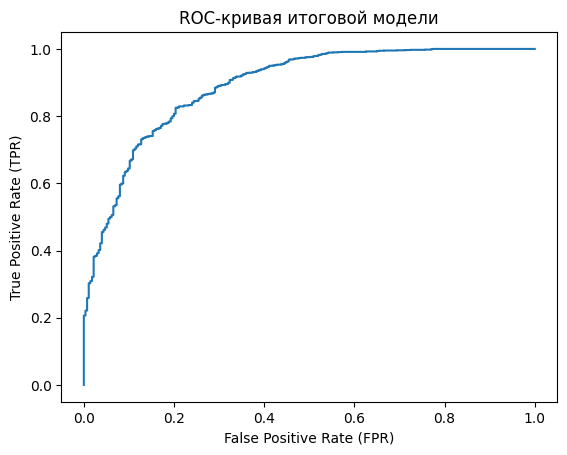

In [61]:
fpr, tpr, threshold = roc_curve(y_test, preds)
plt.plot(fpr, tpr)
plt.title("ROC-кривая итоговой модели")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

In [62]:
y_test_pred = cv_search.predict(X_test)
print(f'Метрика Accuracy на тестовой выборке: {round(accuracy_score(y_test, y_test_pred), 2)}')

Метрика Accuracy на тестовой выборке: 0.9


**Построим матрицу ошибок**

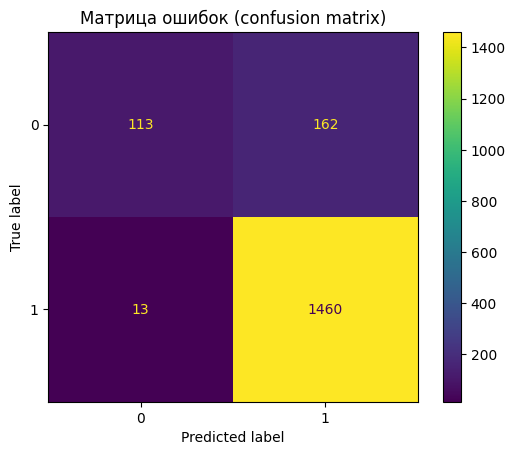

In [63]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Матрица ошибок (confusion matrix)')
plt.show()

**Анализ важности признаков**

In [64]:
feature_names= cv_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feature_names

array(['ohe__PaymentMethod_Credit card (automatic)',
       'ohe__PaymentMethod_Electronic check',
       'ohe__PaymentMethod_Mailed check', 'ohe__Partner_True',
       'ohe__OnlineSecurity_True', 'ohe__OnlineBackup_True',
       'ohe__DeviceProtection_True', 'ohe__StreamingTV_True',
       'ohe__StreamingMovies_True', 'ohe__MultipleLines_True',
       'num__MonthlyCharges', 'num__TotalCharges', 'num__Duration'],
      dtype=object)

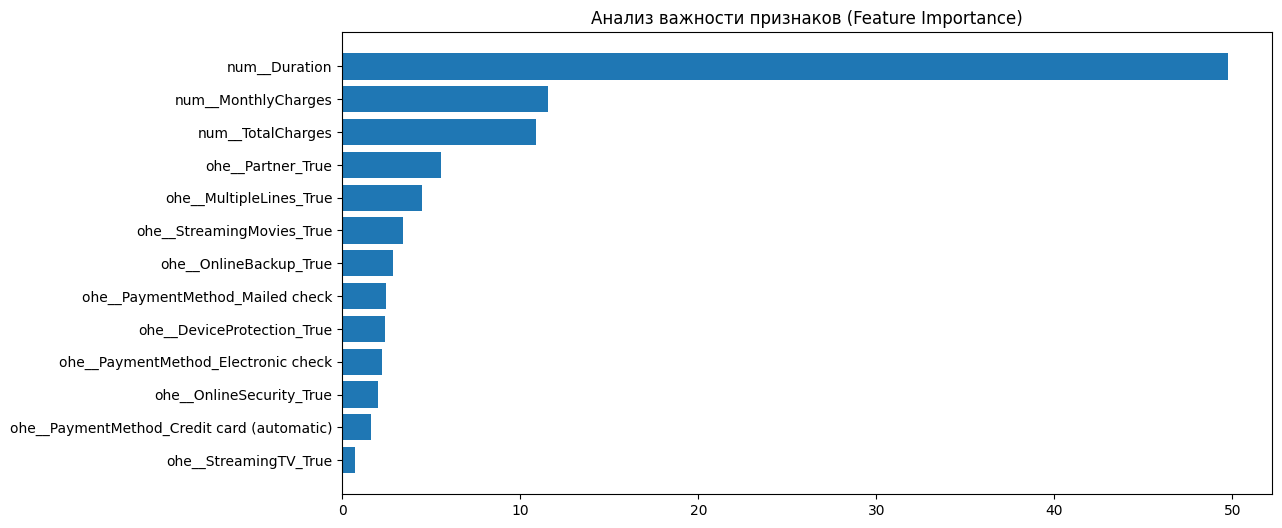

In [65]:
feature_importance = cv_search.best_estimator_.named_steps['models'].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title('Анализ важности признаков (Feature Importance)')
plt.show()

**Построим график роста метрики Roc-auc от признаков**

In [66]:
X_train_transformed = pd.DataFrame(cv_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train),columns = feature_names)
X_train_transformed.head()

ohe__PaymentMethod_Credit card (automatic)  \
0                                         1.0   
1                                         0.0   
2                                         1.0   
3                                         1.0   
4                                         0.0   

   ohe__PaymentMethod_Electronic check  ohe__PaymentMethod_Mailed check  \
0                                  0.0                              0.0   
1                                  0.0                              0.0   
2                                  0.0                              0.0   
3                                  0.0                              0.0   
4                                  0.0                              1.0   

   ohe__Partner_True  ohe__OnlineSecurity_True  ohe__OnlineBackup_True  \
0                1.0                       1.0                     1.0   
1                1.0                       0.0                     1.0   
2                0.0                       1.0                     0.0   
3                1.0                       0.0                     0.0   
4                0.0                       0.0                     0.0   

   ohe__DeviceProtection_True  ohe__StreamingTV_True  \
0                         1.0                    0.0   
1                         0.0                    1.0   
2                         1.0                    1.0   
3                         0.0                    0.0   
4                         0.0                    0.0   

   ohe__StreamingMovies_True  ohe__MultipleLines_True  num__MonthlyCharges  \
0                        0.0                      0.0                62.65   
1                        0.0                      1.0                88.40   
2                        1.0                      1.0                86.45   
3                        0.0                      0.0                19.65   
4                        0.0                      0.0                70.15   

   num__TotalCharges  num__Duration  
0            4260.20         2071.0  
1            6455.85         2041.0  
2            5273.45         1857.0  
3             541.55          792.0  
4             140.30           62.0

In [67]:
X_test_transformed =  pd.DataFrame(cv_search.best_estimator_.named_steps['preprocessor'].transform(X_test),columns = feature_names)
X_test_transformed.head()

ohe__PaymentMethod_Credit card (automatic)  \
0                                         1.0   
1                                         0.0   
2                                         1.0   
3                                         0.0   
4                                         0.0   

   ohe__PaymentMethod_Electronic check  ohe__PaymentMethod_Mailed check  \
0                                  0.0                              0.0   
1                                  1.0                              0.0   
2                                  0.0                              0.0   
3                                  1.0                              0.0   
4                                  1.0                              0.0   

   ohe__Partner_True  ohe__OnlineSecurity_True  ohe__OnlineBackup_True  \
0                0.0                       0.0                     0.0   
1                0.0                       0.0                     0.0   
2                1.0                       1.0                     0.0   
3                1.0                       0.0                     0.0   
4                0.0                       0.0                     1.0   

   ohe__DeviceProtection_True  ohe__StreamingTV_True  \
0                         0.0                    0.0   
1                         1.0                    0.0   
2                         0.0                    0.0   
3                         0.0                    0.0   
4                         0.0                    1.0   

   ohe__StreamingMovies_True  ohe__MultipleLines_True  num__MonthlyCharges  \
0                        0.0                      0.0                20.45   
1                        1.0                      0.0                89.20   
2                        1.0                      0.0                59.45   
3                        0.0                      0.0                20.45   
4                        0.0                      1.0                88.20   

   num__TotalCharges  num__Duration  
0             224.95          337.0  
1            2408.40          822.0  
2            3269.75         1676.0  
3             238.45          337.0  
4            2028.60          702.0

Features count: 1
Featues: ['ohe__StreamingTV_True']
Метрика ROC-AUC: 0.6
Features count: 2
Featues: ['ohe__StreamingTV_True' 'ohe__PaymentMethod_Credit card (automatic)']
Метрика ROC-AUC: 0.63
Features count: 3
Featues: ['ohe__StreamingTV_True' 'ohe__PaymentMethod_Credit card (automatic)'
 'ohe__OnlineSecurity_True']
Метрика ROC-AUC: 0.64
Features count: 4
Featues: ['ohe__StreamingTV_True' 'ohe__PaymentMethod_Credit card (automatic)'
 'ohe__OnlineSecurity_True' 'ohe__PaymentMethod_Electronic check']
Метрика ROC-AUC: 0.63
Features count: 5
Featues: ['ohe__StreamingTV_True' 'ohe__PaymentMethod_Credit card (automatic)'
 'ohe__OnlineSecurity_True' 'ohe__PaymentMethod_Electronic check'
 'ohe__DeviceProtection_True']
Метрика ROC-AUC: 0.66
Features count: 6
Featues: ['ohe__StreamingTV_True' 'ohe__PaymentMethod_Credit card (automatic)'
 'ohe__OnlineSecurity_True' 'ohe__PaymentMethod_Electronic check'
 'ohe__DeviceProtection_True' 'ohe__PaymentMethod_Mailed check']
Метрика ROC-AUC: 0.67
Featur

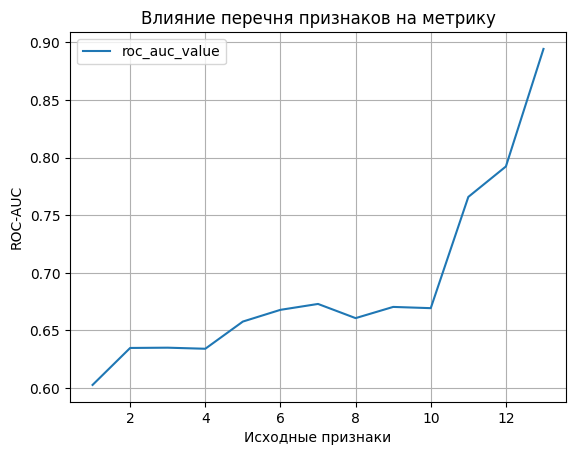


Максимальное значение метрики ROC-AUC на тестовой выборке=0.89


In [68]:
model= cv_search.best_estimator_.named_steps['models']
all_features_names=np.array(feature_names)[sorted_idx]
max_roc_auc_value=-1
features_metric = []
features_cnt=len(all_features_names)
for i in range(features_cnt):
    print(f'Features count: {i+1}')
    selected_features_names = all_features_names[0:i+1]
    # отберем данные
    X_train_new = X_train_transformed[list(selected_features_names)]
    X_test_new = X_test_transformed[list(selected_features_names)]
    
    # инициализируем и обучаем модель
    model.fit(X_train_new, y_train, verbose =False)
    
    y_test_pred = model.predict_proba(X_test_new)[:,1]
    print(f'Featues: {selected_features_names}')
    roc_auc_value=roc_auc_score(y_test, y_test_pred)
    features_metric.append(tuple((len(selected_features_names), selected_features_names, roc_auc_value)))
    if roc_auc_value>max_roc_auc_value:
        max_roc_auc_value= roc_auc_value
    print(f'Метрика ROC-AUC: {round(roc_auc_value, 2)}')
features_metric_data =  pd.DataFrame(features_metric, columns = ['features_cnt', 'feature_names', 'roc_auc_value'])
features_metric_data.plot(
    title='Влияние перечня признаков на метрику',
    kind='line',
    x='features_cnt',
    y='roc_auc_value',
    xlabel='Исходные признаки',
    ylabel='ROC-AUC',
    grid=True
)
plt.show()
print(f'\nМаксимальное значение метрики ROC-AUC на тестовой выборке={round(max_roc_auc_value, 2)}')

## 8. Общий вывод и рекомендации заказчику

**Вывод: в результате работы построена модель, позволяющая предсказать уход клиента на основе следающих признаков: длительность (время с момента заключения договора), ежемесячные и суммарные платежи, есть ли у клиента супруг или супруга, перечня подключенных услуг. Признаки закодированы с использованием OrdinalEncoder (целевой - с помощью LabelEncoder), числовые признаки масштабированы с помощью StandardScaler. В итоге выбрана модель CatBoostClassifier с параметрами "max_depth: 6, RANDOM_STATE=60524". Значение метрики Roc-auc, полученное для тестовой выборки равно 0.89. Значение аccuracy на тестовой выборке равно 0.9. Заказчику можно порекомендовать отслеживать тенденцию к уменьшению средней длительности договора (увеличение оттока) клиентов, и при необходимости скорректировать модель в будущем, чтобы вовремя делать клиентам спец.предложения для их удержания.**